Experimentation on the CIFAR simmulated annotators
* batch = 128
* delta convergence = 1e-2
* Optimizer = ADAM

* Our proposed: Pre-train base model with soft-MV (5 epochs?) as Rodrigues: https://github.com/fmpr/CrowdLayer/blob/master/demo-conll-ner-mturk.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

Using TensorFlow backend.


In [2]:
#GLOBAL Variables
BATCH_SIZE = 128
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
#TOL = 3e-2 #tolerance for relative variation of parameters
TOL = 3e-2

### Load Data and preprocess

In [3]:
folder = "."
X_train = np.loadtxt(folder+"/synthetic/simple/datasim_X_train.csv",delimiter=',')
Z_train = np.loadtxt(folder+"/synthetic/simple/datasim_Z_train.csv",dtype='int') #groudn truth

X_test = np.loadtxt(folder+"/synthetic/simple/datasim_X_test.csv",delimiter=',')
Z_test = np.loadtxt(folder+"/synthetic/simple/datasim_Z_test.csv",dtype='int') #groudn truth

print("Input shape:",X_train.shape)

Input shape: (2457, 2)


In [4]:
from sklearn.preprocessing import StandardScaler
std= StandardScaler(with_mean=True) #matrices sparse with_mean=False
std.fit(X_train)
Xstd_train = std.transform(X_train)
Xstd_test = std.transform(X_test)
Xstd_train.shape

(2457, 2)

### Load annotations / Generate

> save scenario 2,3, 6 and 7 for formulation 2

In [80]:
scenario = 1
path = "."
state_sce = path+"/synthetic/simple//state_simple_s"+str(scenario)+".pickle"
#state_sce = None #random state

In [81]:
from code.generate_data import SinteticData

GenerateData = SinteticData(state=state_sce)

#CONFUSION MATRIX CHOOSE
if scenario == 1 or scenario == 3 or scenario == 4 or scenario == 5 or scenario==7:
    GenerateData.set_probas(asfile=True,file_matrix=path+'/synthetic/simple/matrix_datasim_normal.csv',file_groups =path+'/synthetic/simple/groups_datasim_normal.csv')

elif scenario == 2 or scenario ==6 or scenario == 8: #bad MV
    GenerateData.set_probas(asfile=True,file_matrix=path+'/synthetic/simple/matrix_datasim_badMV.csv',file_groups =path+'/synthetic/simple/groups_datasim_badMV.csv')

real_conf_matrix = GenerateData.conf_matrix.copy()

#ANNOTATOR DENSITY CHOOSE
if scenario == 1 or scenario ==2 or scenario == 3:
    Tmax = 100
    T_data = 10 
elif scenario == 4 or scenario==6 or scenario==7 or scenario == 8:
    Tmax = 2000
    T_data = 10 
elif scenario == 5:
    Tmax = 10000
    T_data = 20
#GenerateData.set_probas(asfile=False,file_matrix=real_conf_matrix,file_groups =aux)

#Tmax = 25000
#T_data = 40

print("New Synthetic data is being generated...",flush=True,end='')
if scenario == 3 or scenario==7 or scenario == 8: #soft
    y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False,hard=False)
else:
    y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False)
print("Done! ")

if len(groups_annot.shape) ==1 or groups_annot.shape[1] ==  1: 
    groups_annot = keras.utils.to_categorical(groups_annot)  #only if it is hard clustering
confe_matrix = np.tensordot(groups_annot,real_conf_matrix, axes=[[1],[0]])
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones con este valor

print("Accuracy of MV on train: ",np.mean(GenerateData.yo_label == Z_train))

N,T = y_obs.shape
K = np.max(y_obs)+1 # asumiendo que estan ordenadas
print("Shape (data,annotators): ",(N,T))
print("Classes: ",K)

New Synthetic data is being generated...Done! 
Accuracy of MV on train:  0.6133496133496134
Shape (data,annotators):  (2457, 100)
Classes:  3


In [10]:
GenerateData.prob_groups

array([0.2 , 0.45, 0.35])

In [ ]:
#save it
import pickle
new_state = GenerateData.init_state
with open('state_simple_s'+str(scenario)+'.pickle', 'wb') as handle:
    pickle.dump(new_state, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Delta Convergence criteria

In [5]:
from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from code.learning_models import default_CNN,default_RNN,default_RNNw_emb,CNN_simple, RNN_simple

from code.utils import EarlyStopRelative
TOL = 3e-2 #entre 15 a 20 iteraciones -- super inestable los resultados
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

### Upper Bound Model

In [16]:
Z_train_onehot = keras.utils.to_categorical(Z_train)
Z_test_onehot = keras.utils.to_categorical(Z_test)

model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],16,1,BN=False,drop=0.2)
#model_UB = clone_model(raykarMC.base_model)

model_UB.compile(loss='categorical_crossentropy',optimizer=OPT,metrics=["acc"])
hist = model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback],
                   validation_data=(Xstd_test,Z_test_onehot))
print("Epochs to converge =",len(hist.epoch))
Z_train_pred = model_UB.predict_classes(Xstd_train)
Z_test_pred = model_UB.predict_classes(Xstd_test)

Epochs to converge = 20


In [83]:
from code.representation import *
from code.utils import *

### Infer Labels (without predictive model)

In [84]:
from code.baseline import LabelInference

label_I = LabelInference(y_obs,TOL,type_inf = 'all')
#label_I = LabelInference(y_obs_categorical,TOL, type_inf = 'all')

mv_onehot = label_I.mv_labels('onehot')
mv_probas = label_I.mv_labels('probas')

ds_labels,ds_conf_M = label_I.DS_labels()

Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -17142.28697846868
2 	 -16094.274782695384 	0.4972	0.224130	0.061136
3 	 -15821.982399355944 	0.1231	0.162399	0.016919
4 	 -15666.263370692815 	0.0439	0.129858	0.009842
5 	 -15589.79635257662 	0.0580	0.087726	0.004881
6 	 -15548.198765929581 	0.0515	0.069903	0.002668
7 	 -15524.400124182408 	0.0408	0.050143	0.001531
8 	 -15510.287535171085 	0.0314	0.037339	0.000909
9 	 -15501.589854449225 	0.0244	0.029291	0.000561
Class marginals
[0.37 0.34 0.3 ]


In [85]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))
print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train))

ACC MV on train: 0.6133496133496134
ACC D&S on train: 0.9267399267399268


In [11]:
model_mvsoft = MLP_Keras(Xstd_train.shape[1:],mv_probas.shape[1],16,1,BN=False,drop=0.2)
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT)
hist =model_mvsoft.fit(Xstd_train,mv_probas, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over soft-MV, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_mvsoft.predict_classes(Xstd_train)
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)

Trained model over soft-MV, Epochs to converge = 6


In [19]:
model_mvhard = MLP_Keras(Xstd_train.shape[1:],mv_onehot.shape[1],16,1,BN=False,drop=0.2)
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvhard.fit(Xstd_train, mv_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over hard-MV, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_mvhard.predict_classes(Xstd_train)
Z_test_pred = model_mvhard.predict_classes(Xstd_test)

Trained model over hard-MV, Epochs to converge = 12


In [21]:
model_ds = MLP_Keras(Xstd_train.shape[1:],ds_labels.shape[1],16,1,BN=False,drop=0.2)
model_ds.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_ds.fit(Xstd_train, ds_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over D&S, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_ds.predict_classes(Xstd_train)
Z_test_pred = model_ds.predict_classes(Xstd_test)

Trained model over D&S, Epochs to converge = 15


### Raykar Model (joint predict model)

In [93]:
from code.baseline import RaykarMC
#get raykar represenstation
#y_obs_categorical = label_I.y_obs_categ
y_obs_categorical = set_representation(y_obs,'onehot') #for raykar
print("shape:",y_obs_categorical.shape)

shape: (2457, 100, 3)


In [42]:
raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
raykarMC.define_model("mlp",16,1,BatchN=False,drop=0.2)

raykarMC.define_priors(np.ones((T,K))) #cada observador dijo al menos un dato
logL_hist = raykarMC.train(Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                           ,relative=True,val=False)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (100, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/50 
M step: done,  E step: done //  (in 3.31 sec)	logL: -16912.457	
Iter 2/50 
M step: done,  E step: done //  (in 0.17 sec)	logL: -15768.896	Tol1: 0.06762	Tol2: 0.31094	
Iter 3/50 
M step: done,  E step: done //  (in 0.12 sec)	logL: -15365.971	Tol1: 0.02555	Tol2: 0.10420	
Iter 4/50 
M step: done,  E step: done //  (in 0.11 sec)	logL: -15117.531	Tol1: 0.01617	Tol2: 0.07283	
Iter 5/50 
M step: done,  E step: done //  (in 0.13 sec)	logL: -14931.629	Tol1: 0.01230	Tol2: 0.04643	
Iter 6/50 
M step: done,  E step: done //  (in 0.12 sec)	logL: -14768.826	Tol1: 0.01090	Tol2: 0.02996	
Finished training


In [94]:
raykarMC = RaykarMC(Xstd_train.shape[1:],y_obs_categorical.shape[-1],T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
raykarMC.define_model("mlp",16,1,BatchN=False,drop=0.2)

logL_hists,i_r = raykarMC.multiples_run(20,Xstd_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,
                                     tolerance=TOL)

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Betas shape:  (100, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/50 
M step: done,  E step: done //  (in 0.71 sec)	logL: -17570.727	
Iter 2/50 
M step: done,  E step: done //  (in 0.08 sec)	logL: -16323.152	Tol1: 0.07100	Tol2: 0.29683	
Iter 3/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -15772.654	Tol1: 0.03372	Tol2: 0.11455	
Iter 4/50 
M step: done,  E step: done //  (in 0.06 sec)	logL: -15431.917	Tol1: 0.02160	Tol2: 0.08249	
Iter 5/50 
M step: done,  E step: done //  (in 0.06 sec)	logL: -15200.454	Tol1: 0.01500	Tol2: 0.04890	
Iter 6/50 
M step: done,  E step: done //  (in 0.06 sec)	logL: -15015.315	Tol1: 0.01218	Tol2: 0.02792	
Finished training
Initializing new EM...
Betas shape:  (100, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/50 
M step: done,  E step: done //  (in 0.62 sec)	logL: -17598.246	
Iter 2/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -16378.252	Tol1: 0.06932	Tol2: 0.32538	
Iter 3/50 
M step:

Initializing new EM...
Betas shape:  (100, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/50 
M step: done,  E step: done //  (in 0.55 sec)	logL: -17316.758	
Iter 2/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -16018.473	Tol1: 0.07497	Tol2: 0.29792	
Iter 3/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -15461.586	Tol1: 0.03477	Tol2: 0.11714	
Iter 4/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -15119.240	Tol1: 0.02214	Tol2: 0.07955	
Iter 5/50 
M step: done,  E step: done //  (in 0.04 sec)	logL: -14878.284	Tol1: 0.01594	Tol2: 0.04537	
Iter 6/50 
M step: done,  E step: done //  (in 0.05 sec)	logL: -14685.184	Tol1: 0.01298	Tol2: 0.02549	
Finished training
Initializing new EM...
Betas shape:  (100, 3, 3)
Q estimate shape:  (2457, 3)
Iter 1/50 
M step: done,  E step: done //  (in 0.56 sec)	logL: -17195.273	
Iter 2/50 
M step: done,  E step: done //  (in 0.06 sec)	logL: -15902.674	Tol1: 0.07517	Tol2: 0.29938	
Iter 3/50 
M step: done,  E step: done //  (in 0.05 sec)	l

In [95]:
Z_train_p = raykarMC.base_model.predict(Xstd_train)
Z_train_pred =Z_train_p.argmax(axis=-1)
Z_test_pred = raykarMC.base_model.predict_classes(Xstd_test)

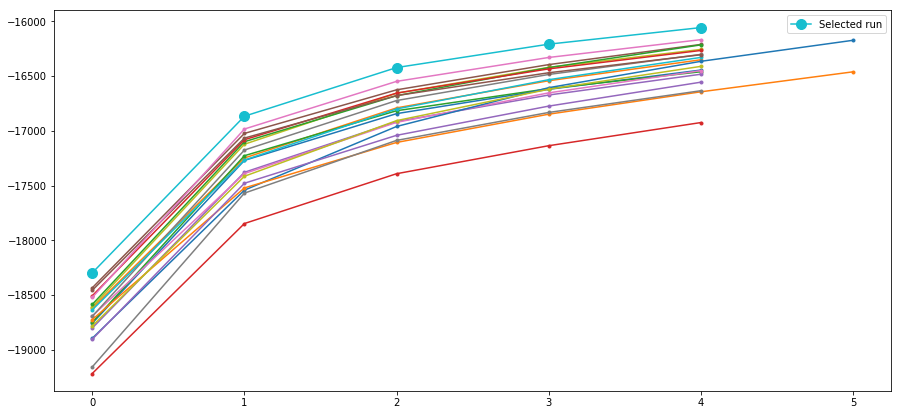

In [15]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

### Our Proposed

In [86]:
from code.MixtureofGroups import GroupMixtureOpt
#get our representation 
#r_obs = set_representation(y_obs_categorical,"repeat")
r_obs = set_representation(y_obs,"repeat")
#r_obs = label_I.y_obs_repeat.copy()

print("vector of repeats:\n",r_obs)
print("shape:",r_obs.shape)

vector of repeats:
 [[2 0 7]
 [1 8 4]
 [3 0 5]
 ...
 [8 2 7]
 [7 1 0]
 [6 0 3]]
shape: (2457, 3)


In [87]:
M_seted = 3

In [97]:
gMixture_Global = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Global.define_model("mlp",16,1,BatchN=False,drop=0.2)
gMixture_Global.lambda_random = True #with lambda random --necessary
logL_hists,i_r = gMixture_Global.multiples_run(30,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True)

Needed params (units,deep,drop,BatchN?)
Doing clustering...Done!
Get init alphas in 0.003451 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.47 0.37 0.18]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 1.03 sec)	logL: -23474.446	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22696.924	Tol1: 0.03312	Tol2: 0.34457	Tol3: 0.05460	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22160.742	Tol1: 0.02362	Tol2: 0.18275	Tol3: 0.04112	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21682.880	Tol1: 0.02156	Tol2: 0.13405	Tol3: 0.03624	
Iter 5/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -21252.799	Tol1: 0.01984	Tol2: 0.11776	Tol3: 0.03431	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -20851.043	Tol1: 0.01890	Tol2: 0.10629	Tol3: 0.03354	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -20493.2

M step: done,  E step: done //  (in 0.08 sec)	logL: -19304.103	Tol1: 0.00115	Tol2: 0.02979	Tol3: 0.00290	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.49 0.74 0.24]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.61 sec)	logL: -24097.986	
Iter 2/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -23004.440	Tol1: 0.04538	Tol2: 0.31185	Tol3: 0.08677	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22417.904	Tol1: 0.02550	Tol2: 0.15924	Tol3: 0.02609	
Iter 4/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21917.068	Tol1: 0.02234	Tol2: 0.13058	Tol3: 0.02161	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21458.592	Tol1: 0.02092	Tol2: 0.12233	Tol3: 0.02090	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21049.659	Tol1: 0.01906	Tol2: 0.11512	Tol3: 0.02151	
Iter 7/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.08 sec)	logL: -19605.434	Tol1: 0.00213	Tol2: 0.03142	Tol3: 0.00237	
Iter 27/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -19569.806	Tol1: 0.00182	Tol2: 0.02869	Tol3: 0.00214	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9  0.36 0.09]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.63 sec)	logL: -24140.309	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23430.615	Tol1: 0.02940	Tol2: 0.35748	Tol3: 0.05195	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22914.254	Tol1: 0.02204	Tol2: 0.18189	Tol3: 0.04020	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22455.024	Tol1: 0.02004	Tol2: 0.13086	Tol3: 0.03497	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22034.238	Tol1: 0.01874	Tol2: 0.10966	Tol3: 0.03221	
Iter 6/50
M step: done,  E step: done //  

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.01 0.47 0.81]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -26292.181	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24877.123	Tol1: 0.05382	Tol2: 0.48204	Tol3: 0.07692	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24245.648	Tol1: 0.02538	Tol2: 0.22012	Tol3: 0.04286	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23864.452	Tol1: 0.01572	Tol2: 0.13375	Tol3: 0.02598	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23572.068	Tol1: 0.01225	Tol2: 0.09359	Tol3: 0.01629	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23303.755	Tol1: 0.01138	Tol2: 0.07698	Tol3: 0.01147	
Iter 7/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23036.419	Tol1: 0.01147	Tol2: 0.07456	Tol3: 0.00988	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22760.917	To

M step: done,  E step: done //  (in 0.59 sec)	logL: -28554.129	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26001.176	Tol1: 0.08941	Tol2: 0.68962	Tol3: 0.09485	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24974.978	Tol1: 0.03947	Tol2: 0.26853	Tol3: 0.04131	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24523.912	Tol1: 0.01806	Tol2: 0.16071	Tol3: 0.02373	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24218.005	Tol1: 0.01247	Tol2: 0.11432	Tol3: 0.01562	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23935.860	Tol1: 0.01165	Tol2: 0.09297	Tol3: 0.01362	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23650.856	Tol1: 0.01191	Tol2: 0.08668	Tol3: 0.00953	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23345.062	Tol1: 0.01293	Tol2: 0.08589	Tol3: 0.00559	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23021.025	Tol1: 0.01388	Tol2: 0.09325	Tol3: 0.00329	
Iter 10/

M step: done,  E step: done //  (in 0.10 sec)	logL: -22998.470	Tol1: 0.03546	Tol2: 0.40555	Tol3: 0.04755	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22468.937	Tol1: 0.02302	Tol2: 0.21053	Tol3: 0.03451	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22009.008	Tol1: 0.02047	Tol2: 0.15772	Tol3: 0.03047	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21583.225	Tol1: 0.01935	Tol2: 0.13975	Tol3: 0.02994	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21191.432	Tol1: 0.01815	Tol2: 0.12734	Tol3: 0.03058	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -20836.058	Tol1: 0.01677	Tol2: 0.11430	Tol3: 0.03090	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -20536.271	Tol1: 0.01439	Tol2: 0.10116	Tol3: 0.03069	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -20279.018	Tol1: 0.01253	Tol2: 0.08699	Tol3: 0.02937	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -20082.046	Tol1: 0.

M step: done,  E step: done //  (in 0.09 sec)	logL: -19862.534	Tol1: 0.00093	Tol2: 0.04169	Tol3: 0.00133	
Iter 25/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -19847.431	Tol1: 0.00076	Tol2: 0.04103	Tol3: 0.00170	
Iter 26/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -19836.349	Tol1: 0.00056	Tol2: 0.03991	Tol3: 0.00164	
Iter 27/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -19825.238	Tol1: 0.00056	Tol2: 0.03813	Tol3: 0.00148	
Iter 28/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -19813.154	Tol1: 0.00061	Tol2: 0.03641	Tol3: 0.00202	
Iter 29/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -19802.825	Tol1: 0.00052	Tol2: 0.03563	Tol3: 0.00231	
Iter 30/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -19792.517	Tol1: 0.00052	Tol2: 0.03423	Tol3: 0.00244	
Iter 31/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -19782.163	Tol1: 0.00052	Tol2: 0.03289	Tol3: 0.00298	
Iter 32/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -19771.141	T

M step: done,  E step: done //  (in 0.09 sec)	logL: -19385.928	Tol1: 0.00087	Tol2: 0.04022	Tol3: 0.00705	
Iter 30/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -19374.013	Tol1: 0.00061	Tol2: 0.03992	Tol3: 0.00743	
Iter 31/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -19359.596	Tol1: 0.00074	Tol2: 0.03831	Tol3: 0.00873	
Iter 32/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -19343.541	Tol1: 0.00083	Tol2: 0.03541	Tol3: 0.00786	
Iter 33/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -19330.971	Tol1: 0.00065	Tol2: 0.03279	Tol3: 0.00726	
Iter 34/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -19319.362	Tol1: 0.00060	Tol2: 0.03139	Tol3: 0.00623	
Iter 35/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -19304.794	Tol1: 0.00075	Tol2: 0.02867	Tol3: 0.00659	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.61 0.81 0.79]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3

In [98]:
Z_train_p = gMixture_Global.base_model.predict(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Global.base_model.predict(Xstd_test)
Z_test_pred = Z_test_p.argmax(axis=-1)

In [41]:
%%time
#pre analysis

mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

from code.MixtureofGroups import project_and_cluster,clusterize_annotators
annotators_pca = project_and_cluster(y_obs_categorical,DTYPE_OP=DTYPE_OP,mode_project='pca')[0]
print("Annotators PCA of annotations shape: ",annotators_pca.shape)


/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


Bayesian gaussian mixture say is 18 clusters 


/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


DBSCAN say is 2 clusters
Affinity Propagation say is 1 clusters
Annotators PCA of annotations shape:  (2000, 4)
Normalized entropy (0-1) of repeats annotations: 0.647916212093615
CPU times: user 1min, sys: 5.31 s, total: 1min 5s
Wall time: 5.23 s


In [ ]:
#different M_seted??
M_seted = 3

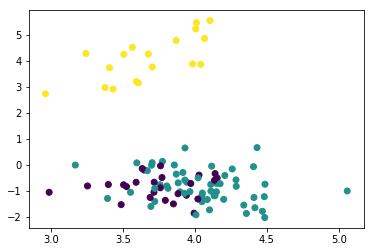

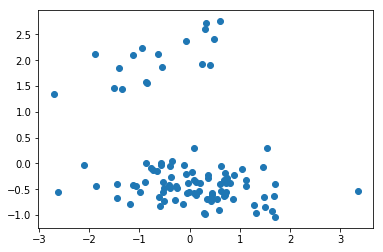

In [119]:
plt.scatter(annotators_pca[:,0],annotators_pca[:,1],c=groups_annot.argmax(axis=1))
plt.show()

std = StandardScaler()
annotators_pca2 = std.fit_transform(annotators_pca)
plt.scatter(annotators_pca2[:,0],annotators_pca2[:,1])
plt.show()

In [42]:
gMixture1 = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture1.define_model("mlp",8,1,BatchN=False,drop=0.2)
gMixture1.lambda_random = False #lambda=1     
logL_hists,i_r = gMixture1.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True,bulk_annotators=[y_obs_categorical,annotators_pca])

Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.003375 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 8.97 sec)	logL: -48511.162	
Iter 2/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -48054.513	Tol1: 0.00941	Tol2: 0.06404	Tol3: 0.01810	
Iter 3/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -47719.367	Tol1: 0.00697	Tol2: 0.04276	Tol3: 0.00032	
Iter 4/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -47344.273	Tol1: 0.00786	Tol2: 0.05259	Tol3: 0.00106	
Iter 5/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -46911.728	Tol1: 0.00914	Tol2: 0.06177	Tol3: 0.00122	
Iter 6/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -46431.422	Tol1: 0.01024	Tol2: 0.07072	Tol3: 0.00161	
Iter 7/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -45893.800	Tol1: 0.011

M step: done,  E step: done //  (in 0.13 sec)	logL: -40500.523	Tol1: 0.00336	Tol2: 0.03107	Tol3: 0.00041	
Iter 19/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -40375.309	Tol1: 0.00309	Tol2: 0.03119	Tol3: 0.00003	
Iter 20/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -40266.392	Tol1: 0.00270	Tol2: 0.03275	Tol3: 0.00064	
Iter 21/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -40161.242	Tol1: 0.00261	Tol2: 0.03302	Tol3: 0.00076	
Iter 22/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -40067.662	Tol1: 0.00233	Tol2: 0.03353	Tol3: 0.00131	
Iter 23/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -39975.181	Tol1: 0.00231	Tol2: 0.03280	Tol3: 0.00107	
Iter 24/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -39889.418	Tol1: 0.00215	Tol2: 0.03240	Tol3: 0.00166	
Iter 25/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -39812.441	Tol1: 0.00193	Tol2: 0.03166	Tol3: 0.00144	
Iter 26/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -39740.333	T

M step: done,  E step: done //  (in 8.47 sec)	logL: -49135.408	
Iter 2/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -48382.749	Tol1: 0.01532	Tol2: 0.13605	Tol3: 0.03467	
Iter 3/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -47998.183	Tol1: 0.00795	Tol2: 0.06941	Tol3: 0.00420	
Iter 4/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -47577.439	Tol1: 0.00877	Tol2: 0.06598	Tol3: 0.00077	
Iter 5/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -47106.562	Tol1: 0.00990	Tol2: 0.06873	Tol3: 0.00060	
Iter 6/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -46584.205	Tol1: 0.01109	Tol2: 0.07345	Tol3: 0.00056	
Iter 7/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -46019.388	Tol1: 0.01212	Tol2: 0.07792	Tol3: 0.00051	
Iter 8/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -45407.361	Tol1: 0.01330	Tol2: 0.08330	Tol3: 0.00064	
Iter 9/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -44747.044	Tol1: 0.01454	Tol2: 0.09046	Tol3: 0.00070	
Iter 10/

M step: done,  E step: done //  (in 0.16 sec)	logL: -48244.150	Tol1: 0.00553	Tol2: 0.04804	Tol3: 0.00598	
Iter 4/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -47954.478	Tol1: 0.00600	Tol2: 0.04707	Tol3: 0.00112	
Iter 5/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -47611.460	Tol1: 0.00715	Tol2: 0.04711	Tol3: 0.00064	
Iter 6/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -47209.364	Tol1: 0.00845	Tol2: 0.04988	Tol3: 0.00063	
Iter 7/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -46739.023	Tol1: 0.00996	Tol2: 0.05583	Tol3: 0.00058	
Iter 8/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -46193.662	Tol1: 0.01167	Tol2: 0.06258	Tol3: 0.00053	
Iter 9/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -45584.213	Tol1: 0.01319	Tol2: 0.07322	Tol3: 0.00056	
Iter 10/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -44919.751	Tol1: 0.01458	Tol2: 0.08386	Tol3: 0.00064	
Iter 11/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -44224.556	Tol1: 0

M step: done,  E step: done //  (in 0.16 sec)	logL: -42283.403	Tol1: 0.01175	Tol2: 0.11120	Tol3: 0.00060	
Iter 9/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -41824.165	Tol1: 0.01086	Tol2: 0.10770	Tol3: 0.00130	
Iter 10/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -41413.208	Tol1: 0.00983	Tol2: 0.10170	Tol3: 0.00200	
Iter 11/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -41056.437	Tol1: 0.00861	Tol2: 0.09417	Tol3: 0.00259	
Iter 12/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -40767.489	Tol1: 0.00704	Tol2: 0.08402	Tol3: 0.00271	
Iter 13/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -40523.278	Tol1: 0.00599	Tol2: 0.07335	Tol3: 0.00323	
Iter 14/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -40321.524	Tol1: 0.00498	Tol2: 0.06457	Tol3: 0.00367	
Iter 15/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -40144.798	Tol1: 0.00438	Tol2: 0.06029	Tol3: 0.00368	
Iter 16/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -39996.980	To

In [43]:
gMixture2 = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture2.define_model("mlp",8,1,BatchN=False,drop=0.2)
gMixture2.lambda_random = True #lambda random
logL_hists,i_r = gMixture2.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True,bulk_annotators=[y_obs_categorical,annotators_pca])

Needed params (units,deep,drop,BatchN?)
Clustering Done!
Get init alphas in 0.004671 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.03 0.04 0.58]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 11.81 sec)	logL: -47893.726	
Iter 2/50
M step: done,  E step: done //  (in 0.19 sec)	logL: -46795.137	Tol1: 0.02294	Tol2: 0.15603	Tol3: 0.00846	
Iter 3/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -45904.463	Tol1: 0.01903	Tol2: 0.09954	Tol3: 0.00415	
Iter 4/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -45109.323	Tol1: 0.01732	Tol2: 0.07261	Tol3: 0.00299	
Iter 5/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -44392.581	Tol1: 0.01589	Tol2: 0.05718	Tol3: 0.00357	
Iter 6/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -43708.633	Tol1: 0.01541	Tol2: 0.05617	Tol3: 0.00500	
Iter 7/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -43069.263	Tol1

M step: done,  E step: done //  (in 0.15 sec)	logL: -48770.686	Tol1: 0.00974	Tol2: 0.07563	Tol3: 0.00499	
Iter 8/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -48406.007	Tol1: 0.00748	Tol2: 0.05467	Tol3: 0.00362	
Iter 9/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -48069.493	Tol1: 0.00695	Tol2: 0.04935	Tol3: 0.00274	
Iter 10/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -47732.295	Tol1: 0.00701	Tol2: 0.05420	Tol3: 0.00252	
Iter 11/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -47333.491	Tol1: 0.00836	Tol2: 0.06116	Tol3: 0.00215	
Iter 12/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -46855.429	Tol1: 0.01010	Tol2: 0.06882	Tol3: 0.00216	
Iter 13/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -46295.906	Tol1: 0.01194	Tol2: 0.07610	Tol3: 0.00239	
Iter 14/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -45646.641	Tol1: 0.01402	Tol2: 0.08199	Tol3: 0.00308	
Iter 15/50
M step: done,  E step: done //  (in 0.20 sec)	logL: -44952.155	Tol

M step: done,  E step: done //  (in 0.18 sec)	logL: -40289.915	Tol1: 0.00271	Tol2: 0.05575	Tol3: 0.00840	
Iter 20/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -40192.618	Tol1: 0.00241	Tol2: 0.05083	Tol3: 0.00726	
Iter 21/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -40103.468	Tol1: 0.00222	Tol2: 0.04976	Tol3: 0.00659	
Iter 22/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -40029.086	Tol1: 0.00185	Tol2: 0.05052	Tol3: 0.00604	
Iter 23/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -39956.745	Tol1: 0.00181	Tol2: 0.04935	Tol3: 0.00534	
Iter 24/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -39905.880	Tol1: 0.00127	Tol2: 0.05053	Tol3: 0.00486	
Iter 25/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -39845.243	Tol1: 0.00152	Tol2: 0.05038	Tol3: 0.00447	
Iter 26/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -39808.231	Tol1: 0.00093	Tol2: 0.04456	Tol3: 0.00320	
Iter 27/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -39760.909	T

M step: done,  E step: done //  (in 0.16 sec)	logL: -41961.675	Tol1: 0.00751	Tol2: 0.08604	Tol3: 0.00386	
Iter 15/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -41686.885	Tol1: 0.00655	Tol2: 0.07965	Tol3: 0.00240	
Iter 16/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -41460.262	Tol1: 0.00544	Tol2: 0.07395	Tol3: 0.00117	
Iter 17/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -41273.626	Tol1: 0.00450	Tol2: 0.06717	Tol3: 0.00071	
Iter 18/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -41125.304	Tol1: 0.00359	Tol2: 0.06025	Tol3: 0.00030	
Iter 19/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -41001.670	Tol1: 0.00301	Tol2: 0.05130	Tol3: 0.00033	
Iter 20/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -40896.557	Tol1: 0.00256	Tol2: 0.04271	Tol3: 0.00021	
Iter 21/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -40806.601	Tol1: 0.00220	Tol2: 0.03370	Tol3: 0.00024	
Iter 22/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -40726.650	T

M step: done,  E step: done //  (in 0.16 sec)	logL: -42921.141	Tol1: 0.01195	Tol2: 0.08532	Tol3: 0.00436	
Iter 12/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -42443.260	Tol1: 0.01113	Tol2: 0.08519	Tol3: 0.00419	
Iter 13/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -41984.028	Tol1: 0.01082	Tol2: 0.08290	Tol3: 0.00392	
Iter 14/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -41564.574	Tol1: 0.00999	Tol2: 0.07971	Tol3: 0.00355	
Iter 15/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -41203.304	Tol1: 0.00869	Tol2: 0.07501	Tol3: 0.00312	
Iter 16/50
M step: done,  E step: done //  (in 0.18 sec)	logL: -40899.236	Tol1: 0.00738	Tol2: 0.06956	Tol3: 0.00263	
Iter 17/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -40626.465	Tol1: 0.00667	Tol2: 0.06359	Tol3: 0.00220	
Iter 18/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -40401.971	Tol1: 0.00553	Tol2: 0.05685	Tol3: 0.00186	
Iter 19/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -40222.830	T

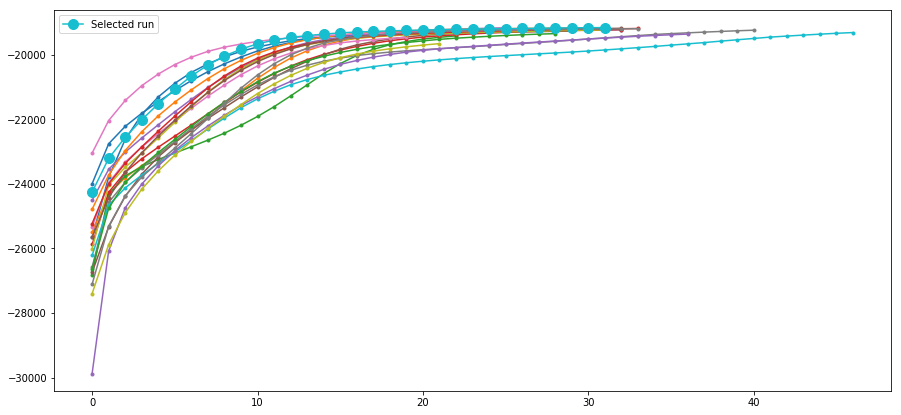

In [19]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

### Compare trained models

In [90]:
#Import it:
from code.evaluation import Evaluation_metrics
from sklearn.metrics import confusion_matrix

In [17]:
evaluate = Evaluation_metrics(model_UB,'keras',Xstd_train.shape[0])
print("*** Upper bound (Train with GT) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Upper bound (Train with GT) ***
Train
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global     0.93895       0.93895
====  ======  ==========  ============
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.948718      0.948718
====  ======  ==========  ============


#### 1st configuration: Normal ($T$ = 100, $T_{max}$ = 10 )

In [14]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.7773707773707774


*** Soft-Majority (Train with softMV) ***
Train


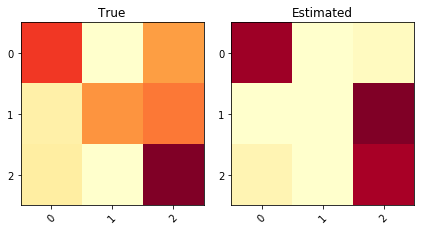

JS divergence: 0.1737	KL divergence: 2.3243


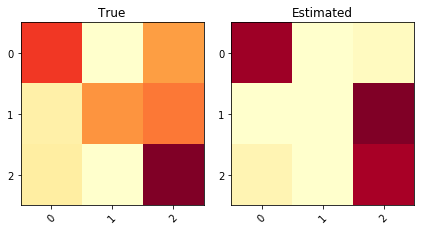

JS divergence: 0.1737	KL divergence: 2.3243


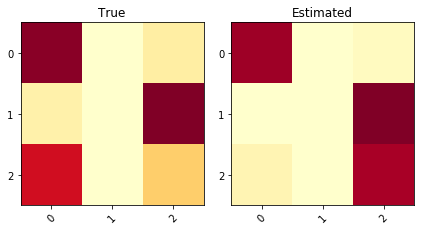

JS divergence: 0.1273	KL divergence: 0.2927


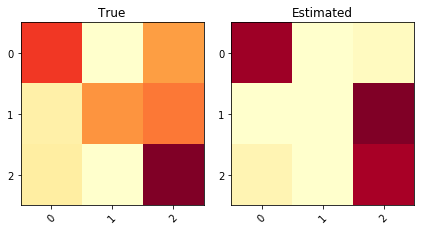

JS divergence: 0.1737	KL divergence: 2.3243


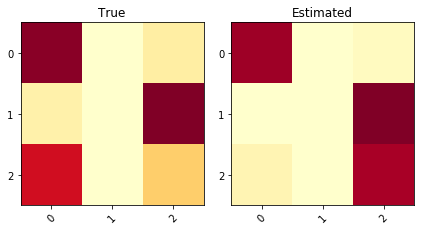

JS divergence: 0.1273	KL divergence: 0.2927


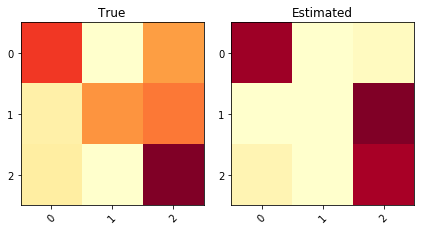

JS divergence: 0.1737	KL divergence: 2.3243


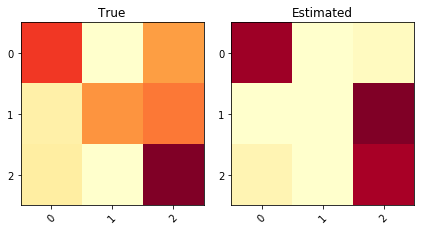

JS divergence: 0.1737	KL divergence: 2.3243


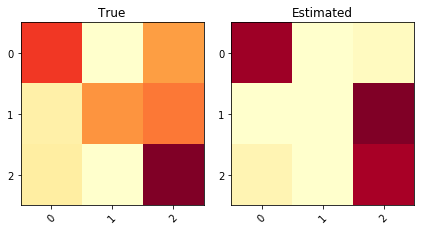

JS divergence: 0.1737	KL divergence: 2.3243


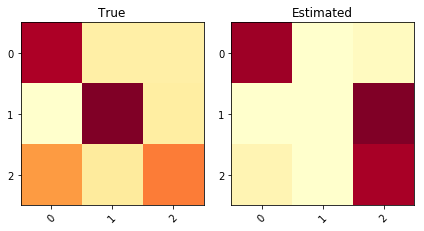

JS divergence: 0.3808	KL divergence: 6.0199


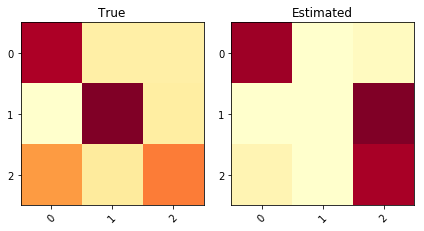

JS divergence: 0.3808	KL divergence: 6.0199


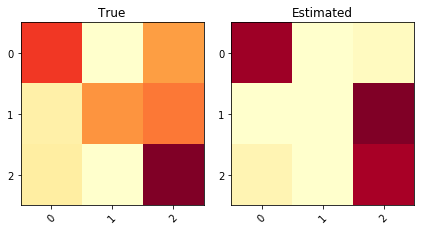

JS divergence: 0.1737	KL divergence: 2.3243


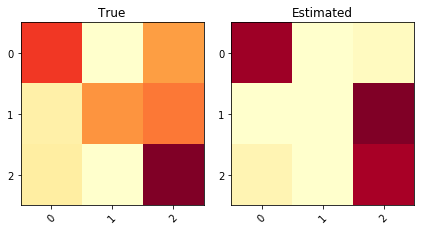

JS divergence: 0.1737	KL divergence: 2.3243


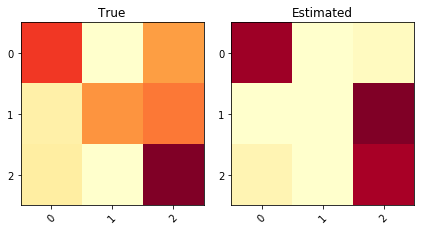

JS divergence: 0.1737	KL divergence: 2.3243


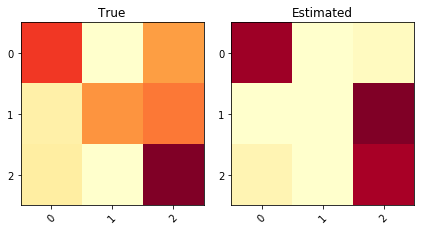

JS divergence: 0.1737	KL divergence: 2.3243


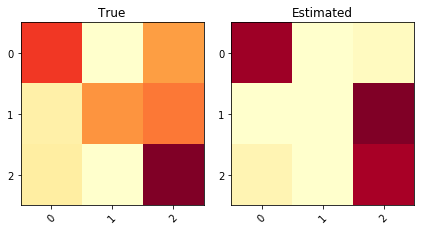

JS divergence: 0.1737	KL divergence: 2.3243
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS
====  ======  ==========  ============  =========  =========  ==========  ==========
   0  Global     0.62556       0.62556     2.7883    0.21251      2.7745    0.211839
====  ======  ==========  ============  =========  =========  ==========  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.650794      0.650794
====  ======  ==========  ============


In [15]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train


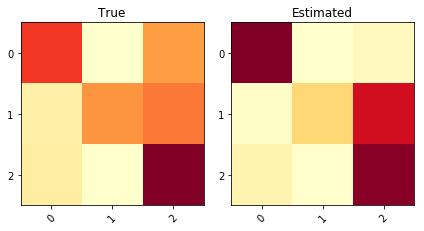

JS divergence: 0.0820	KL divergence: 0.1817


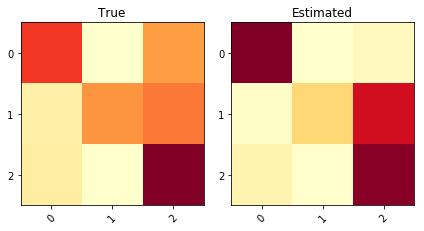

JS divergence: 0.0820	KL divergence: 0.1817


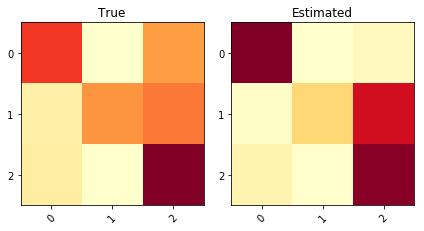

JS divergence: 0.0820	KL divergence: 0.1817


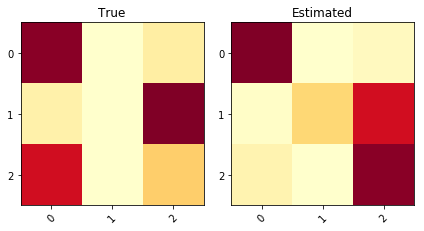

JS divergence: 0.1975	KL divergence: 0.4278


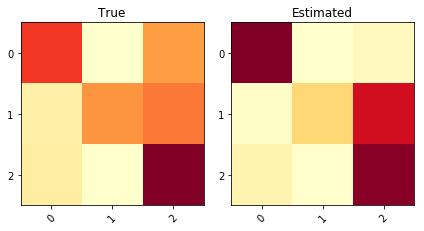

JS divergence: 0.0820	KL divergence: 0.1817


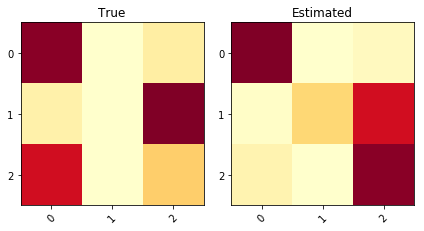

JS divergence: 0.1975	KL divergence: 0.4278


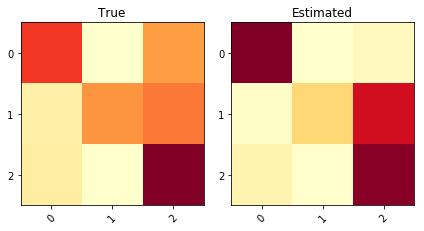

JS divergence: 0.0820	KL divergence: 0.1817


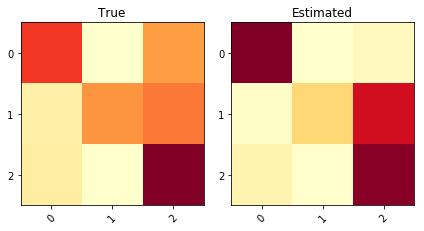

JS divergence: 0.0820	KL divergence: 0.1817


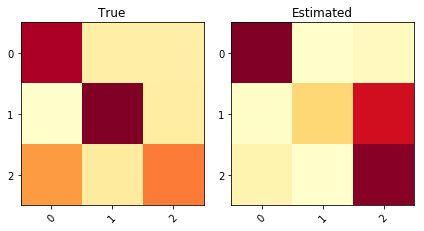

JS divergence: 0.2130	KL divergence: 1.3479


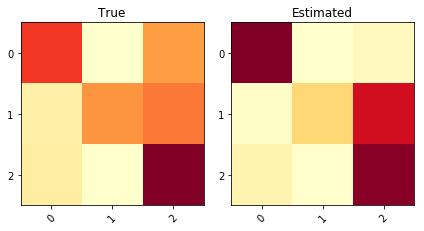

JS divergence: 0.0820	KL divergence: 0.1817


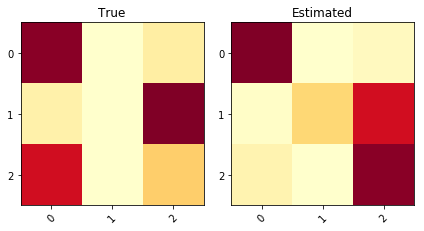

JS divergence: 0.1975	KL divergence: 0.4278


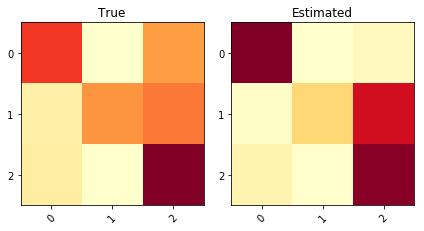

JS divergence: 0.0820	KL divergence: 0.1817


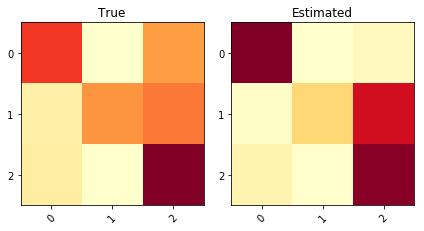

JS divergence: 0.0820	KL divergence: 0.1817


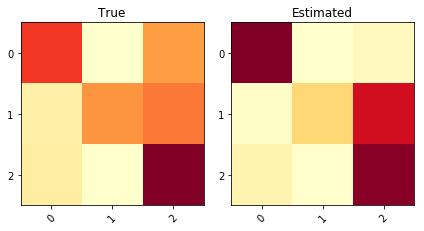

JS divergence: 0.0820	KL divergence: 0.1817


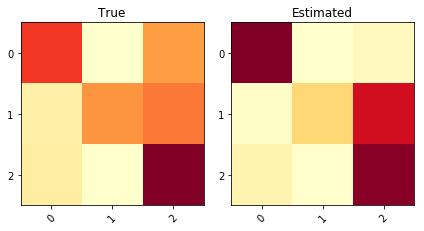

JS divergence: 0.0820	KL divergence: 0.1817
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS
====  ======  ==========  ============  =========  =========  ==========  ==========
   0  Global    0.703297      0.703297   0.496691   0.134102    0.493678    0.133896
====  ======  ==========  ============  =========  =========  ==========  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.709402      0.709402
====  ======  ==========  ============


In [19]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train


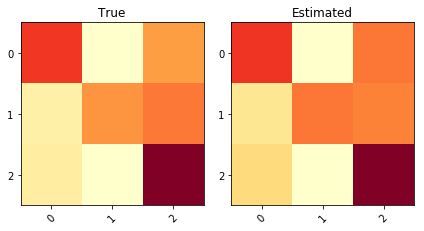

JS divergence: 0.0053	KL divergence: 0.0139


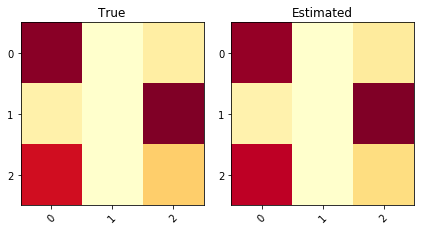

JS divergence: 0.0014	KL divergence: 0.0039


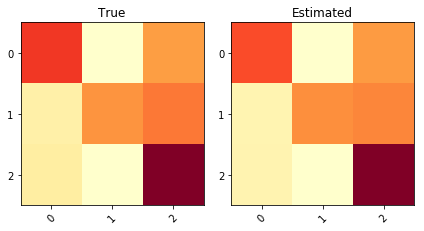

JS divergence: 0.0013	KL divergence: 0.0038


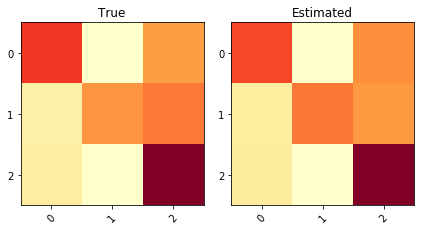

JS divergence: 0.0020	KL divergence: 0.0057


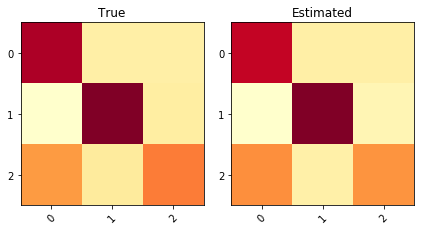

JS divergence: 0.0024	KL divergence: 0.0070


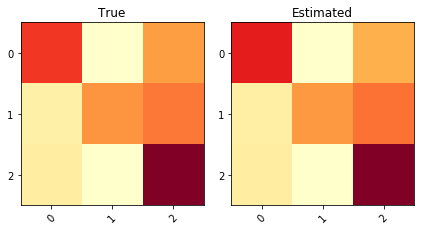

JS divergence: 0.0008	KL divergence: 0.0023


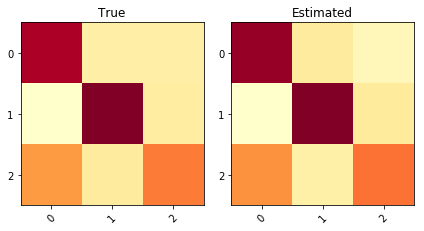

JS divergence: 0.0031	KL divergence: 0.0094


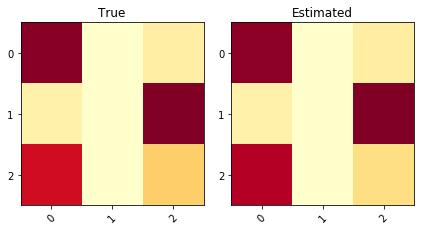

JS divergence: 0.0017	KL divergence: 0.0049


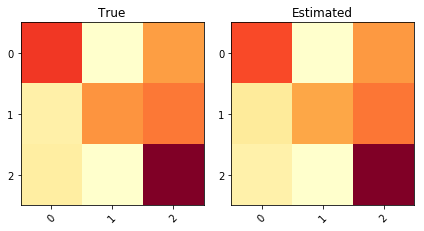

JS divergence: 0.0015	KL divergence: 0.0042


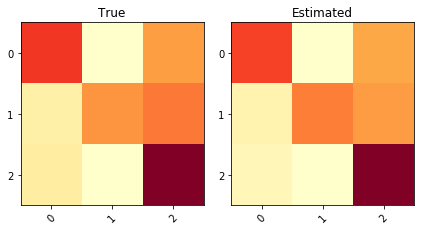

JS divergence: 0.0032	KL divergence: 0.0094


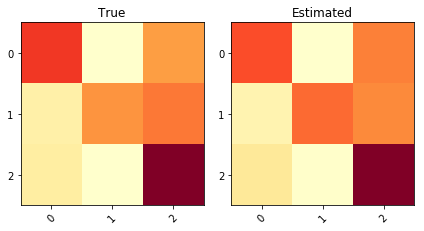

JS divergence: 0.0034	KL divergence: 0.0087


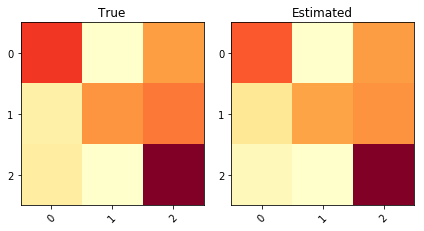

JS divergence: 0.0051	KL divergence: 0.0150


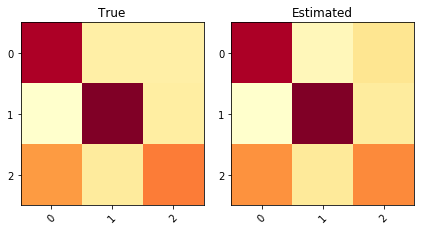

JS divergence: 0.0037	KL divergence: 0.0107


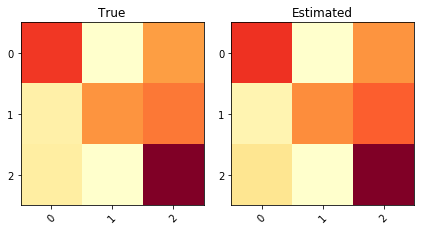

JS divergence: 0.0015	KL divergence: 0.0041


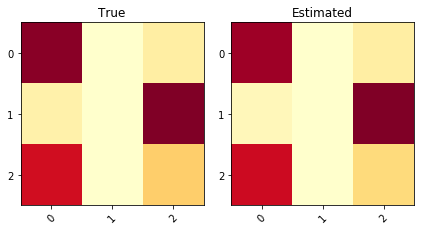

JS divergence: 0.0019	KL divergence: 0.0057
A result
 ====  ======  ==========  ============  =========  ==========  ==========  ==========
  ..            Accuracy    F1 (micro)    Mean KL     Mean JS    Wmean KL    Wmean JS
====  ======  ==========  ============  =========  ==========  ==========  ==========
   0  Global    0.931624      0.931624  0.0083941  0.00291665  0.00837058  0.00290923
====  ======  ==========  ============  =========  ==========  ==========  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.945055      0.945055
====  ======  ==========  ============


In [21]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


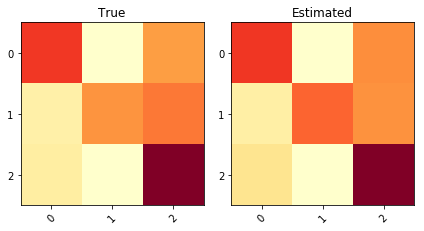

JS divergence: 0.0064	KL divergence: 0.0150


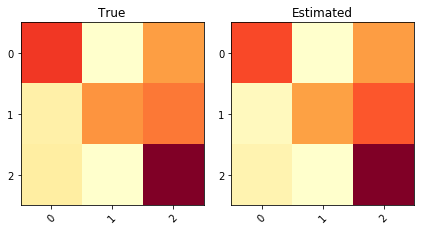

JS divergence: 0.0068	KL divergence: 0.0162


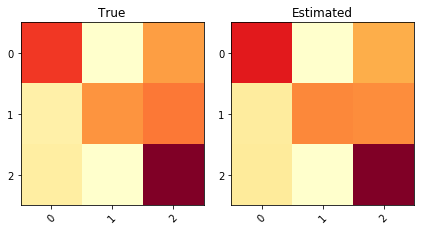

JS divergence: 0.0054	KL divergence: 0.0122


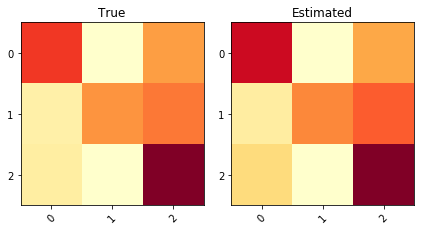

JS divergence: 0.0090	KL divergence: 0.0211


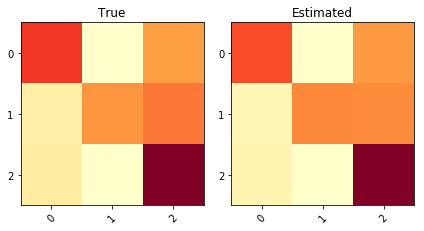

JS divergence: 0.0055	KL divergence: 0.0119


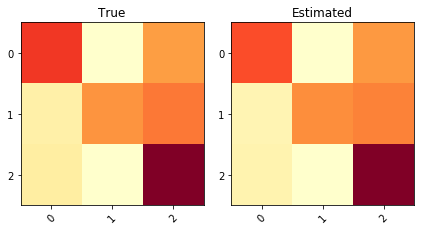

JS divergence: 0.0053	KL divergence: 0.0112


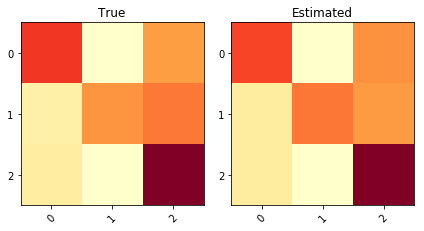

JS divergence: 0.0073	KL divergence: 0.0166


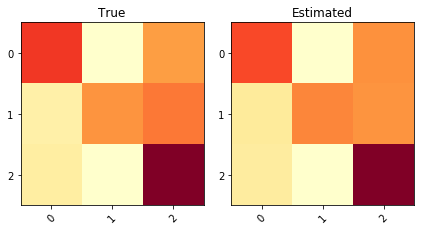

JS divergence: 0.0055	KL divergence: 0.0125


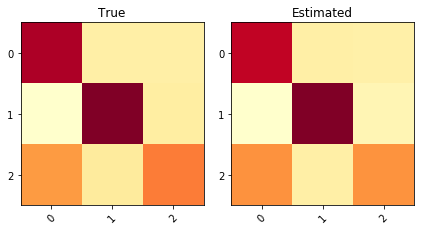

JS divergence: 0.0040	KL divergence: 0.0092


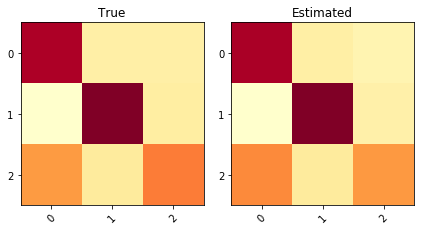

JS divergence: 0.0034	KL divergence: 0.0079


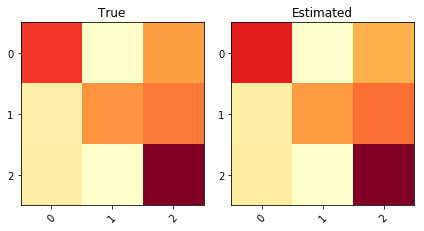

JS divergence: 0.0047	KL divergence: 0.0101


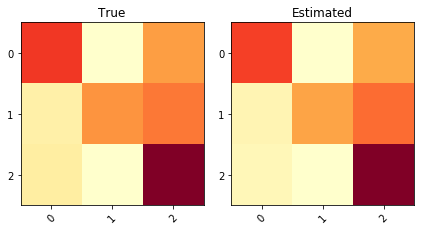

JS divergence: 0.0061	KL divergence: 0.0139


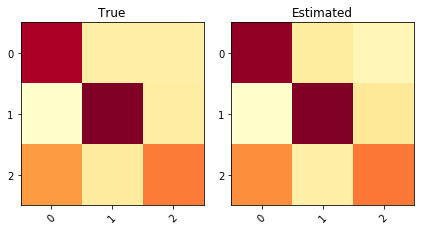

JS divergence: 0.0041	KL divergence: 0.0098


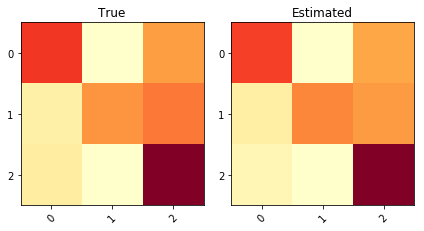

JS divergence: 0.0058	KL divergence: 0.0131


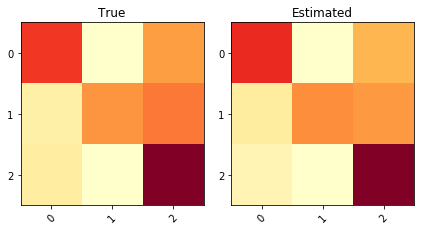

JS divergence: 0.0073	KL divergence: 0.0167
A result
 ====  ======  ==========  ============  =========  ==========  ==========  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean KL     Mean JS    Wmean KL    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  =========  ==========  ==========  ==========  ===========  ============
   0  Global    0.923891      0.923891  0.0151145  0.00655849   0.0150751  0.00654254     0.195996      0.195978
====  ======  ==========  ============  =========  ==========  ==========  ==========  ===========  ============
A result
 ====  ========================  ====================  =========================  =====================
  ..    Mean ACC imiting Annot    Mean cross-entropy    Wmean ACC imiting Annot    wMean cross entropy
====  ========================  ====================  =========================  =====================
   0                  0.660794              0.751884          

In [27]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train,data=Z_train_p)
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours Global multiples runs***
Train


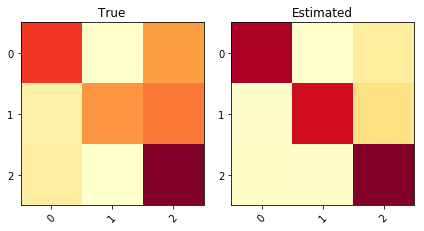

JS divergence: 0.0683	KL divergence: 0.2222


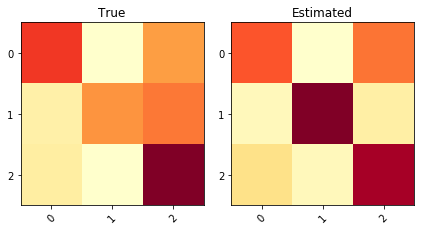

JS divergence: 0.0655	KL divergence: 0.1988


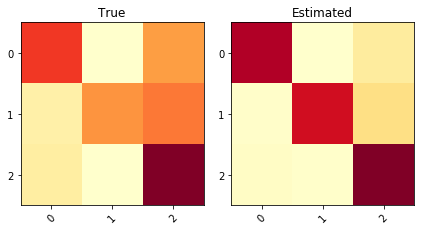

JS divergence: 0.0670	KL divergence: 0.2163


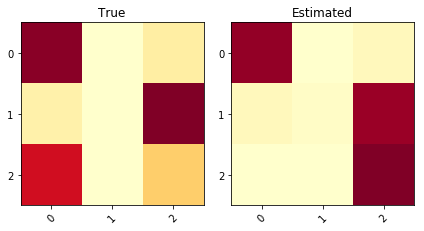

JS divergence: 0.1746	KL divergence: 0.8877


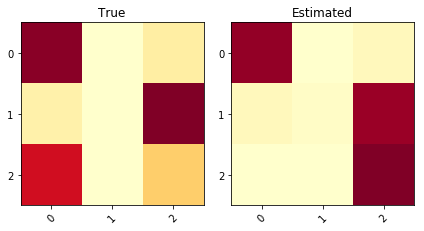

JS divergence: 0.1746	KL divergence: 0.8877


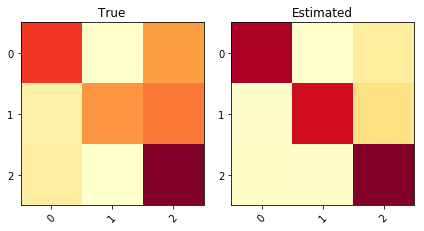

JS divergence: 0.0683	KL divergence: 0.2222


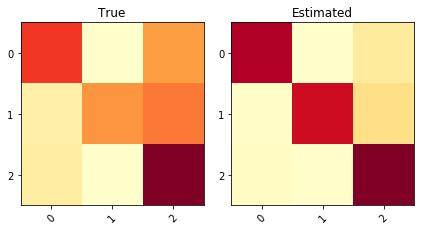

JS divergence: 0.0644	KL divergence: 0.2046


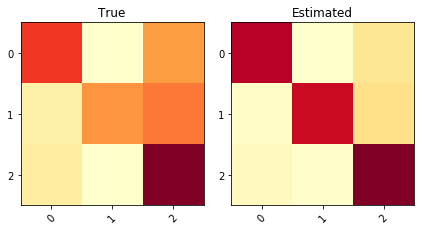

JS divergence: 0.0596	KL divergence: 0.1840


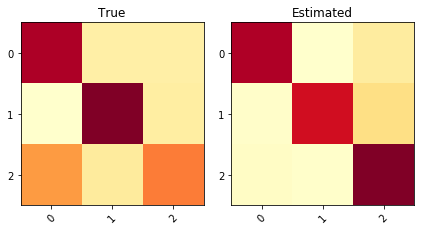

JS divergence: 0.1064	KL divergence: 0.4926


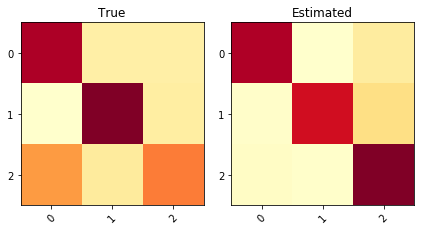

JS divergence: 0.1064	KL divergence: 0.4926


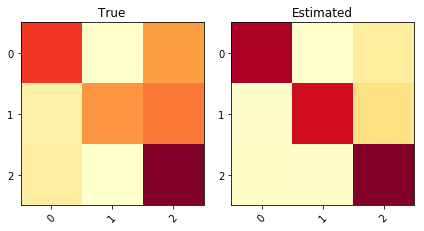

JS divergence: 0.0683	KL divergence: 0.2222


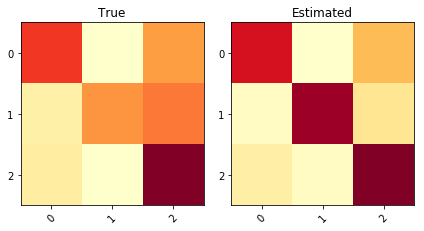

JS divergence: 0.0490	KL divergence: 0.1441


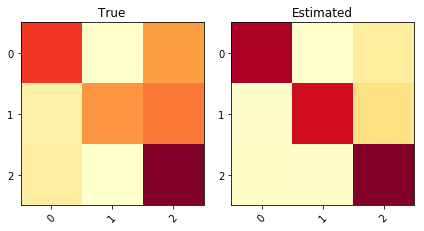

JS divergence: 0.0683	KL divergence: 0.2222


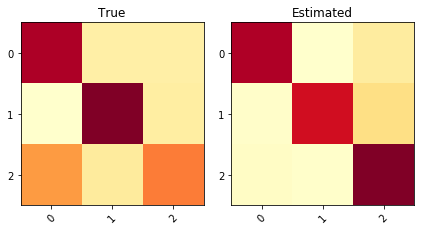

JS divergence: 0.1064	KL divergence: 0.4926


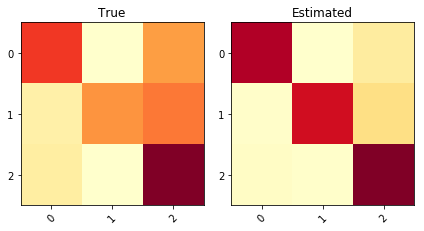

JS divergence: 0.0679	KL divergence: 0.2202
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
   0  Global    0.912902      0.912902   0.403862  0.0957129     0.40413   0.0957726     0.184758      0.185253
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
A result
 ====  ========================  ====================  =========================  =====================
  ..    Mean ACC imiting Annot    Mean cross-entropy    Wmean ACC imiting Annot    wMean cross entropy
====  ========================  ====================  =========================  =====================
   0                   0.63808              0.759294               

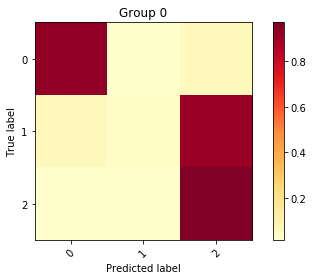

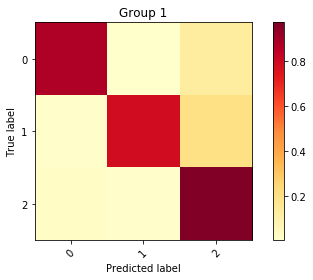

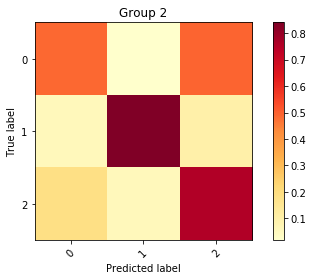

Inertia: 0.18246218079996082
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.152102      15   0.260368     0.644561   1.19358        0.543279   0.466842    0.64591       0.64591
   1         1  0.733007      73   0.369524     0.876827   0.135153       0.905141   0.81524     0.830281      0.830281
   2         2  0.114891      11   0.667949     0.69475    0.390185       0.740396   0.542125    0.604396      0.604396
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ========

In [31]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (1) multiples runs***
Train


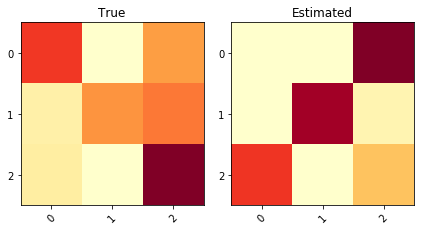

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


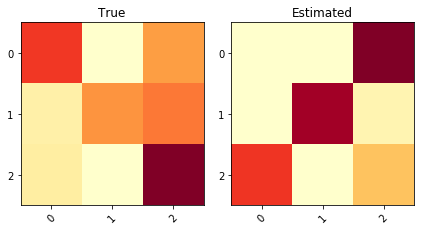

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


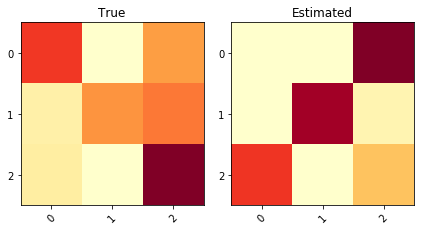

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


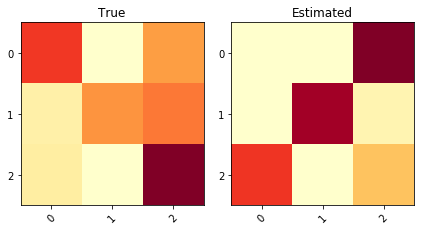

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


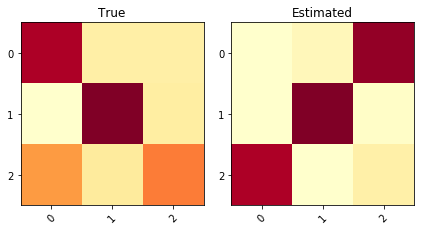

KL divergence: 1.5012	Pearson Correlation between diagonals: 0.5843


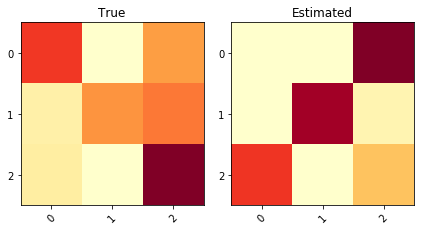

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


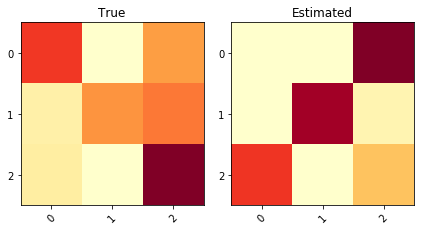

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


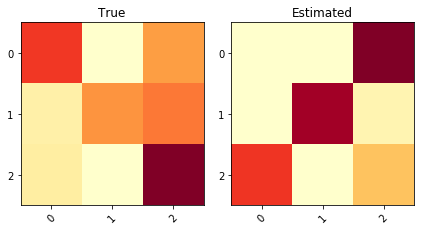

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


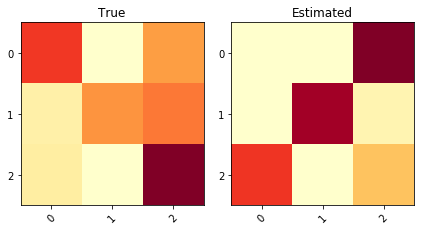

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


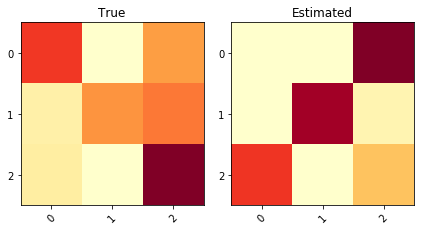

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


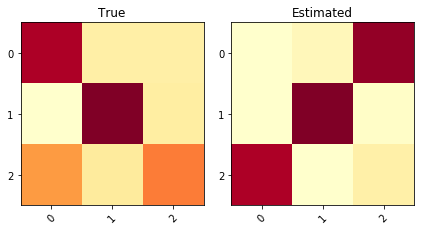

KL divergence: 1.5012	Pearson Correlation between diagonals: 0.5843


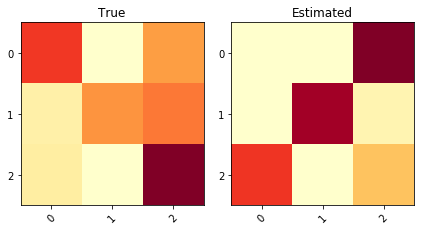

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


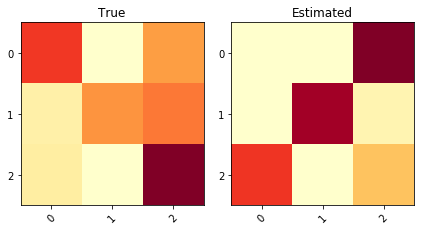

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


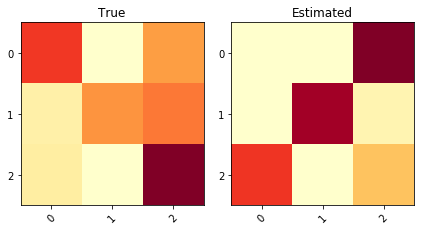

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455


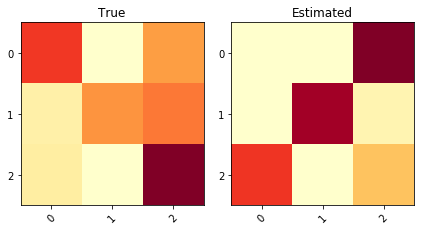

KL divergence: 1.4906	Pearson Correlation between diagonals: -0.5455
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.387464      0.387464    1.46138   0.203843           -0.344831       0.0975104
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.661312                0.727459
====  =======================  ======================
Test


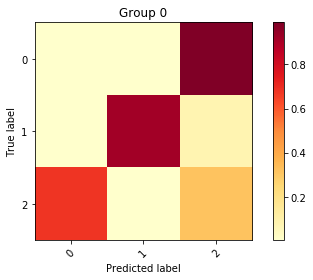

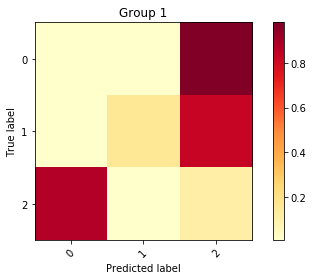

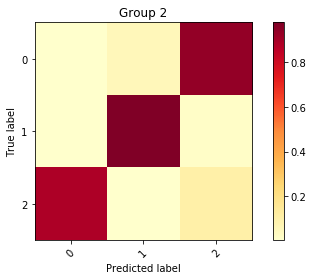

Inertia: 0.09433624582986037
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)     Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
   0         0  0.548259      54   0.332222    0.413273     2.34267       0.499222   0.0799397    0.802198      0.802198
   1         1  0.16093       16   0.34057     0.0939899    2.8462        0.213318  -0.239343     0.630037      0.630037
   2         2  0.290811      29   0.252397    0.363872     2.39851       0.424208   0.0305391    0.882784      0.882784
====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  

In [34]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


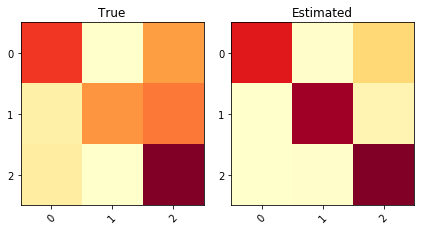

KL divergence: 0.4192	Pearson Correlation between diagonals: 0.3888


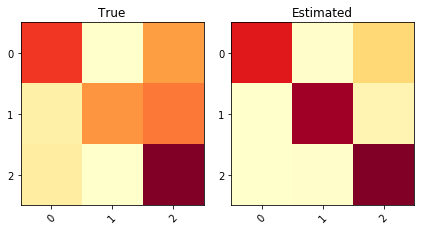

KL divergence: 0.4192	Pearson Correlation between diagonals: 0.3888


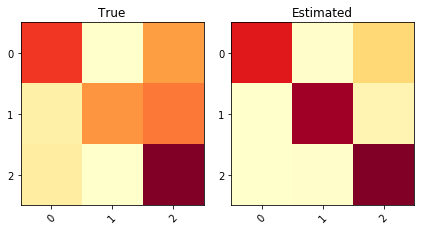

KL divergence: 0.4192	Pearson Correlation between diagonals: 0.3888


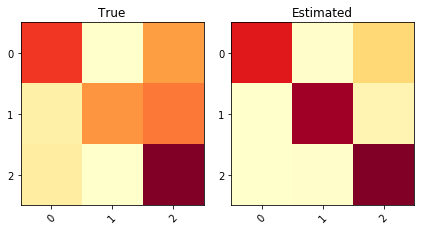

KL divergence: 0.4192	Pearson Correlation between diagonals: 0.3888


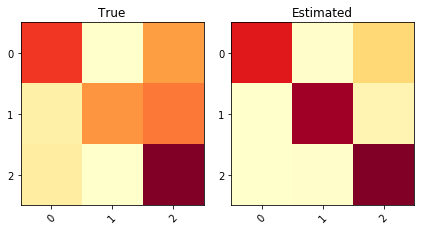

KL divergence: 0.4192	Pearson Correlation between diagonals: 0.3888


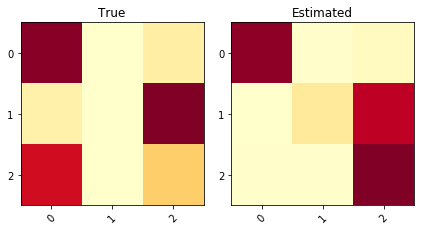

KL divergence: 1.1035	Pearson Correlation between diagonals: 0.6998


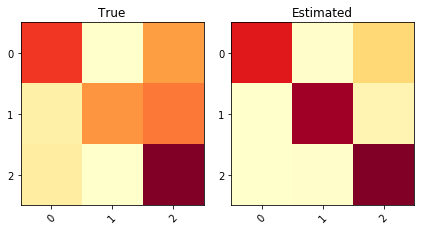

KL divergence: 0.4192	Pearson Correlation between diagonals: 0.3888


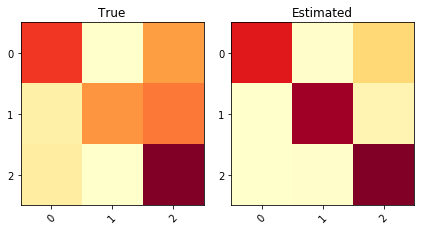

KL divergence: 0.4192	Pearson Correlation between diagonals: 0.3888


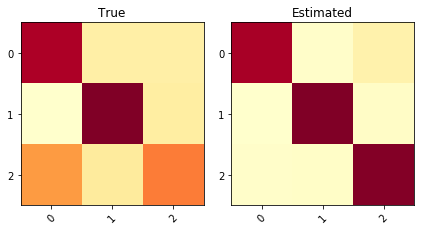

KL divergence: 0.5067	Pearson Correlation between diagonals: -0.2431


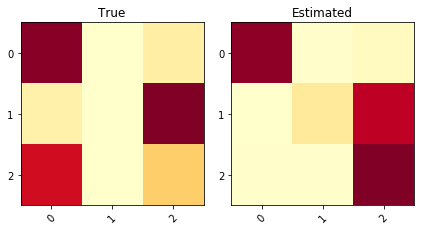

KL divergence: 1.1035	Pearson Correlation between diagonals: 0.6998


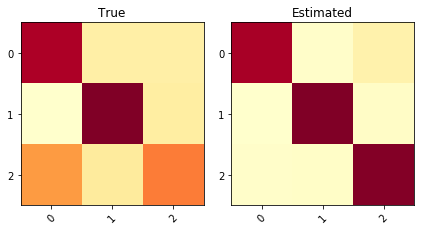

KL divergence: 0.5067	Pearson Correlation between diagonals: -0.2431


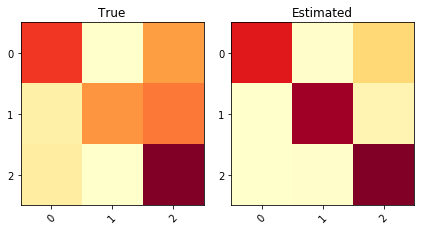

KL divergence: 0.4192	Pearson Correlation between diagonals: 0.3888


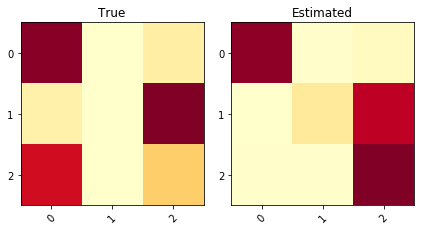

KL divergence: 1.1035	Pearson Correlation between diagonals: 0.6998


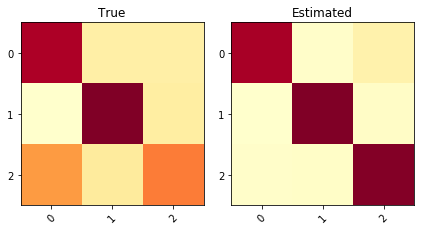

KL divergence: 0.5067	Pearson Correlation between diagonals: -0.2431


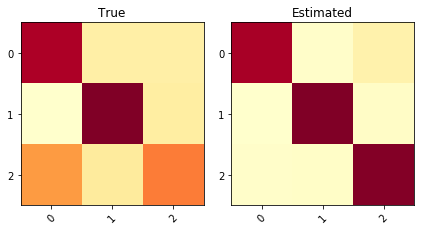

KL divergence: 0.5067	Pearson Correlation between diagonals: -0.2431
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.892552      0.892552   0.600229  0.0875265            0.289699       0.0963832
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.658511                 0.73373
====  =======================  ======================
Test


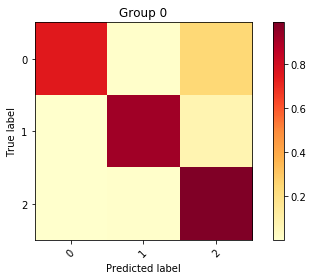

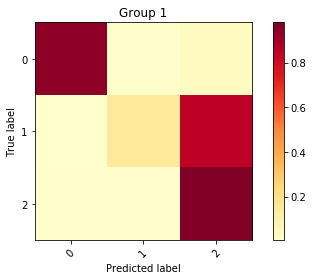

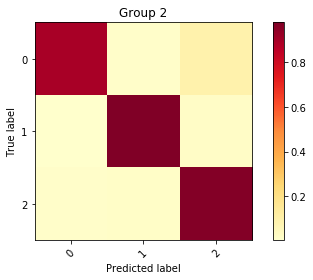

Inertia: 0.0972544342900316
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.544033      54   0.310449     0.8868    0.12712         0.938615   0.553466    0.84127       0.84127
   1         1  0.181161      18   0.261901     0.689919  0.675244        0.757545   0.356585    0.634921      0.634921
   2         2  0.274806      27   0.211517     0.948153  0.0540261       0.973305   0.614819    0.910867      0.910867
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =========

In [35]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 2) configuration: very bad MV ($T$ = 100, $T_{max}$ = 10 )

In [46]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.6133496133496134


In [ ]:
T_weights = np.sum(y_obs != -1,axis=0)

*** Soft-Majority (Train with softMV) ***
Train


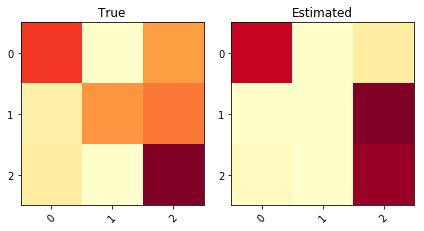

JS divergence: 0.1737	KL divergence: 2.3243


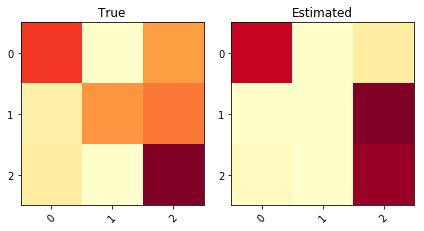

JS divergence: 0.1737	KL divergence: 2.3243


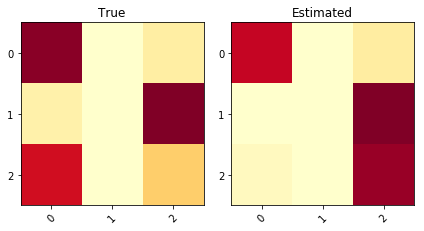

JS divergence: 0.1273	KL divergence: 0.2927


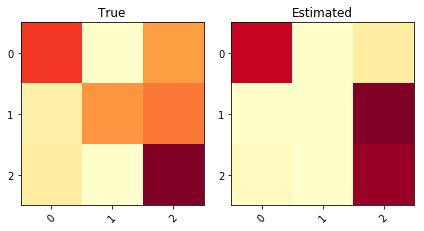

JS divergence: 0.1737	KL divergence: 2.3243


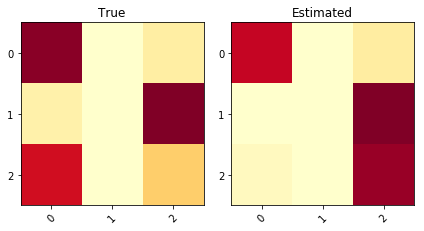

JS divergence: 0.1273	KL divergence: 0.2927


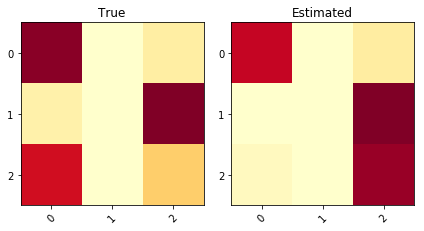

JS divergence: 0.1273	KL divergence: 0.2927


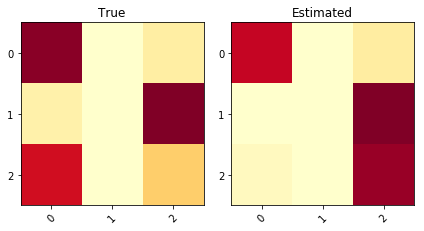

JS divergence: 0.1273	KL divergence: 0.2927


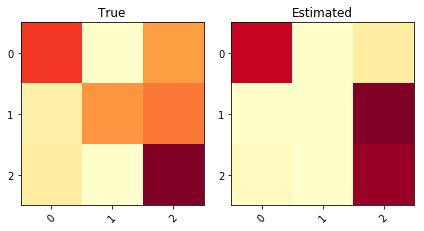

JS divergence: 0.1737	KL divergence: 2.3243


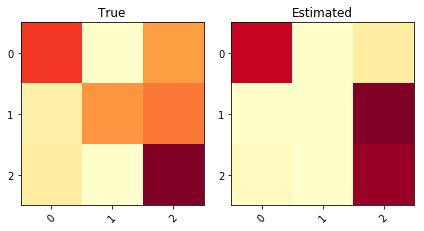

JS divergence: 0.1737	KL divergence: 2.3243


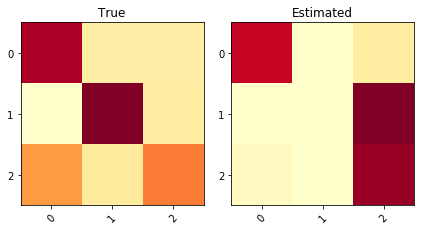

JS divergence: 0.3808	KL divergence: 6.0199


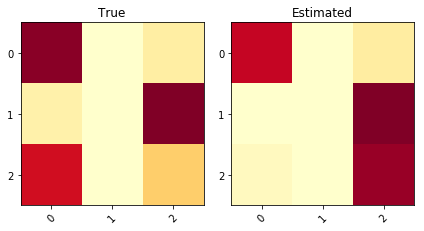

JS divergence: 0.1273	KL divergence: 0.2927


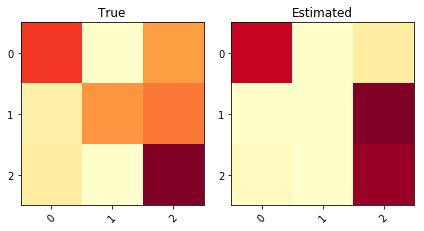

JS divergence: 0.1737	KL divergence: 2.3243


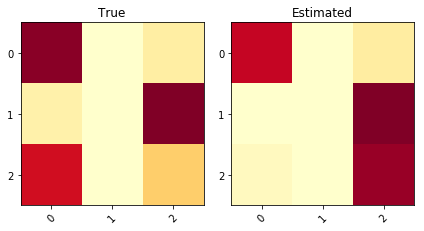

JS divergence: 0.1273	KL divergence: 0.2927


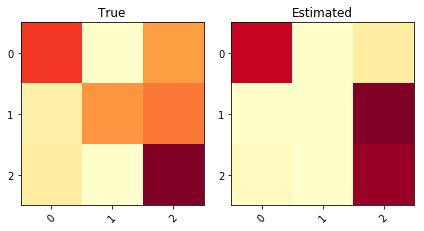

JS divergence: 0.1737	KL divergence: 2.3243


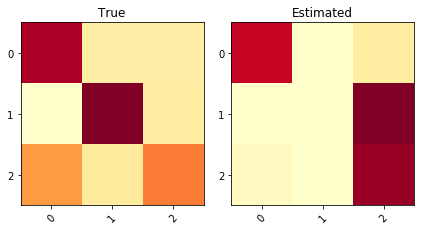

JS divergence: 0.3808	KL divergence: 6.0199
A result
 ====  ======  ==========  ============  =========  =========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS
====  ======  ==========  ============  =========  =========
   0  Global    0.606838      0.606838    2.25078   0.196564
====  ======  ==========  ============  =========  =========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.638584      0.638584
====  ======  ==========  ============


In [47]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train


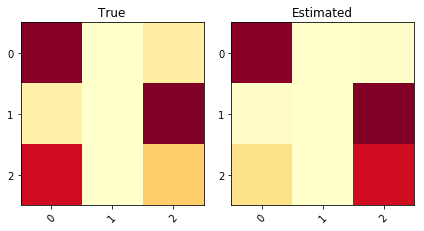

JS divergence: 0.1273	KL divergence: 0.2927


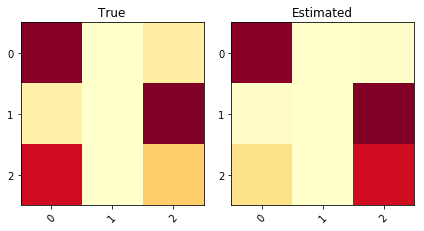

JS divergence: 0.1273	KL divergence: 0.2927


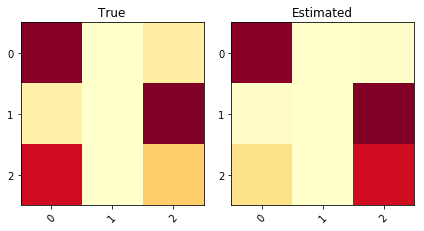

JS divergence: 0.1273	KL divergence: 0.2927


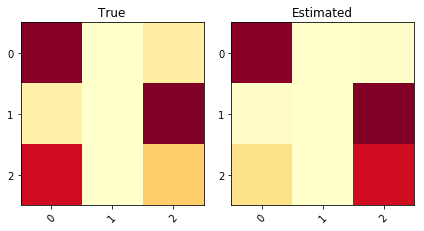

JS divergence: 0.1273	KL divergence: 0.2927


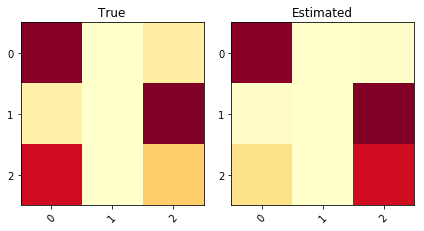

JS divergence: 0.1273	KL divergence: 0.2927


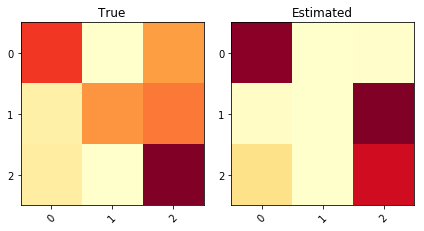

JS divergence: 0.1737	KL divergence: 2.3243


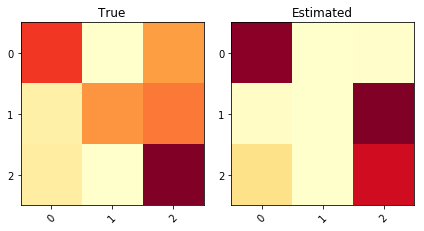

JS divergence: 0.1737	KL divergence: 2.3243


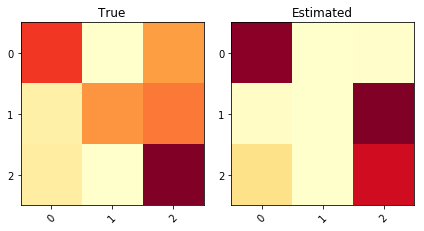

JS divergence: 0.1737	KL divergence: 2.3243


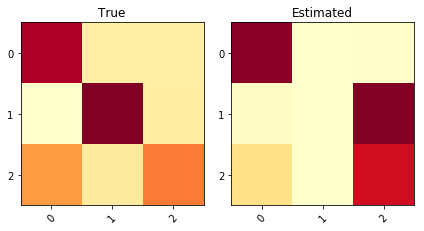

JS divergence: 0.3808	KL divergence: 6.0199


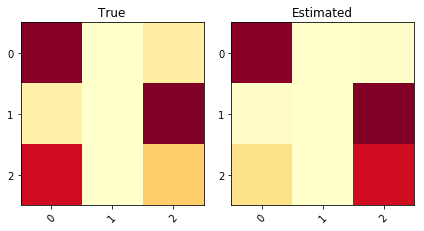

JS divergence: 0.1273	KL divergence: 0.2927


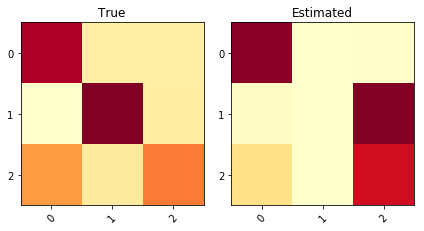

JS divergence: 0.3808	KL divergence: 6.0199


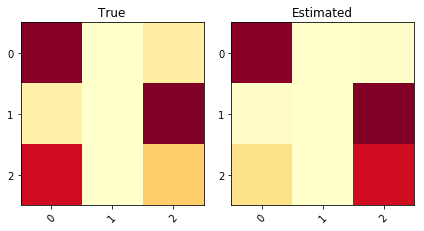

JS divergence: 0.1273	KL divergence: 0.2927


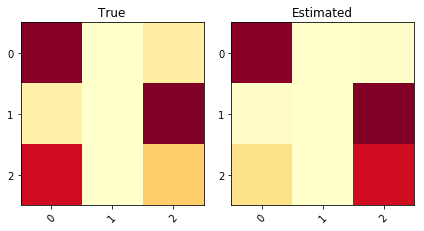

JS divergence: 0.1273	KL divergence: 0.2927


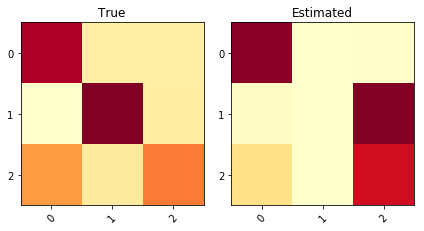

JS divergence: 0.3808	KL divergence: 6.0199


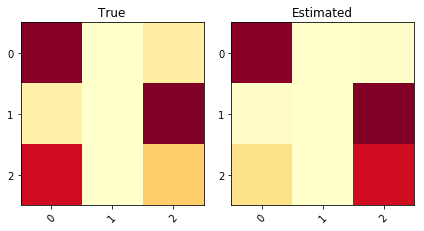

JS divergence: 0.1273	KL divergence: 0.2927
A result
 ====  ======  ==========  ============  =========  =========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS
====  ======  ==========  ============  =========  =========
   0  Global    0.595035      0.595035    2.25078   0.196564
====  ======  ==========  ============  =========  =========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.619048      0.619048
====  ======  ==========  ============


In [48]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train


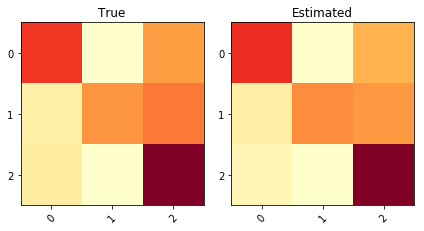

JS divergence: 0.0027	KL divergence: 0.0077


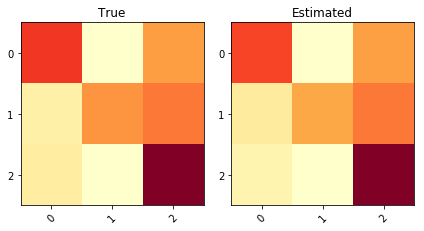

JS divergence: 0.0017	KL divergence: 0.0047


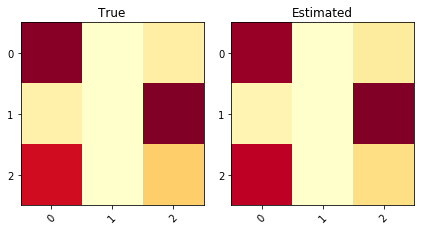

JS divergence: 0.0018	KL divergence: 0.0053


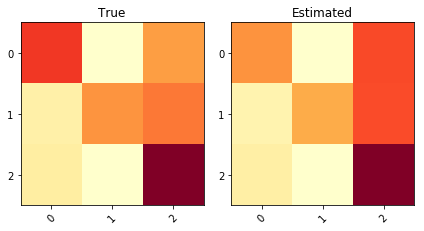

JS divergence: 0.0094	KL divergence: 0.0260


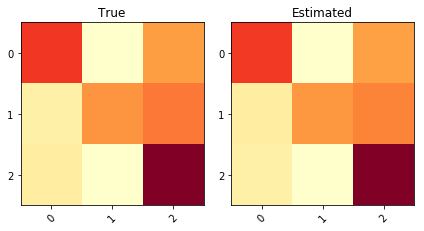

JS divergence: 0.0004	KL divergence: 0.0010


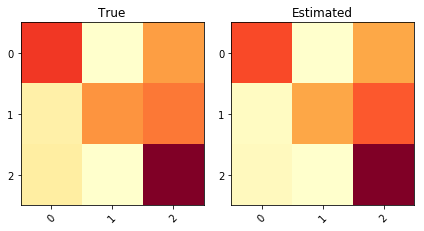

JS divergence: 0.0093	KL divergence: 0.0306


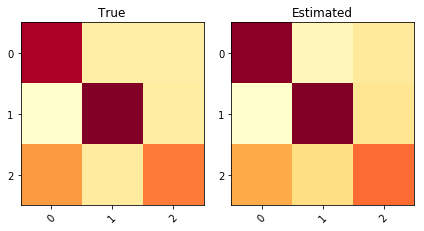

JS divergence: 0.0057	KL divergence: 0.0164


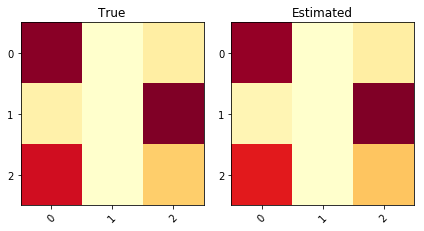

JS divergence: 0.0008	KL divergence: 0.0024


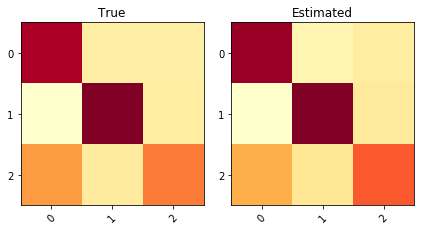

JS divergence: 0.0020	KL divergence: 0.0058


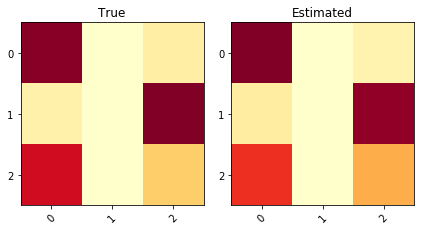

JS divergence: 0.0038	KL divergence: 0.0103


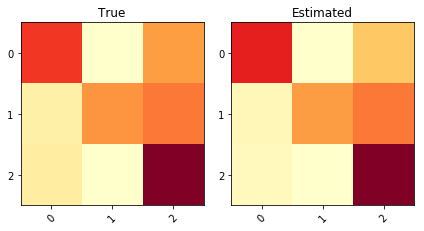

JS divergence: 0.0082	KL divergence: 0.0255


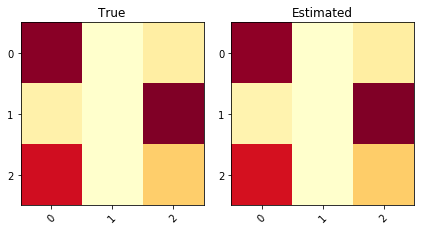

JS divergence: 0.0001	KL divergence: 0.0002


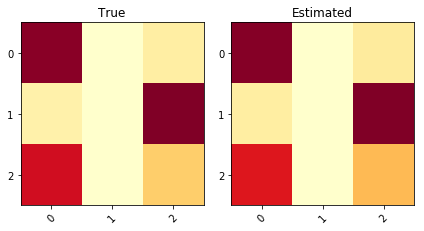

JS divergence: 0.0013	KL divergence: 0.0036


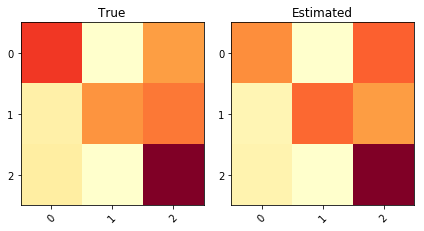

JS divergence: 0.0088	KL divergence: 0.0244


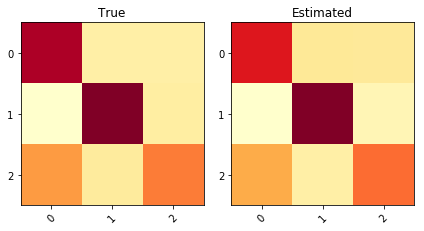

JS divergence: 0.0051	KL divergence: 0.0144
A result
 ====  ======  ==========  ============  =========  ==========
  ..            Accuracy    F1 (micro)    Mean KL     Mean JS
====  ======  ==========  ============  =========  ==========
   0  Global     0.92267       0.92267  0.0106255  0.00363264
====  ======  ==========  ============  =========  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.941392      0.941392
====  ======  ==========  ============


In [49]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


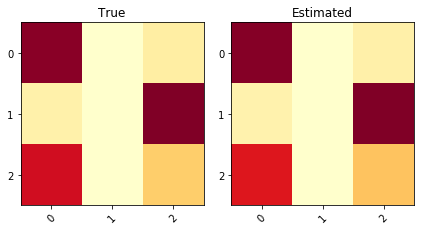

JS divergence: 0.0066	Norm Frobenius: 0.0215


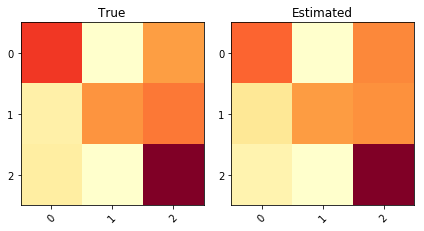

JS divergence: 0.0075	Norm Frobenius: 0.0439


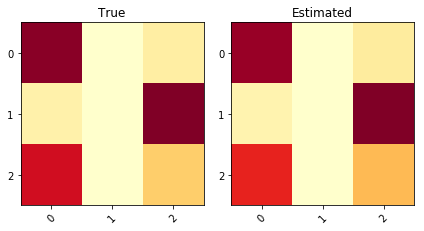

JS divergence: 0.0077	Norm Frobenius: 0.0374


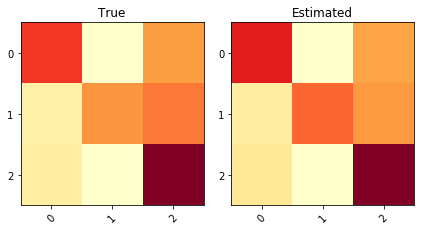

JS divergence: 0.0071	Norm Frobenius: 0.0468


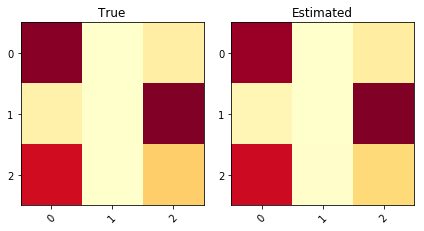

JS divergence: 0.0070	Norm Frobenius: 0.0188


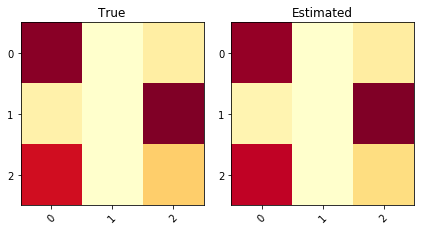

JS divergence: 0.0068	Norm Frobenius: 0.0263


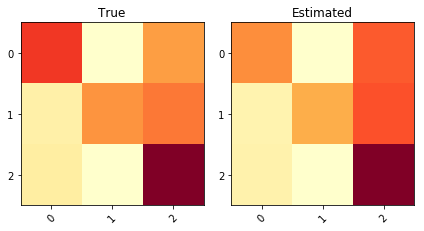

JS divergence: 0.0109	Norm Frobenius: 0.0800


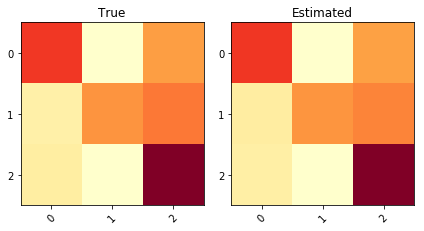

JS divergence: 0.0048	Norm Frobenius: 0.0149


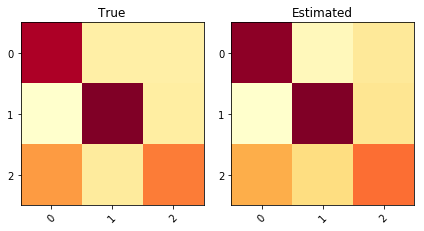

JS divergence: 0.0078	Norm Frobenius: 0.0445


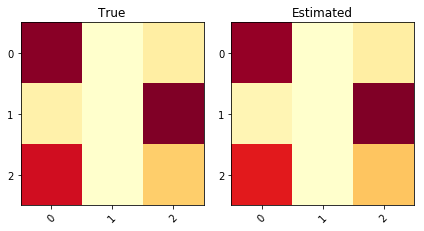

JS divergence: 0.0065	Norm Frobenius: 0.0235


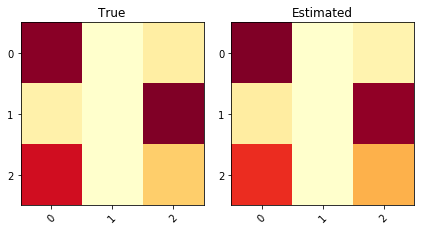

JS divergence: 0.0093	Norm Frobenius: 0.0494


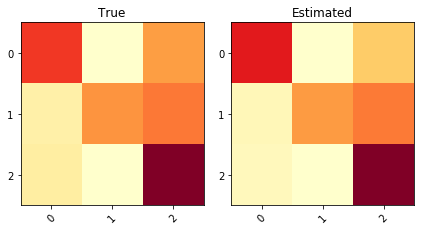

JS divergence: 0.0104	Norm Frobenius: 0.0569


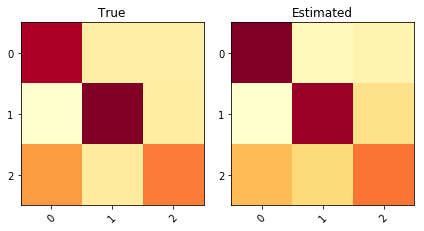

JS divergence: 0.0105	Norm Frobenius: 0.0606


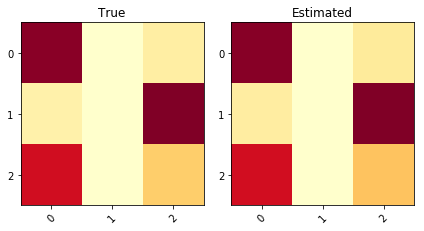

JS divergence: 0.0069	Norm Frobenius: 0.0278


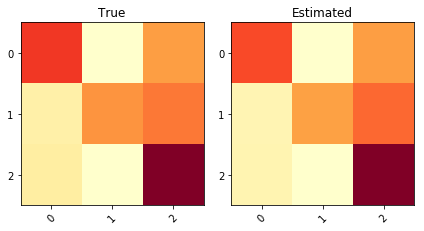

JS divergence: 0.0053	Norm Frobenius: 0.0221
A result
 ====  ======  ==========  ============  ============  ==========  =============  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean NormF     Mean JS    Wmean NormF    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  ============  ==========  =============  ==========  ===========  ============
   0  Global     0.90232       0.90232     0.0369939  0.00736071      0.0368951  0.00732726     0.106023      0.106495
====  ======  ==========  ============  ============  ==========  =============  ==========  ===========  ============
A result
 ====  ========================  ====================  =========================  =====================
  ..    Mean ACC imiting Annot    Mean cross-entropy    Wmean ACC imiting Annot    wMean cross entropy
====  ========================  ====================  =========================  =====================
   0                  0.710322 

In [96]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train,data=Z_train_p)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours Global multiples runs***
Train


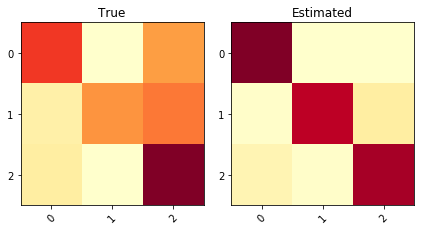

JS divergence: 0.1290	Norm Frobenius: 0.2652


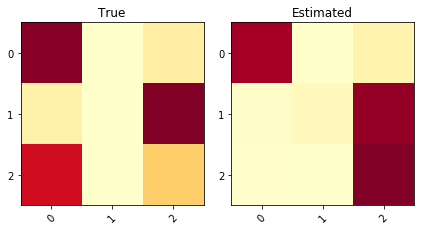

JS divergence: 0.1794	Norm Frobenius: 0.3428


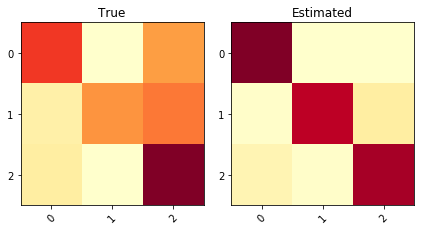

JS divergence: 0.1290	Norm Frobenius: 0.2652


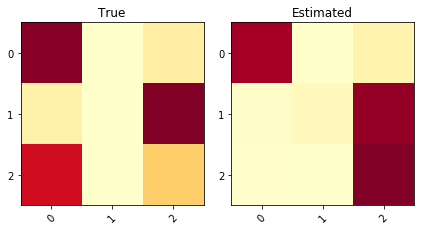

JS divergence: 0.1794	Norm Frobenius: 0.3428


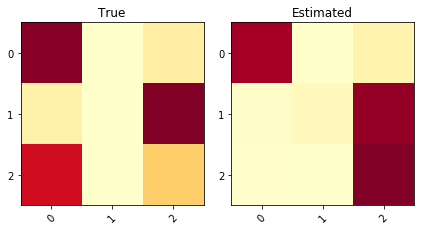

JS divergence: 0.1794	Norm Frobenius: 0.3428


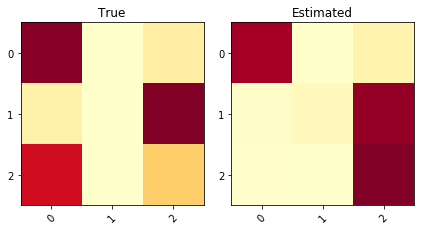

JS divergence: 0.1794	Norm Frobenius: 0.3428


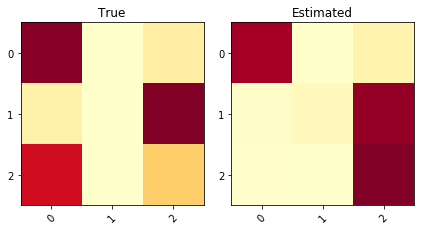

JS divergence: 0.1794	Norm Frobenius: 0.3428


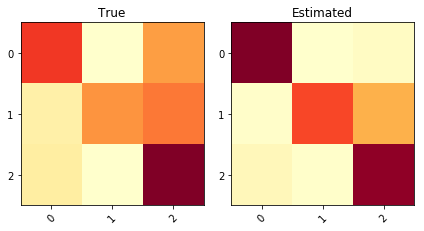

JS divergence: 0.0728	Norm Frobenius: 0.1888


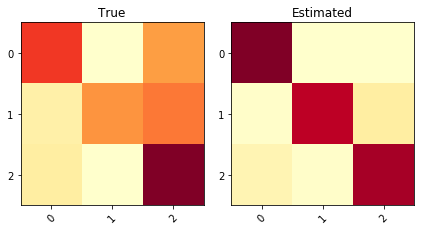

JS divergence: 0.1290	Norm Frobenius: 0.2652


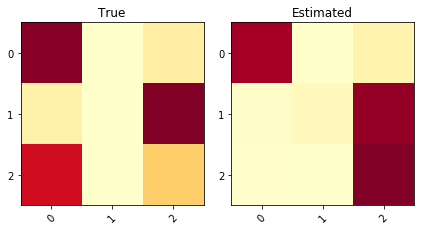

JS divergence: 0.1794	Norm Frobenius: 0.3428


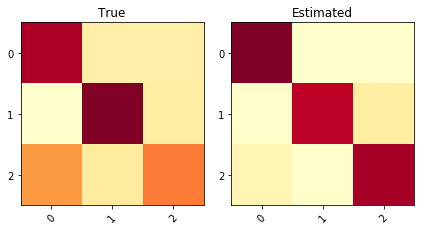

JS divergence: 0.0870	Norm Frobenius: 0.2001


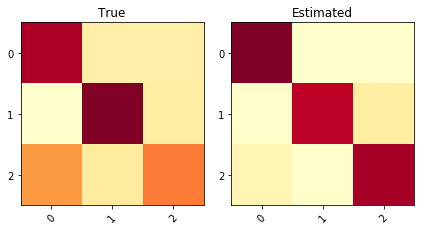

JS divergence: 0.0870	Norm Frobenius: 0.2001


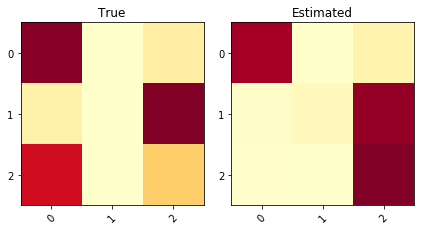

JS divergence: 0.1794	Norm Frobenius: 0.3428


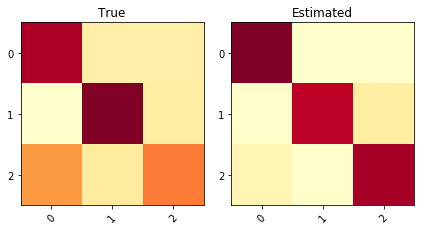

JS divergence: 0.0870	Norm Frobenius: 0.2001


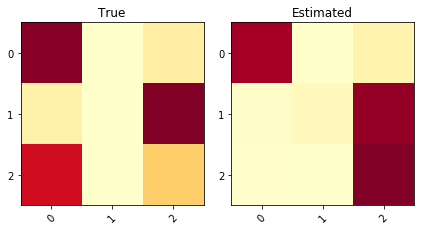

JS divergence: 0.1794	Norm Frobenius: 0.3428
A result
 ====  ======  ==========  ============  ============  =========  =============  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean NormF    Mean JS    Wmean NormF    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  ============  =========  =============  ==========  ===========  ============
   0  Global     0.75987       0.75987      0.282453   0.139601       0.282524    0.139664     0.141965      0.141354
====  ======  ==========  ============  ============  =========  =============  ==========  ===========  ============
A result
 ====  ========================  ====================  =========================  =====================
  ..    Mean ACC imiting Annot    Mean cross-entropy    Wmean ACC imiting Annot    wMean cross entropy
====  ========================  ====================  =========================  =====================
   0                  0.596078      

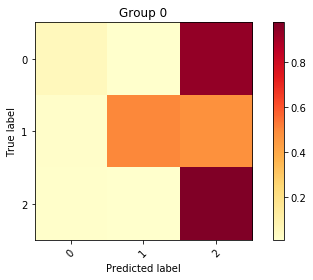

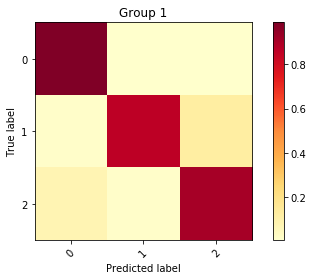

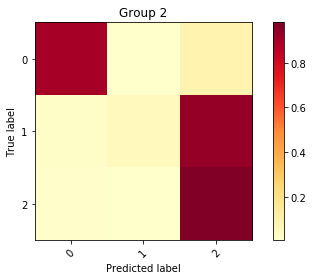

Inertia: 0.2702955622431502
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.1597        15   0.38426      0.510541  1.23118         0.435628   0.265811    0.333333      0.333333
   1         1  0.613959      61   0.275868     0.923181  0.0814426       0.942234   0.884772    0.622711      0.622711
   2         2  0.226341      22   0.244949     0.643394  1.06068         0.556556   0.465091    0.622711      0.622711
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ========

In [99]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (1) multiples runs***
Train


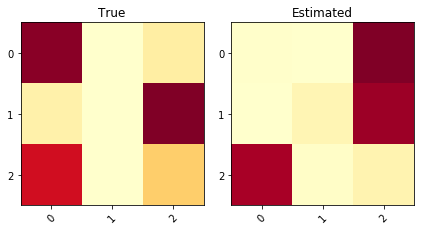

KL divergence: 1.4579	Pearson Correlation between diagonals: -0.9181


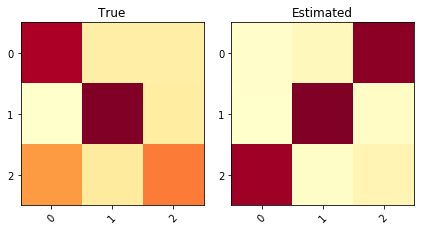

KL divergence: 1.5499	Pearson Correlation between diagonals: 0.6093


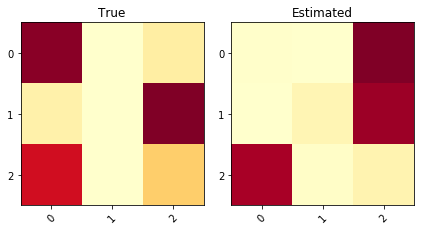

KL divergence: 1.4579	Pearson Correlation between diagonals: -0.9181


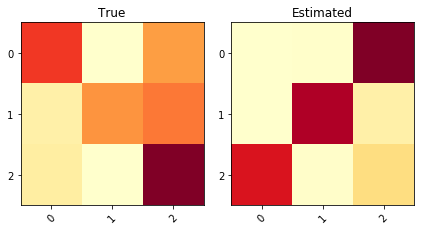

KL divergence: 1.5264	Pearson Correlation between diagonals: -0.6341


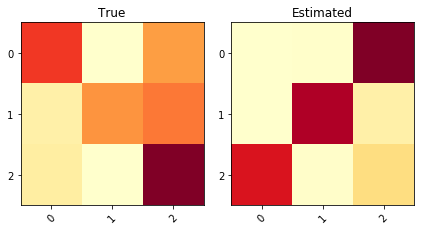

KL divergence: 1.5264	Pearson Correlation between diagonals: -0.6341


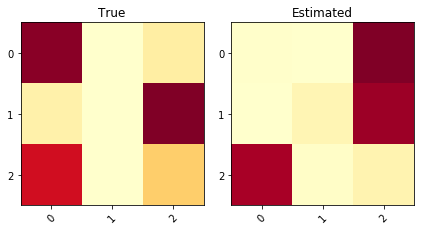

KL divergence: 1.4579	Pearson Correlation between diagonals: -0.9181


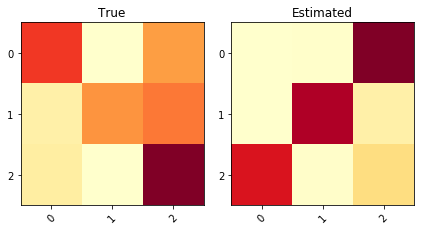

KL divergence: 1.5264	Pearson Correlation between diagonals: -0.6341


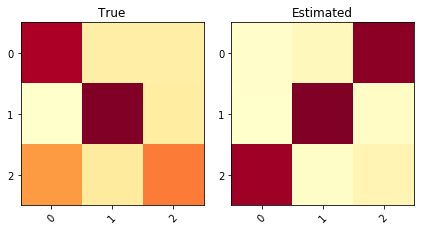

KL divergence: 1.5499	Pearson Correlation between diagonals: 0.6093


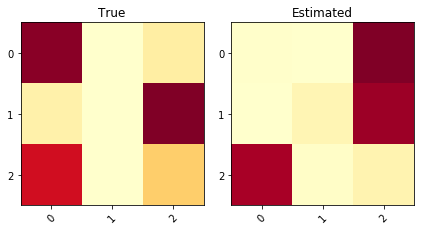

KL divergence: 1.4579	Pearson Correlation between diagonals: -0.9181


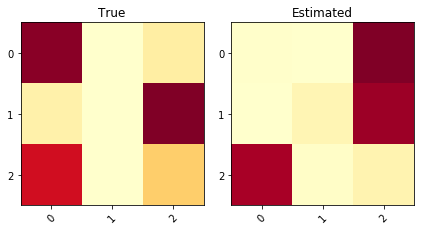

KL divergence: 1.4579	Pearson Correlation between diagonals: -0.9181


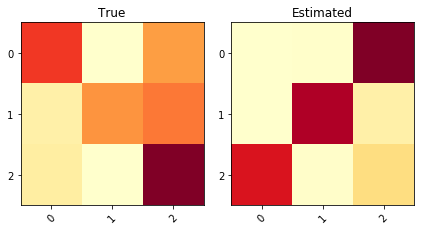

KL divergence: 1.5264	Pearson Correlation between diagonals: -0.6341


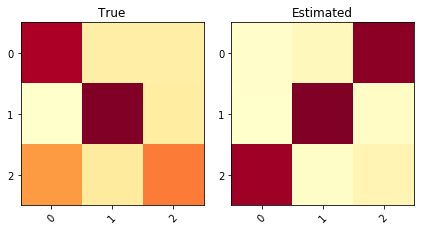

KL divergence: 1.5499	Pearson Correlation between diagonals: 0.6093


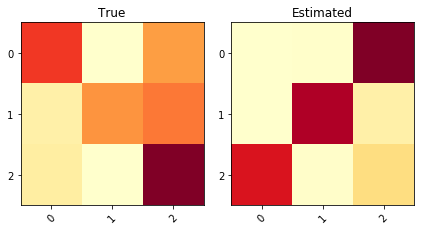

KL divergence: 1.5264	Pearson Correlation between diagonals: -0.6341


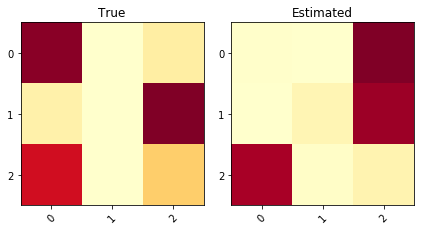

KL divergence: 1.4579	Pearson Correlation between diagonals: -0.9181


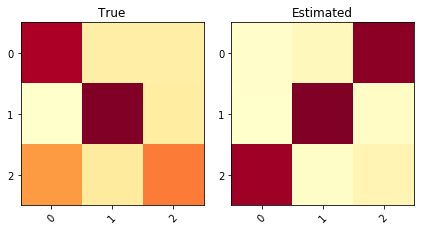

KL divergence: 1.5499	Pearson Correlation between diagonals: 0.6093
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.597884      0.597884     1.5097   0.208986           -0.348053        0.148848
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.680813                0.703747
====  =======================  ======================
Test


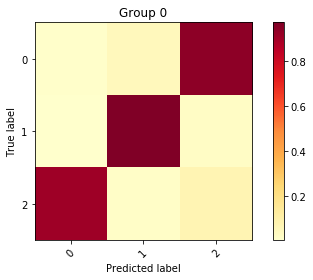

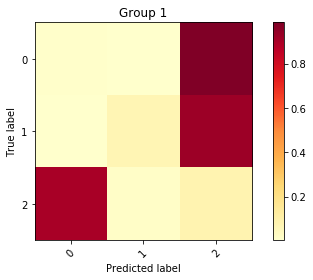

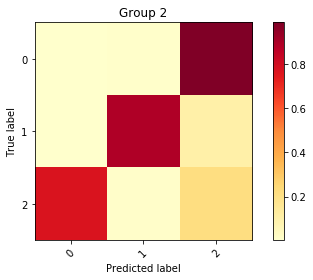

Inertia: 0.10848995065316558
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)     Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
   0         0  0.326825      32   0.232576    0.351229     2.55813       0.402764   0.0178953    0.711844      0.711844
   1         1  0.286561      28   0.236939    0.0529269    3.31976       0.14267   -0.280406     0.565324      0.565324
   2         2  0.386613      38   0.336965    0.371128     2.42394       0.457802   0.0377947    0.896215      0.896215
====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  

In [59]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


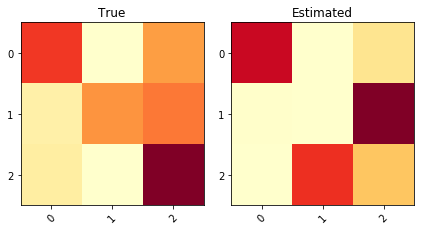

KL divergence: 1.0953	Pearson Correlation between diagonals: 0.2469


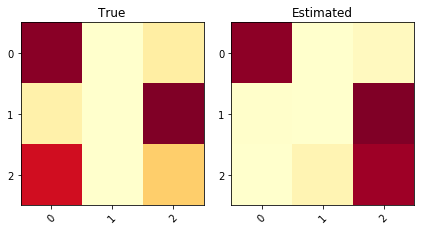

KL divergence: 1.3390	Pearson Correlation between diagonals: 0.7449


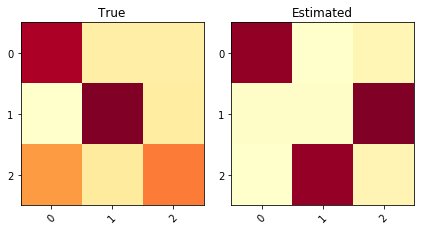

KL divergence: 2.1118	Pearson Correlation between diagonals: 0.2715


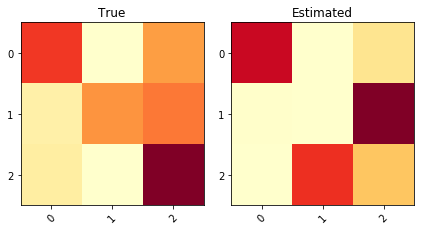

KL divergence: 1.0953	Pearson Correlation between diagonals: 0.2469


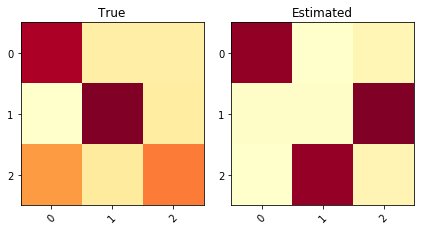

KL divergence: 2.1118	Pearson Correlation between diagonals: 0.2715


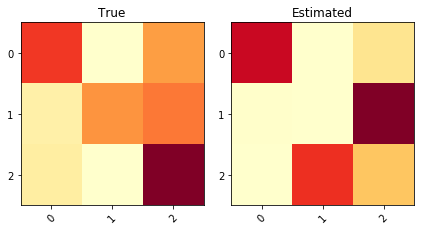

KL divergence: 1.0953	Pearson Correlation between diagonals: 0.2469


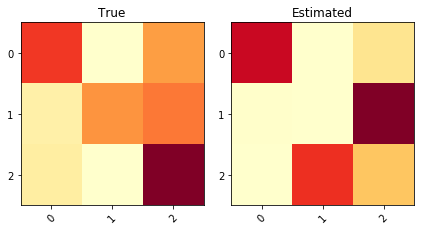

KL divergence: 1.0953	Pearson Correlation between diagonals: 0.2469


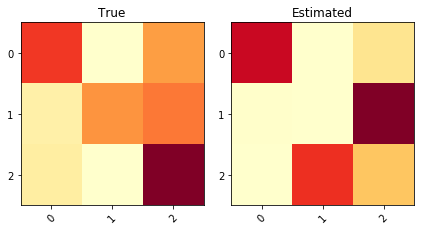

KL divergence: 1.0953	Pearson Correlation between diagonals: 0.2469


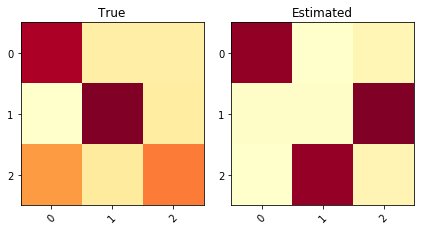

KL divergence: 2.1118	Pearson Correlation between diagonals: 0.2715


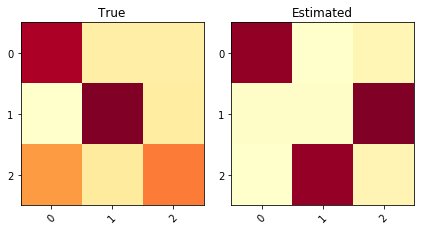

KL divergence: 2.1118	Pearson Correlation between diagonals: 0.2715


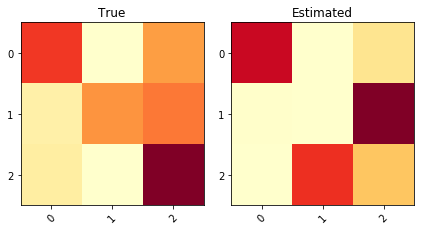

KL divergence: 1.0953	Pearson Correlation between diagonals: 0.2469


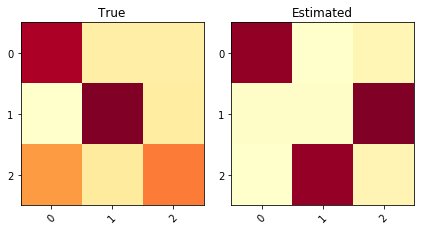

KL divergence: 2.1118	Pearson Correlation between diagonals: 0.2715


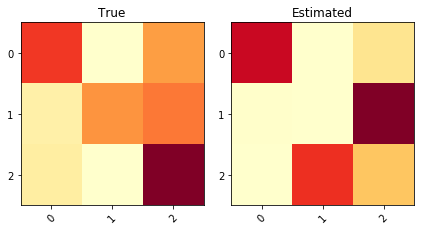

KL divergence: 1.0953	Pearson Correlation between diagonals: 0.2469


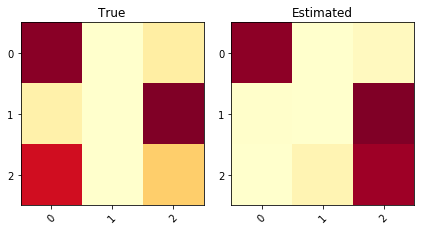

KL divergence: 1.3390	Pearson Correlation between diagonals: 0.7449


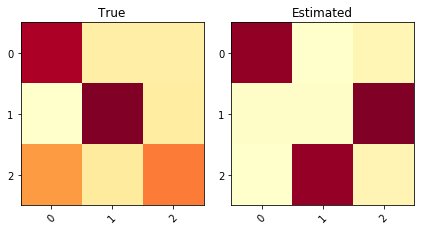

KL divergence: 2.1118	Pearson Correlation between diagonals: 0.2715
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.350834      0.350834     1.4957   0.205557            0.428808        0.150335
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.677046                0.699032
====  =======================  ======================
Test


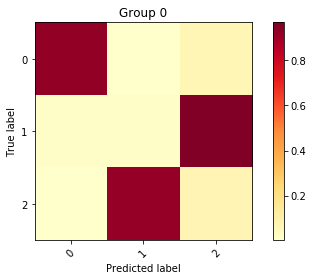

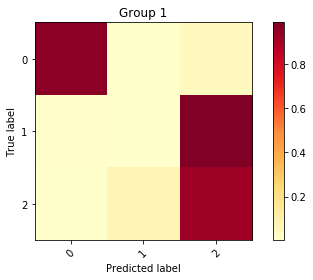

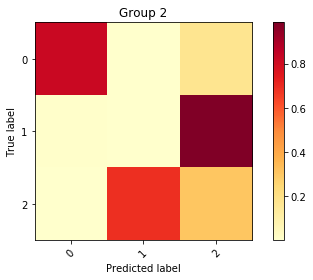

Inertia: 0.08358287128309409
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.300226      30   0.236477     0.338454    2.29225       0.403617  0.0051209    0.808303      0.808303
   1         1  0.337198      33   0.176395     0.628844    1.98815       0.651583  0.29551      0.579976      0.579976
   2         2  0.362576      36   0.398023     0.378613    2.25763       0.48055   0.0452801    0.796093      0.796093
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =======

In [60]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 3) configuration: normal soft ($T$ = 100, $T_{max}$ = 10, soft clustering )

In [27]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.7802197802197802


*** Soft-Majority (Train with softMV) ***
Train


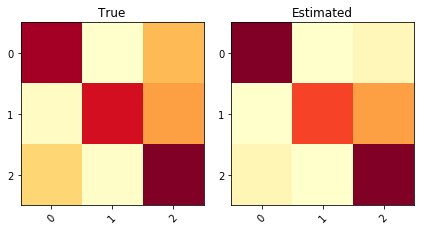

JS divergence: 0.1240	KL divergence: 0.3989


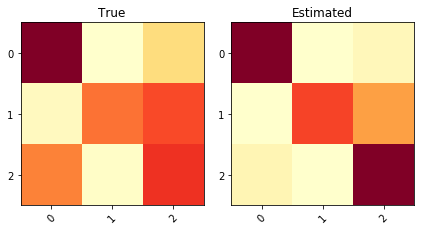

JS divergence: 0.1151	KL divergence: 0.3568


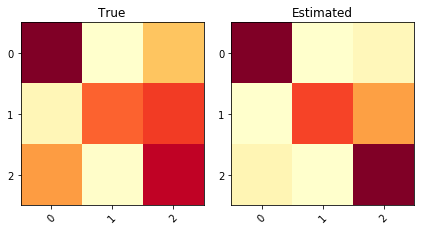

JS divergence: 0.1122	KL divergence: 0.3187


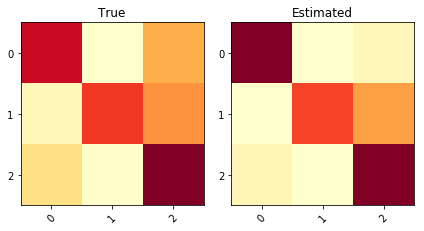

JS divergence: 0.1260	KL divergence: 0.3539


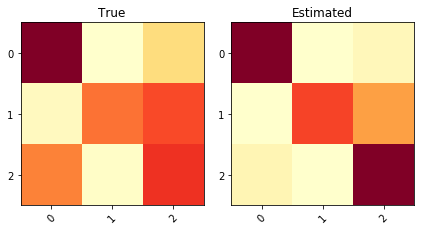

JS divergence: 0.1151	KL divergence: 0.3568


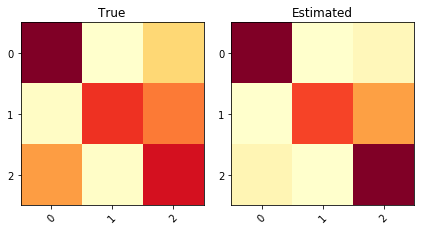

JS divergence: 0.1147	KL divergence: 0.3834


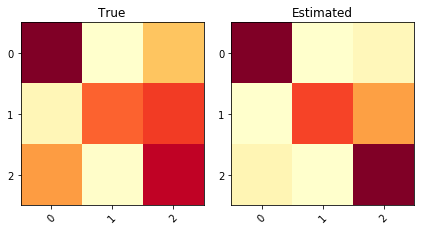

JS divergence: 0.1122	KL divergence: 0.3187


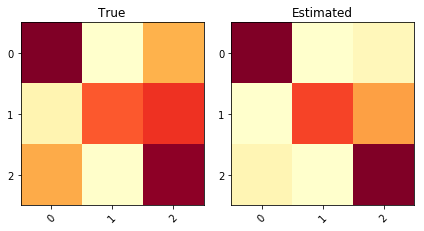

JS divergence: 0.1138	KL divergence: 0.3036


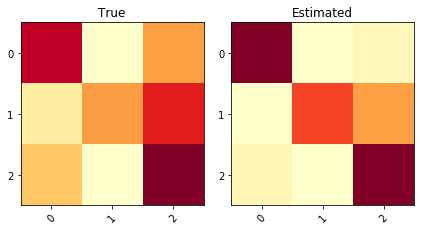

JS divergence: 0.1314	KL divergence: 0.2688


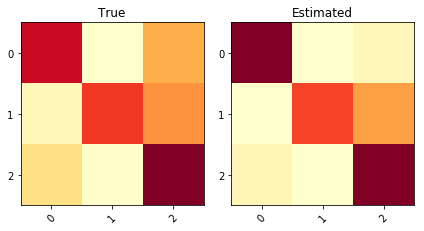

JS divergence: 0.1260	KL divergence: 0.3539


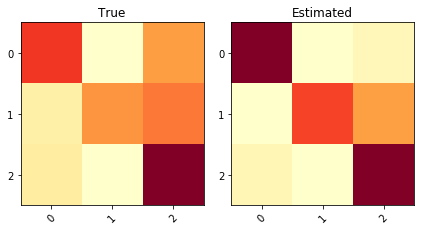

JS divergence: 0.1525	KL divergence: 0.3169


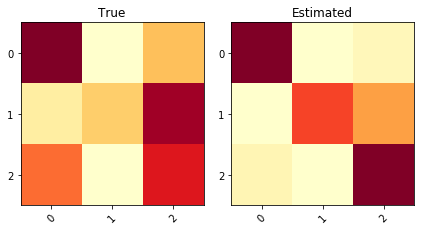

JS divergence: 0.1391	KL divergence: 0.2847


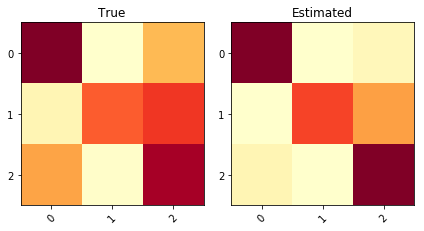

JS divergence: 0.1128	KL divergence: 0.3096


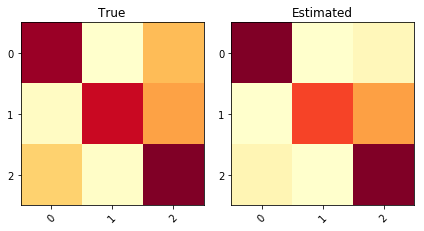

JS divergence: 0.1243	KL divergence: 0.4096


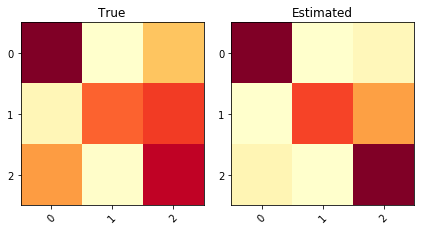

JS divergence: 0.1122	KL divergence: 0.3187
A result
 ====  ======  ==========  ============  =========  =========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS
====  ======  ==========  ============  =========  =========
   0  Global    0.826211      0.826211   0.368424   0.138044
====  ======  ==========  ============  =========  =========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.815629      0.815629
====  ======  ==========  ============


In [21]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train


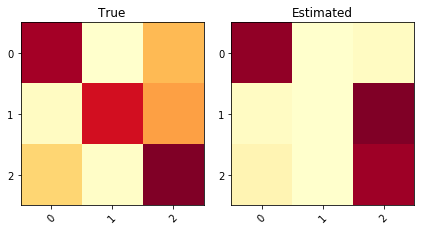

JS divergence: 0.2154	KL divergence: 3.5992


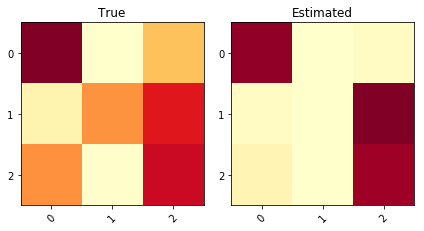

JS divergence: 0.1417	KL divergence: 2.0715


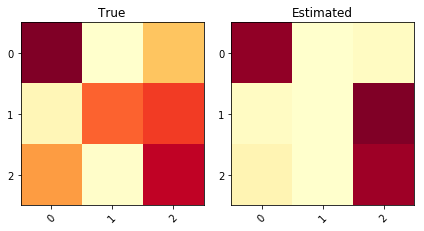

JS divergence: 0.1624	KL divergence: 2.5519


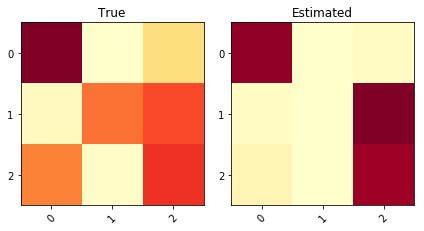

JS divergence: 0.1729	KL divergence: 2.6653


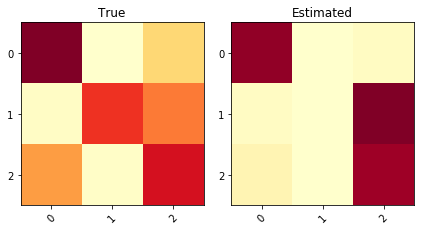

JS divergence: 0.1944	KL divergence: 3.2077


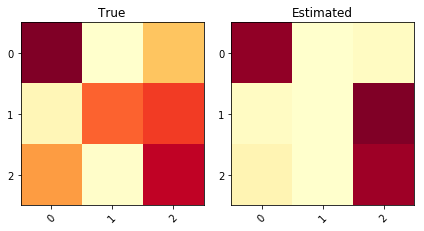

JS divergence: 0.1624	KL divergence: 2.5519


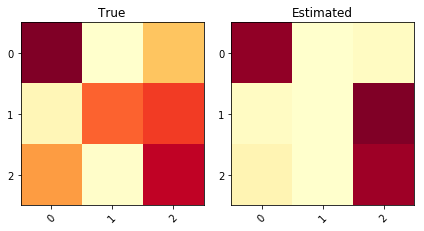

JS divergence: 0.1624	KL divergence: 2.5519


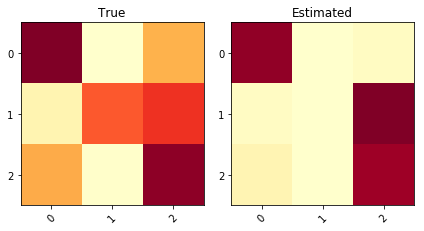

JS divergence: 0.1593	KL divergence: 2.4917


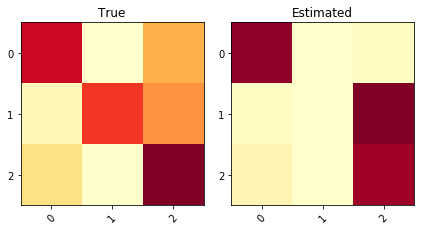

JS divergence: 0.1975	KL divergence: 3.1566


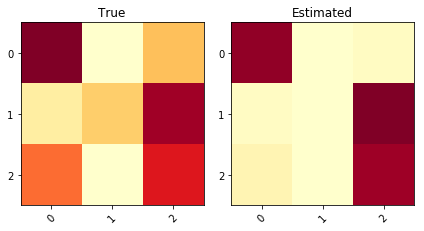

JS divergence: 0.1047	KL divergence: 1.1533


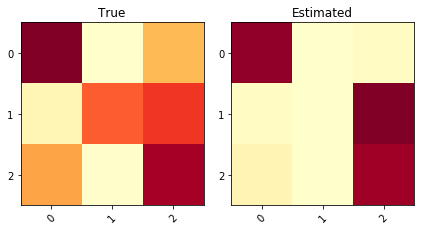

JS divergence: 0.1604	KL divergence: 2.5177


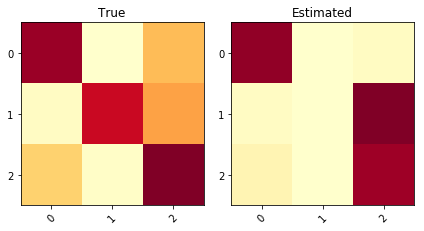

JS divergence: 0.2194	KL divergence: 3.6894


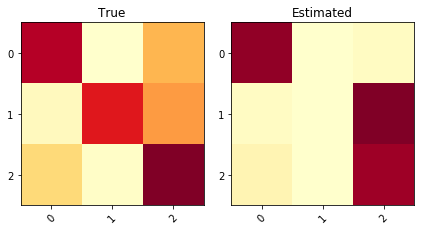

JS divergence: 0.2090	KL divergence: 3.4502


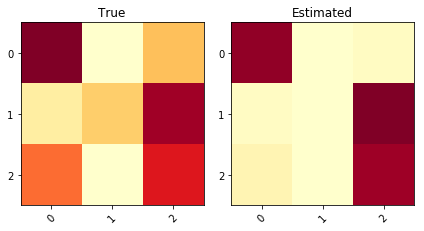

JS divergence: 0.1047	KL divergence: 1.1533


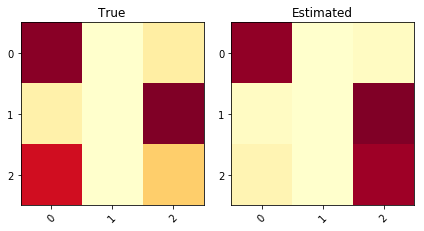

JS divergence: 0.1273	KL divergence: 0.2927
A result
 ====  ======  ==========  ============  =========  =========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS
====  ======  ==========  ============  =========  =========
   0  Global    0.627188      0.627188    2.59514   0.176469
====  ======  ==========  ============  =========  =========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.652015      0.652015
====  ======  ==========  ============


In [22]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train


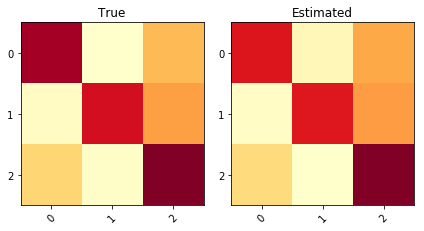

JS divergence: 0.0033	KL divergence: 0.0088


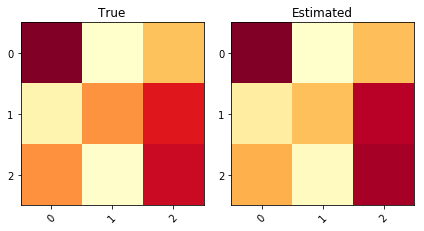

JS divergence: 0.0065	KL divergence: 0.0179


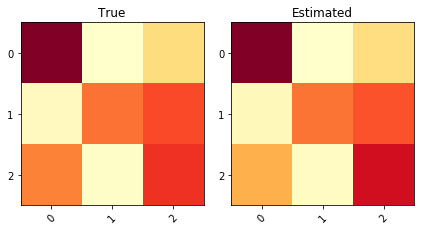

JS divergence: 0.0097	KL divergence: 0.1361


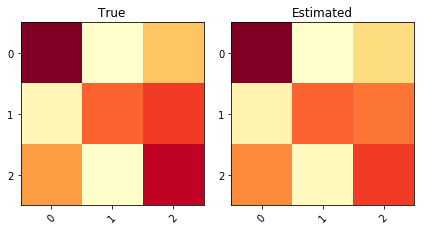

JS divergence: 0.0053	KL divergence: 0.0143


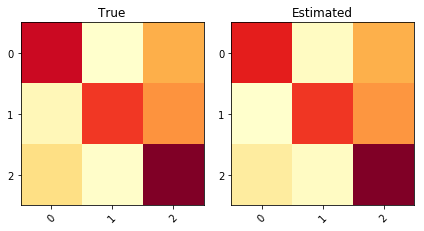

JS divergence: 0.0054	KL divergence: 0.0163


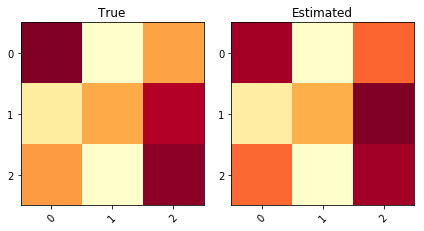

JS divergence: 0.0036	KL divergence: 0.0097


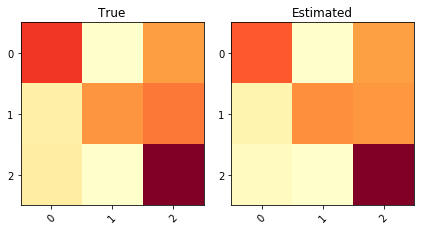

JS divergence: 0.0059	KL divergence: 0.0195


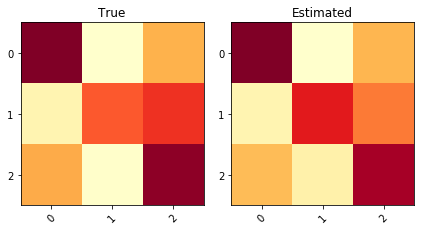

JS divergence: 0.0098	KL divergence: 0.0501


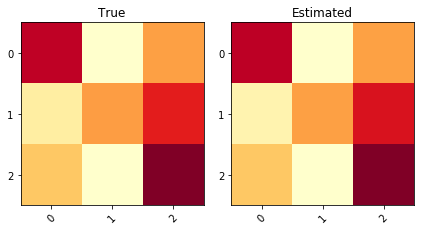

JS divergence: 0.0006	KL divergence: 0.0018


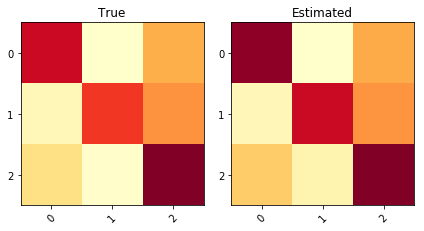

JS divergence: 0.0040	KL divergence: 0.0105


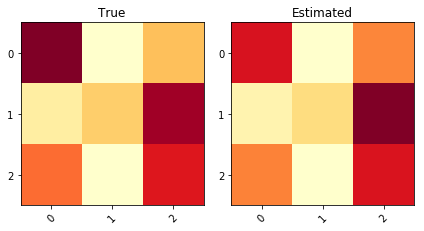

JS divergence: 0.0075	KL divergence: 0.0205


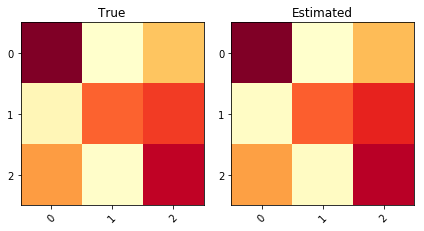

JS divergence: 0.0015	KL divergence: 0.0040


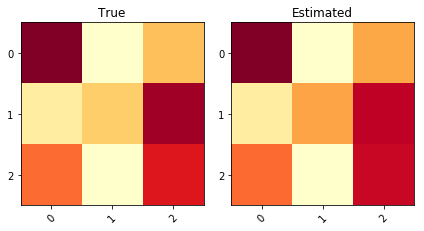

JS divergence: 0.0030	KL divergence: 0.0080


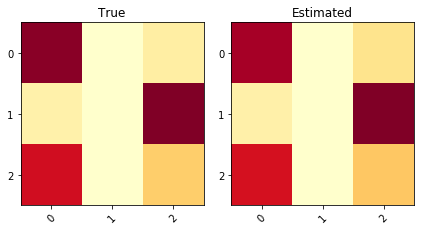

JS divergence: 0.0020	KL divergence: 0.0052


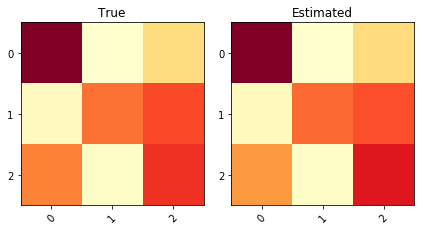

JS divergence: 0.0030	KL divergence: 0.0092
A result
 ====  ======  ==========  ============  =========  ==========
  ..            Accuracy    F1 (micro)    Mean KL     Mean JS
====  ======  ==========  ============  =========  ==========
   0  Global    0.906797      0.906797  0.0239761  0.00460544
====  ======  ==========  ============  =========  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.918193      0.918193
====  ======  ==========  ============


In [23]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


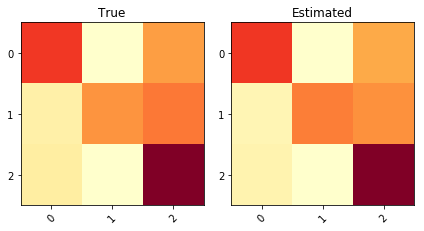

JS divergence: 0.0052	KL divergence: 0.0113


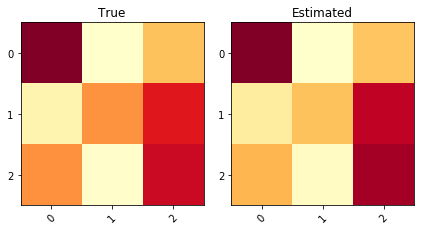

JS divergence: 0.0084	KL divergence: 0.0226


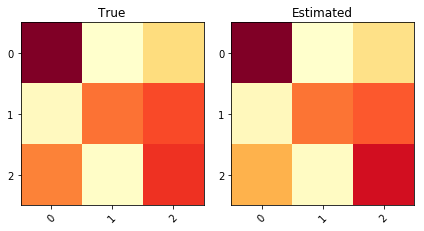

JS divergence: 0.0048	KL divergence: 0.0140


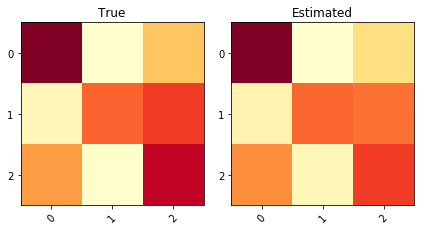

JS divergence: 0.0070	KL divergence: 0.0183


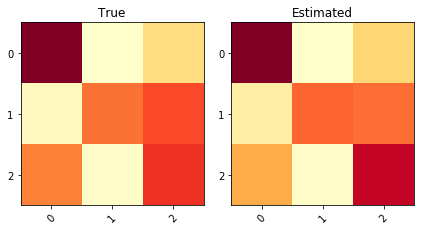

JS divergence: 0.0055	KL divergence: 0.0149


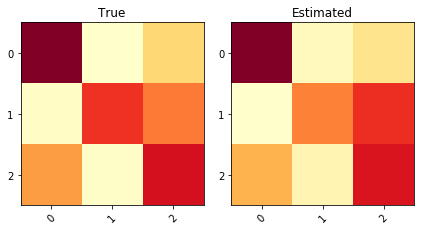

JS divergence: 0.0089	KL divergence: 0.0233


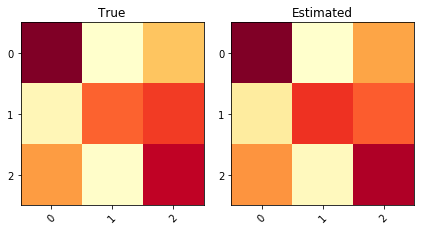

JS divergence: 0.0031	KL divergence: 0.0087


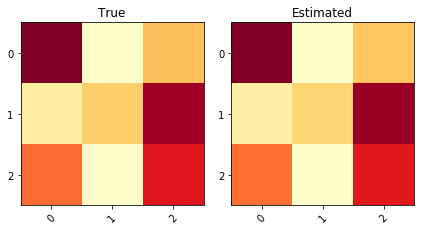

JS divergence: 0.0038	KL divergence: 0.0076


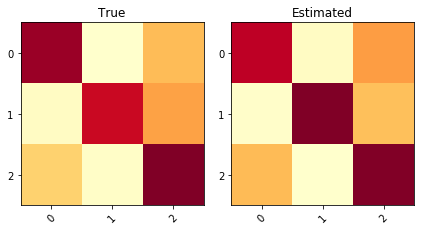

JS divergence: 0.0051	KL divergence: 0.0139


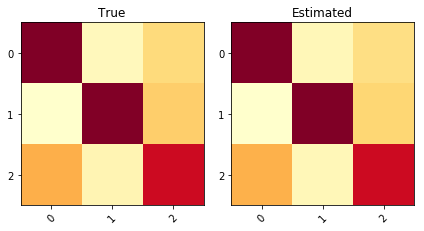

JS divergence: 0.0006	KL divergence: 0.0015


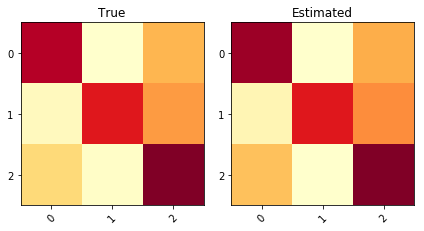

JS divergence: 0.0025	KL divergence: 0.0065


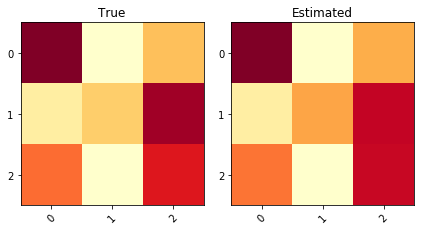

JS divergence: 0.0078	KL divergence: 0.0180


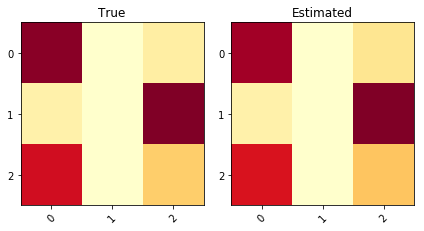

JS divergence: 0.0074	KL divergence: 0.0161


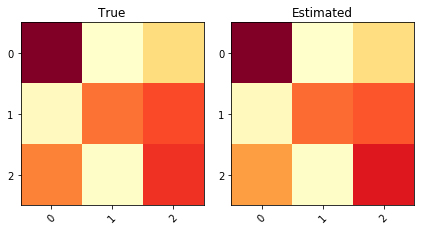

JS divergence: 0.0014	KL divergence: 0.0041


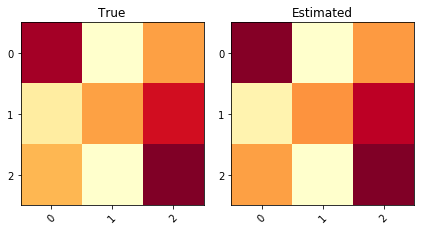

JS divergence: 0.0047	KL divergence: 0.0101
A result
 ====  ======  ==========  ============  =========  ==========  ==========  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean KL     Mean JS    Wmean KL    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  =========  ==========  ==========  ==========  ===========  ============
   0  Global    0.924705      0.924705  0.0132561  0.00531207     0.01322  0.00529579     0.128172      0.126848
====  ======  ==========  ============  =========  ==========  ==========  ==========  ===========  ============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.617248                0.824658
====  =======================  ======================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ==

In [24]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train,data=Z_train_p)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours Global multiples runs***
Train


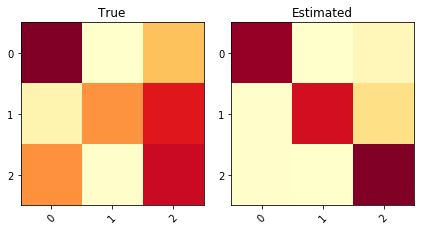

JS divergence: 0.1361	KL divergence: 0.6127


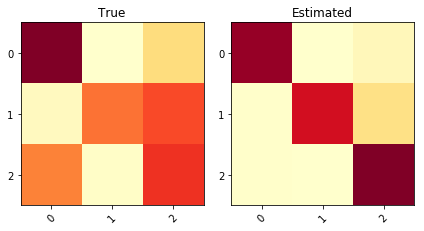

JS divergence: 0.1324	KL divergence: 0.6438


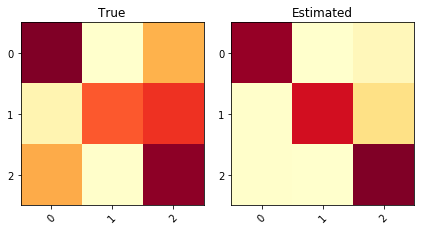

JS divergence: 0.1120	KL divergence: 0.4943


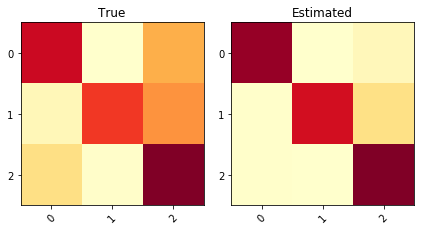

JS divergence: 0.0834	KL divergence: 0.3512


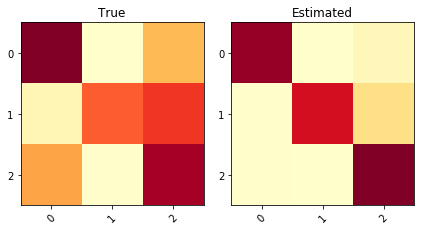

JS divergence: 0.1149	KL divergence: 0.5163


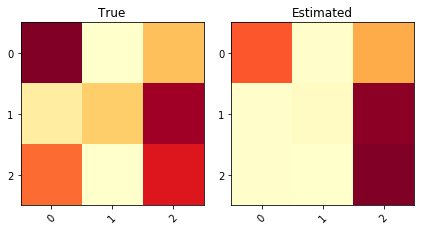

JS divergence: 0.1130	KL divergence: 0.5695


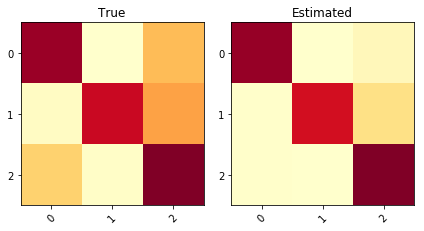

JS divergence: 0.0821	KL divergence: 0.3775


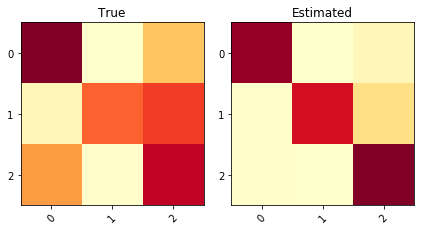

JS divergence: 0.1188	KL divergence: 0.5454


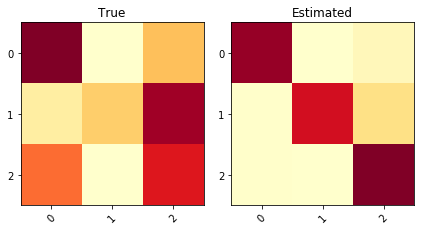

JS divergence: 0.1836	KL divergence: 0.7899


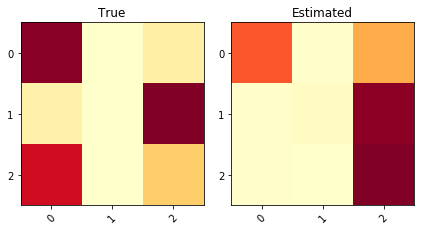

JS divergence: 0.2093	KL divergence: 1.0664


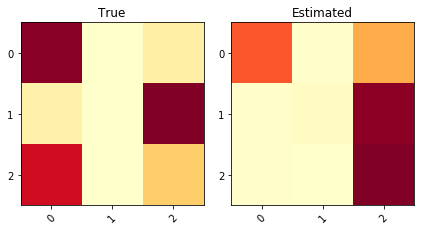

JS divergence: 0.2093	KL divergence: 1.0664


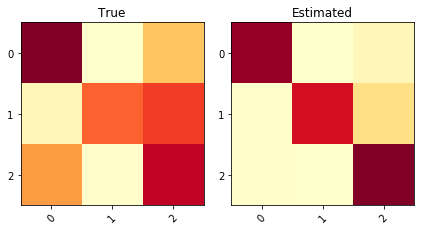

JS divergence: 0.1188	KL divergence: 0.5454


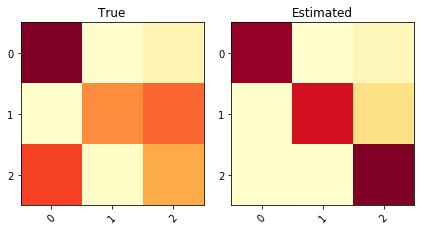

JS divergence: 0.1706	KL divergence: 0.8906


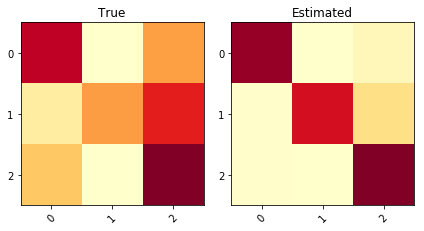

JS divergence: 0.1239	KL divergence: 0.4986


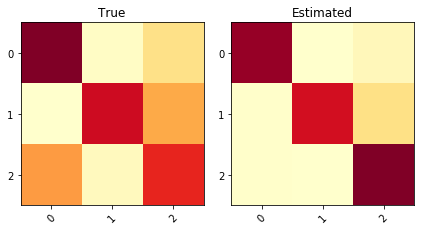

JS divergence: 0.1037	KL divergence: 0.5446
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
   0  Global    0.905576      0.905576   0.539331   0.118633     0.54002      0.1188     0.238625      0.239031
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
A result
 ====  ========================  ====================  =========================  =====================
  ..    Mean ACC imiting Annot    Mean cross-entropy    Wmean ACC imiting Annot    wMean cross entropy
====  ========================  ====================  =========================  =====================
   0                  0.603985              0.829095               

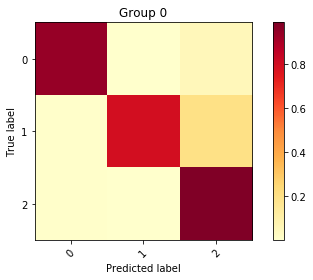

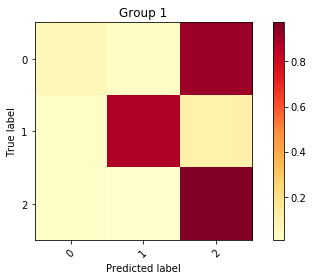

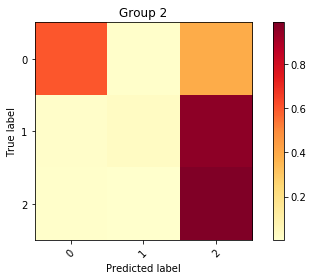

Inertia: 0.2516720590143098
A result
 ====  ========  =========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups       Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  =========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.691384       69   0.276315     0.90915   0.0995804       0.930092   0.863725    0.881563      0.881563
   1         1  0.0989126       9   0.301993     0.63671   0.991395        0.561478   0.455065    0.566545      0.566545
   2         2  0.209704       20   0.33559      0.538767  1.35325         0.448301   0.30815     0.600733      0.600733
====  ========  =========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =

In [60]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [61]:
prob_Gt #muy one hot

array([[1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [0.  , 0.  , 1.  ],
       [0.  , 0.  , 1.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
 

*** Ours (1) multiples runs***
Train


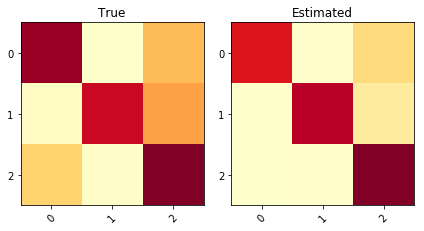

KL divergence: 0.3232	Pearson Correlation between diagonals: 0.3613


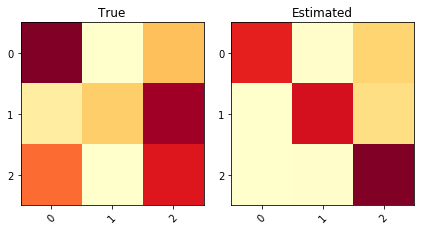

KL divergence: 0.8276	Pearson Correlation between diagonals: -0.0154


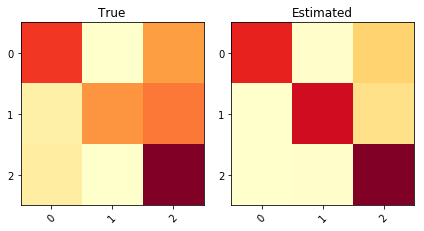

KL divergence: 0.2438	Pearson Correlation between diagonals: 0.7721


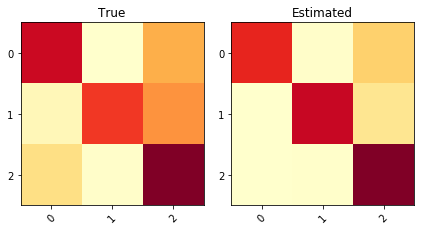

KL divergence: 0.2599	Pearson Correlation between diagonals: 0.6147


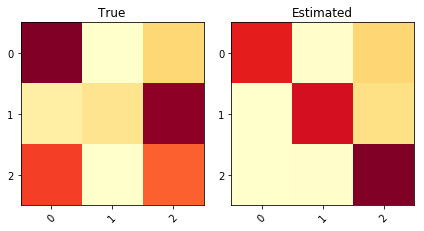

KL divergence: 1.0898	Pearson Correlation between diagonals: -0.2214


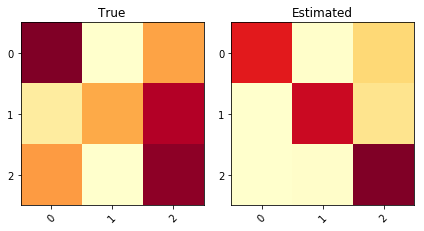

KL divergence: 0.6288	Pearson Correlation between diagonals: 0.1700


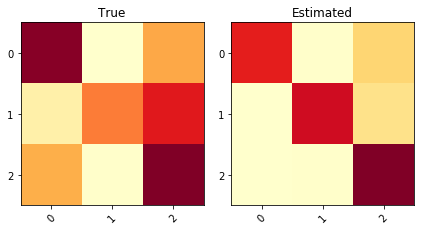

KL divergence: 0.4777	Pearson Correlation between diagonals: 0.2675


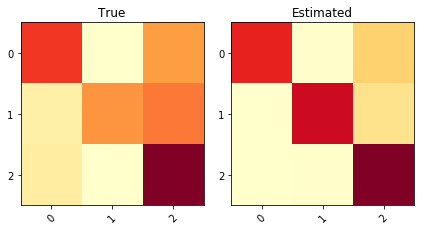

KL divergence: 0.2488	Pearson Correlation between diagonals: 0.7393


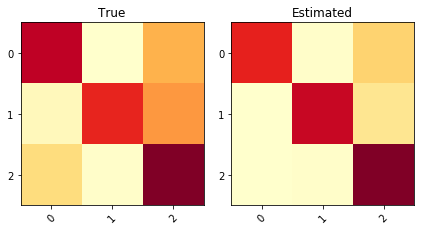

KL divergence: 0.2724	Pearson Correlation between diagonals: 0.6012


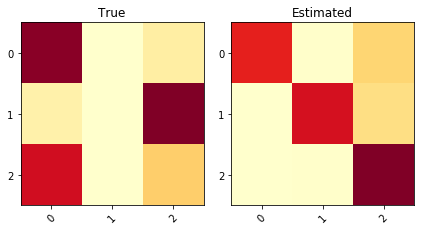

KL divergence: 1.7259	Pearson Correlation between diagonals: -0.4344


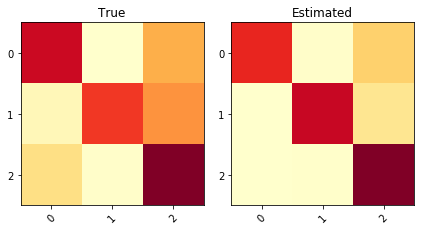

KL divergence: 0.2591	Pearson Correlation between diagonals: 0.6131


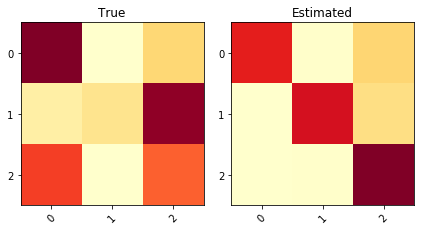

KL divergence: 1.0866	Pearson Correlation between diagonals: -0.2120


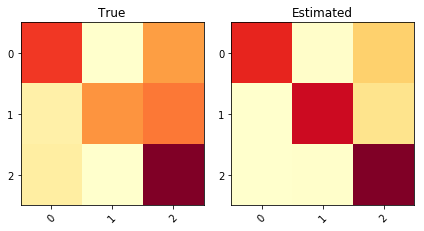

KL divergence: 0.2478	Pearson Correlation between diagonals: 0.7236


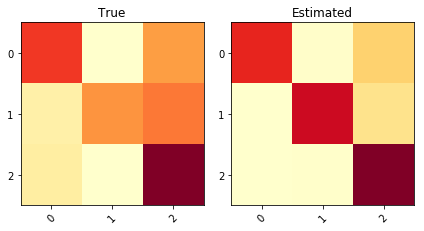

KL divergence: 0.2480	Pearson Correlation between diagonals: 0.7300


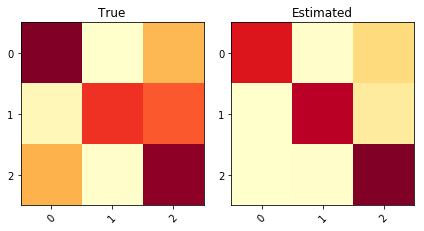

KL divergence: 0.4554	Pearson Correlation between diagonals: -0.0444
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.820513      0.820513   0.520173  0.0737737           0.0394929       0.0691972
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.620714                0.792509
====  =======================  ======================
Test


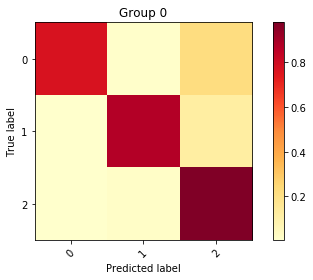

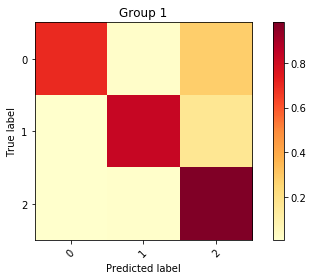

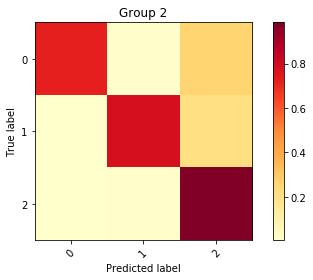

Inertia: 0.001852757598195846
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.367625      36   0.364847     0.874186   0.139261       0.932436   0.540853    0.769231      0.769231
   1         1  0.268373      26   0.415645     0.838624   0.185258       0.911159   0.50529     0.688645      0.688645
   2         2  0.364003      36   0.42033      0.831836   0.192676       0.907515   0.498502    0.661783      0.661783
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ======

In [84]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


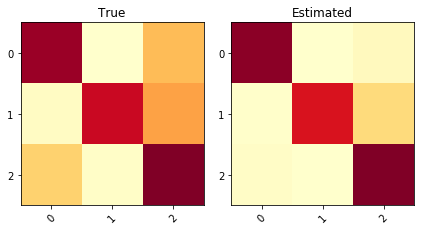

KL divergence: 0.3171	Pearson Correlation between diagonals: 0.9744


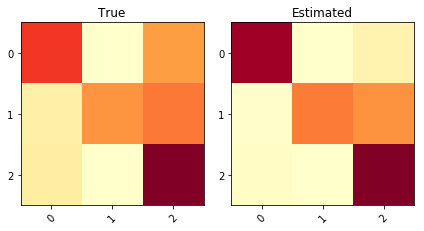

KL divergence: 0.1976	Pearson Correlation between diagonals: 0.8653


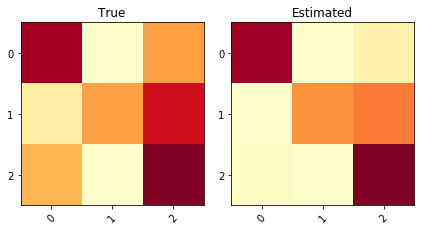

KL divergence: 0.2630	Pearson Correlation between diagonals: 1.0000


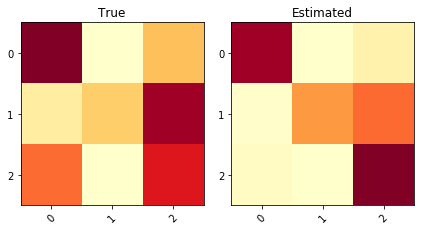

KL divergence: 0.3929	Pearson Correlation between diagonals: 0.9058


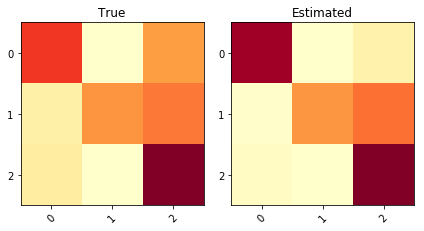

KL divergence: 0.1846	Pearson Correlation between diagonals: 0.8607


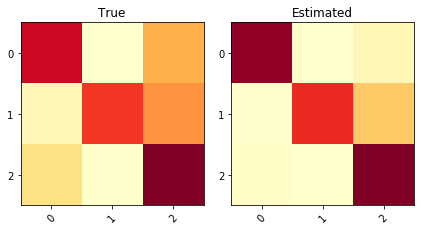

KL divergence: 0.2575	Pearson Correlation between diagonals: 0.9122


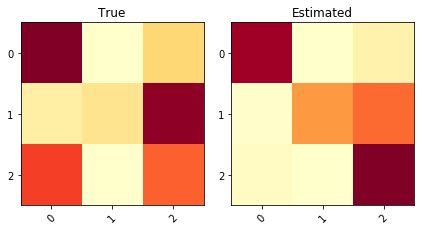

KL divergence: 0.5243	Pearson Correlation between diagonals: 0.8034


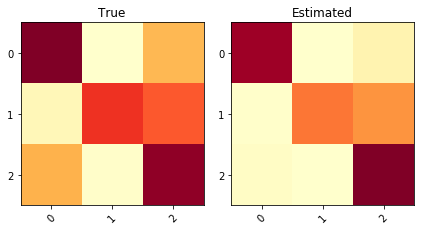

KL divergence: 0.2616	Pearson Correlation between diagonals: 0.9753


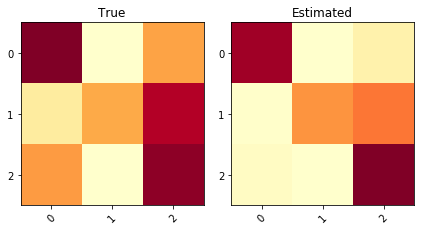

KL divergence: 0.3003	Pearson Correlation between diagonals: 0.9871


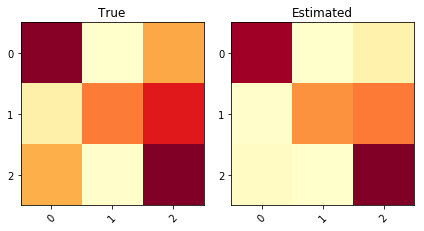

KL divergence: 0.2502	Pearson Correlation between diagonals: 0.9966


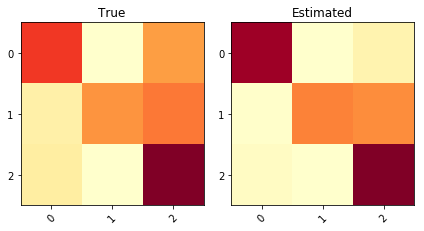

KL divergence: 0.1947	Pearson Correlation between diagonals: 0.8643


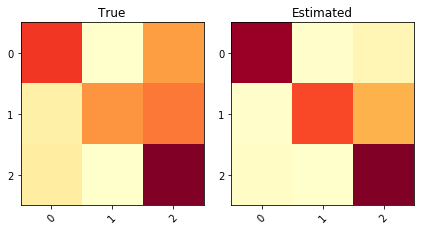

KL divergence: 0.2346	Pearson Correlation between diagonals: 0.8737


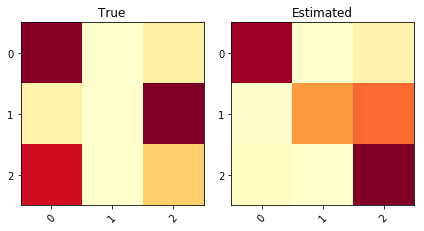

KL divergence: 0.9132	Pearson Correlation between diagonals: 0.6389


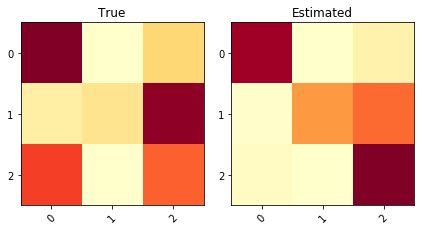

KL divergence: 0.5243	Pearson Correlation between diagonals: 0.8034


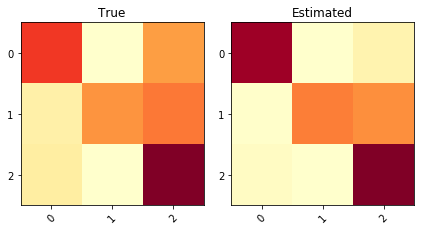

KL divergence: 0.1963	Pearson Correlation between diagonals: 0.8649
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.922263      0.922263   0.353131  0.0592165            0.703907       0.0559583
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.634365                0.789554
====  =======================  ======================
Test


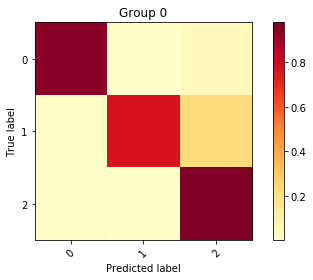

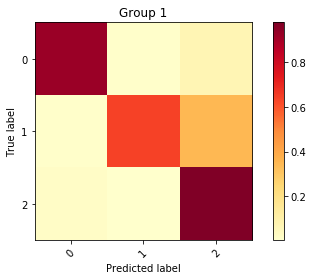

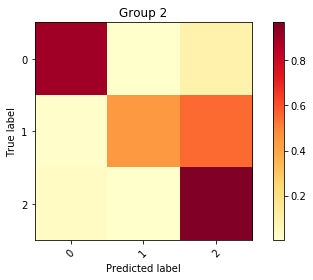

Inertia: 0.010852160902383426
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.389124      38   0.295749     0.899965   0.111069       0.946175   0.566631    0.879121      0.879121
   1         1  0.270756      27   0.367987     0.847832   0.18157        0.914092   0.514498    0.726496      0.726496
   2         2  0.34012       34   0.405299     0.770491   0.31794        0.857818   0.437158    0.649573      0.649573
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ======

In [85]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 4) configuration: Manny annot v1 ($T$ = 2000, $T_{max}$ = 10 )

In [20]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.7716727716727717


*** Soft-Majority (Train with softMV) ***
Train


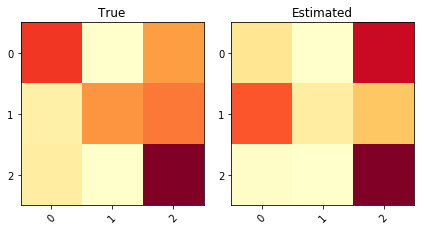

JS divergence: 0.0820	KL divergence: 0.1817


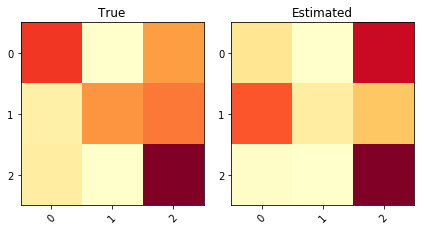

JS divergence: 0.0820	KL divergence: 0.1817


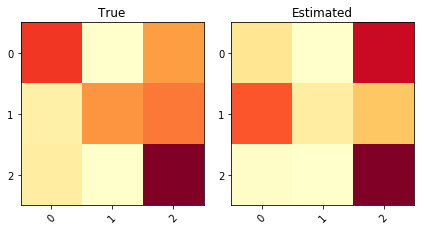

JS divergence: 0.0820	KL divergence: 0.1817


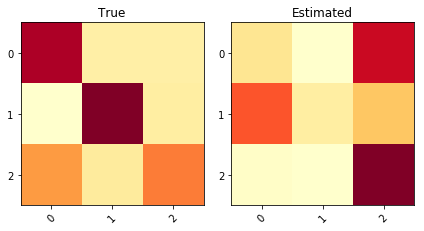

JS divergence: 0.2130	KL divergence: 1.3479


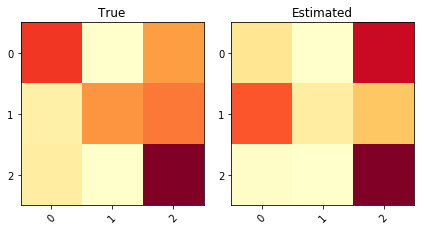

JS divergence: 0.0820	KL divergence: 0.1817


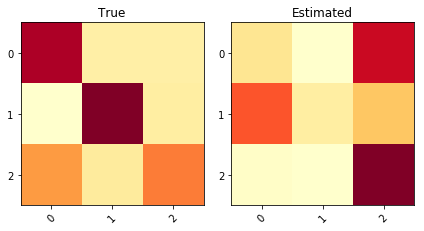

JS divergence: 0.2130	KL divergence: 1.3479


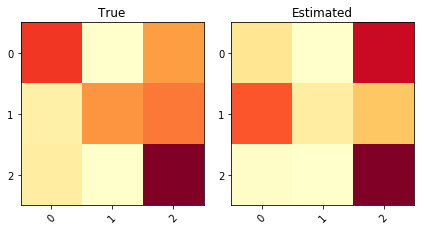

JS divergence: 0.0820	KL divergence: 0.1817


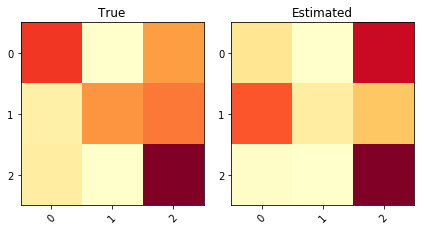

JS divergence: 0.0820	KL divergence: 0.1817


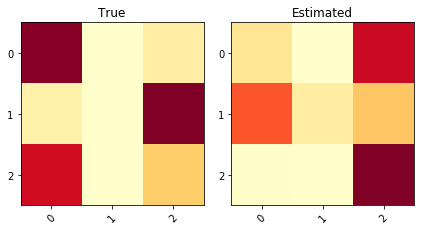

JS divergence: 0.1975	KL divergence: 0.4278


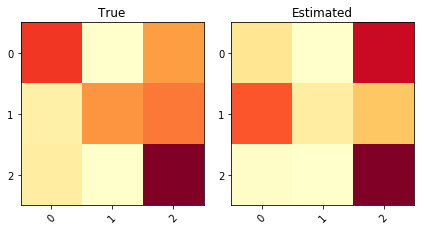

JS divergence: 0.0820	KL divergence: 0.1817


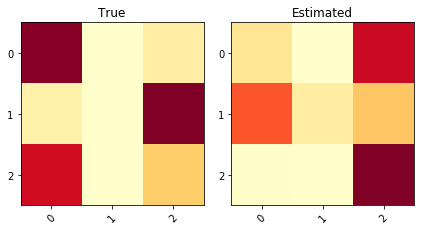

JS divergence: 0.1975	KL divergence: 0.4278


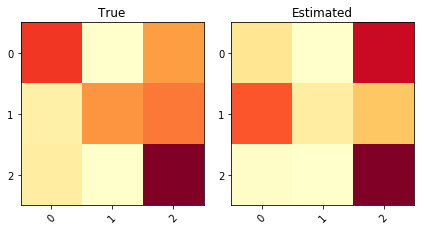

JS divergence: 0.0820	KL divergence: 0.1817


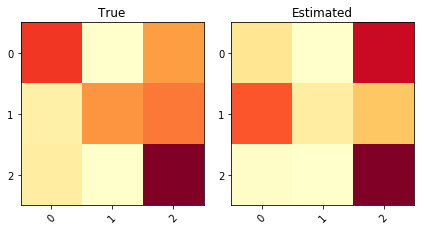

JS divergence: 0.0820	KL divergence: 0.1817


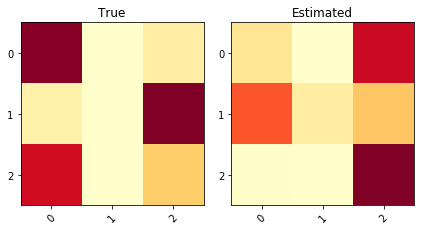

JS divergence: 0.1975	KL divergence: 0.4278


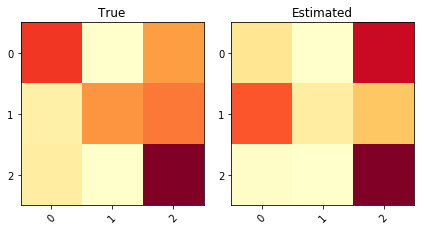

JS divergence: 0.0820	KL divergence: 0.1817
A result
 ====  ======  ==========  ============  =========  =========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS
====  ======  ==========  ============  =========  =========
   0  Global    0.421652      0.421652   0.512505   0.137152
====  ======  ==========  ============  =========  =========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global     0.42735       0.42735
====  ======  ==========  ============


In [21]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train


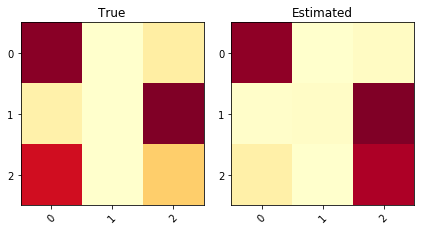

JS divergence: 0.1975	KL divergence: 0.4278


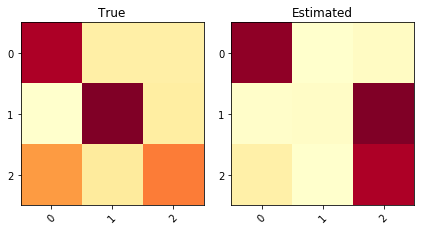

JS divergence: 0.2130	KL divergence: 1.3479


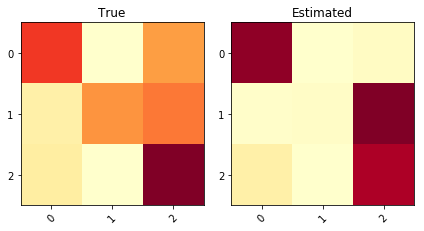

JS divergence: 0.0820	KL divergence: 0.1817


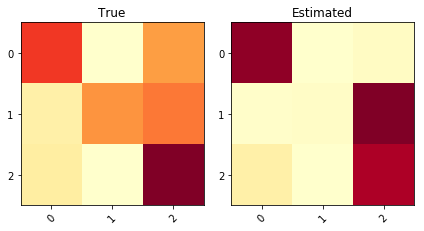

JS divergence: 0.0820	KL divergence: 0.1817


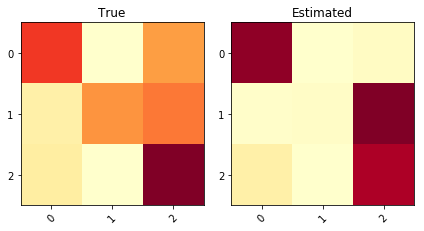

JS divergence: 0.0820	KL divergence: 0.1817


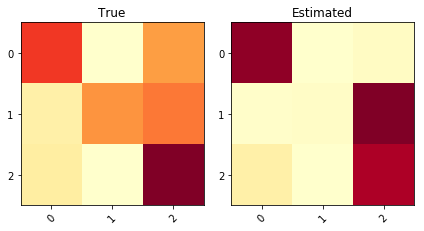

JS divergence: 0.0820	KL divergence: 0.1817


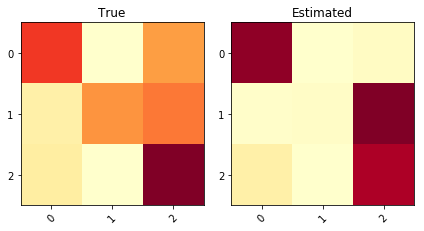

JS divergence: 0.0820	KL divergence: 0.1817


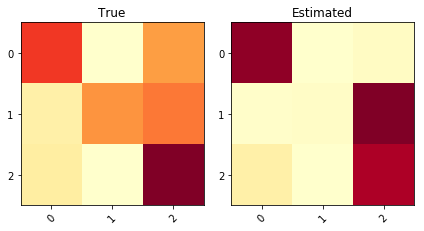

JS divergence: 0.0820	KL divergence: 0.1817


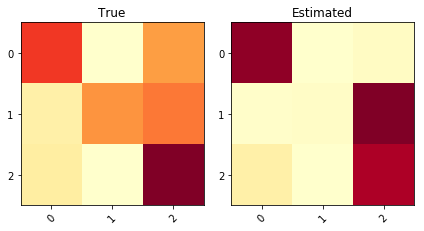

JS divergence: 0.0820	KL divergence: 0.1817


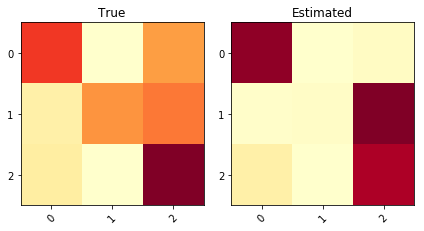

JS divergence: 0.0820	KL divergence: 0.1817


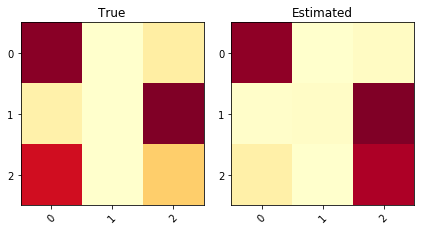

JS divergence: 0.1975	KL divergence: 0.4278


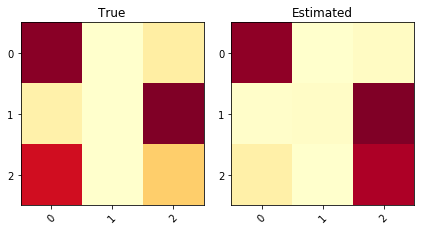

JS divergence: 0.1975	KL divergence: 0.4278


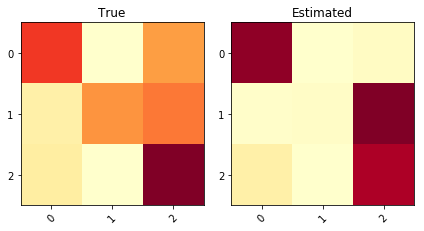

JS divergence: 0.0820	KL divergence: 0.1817


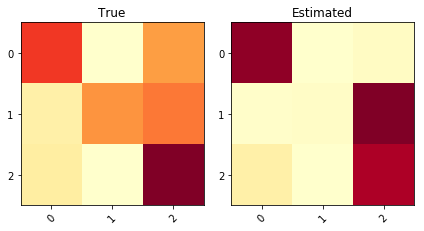

JS divergence: 0.0820	KL divergence: 0.1817


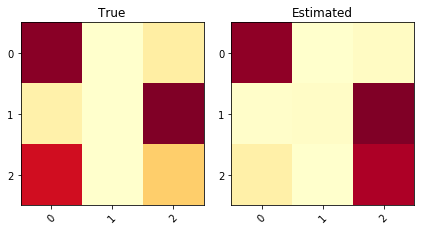

JS divergence: 0.1975	KL divergence: 0.4278
A result
 ====  ======  ==========  ============  =========  =========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS
====  ======  ==========  ============  =========  =========
   0  Global    0.624339      0.624339   0.512505   0.137152
====  ======  ==========  ============  =========  =========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.650794      0.650794
====  ======  ==========  ============


In [22]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train


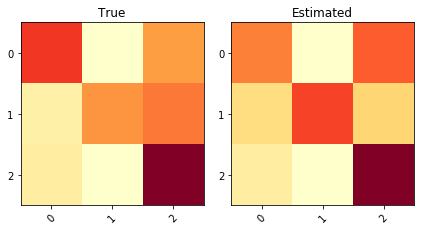

JS divergence: 0.0236	KL divergence: 0.0686


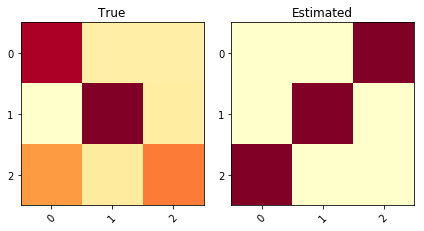

JS divergence: 0.4048	KL divergence: 7.9905


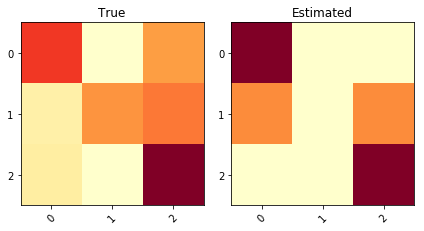

JS divergence: 0.2035	KL divergence: 4.4405


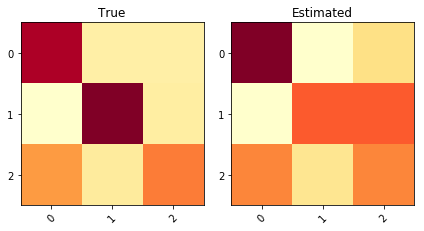

JS divergence: 0.0661	KL divergence: 0.5320


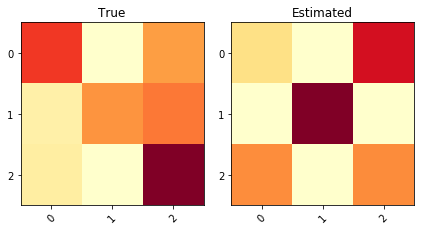

JS divergence: 0.2149	KL divergence: 3.0340


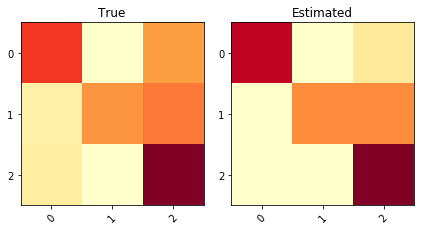

JS divergence: 0.0540	KL divergence: 0.9052


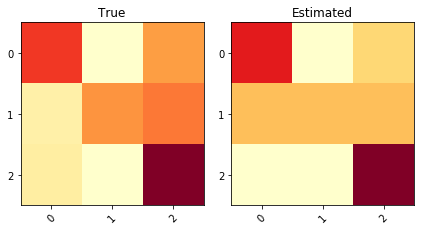

JS divergence: 0.0461	KL divergence: 0.5246


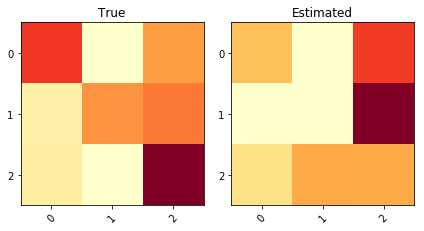

JS divergence: 0.2213	KL divergence: 2.4597


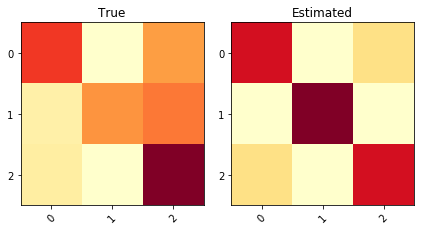

JS divergence: 0.1399	KL divergence: 2.8272


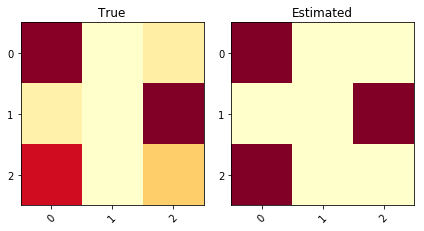

JS divergence: 0.0808	KL divergence: 2.0172


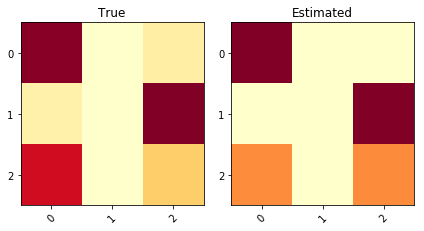

JS divergence: 0.0481	KL divergence: 0.8583


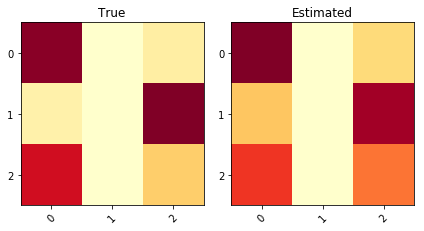

JS divergence: 0.0246	KL divergence: 0.0632


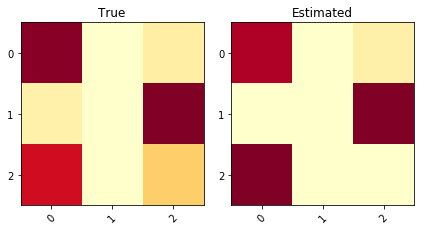

JS divergence: 0.0626	KL divergence: 1.5639


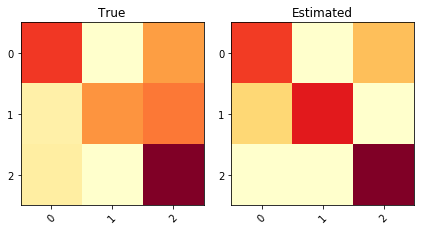

JS divergence: 0.1174	KL divergence: 2.4724


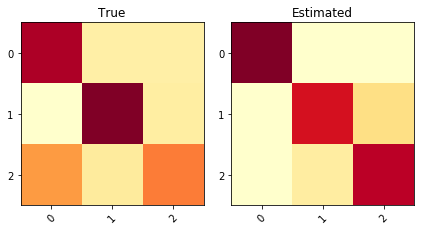

JS divergence: 0.1205	KL divergence: 2.7743
A result
 ====  ======  ==========  ============  =========  =========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS
====  ======  ==========  ============  =========  =========
   0  Global     0.93081       0.93081    1.96961   0.115499
====  ======  ==========  ============  =========  =========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.948718      0.948718
====  ======  ==========  ============


In [23]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


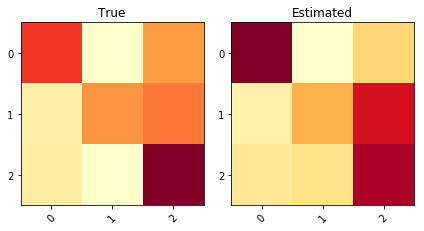

JS divergence: 0.0800	KL divergence: 0.1779


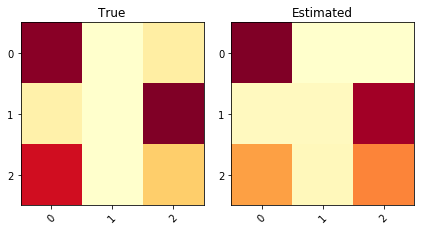

JS divergence: 0.0941	KL divergence: 0.2105


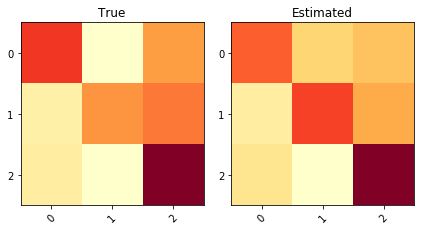

JS divergence: 0.0744	KL divergence: 0.1620


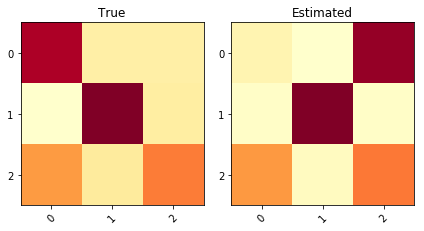

JS divergence: 0.1401	KL divergence: 0.3706


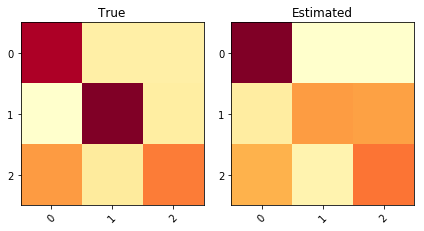

JS divergence: 0.0813	KL divergence: 0.1998


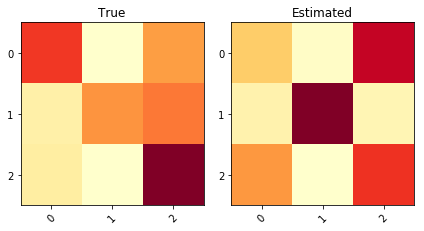

JS divergence: 0.1265	KL divergence: 0.3282


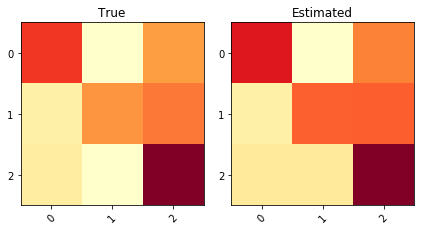

JS divergence: 0.0840	KL divergence: 0.1845


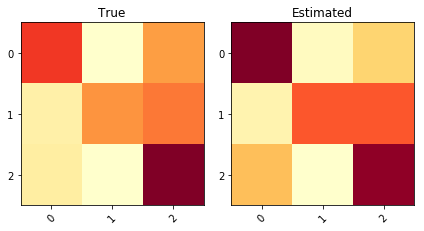

JS divergence: 0.0599	KL divergence: 0.1356


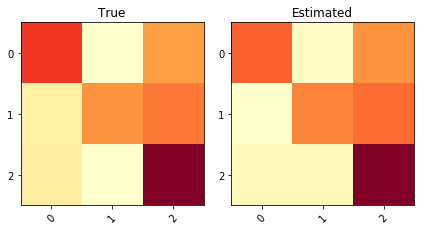

JS divergence: 0.0613	KL divergence: 0.1302


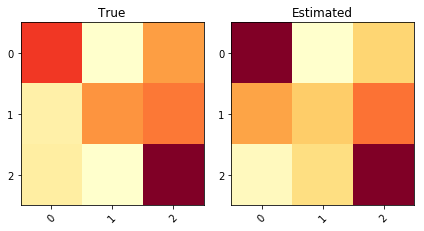

JS divergence: 0.1005	KL divergence: 0.2234


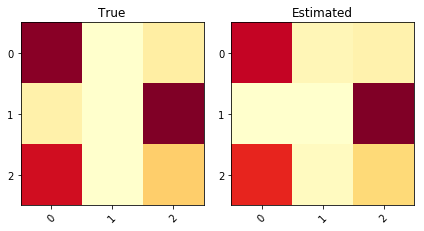

JS divergence: 0.0845	KL divergence: 0.1789


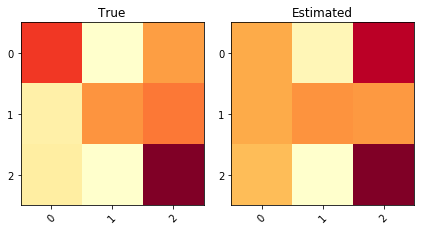

JS divergence: 0.0984	KL divergence: 0.2326


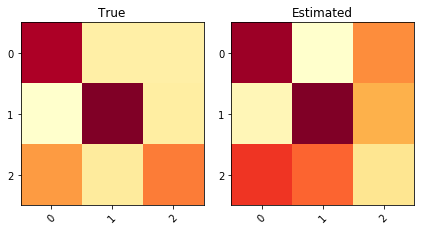

JS divergence: 0.0990	KL divergence: 0.2492


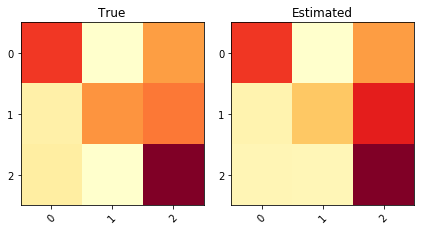

JS divergence: 0.0445	KL divergence: 0.0960


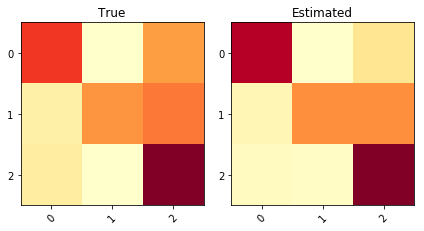

JS divergence: 0.0459	KL divergence: 0.1019
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
   0  Global    0.913309      0.913309   0.211611   0.089661    0.200617   0.0851504     0.138719      0.138591
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.737901                0.777487
====  =======================  ======================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ====== 

In [24]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train,data=Z_train_p)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours Global multiples runs***
Train


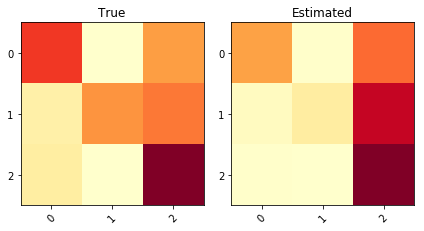

JS divergence: 0.0579	KL divergence: 0.2035


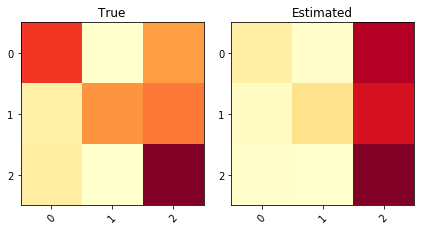

JS divergence: 0.1062	KL divergence: 0.3697


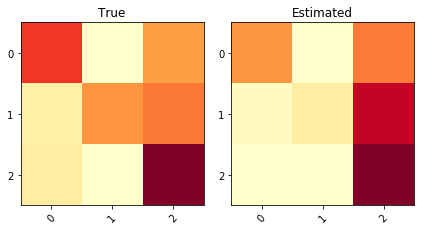

JS divergence: 0.0548	KL divergence: 0.1909


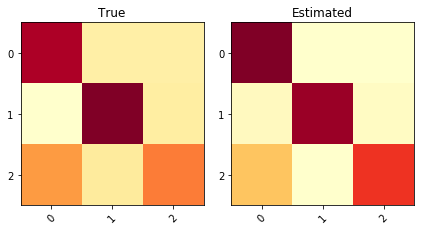

JS divergence: 0.0640	KL divergence: 0.3381


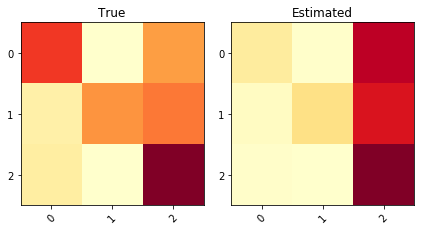

JS divergence: 0.0946	KL divergence: 0.3139


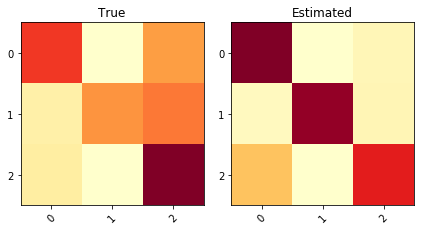

JS divergence: 0.1265	KL divergence: 0.4540


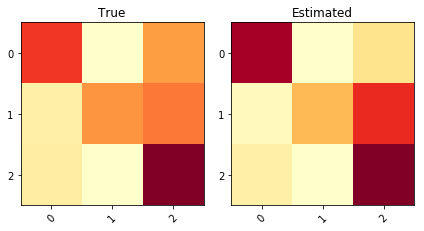

JS divergence: 0.0239	KL divergence: 0.0715


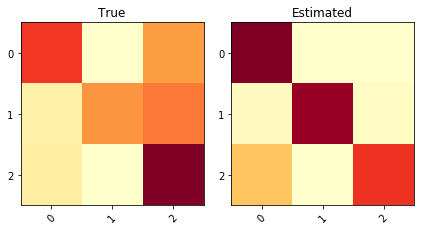

JS divergence: 0.1769	KL divergence: 0.9377


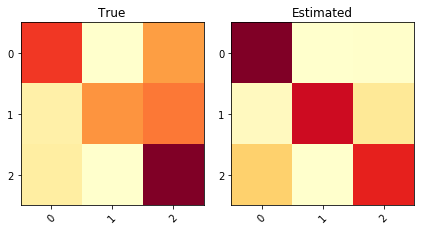

JS divergence: 0.1223	KL divergence: 0.6072


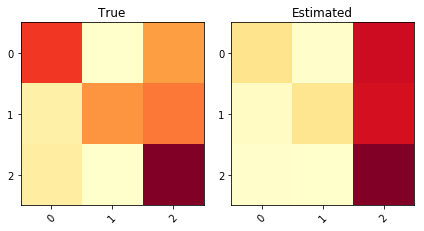

JS divergence: 0.0861	KL divergence: 0.2835


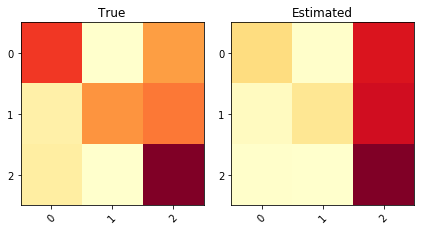

JS divergence: 0.0798	KL divergence: 0.2652


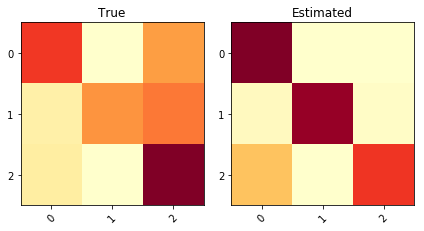

JS divergence: 0.1816	KL divergence: 0.9878


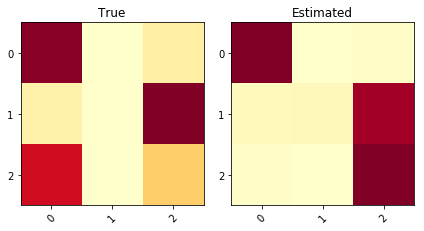

JS divergence: 0.1829	KL divergence: 0.9208


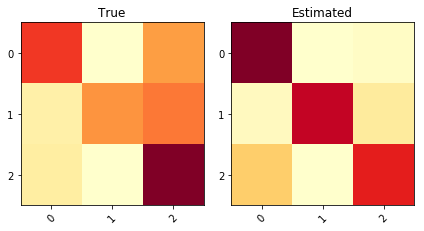

JS divergence: 0.1158	KL divergence: 0.4513


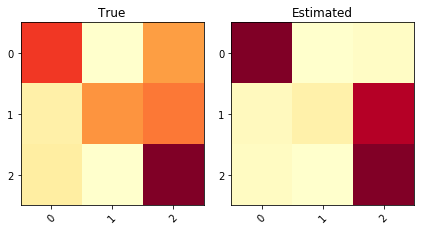

JS divergence: 0.1066	KL divergence: 0.4352
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
   0  Global    0.921042      0.921042   0.546081   0.112395    0.553363    0.113131      0.17486      0.173596
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.693291                0.692693
====  =======================  ======================
Test


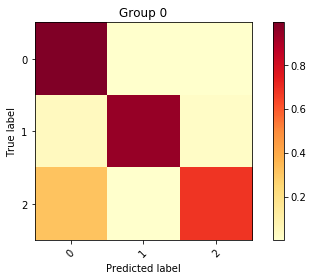

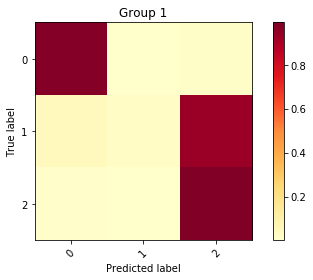

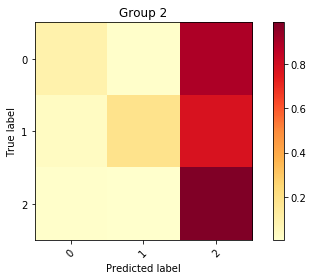

Inertia: 0.3565015471036346
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.4499       899   0.309464     0.873135   0.149125       0.897652   0.809702    0.720391      0.720391
   1         1  0.348645     697   0.144021     0.663803   1.31673        0.546121   0.495704    0.648352      0.648352
   2         2  0.201455     402   0.348241     0.423376   1.35363        0.325574   0.135063    0.333333      0.333333
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ========

In [25]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (1) multiples runs***
Train


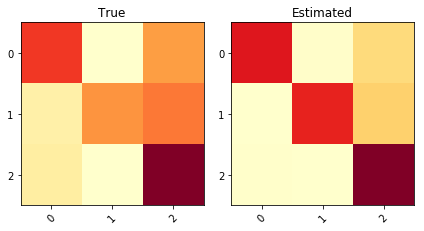

KL divergence: 0.2348	Pearson Correlation between diagonals: 0.9614


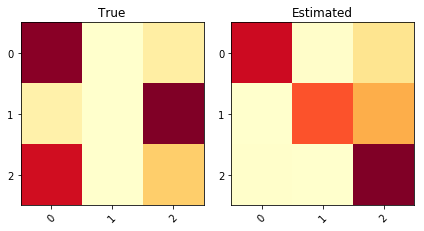

KL divergence: 1.3918	Pearson Correlation between diagonals: 0.3209


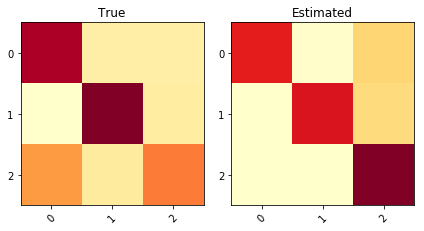

KL divergence: 0.7059	Pearson Correlation between diagonals: -0.9483


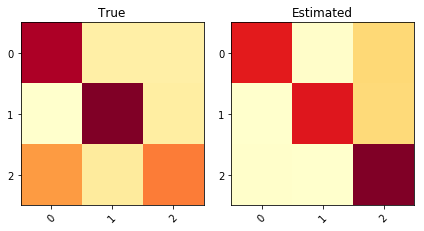

KL divergence: 0.7015	Pearson Correlation between diagonals: -0.9683


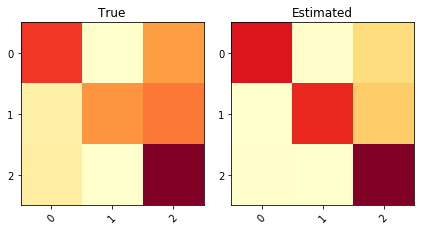

KL divergence: 0.2301	Pearson Correlation between diagonals: 0.9772


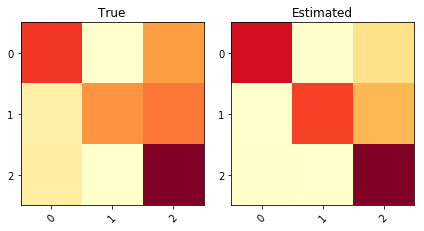

KL divergence: 0.2154	Pearson Correlation between diagonals: 0.9987


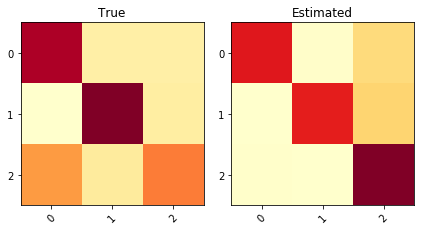

KL divergence: 0.6946	Pearson Correlation between diagonals: -0.9927


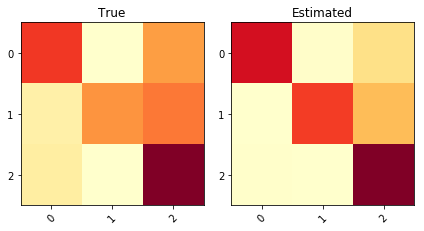

KL divergence: 0.2175	Pearson Correlation between diagonals: 1.0000


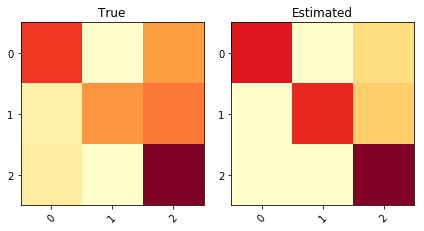

KL divergence: 0.2318	Pearson Correlation between diagonals: 0.9719


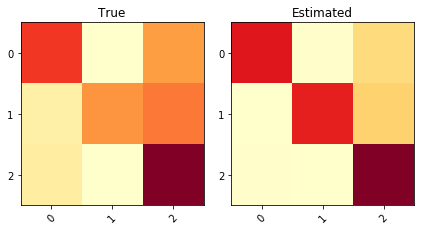

KL divergence: 0.2370	Pearson Correlation between diagonals: 0.9526


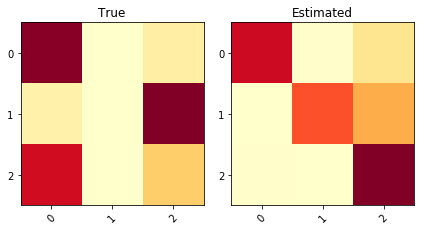

KL divergence: 1.3941	Pearson Correlation between diagonals: 0.3164


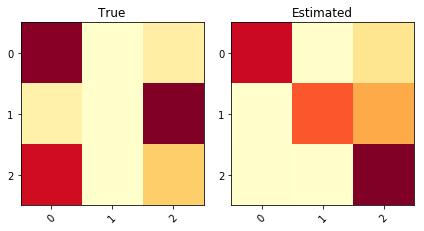

KL divergence: 1.3802	Pearson Correlation between diagonals: 0.3438


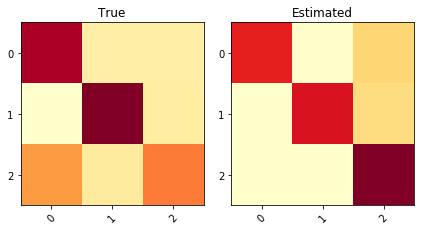

KL divergence: 0.7092	Pearson Correlation between diagonals: -0.9320


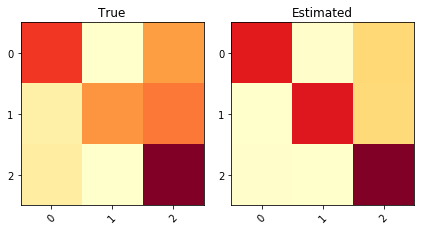

KL divergence: 0.2494	Pearson Correlation between diagonals: 0.8984


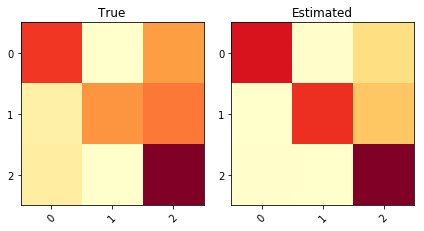

KL divergence: 0.2242	Pearson Correlation between diagonals: 0.9924
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global     0.89825       0.89825   0.577248   0.084947            0.328995        0.151221
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.630185                0.786908
====  =======================  ======================
Test


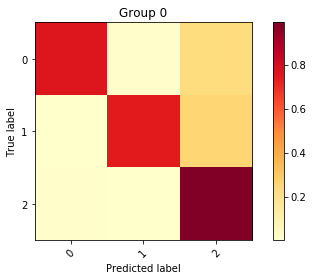

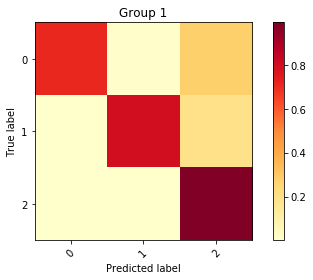

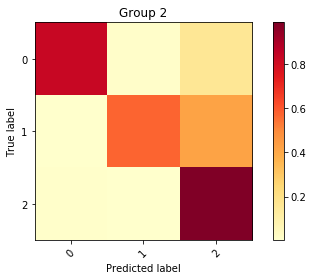

Inertia: 0.007227727444842458
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.29693      593   0.411571     0.831426   0.193448       0.907181   0.498093    0.715507      0.715507
   1         1  0.419679     839   0.398301     0.836052   0.18867        0.909572   0.502719    0.805861      0.805861
   2         2  0.283392     566   0.418249     0.798585   0.249393       0.883511   0.465252    0.648352      0.648352
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ======

In [103]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


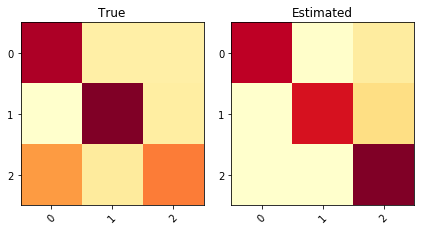

KL divergence: 0.8500	Pearson Correlation between diagonals: -0.9831


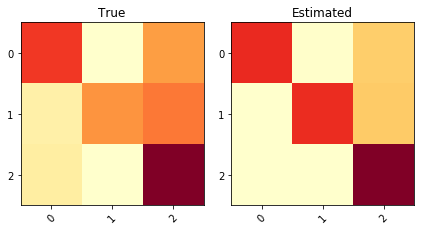

KL divergence: 0.2617	Pearson Correlation between diagonals: 0.9333


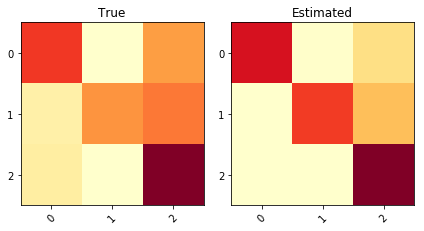

KL divergence: 0.2636	Pearson Correlation between diagonals: 0.9996


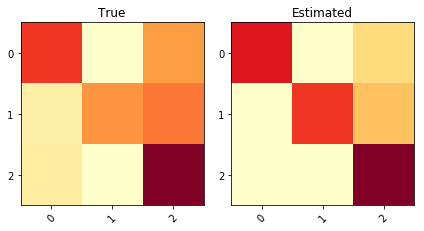

KL divergence: 0.2616	Pearson Correlation between diagonals: 0.9898


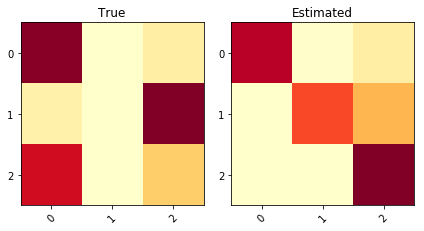

KL divergence: 1.7264	Pearson Correlation between diagonals: 0.4592


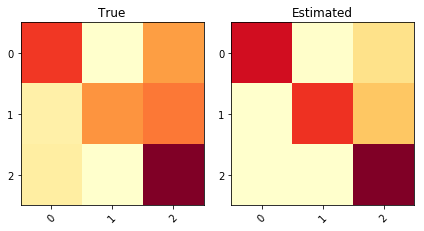

KL divergence: 0.2774	Pearson Correlation between diagonals: 0.9998


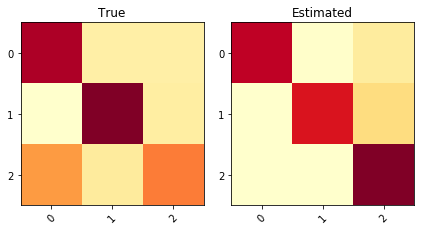

KL divergence: 0.8532	Pearson Correlation between diagonals: -0.9805


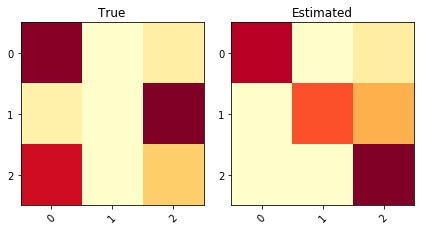

KL divergence: 1.7082	Pearson Correlation between diagonals: 0.4647


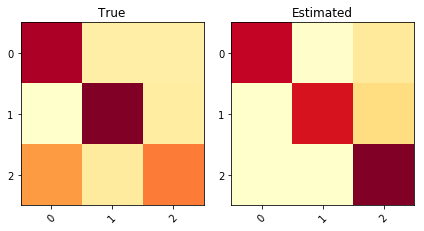

KL divergence: 0.8563	Pearson Correlation between diagonals: -0.9934


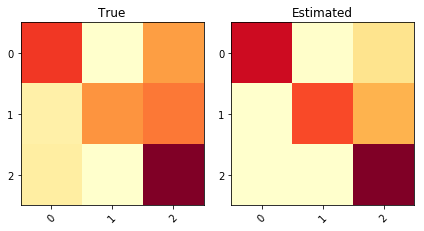

KL divergence: 0.2637	Pearson Correlation between diagonals: 0.9915


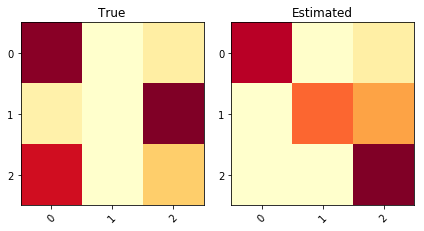

KL divergence: 1.6701	Pearson Correlation between diagonals: 0.5103


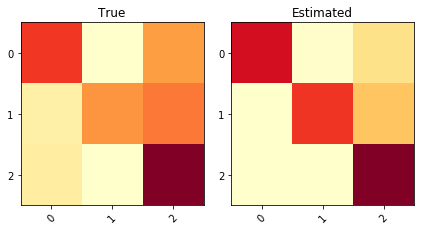

KL divergence: 0.2729	Pearson Correlation between diagonals: 0.9997


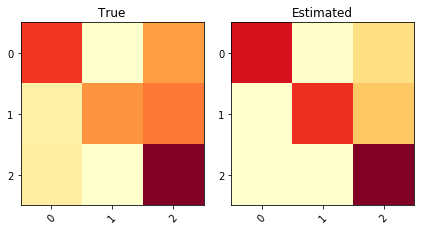

KL divergence: 0.2725	Pearson Correlation between diagonals: 0.9956


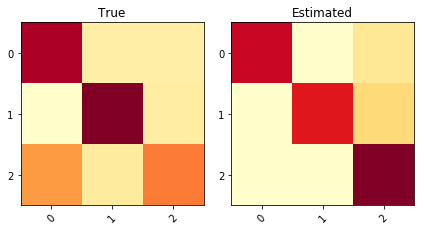

KL divergence: 0.8648	Pearson Correlation between diagonals: -0.9929


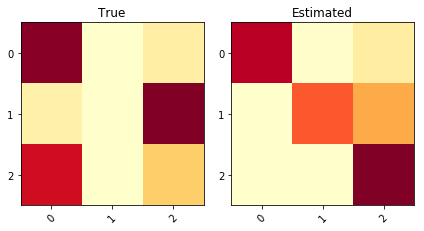

KL divergence: 1.6948	Pearson Correlation between diagonals: 0.4763
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.904762      0.904762   0.690459  0.0839284            0.382153        0.135871
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.647914                0.774467
====  =======================  ======================
Test


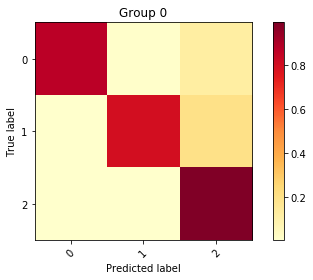

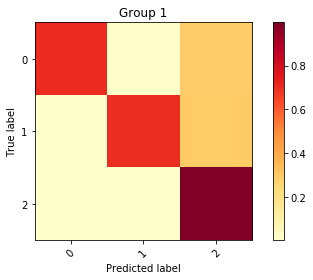

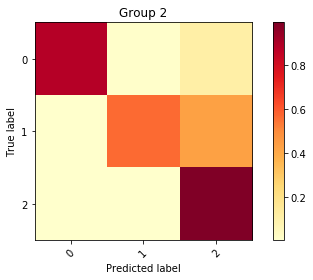

Inertia: 0.010683130628118912
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.308806     617   0.312619     0.890473   0.120068       0.941563   0.55714     0.837607      0.837607
   1         1  0.394164     788   0.422838     0.802826   0.233353       0.889142   0.469493    0.705739      0.705739
   2         2  0.29703      594   0.36901      0.815786   0.231375       0.892482   0.482453    0.648352      0.648352
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ======

In [104]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 5) configuration: Manny annot v2 ($T$ = 10000, $T_{data}$ = 20 )

In [20]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.8070818070818071


*** Soft-Majority (Train with softMV) ***
Train


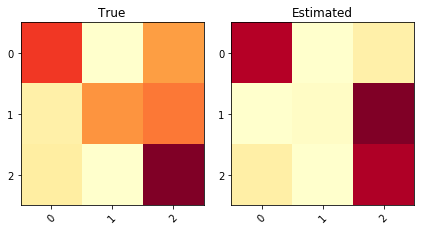

JS divergence: 0.0820	KL divergence: 0.1817


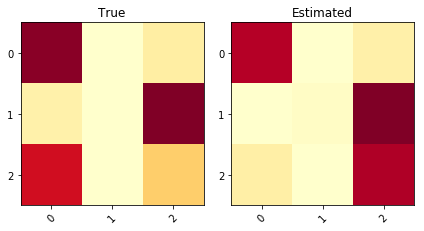

JS divergence: 0.1975	KL divergence: 0.4278


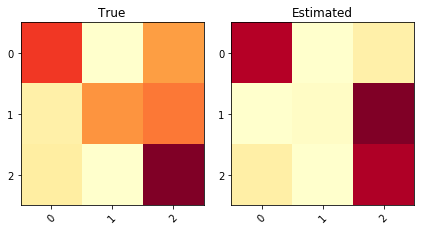

JS divergence: 0.0820	KL divergence: 0.1817


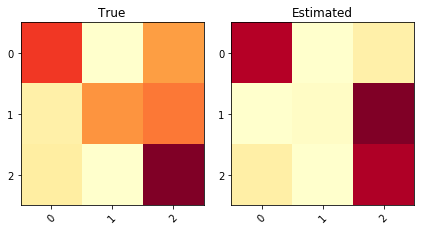

JS divergence: 0.0820	KL divergence: 0.1817


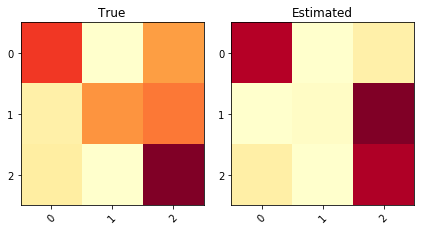

JS divergence: 0.0820	KL divergence: 0.1817


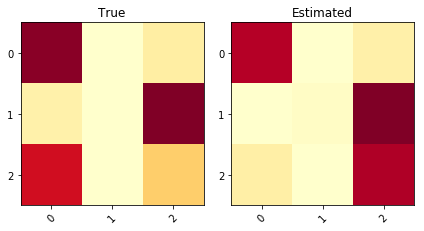

JS divergence: 0.1975	KL divergence: 0.4278


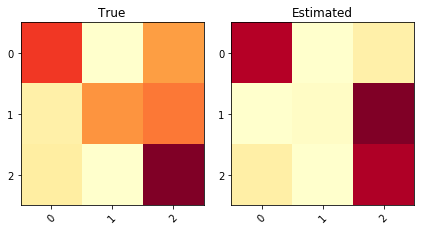

JS divergence: 0.0820	KL divergence: 0.1817


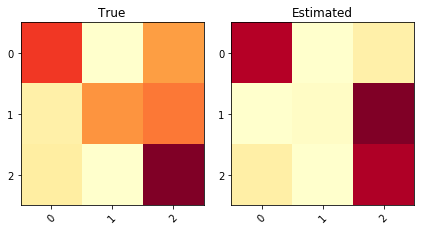

JS divergence: 0.0820	KL divergence: 0.1817


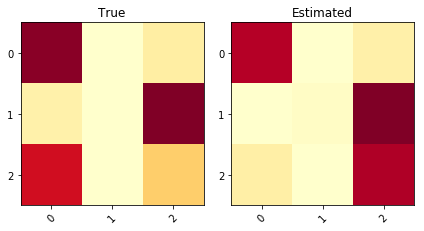

JS divergence: 0.1975	KL divergence: 0.4278


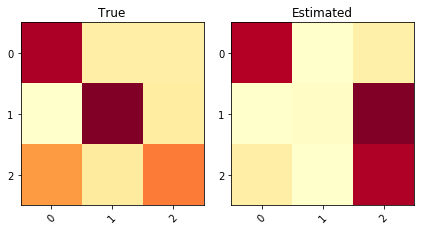

JS divergence: 0.2130	KL divergence: 1.3479


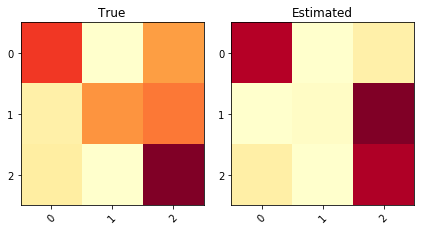

JS divergence: 0.0820	KL divergence: 0.1817


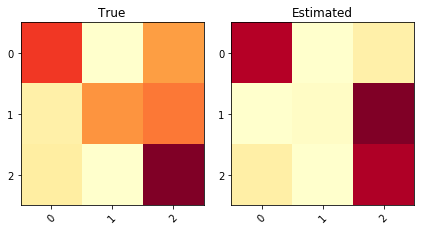

JS divergence: 0.0820	KL divergence: 0.1817


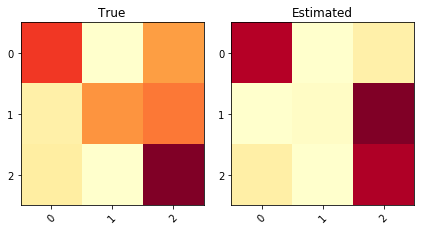

JS divergence: 0.0820	KL divergence: 0.1817


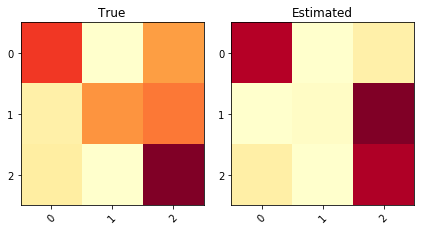

JS divergence: 0.0820	KL divergence: 0.1817


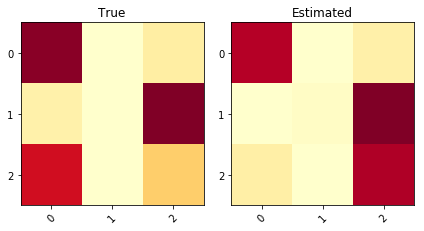

JS divergence: 0.1975	KL divergence: 0.4278
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS
====  ======  ==========  ============  =========  =========  ==========  ==========
   0  Global    0.599105      0.599105   0.515963   0.136899    0.512335    0.136548
====  ======  ==========  ============  =========  =========  ==========  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.615385      0.615385
====  ======  ==========  ============


In [21]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train


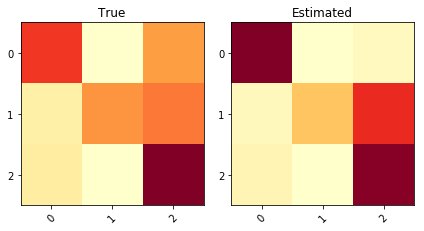

JS divergence: 0.0820	KL divergence: 0.1817


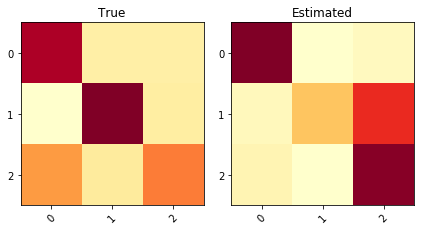

JS divergence: 0.2130	KL divergence: 1.3479


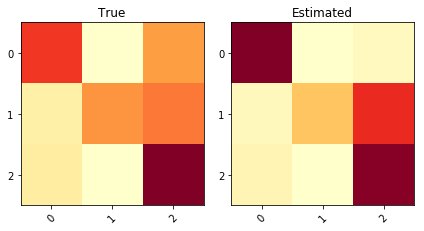

JS divergence: 0.0820	KL divergence: 0.1817


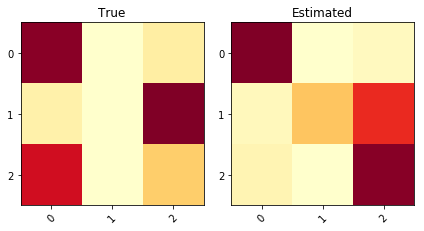

JS divergence: 0.1975	KL divergence: 0.4278


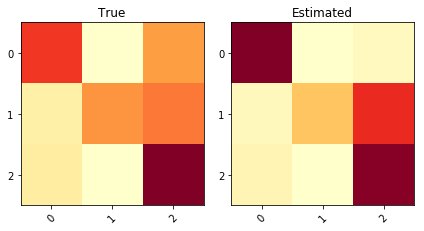

JS divergence: 0.0820	KL divergence: 0.1817


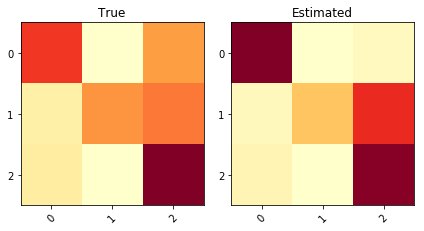

JS divergence: 0.0820	KL divergence: 0.1817


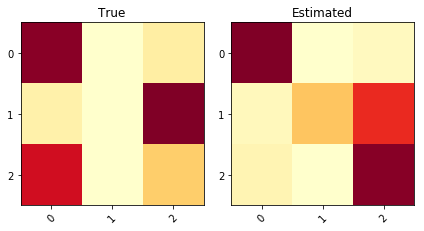

JS divergence: 0.1975	KL divergence: 0.4278


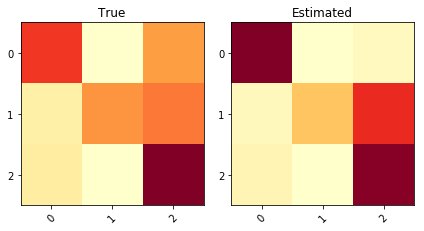

JS divergence: 0.0820	KL divergence: 0.1817


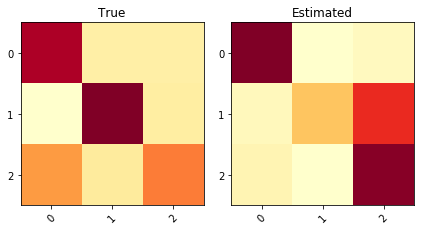

JS divergence: 0.2130	KL divergence: 1.3479


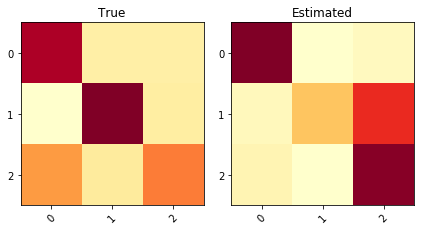

JS divergence: 0.2130	KL divergence: 1.3479


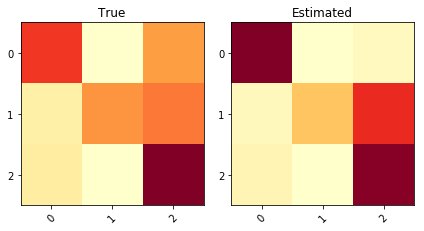

JS divergence: 0.0820	KL divergence: 0.1817


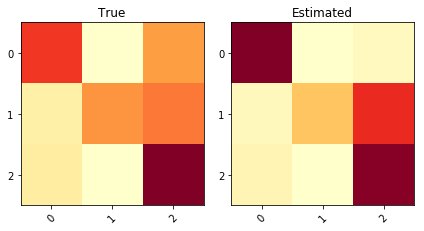

JS divergence: 0.0820	KL divergence: 0.1817


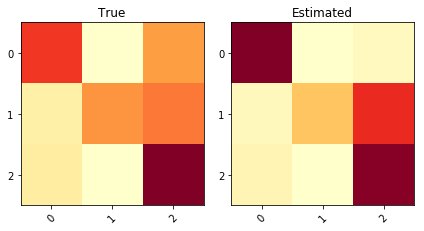

JS divergence: 0.0820	KL divergence: 0.1817


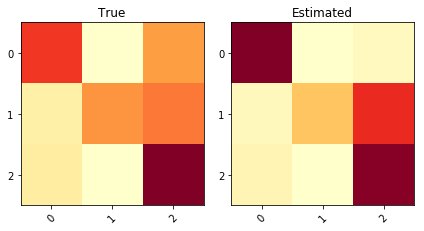

JS divergence: 0.0820	KL divergence: 0.1817


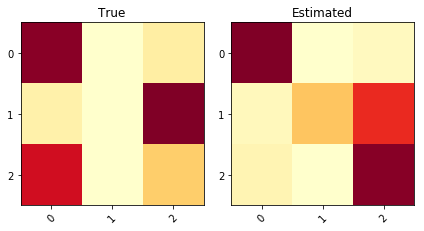

JS divergence: 0.1975	KL divergence: 0.4278
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS
====  ======  ==========  ============  =========  =========  ==========  ==========
   0  Global    0.726089      0.726089   0.515963   0.136899    0.512335    0.136548
====  ======  ==========  ============  =========  =========  ==========  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global     0.73138       0.73138
====  ======  ==========  ============


In [22]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train


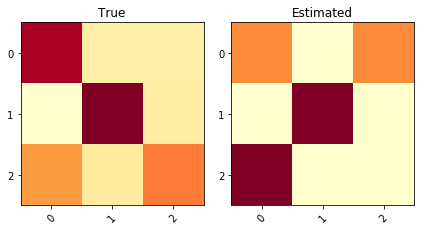

JS divergence: 0.2103	KL divergence: 3.8502


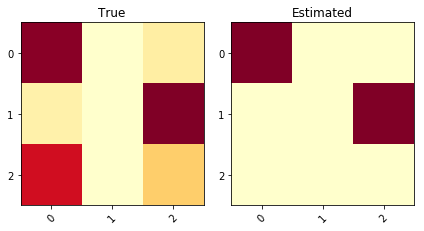

JS divergence: 1.1376	KL divergence: 0.9934


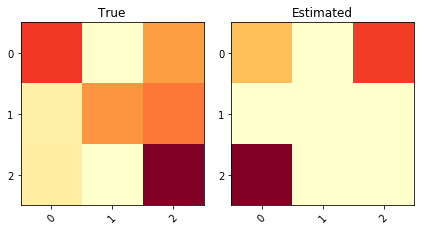

JS divergence: 0.3224	KL divergence: 4.8017


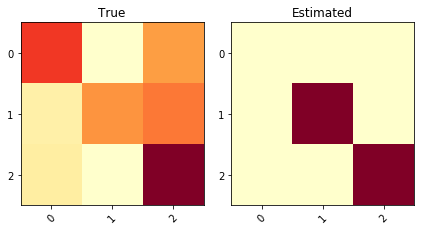

JS divergence: 1.2301	KL divergence: 3.3801


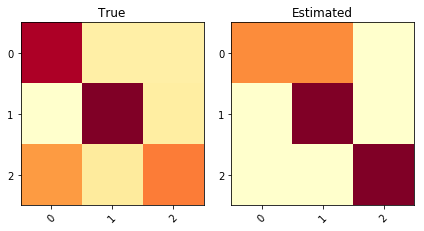

JS divergence: 0.1895	KL divergence: 3.4593


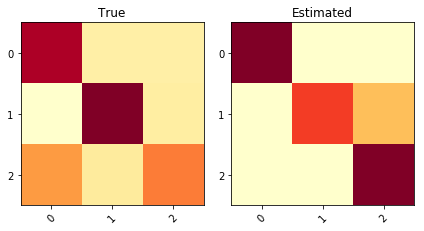

JS divergence: 0.1634	KL divergence: 3.3559


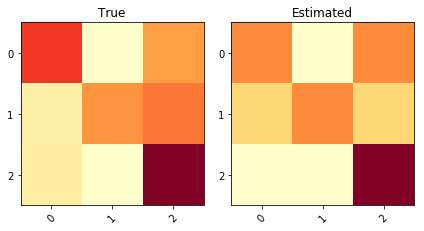

JS divergence: 0.0402	KL divergence: 0.5141


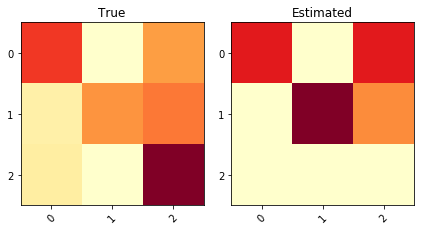

JS divergence: 1.1894	KL divergence: 0.6758


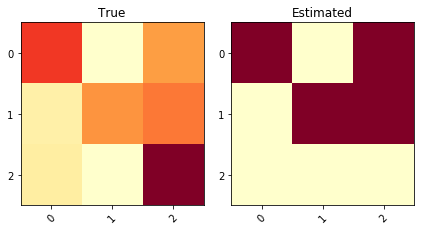

JS divergence: 1.1803	KL divergence: 0.6509


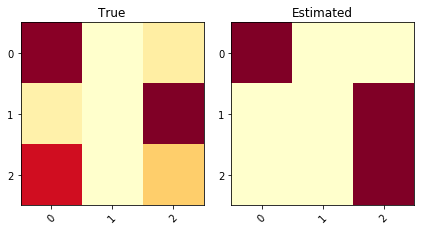

JS divergence: 0.2126	KL divergence: 4.6099


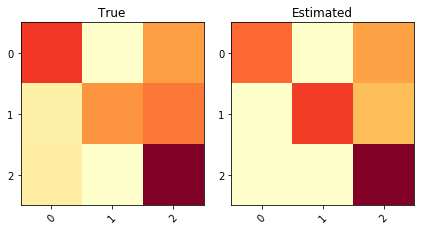

JS divergence: 0.0437	KL divergence: 0.8682


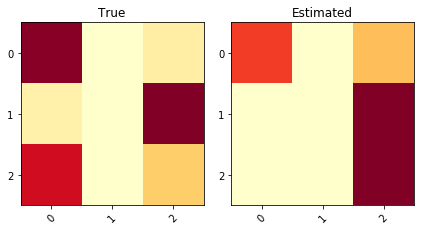

JS divergence: 0.2134	KL divergence: 4.2038


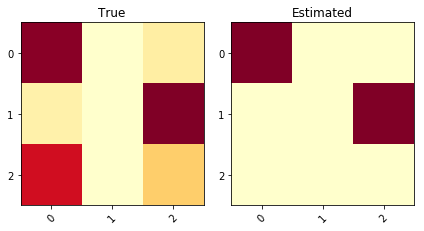

JS divergence: 1.1376	KL divergence: 0.9934


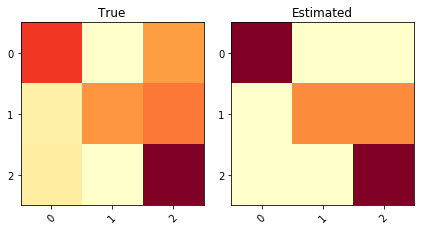

JS divergence: 0.1114	KL divergence: 2.7299


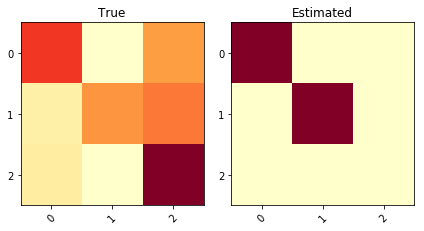

JS divergence: 1.3635	KL divergence: 4.9252
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS
====  ======  ==========  ============  =========  =========  ==========  ==========
   0  Global    0.924705      0.924705    3.17568    0.53102     3.08039    0.403374
====  ======  ==========  ============  =========  =========  ==========  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.936508      0.936508
====  ======  ==========  ============


In [23]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


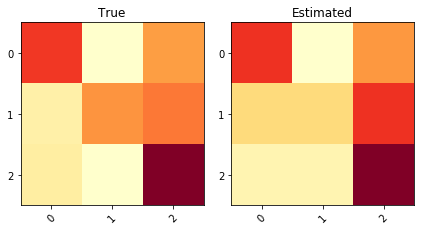

JS divergence: 0.0704	KL divergence: 0.1562


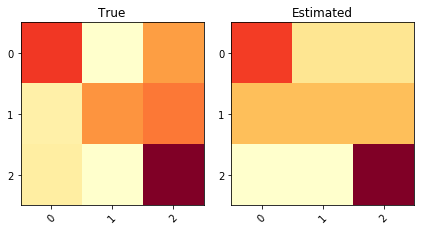

JS divergence: 0.1026	KL divergence: 0.2252


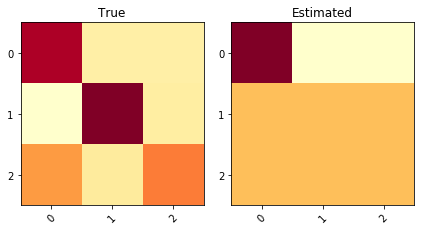

JS divergence: 0.1449	KL divergence: 0.3637


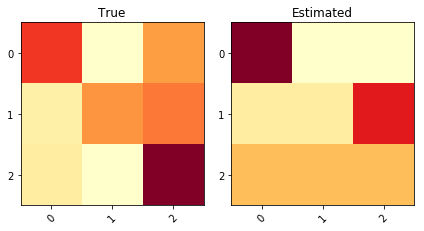

JS divergence: 0.1583	KL divergence: 0.3839


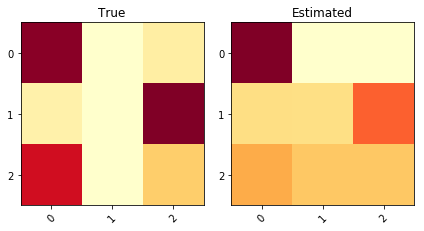

JS divergence: 0.1543	KL divergence: 0.3472


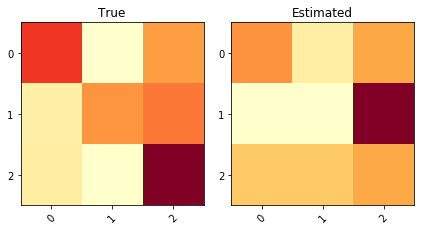

JS divergence: 0.1551	KL divergence: 0.3823


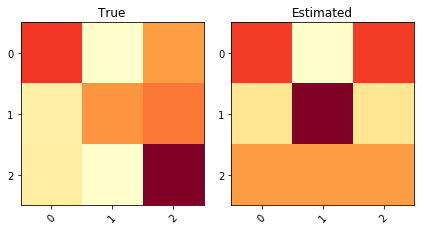

JS divergence: 0.1603	KL divergence: 0.3893


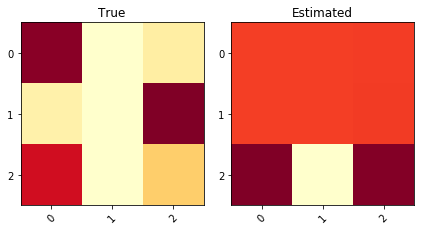

JS divergence: 0.2597	KL divergence: 0.6361


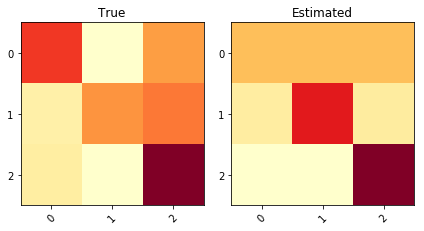

JS divergence: 0.1290	KL divergence: 0.2926


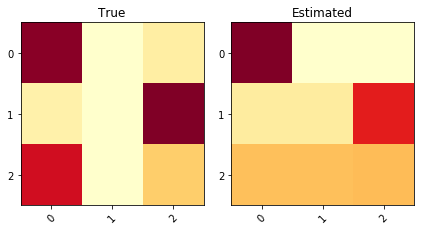

JS divergence: 0.1867	KL divergence: 0.4269


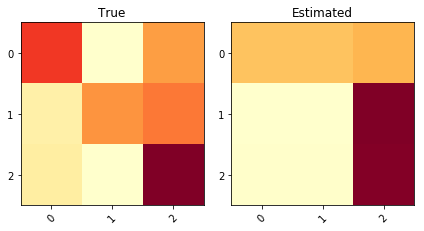

JS divergence: 0.1262	KL divergence: 0.2882


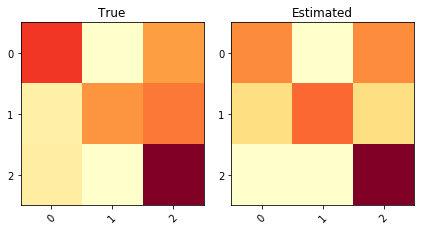

JS divergence: 0.1014	KL divergence: 0.2279


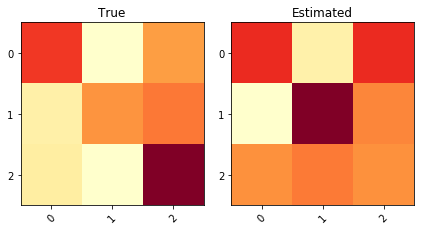

JS divergence: 0.1498	KL divergence: 0.3601


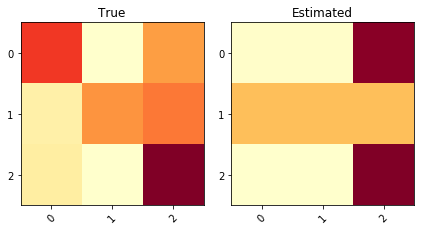

JS divergence: 0.1460	KL divergence: 0.3446


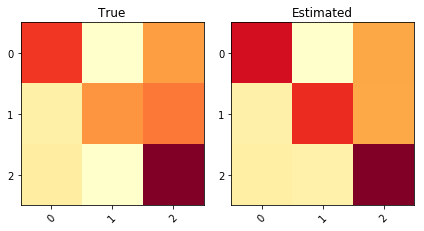

JS divergence: 0.0602	KL divergence: 0.1314
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
   0  Global    0.908425      0.908425   0.331395   0.138351    0.307953    0.128939     0.115309      0.123304
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
A result
 ====  ========================  ====================  =========================  =====================
  ..    Mean ACC imiting Annot    Mean cross-entropy    Wmean ACC imiting Annot    wMean cross entropy
====  ========================  ====================  =========================  =====================
   0                  0.823897              0.795942               

In [24]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train,data=Z_train_p)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours Global multiples runs***
Train


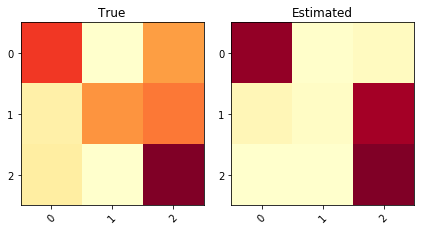

JS divergence: 0.1382	KL divergence: 0.6381


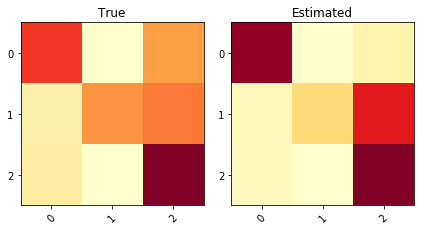

JS divergence: 0.0544	KL divergence: 0.1816


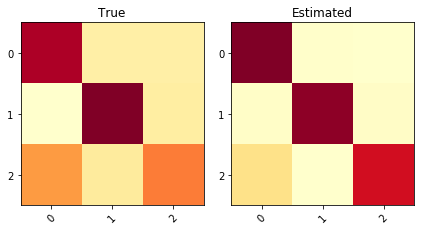

JS divergence: 0.0713	KL divergence: 0.3154


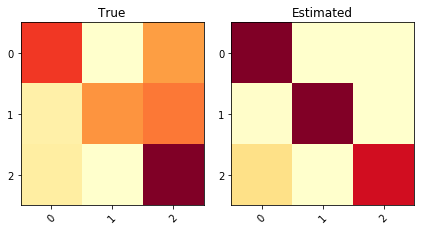

JS divergence: 0.1859	KL divergence: 1.1449


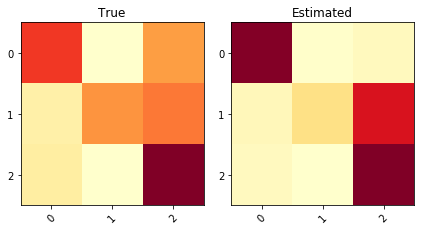

JS divergence: 0.0742	KL divergence: 0.2781


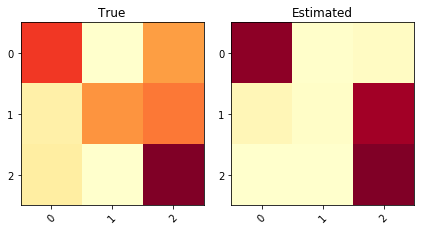

JS divergence: 0.1490	KL divergence: 0.7448


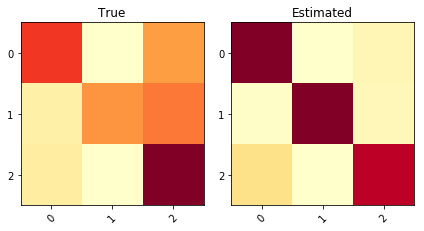

JS divergence: 0.1228	KL divergence: 0.4584


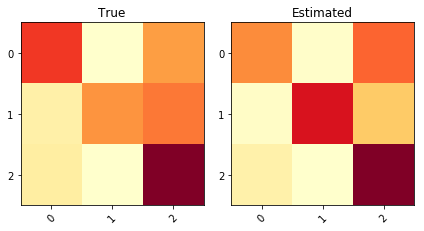

JS divergence: 0.0305	KL divergence: 0.0893


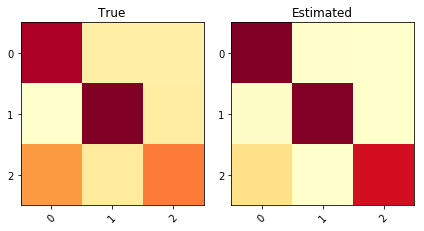

JS divergence: 0.0784	KL divergence: 0.3793


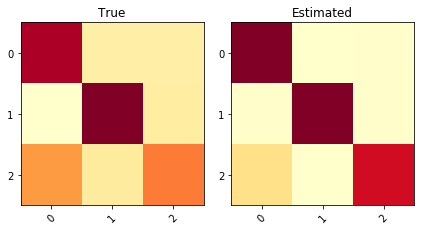

JS divergence: 0.0699	KL divergence: 0.2940


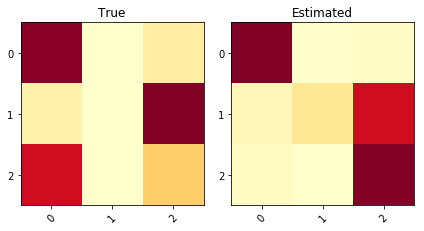

JS divergence: 0.1875	KL divergence: 0.7582


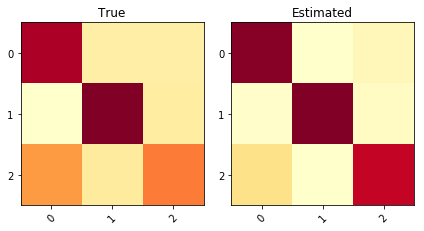

JS divergence: 0.0567	KL divergence: 0.2277


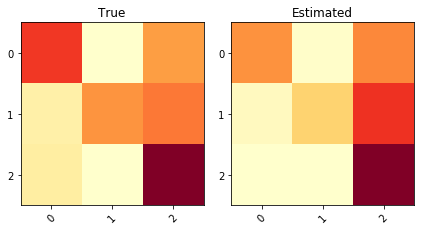

JS divergence: 0.0319	KL divergence: 0.1322


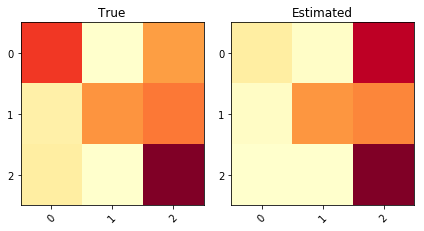

JS divergence: 0.0862	KL divergence: 0.3137


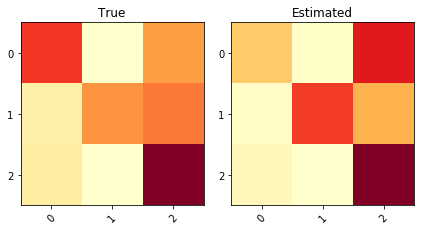

JS divergence: 0.0447	KL divergence: 0.1317
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
   0  Global    0.911681      0.911681   0.529978    0.11613    0.560983    0.118111     0.173505       0.17749
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
A result
 ====  ========================  ====================  =========================  =====================
  ..    Mean ACC imiting Annot    Mean cross-entropy    Wmean ACC imiting Annot    wMean cross entropy
====  ========================  ====================  =========================  =====================
   0                  0.749202              0.594292               

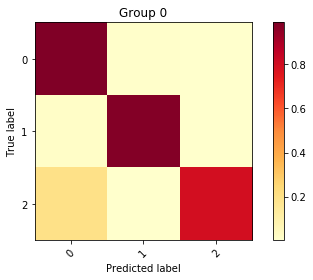

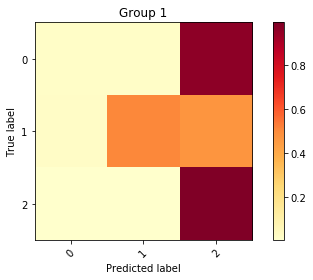

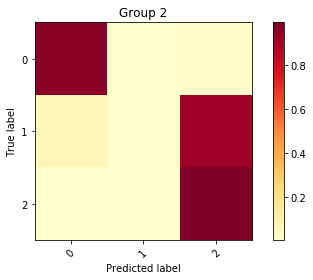

Inertia: 0.38083673390353273
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.399224    3957   0.228949     0.923131  0.0849029       0.940531   0.884696    0.758242      0.758242
   1         1  0.242535    2404   0.335548     0.506581  1.55844         0.40288    0.259871    0.34188       0.34188
   2         2  0.358241    3551   0.159925     0.659232  1.48429         0.533451   0.488848    0.638584      0.638584
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ========

In [25]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (1) multiples runs***
Train


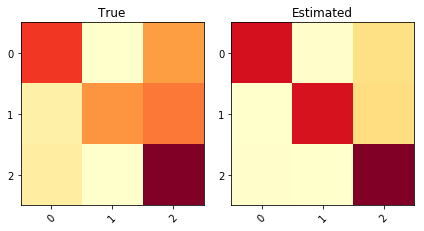

KL divergence: 0.2838	Pearson Correlation between diagonals: 0.9304


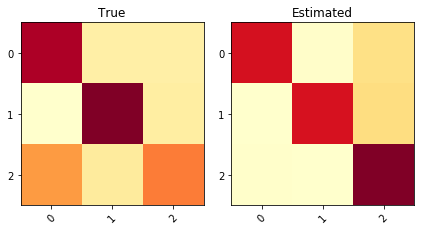

KL divergence: 0.6732	Pearson Correlation between diagonals: -0.9841


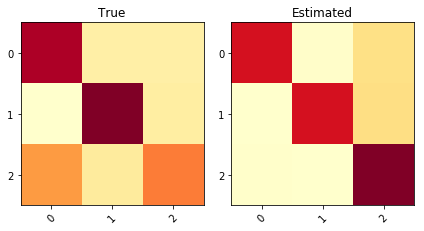

KL divergence: 0.6672	Pearson Correlation between diagonals: -0.9815


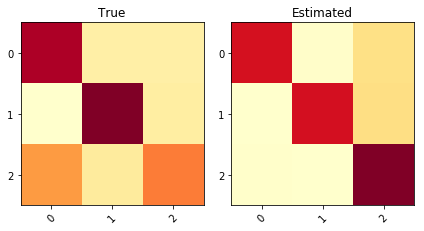

KL divergence: 0.6644	Pearson Correlation between diagonals: -0.9802


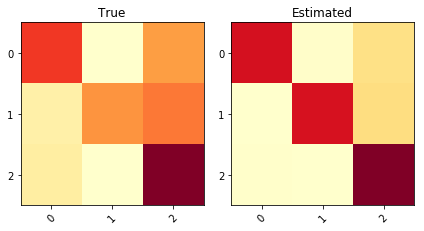

KL divergence: 0.2848	Pearson Correlation between diagonals: 0.9282


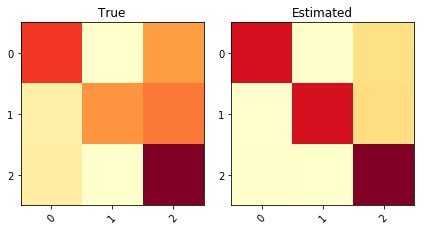

KL divergence: 0.2840	Pearson Correlation between diagonals: 0.9296


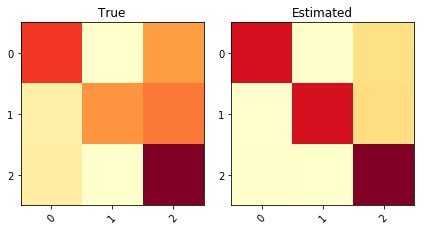

KL divergence: 0.2840	Pearson Correlation between diagonals: 0.9289


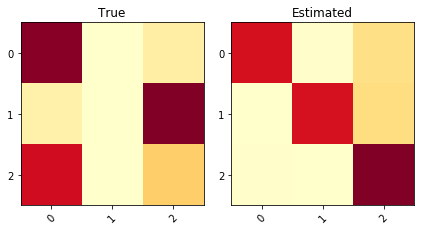

KL divergence: 1.6128	Pearson Correlation between diagonals: -0.2187


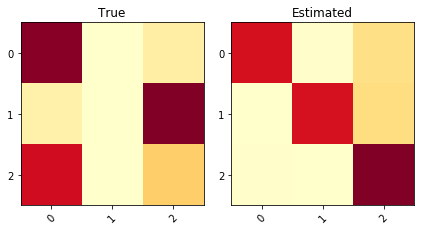

KL divergence: 1.6123	Pearson Correlation between diagonals: -0.2162


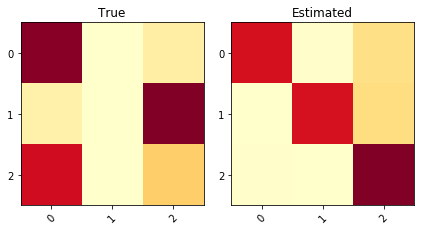

KL divergence: 1.6127	Pearson Correlation between diagonals: -0.2189


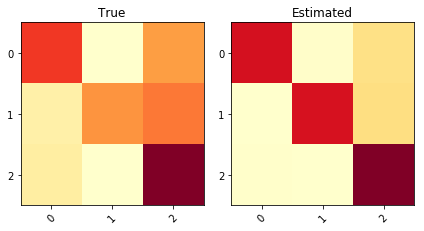

KL divergence: 0.2853	Pearson Correlation between diagonals: 0.9271


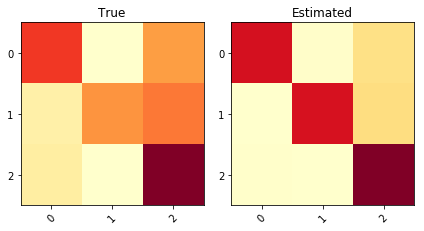

KL divergence: 0.2846	Pearson Correlation between diagonals: 0.9289


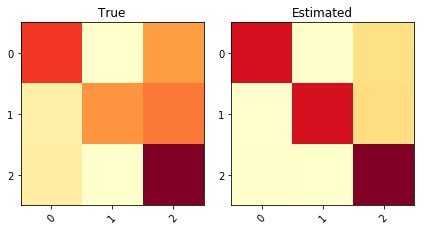

KL divergence: 0.2840	Pearson Correlation between diagonals: 0.9297


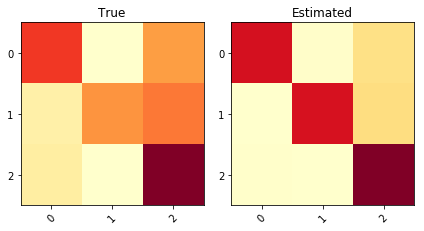

KL divergence: 0.2850	Pearson Correlation between diagonals: 0.9281


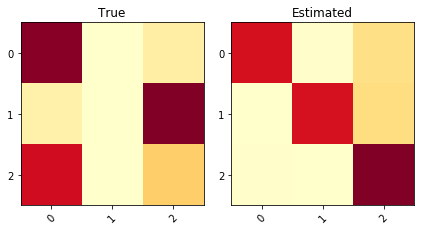

KL divergence: 1.6136	Pearson Correlation between diagonals: -0.2210
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global    0.901099      0.901099   0.634778  0.0958811            0.227621        0.196777
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.601578                  0.8074
====  =======================  ======================
Test


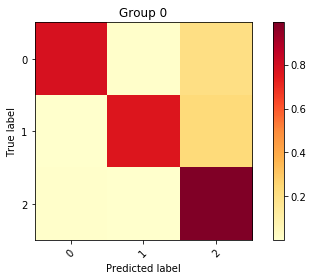

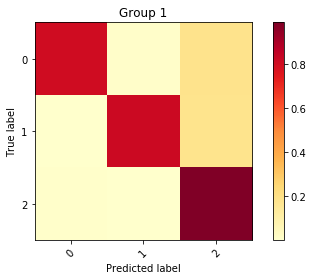

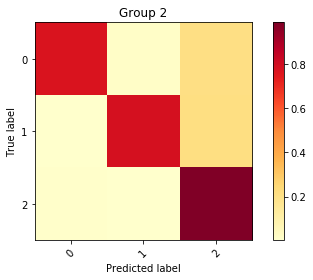

Inertia: 0.0006941696677434569
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.509769    5097   0.383405     0.847461   0.172483       0.91685    0.514128    0.664225      0.664225
   1         1  0.293071    2930   0.358103     0.871508   0.142037       0.931042   0.538174    0.714286      0.714286
   2         2  0.19716     1971   0.39276      0.850331   0.168667       0.918604   0.516998    0.684982      0.684982
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =====

In [28]:
evaluate = Evaluation_metrics(gMixture1,'our1') 
aux = gMixture1.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (1) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture1.base_model.predict_classes(Xstd_train)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture1.get_confusionM()
y_o_groups = gMixture1.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture1.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours (2) multiples runs***
Train


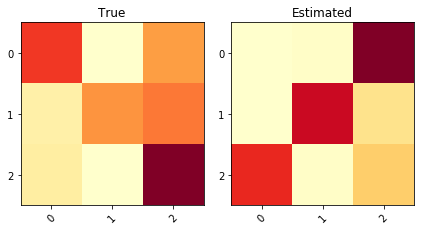

KL divergence: 1.7661	Pearson Correlation between diagonals: -0.5460


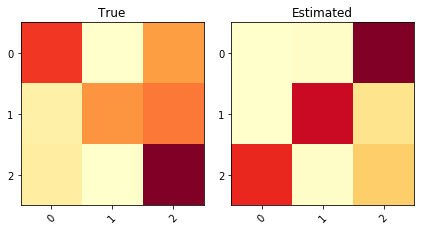

KL divergence: 1.7643	Pearson Correlation between diagonals: -0.5443


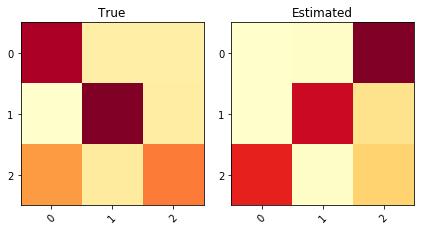

KL divergence: 2.0180	Pearson Correlation between diagonals: 0.3831


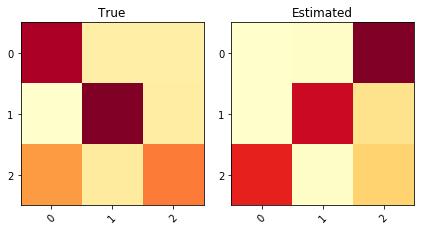

KL divergence: 2.0076	Pearson Correlation between diagonals: 0.3859


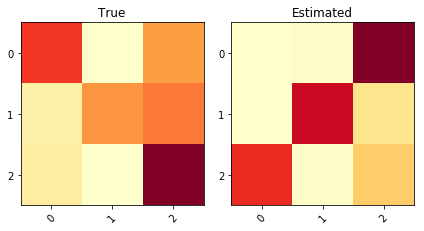

KL divergence: 1.7616	Pearson Correlation between diagonals: -0.5425


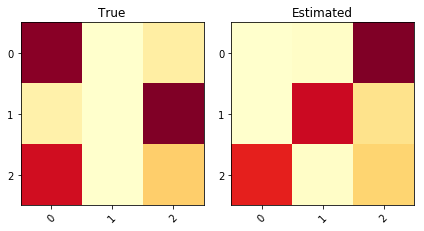

KL divergence: 2.7140	Pearson Correlation between diagonals: -0.9029


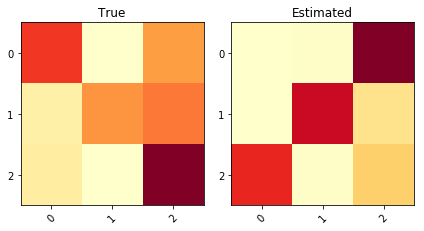

KL divergence: 1.7675	Pearson Correlation between diagonals: -0.5492


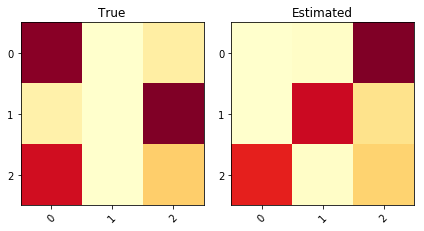

KL divergence: 2.7136	Pearson Correlation between diagonals: -0.9038


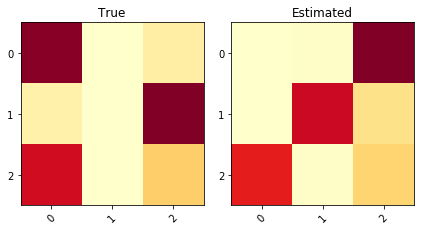

KL divergence: 2.7124	Pearson Correlation between diagonals: -0.9016


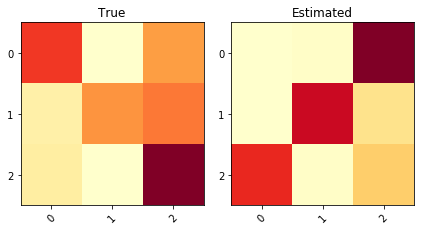

KL divergence: 1.7652	Pearson Correlation between diagonals: -0.5463


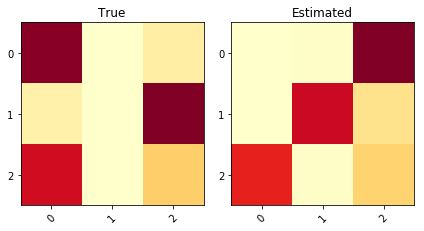

KL divergence: 2.7155	Pearson Correlation between diagonals: -0.9054


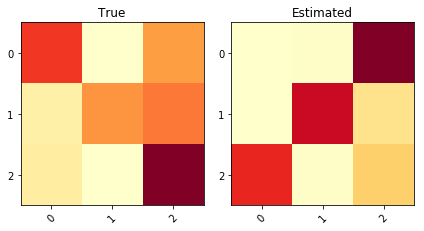

KL divergence: 1.7660	Pearson Correlation between diagonals: -0.5481


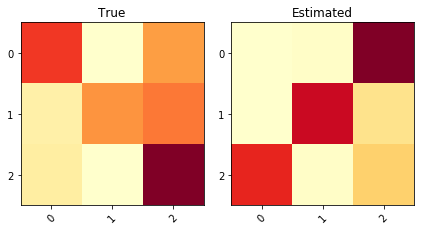

KL divergence: 1.7699	Pearson Correlation between diagonals: -0.5533


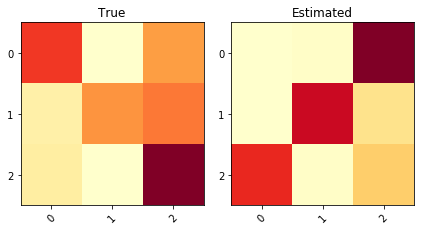

KL divergence: 1.7627	Pearson Correlation between diagonals: -0.5449


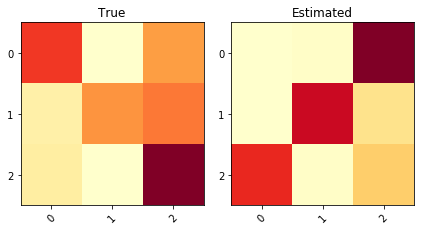

KL divergence: 1.7651	Pearson Correlation between diagonals: -0.5449
A result
 ====  ======  ==========  ============  =========  =========  ==================  ==============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Mean PearsonCorr    Average RMSE
====  ======  ==========  ============  =========  =========  ==================  ==============
   0  Global     0.37851       0.37851    2.01078   0.219762            -0.38238        0.203455
====  ======  ==========  ============  =========  =========  ==================  ==============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.599939                0.803456
====  =======================  ======================
Test


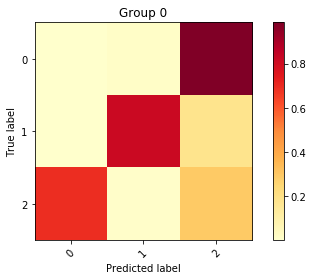

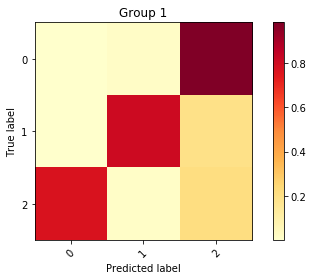

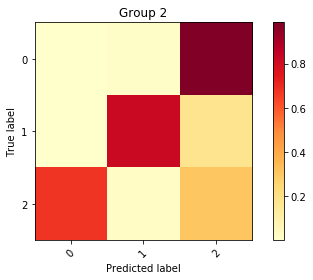

Inertia: 0.001275528554591195
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)     Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
   0         0  0.502056    5020   0.402793     0.372082    3.05296       0.469439  0.0387491     0.67033       0.67033
   1         1  0.309751    3097   0.393764     0.340686    3.00726       0.436325  0.00735291    0.65812       0.65812
   2         2  0.188194    1881   0.417051     0.376822    2.72234       0.474936  0.0434882     0.671551      0.671551
====  ========  ========  ======  =========  ===========  =========  =============  ==========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =

In [29]:
evaluate = Evaluation_metrics(gMixture2,'our1') 
aux = gMixture2.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours (2) multiples runs***") #--with tol *2 aka detenerlo antes

print("Train")
Z_train_pred = gMixture2.base_model.predict_classes(Xstd_train)
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture2.get_confusionM()
y_o_groups = gMixture2.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
Z_test_pred = gMixture2.base_model.predict_classes(Xstd_test)
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 6) configuration: Manny annot v1 bad MV ($T$ = 2000, $T_{max}$ = 10 )

In [42]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.6227106227106227


*** Soft-Majority (Train with softMV) ***
Train


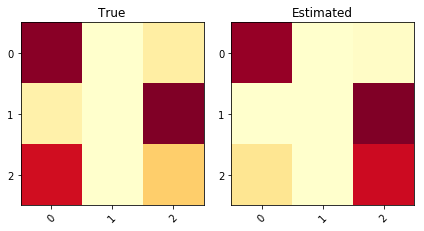

JS divergence: 0.1975	KL divergence: 0.4278


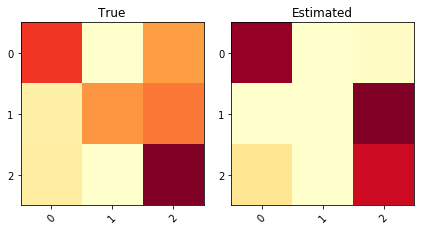

JS divergence: 0.0820	KL divergence: 0.1817


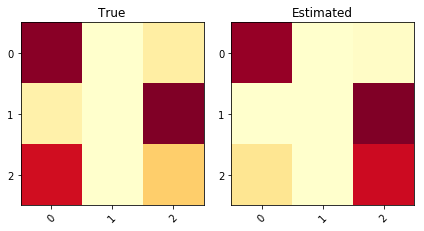

JS divergence: 0.1975	KL divergence: 0.4278


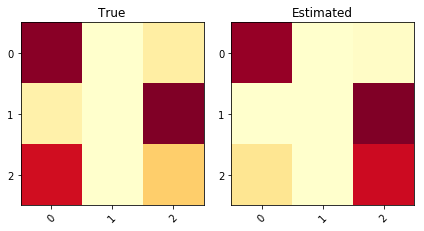

JS divergence: 0.1975	KL divergence: 0.4278


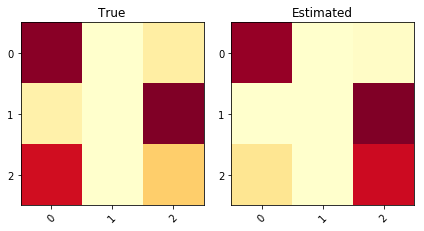

JS divergence: 0.1975	KL divergence: 0.4278


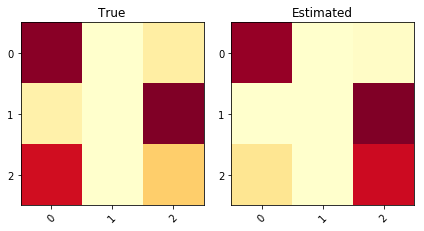

JS divergence: 0.1975	KL divergence: 0.4278


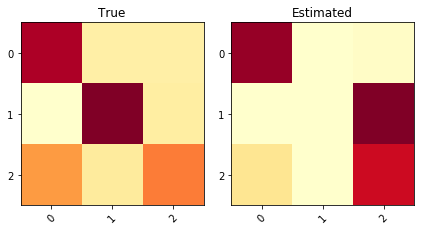

JS divergence: 0.2130	KL divergence: 1.3479


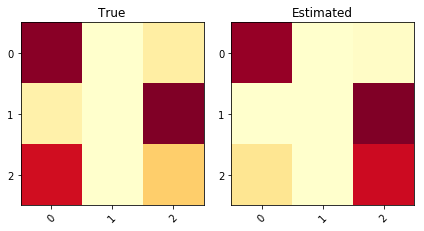

JS divergence: 0.1975	KL divergence: 0.4278


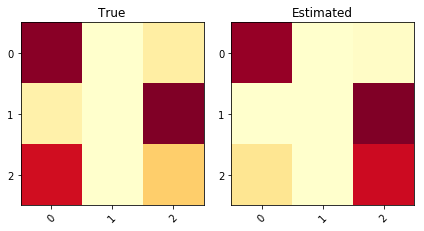

JS divergence: 0.1975	KL divergence: 0.4278


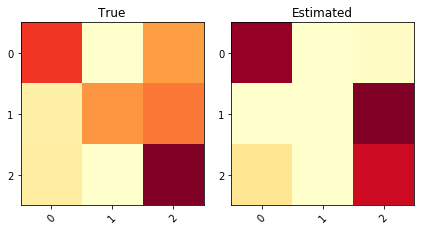

JS divergence: 0.0820	KL divergence: 0.1817


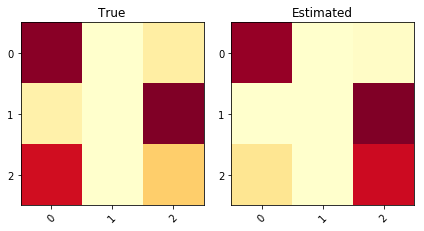

JS divergence: 0.1975	KL divergence: 0.4278


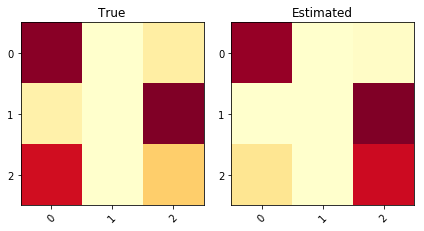

JS divergence: 0.1975	KL divergence: 0.4278


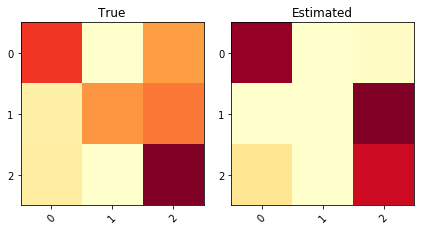

JS divergence: 0.0820	KL divergence: 0.1817


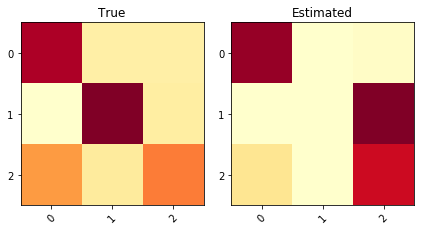

JS divergence: 0.2130	KL divergence: 1.3479


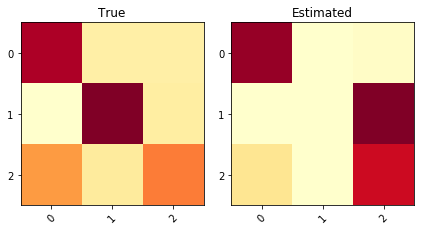

JS divergence: 0.2130	KL divergence: 1.3479
A result
 ====  ======  ==========  ============  =========  =========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS
====  ======  ==========  ============  =========  =========
   0  Global    0.599105      0.599105    0.56421   0.159955
====  ======  ==========  ============  =========  =========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.622711      0.622711
====  ======  ==========  ============


In [43]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train


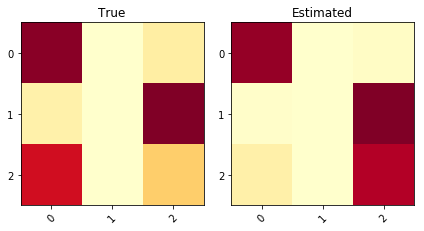

JS divergence: 0.1273	KL divergence: 0.2927


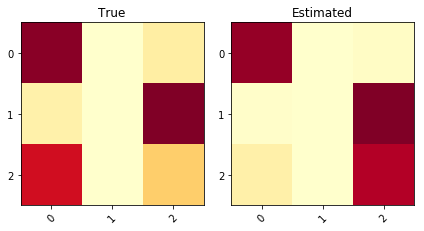

JS divergence: 0.1273	KL divergence: 0.2927


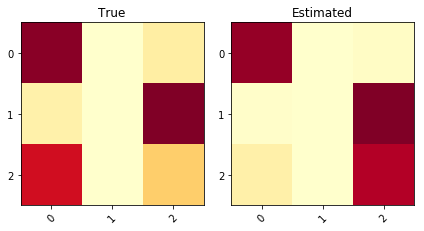

JS divergence: 0.1273	KL divergence: 0.2927


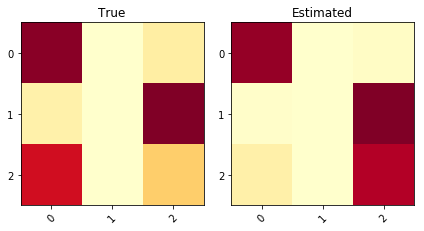

JS divergence: 0.1273	KL divergence: 0.2927


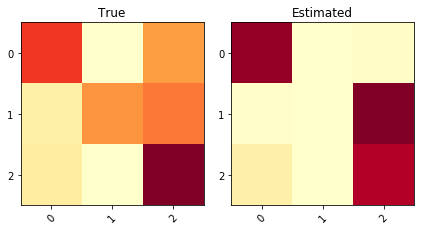

JS divergence: 0.1737	KL divergence: 2.3243


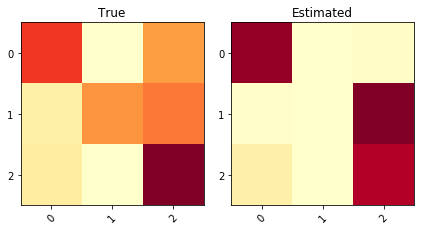

JS divergence: 0.1737	KL divergence: 2.3243


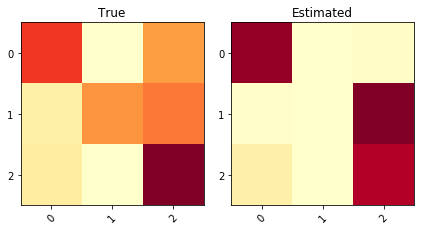

JS divergence: 0.1737	KL divergence: 2.3243


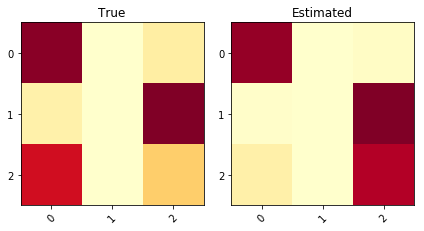

JS divergence: 0.1273	KL divergence: 0.2927


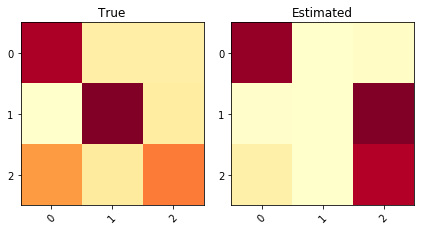

JS divergence: 0.3808	KL divergence: 6.0199


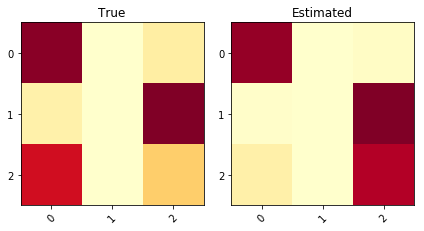

JS divergence: 0.1273	KL divergence: 0.2927


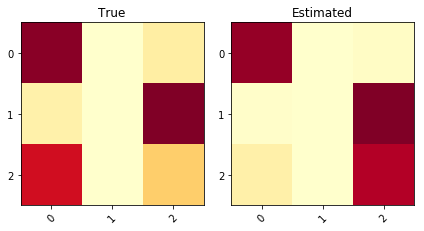

JS divergence: 0.1273	KL divergence: 0.2927


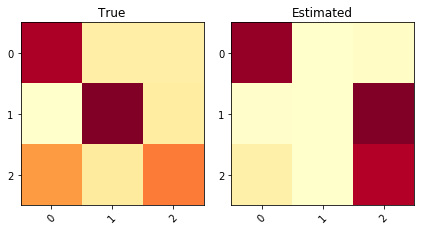

JS divergence: 0.3808	KL divergence: 6.0199


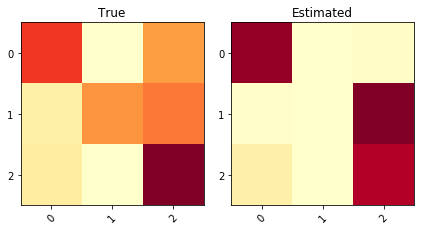

JS divergence: 0.1737	KL divergence: 2.3243


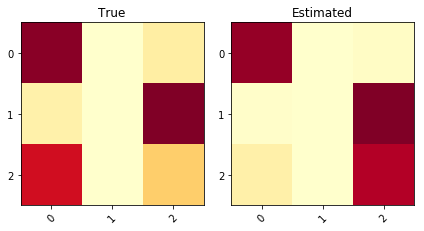

JS divergence: 0.1273	KL divergence: 0.2927


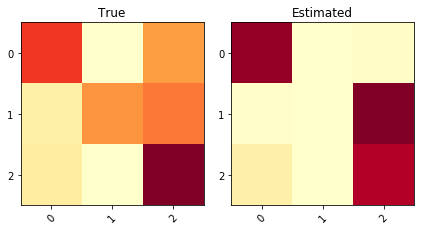

JS divergence: 0.1737	KL divergence: 2.3243
A result
 ====  ======  ==========  ============  =========  =========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS
====  ======  ==========  ============  =========  =========
   0  Global    0.619455      0.619455    2.41745   0.205771
====  ======  ==========  ============  =========  =========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.644689      0.644689
====  ======  ==========  ============


In [44]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train


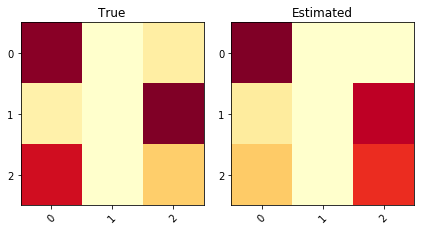

JS divergence: 0.0691	KL divergence: 0.5063


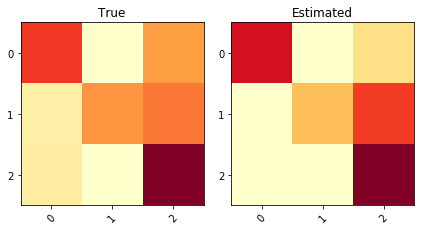

JS divergence: 0.0491	KL divergence: 0.8859


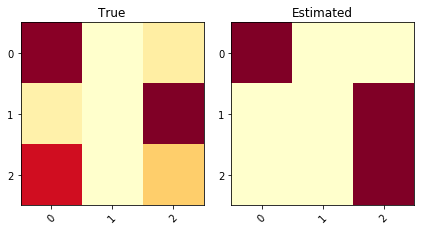

JS divergence: 0.2126	KL divergence: 4.6099


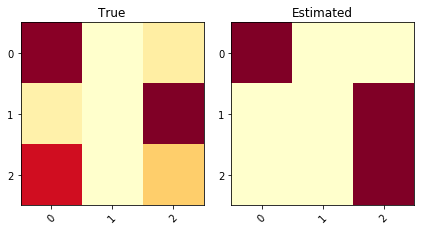

JS divergence: 0.2126	KL divergence: 4.6099


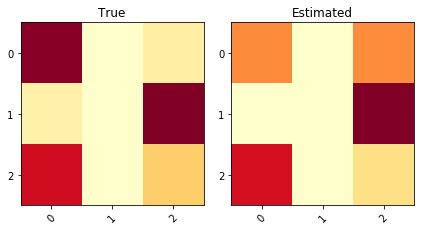

JS divergence: 0.0631	KL divergence: 0.4864


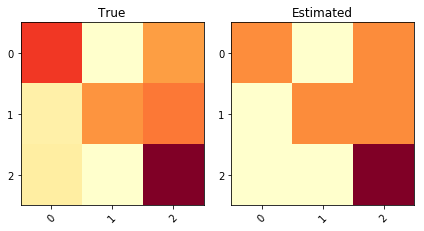

JS divergence: 0.0371	KL divergence: 0.8504


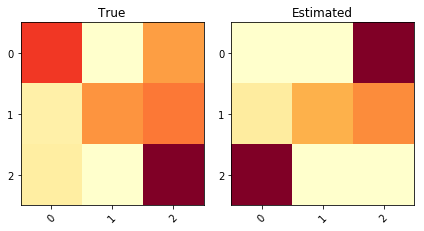

JS divergence: 0.3849	KL divergence: 7.7364


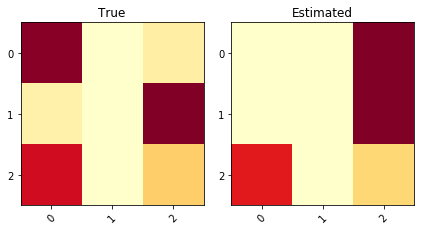

JS divergence: 0.2646	KL divergence: 5.0595


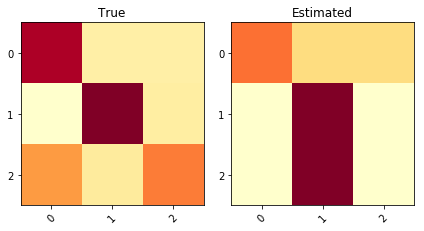

JS divergence: 0.2775	KL divergence: 4.8971


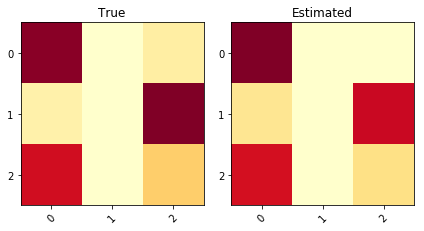

JS divergence: 0.0229	KL divergence: 0.4657


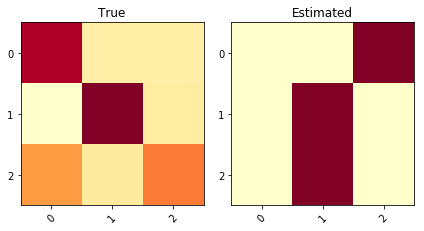

JS divergence: 0.5147	KL divergence: 9.3699


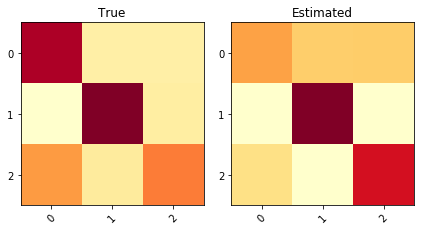

JS divergence: 0.0953	KL divergence: 1.1335


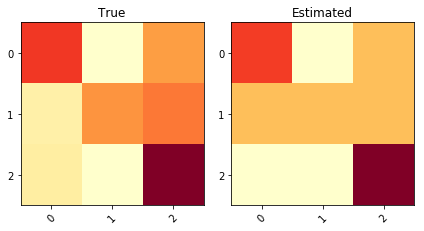

JS divergence: 0.0415	KL divergence: 0.5111


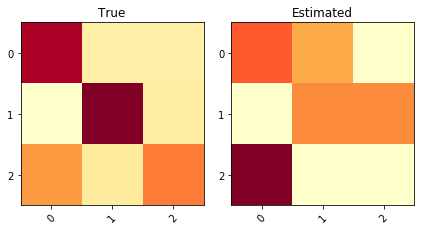

JS divergence: 0.2223	KL divergence: 3.4740


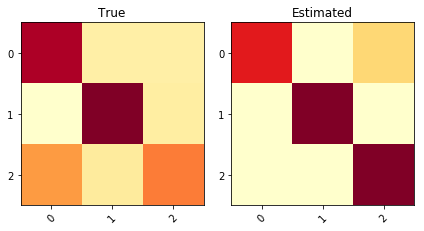

JS divergence: 0.1533	KL divergence: 3.3719
A result
 ====  ======  ==========  ============  =========  =========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS
====  ======  ==========  ============  =========  =========
   0  Global    0.674807      0.674807    2.09928   0.139405
====  ======  ==========  ============  =========  =========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.692308      0.692308
====  ======  ==========  ============


In [45]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


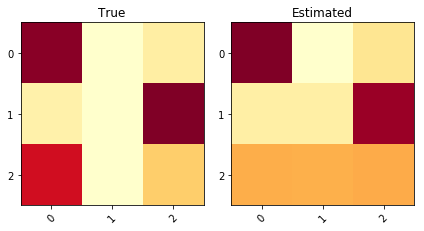

JS divergence: 0.1344	KL divergence: 0.3037


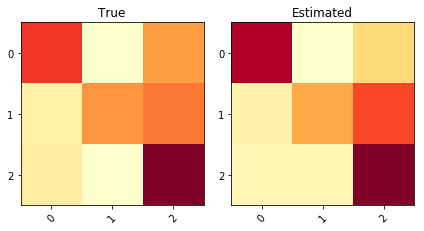

JS divergence: 0.0603	KL divergence: 0.1308


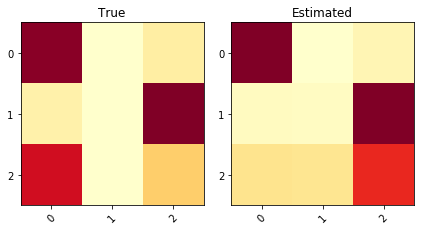

JS divergence: 0.1439	KL divergence: 0.3507


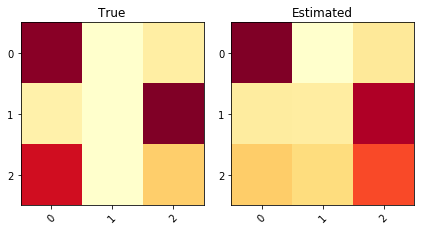

JS divergence: 0.1317	KL divergence: 0.3142


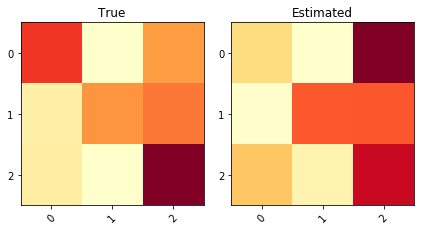

JS divergence: 0.0915	KL divergence: 0.2294


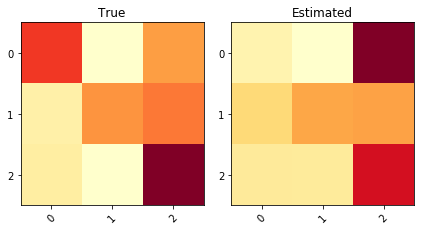

JS divergence: 0.1146	KL divergence: 0.3240


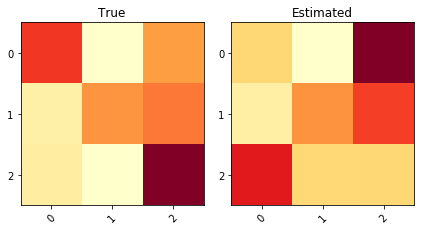

JS divergence: 0.1712	KL divergence: 0.4542


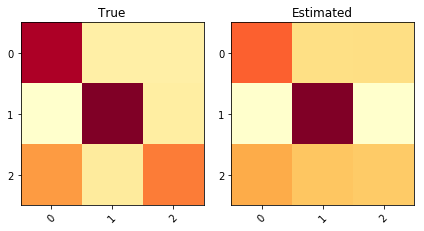

JS divergence: 0.0656	KL divergence: 0.1590


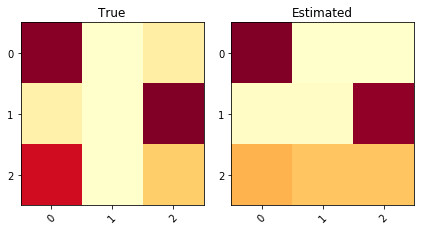

JS divergence: 0.1143	KL divergence: 0.2516


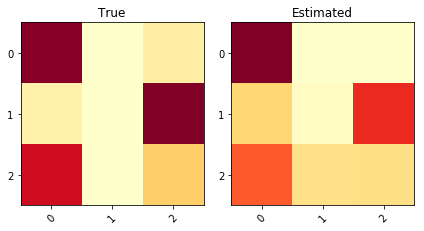

JS divergence: 0.1168	KL divergence: 0.2553


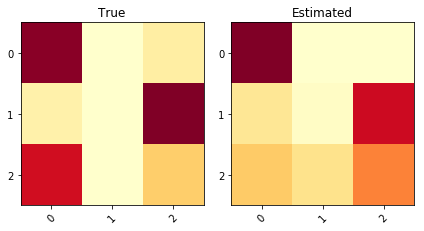

JS divergence: 0.1083	KL divergence: 0.2557


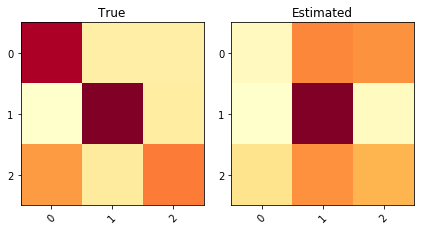

JS divergence: 0.1645	KL divergence: 0.4656


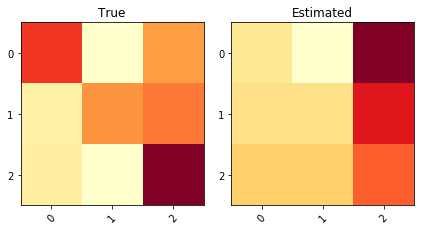

JS divergence: 0.1408	KL divergence: 0.3650


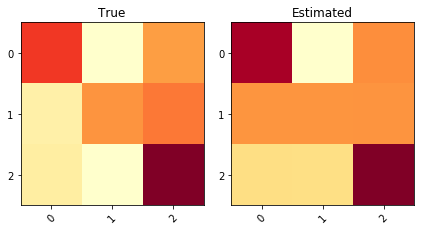

JS divergence: 0.0877	KL divergence: 0.1963


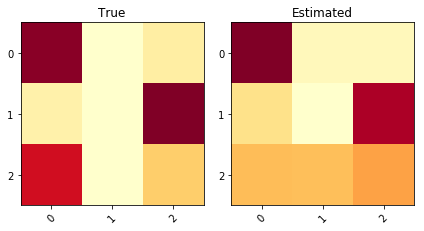

JS divergence: 0.1346	KL divergence: 0.3079
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
   0  Global    0.657306      0.657306   0.265789   0.111109    0.256232     0.10712     0.126173      0.124531
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                 0.747943                0.751687
====  =======================  ======================
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ====== 

In [46]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train,data=Z_train_p)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours Global multiples runs***
Train


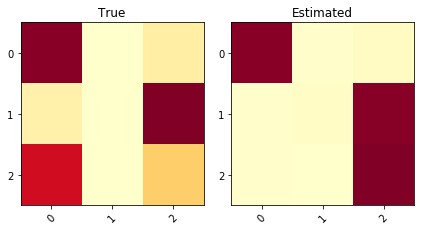

JS divergence: 0.1836	KL divergence: 0.9536


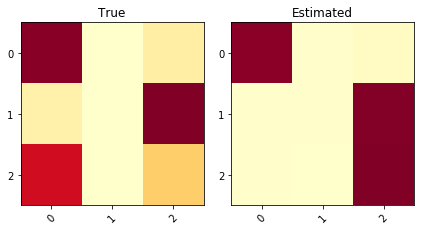

JS divergence: 0.1852	KL divergence: 1.0272


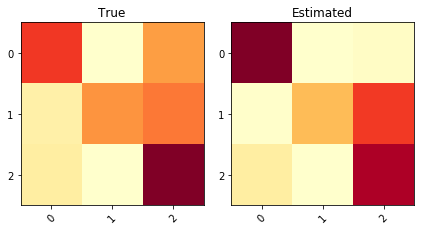

JS divergence: 0.0730	KL divergence: 0.3278


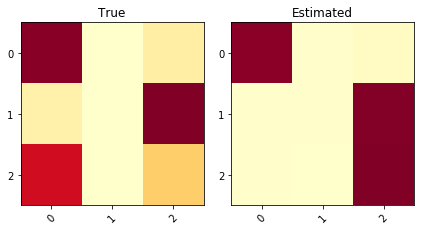

JS divergence: 0.1852	KL divergence: 1.0256


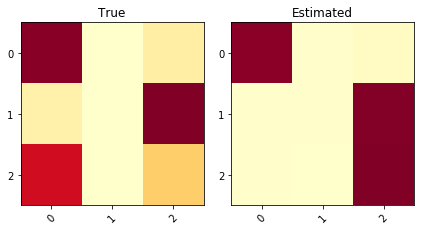

JS divergence: 0.1848	KL divergence: 1.0077


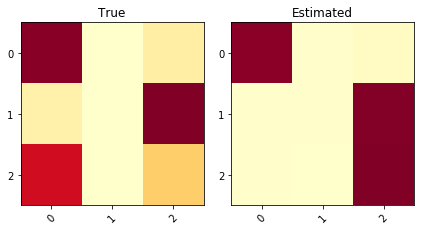

JS divergence: 0.1849	KL divergence: 1.0141


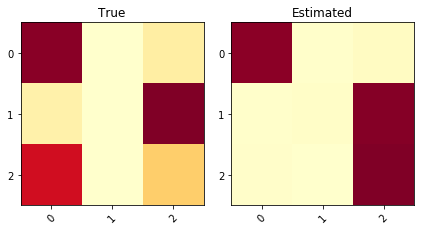

JS divergence: 0.1842	KL divergence: 0.9820


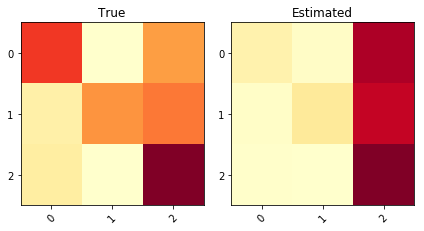

JS divergence: 0.1236	KL divergence: 0.4272


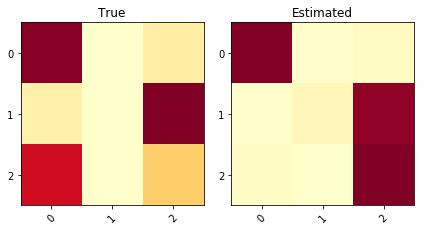

JS divergence: 0.1796	KL divergence: 0.8116


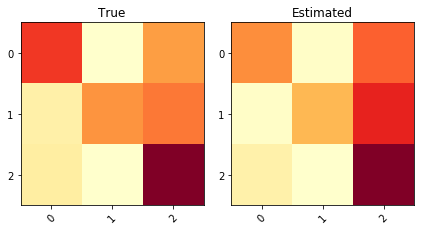

JS divergence: 0.0211	KL divergence: 0.0628


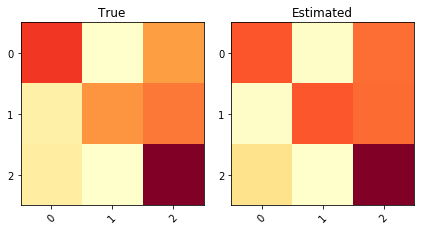

JS divergence: 0.0149	KL divergence: 0.0460


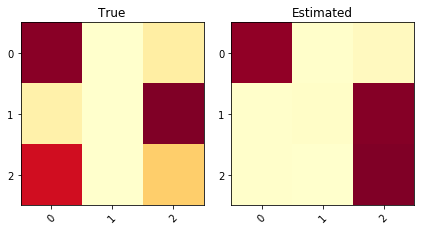

JS divergence: 0.1830	KL divergence: 0.9894


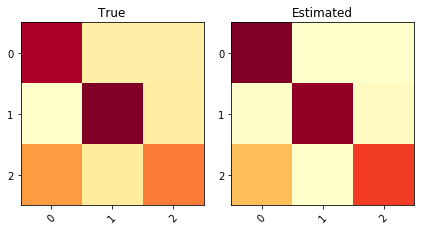

JS divergence: 0.0534	KL divergence: 0.2608


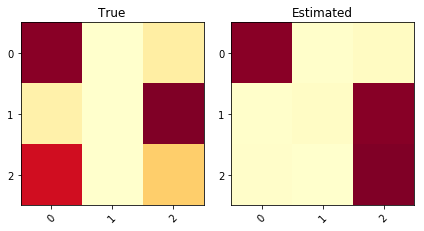

JS divergence: 0.1830	KL divergence: 0.9312


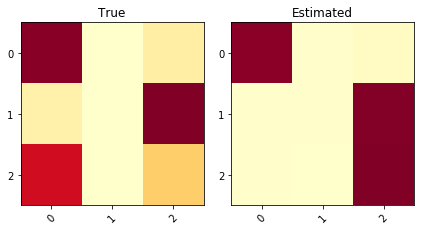

JS divergence: 0.1849	KL divergence: 1.0114
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
   0  Global    0.828246      0.828246   0.591227   0.126859      0.6007    0.127351     0.170099      0.170312
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
A result
 ====  =======================  ======================
  ..    ACC imiting Annotator    CE imiting Annotator
====  =======================  ======================
   0                  0.68612                0.672571
====  =======================  ======================
Test


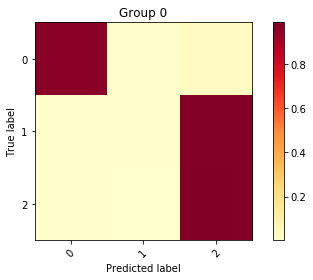

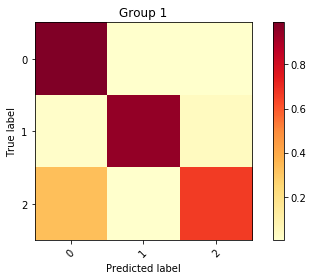

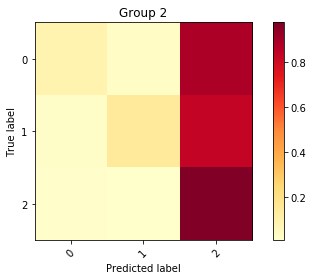

Inertia: 0.35404606122296894
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.399149     798   0.125511     0.653697   1.49741        0.529042   0.480545    0.605617      0.605617
   1         1  0.455877     911   0.315372     0.868432   0.156533       0.893004   0.802648    0.660562      0.660562
   2         2  0.144974     289   0.353014     0.404574   1.4494         0.292575   0.106861    0.333333      0.333333
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =======

In [47]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

#### 7) configuration: Manny annot v1 + soft ($T$ = 2000, $T_{max}$ = 10 )

In [21]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.7822547822547823


*** Soft-Majority (Train with softMV) ***
Train


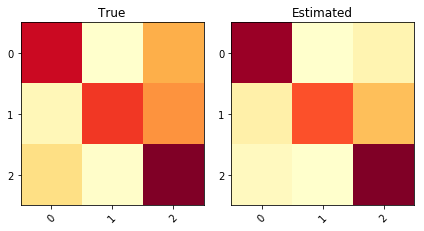

JS divergence: 0.1260	KL divergence: 0.3539


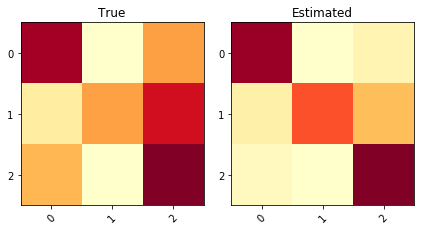

JS divergence: 0.1298	KL divergence: 0.2647


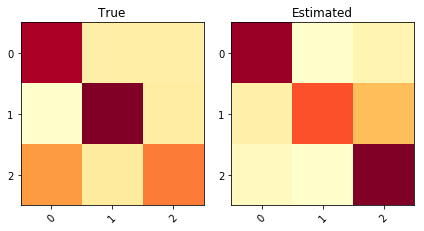

JS divergence: 0.2090	KL divergence: 0.8315


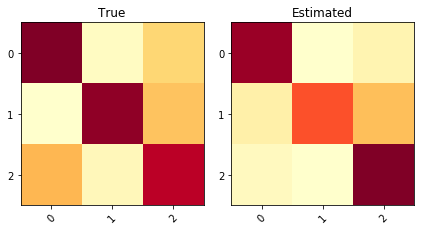

JS divergence: 0.1348	KL divergence: 0.5132


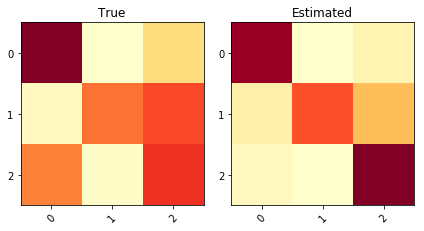

JS divergence: 0.1151	KL divergence: 0.3568


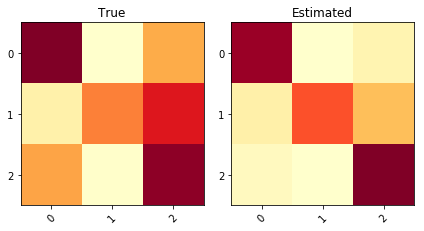

JS divergence: 0.1164	KL divergence: 0.2805


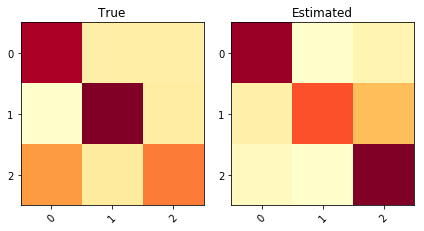

JS divergence: 0.2090	KL divergence: 0.8315


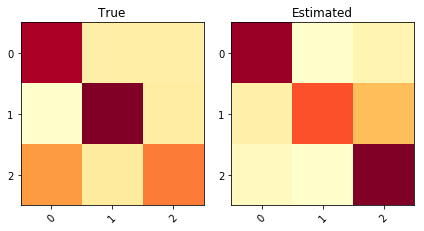

JS divergence: 0.2090	KL divergence: 0.8315


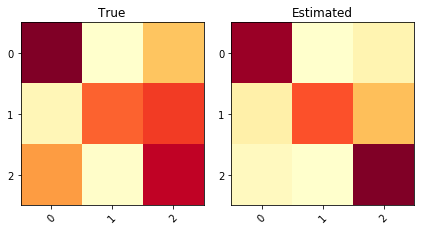

JS divergence: 0.1122	KL divergence: 0.3187


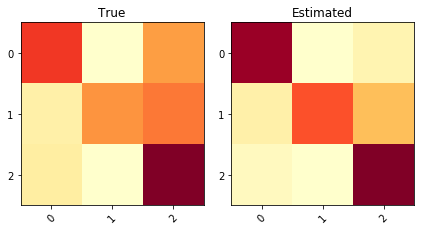

JS divergence: 0.1525	KL divergence: 0.3169


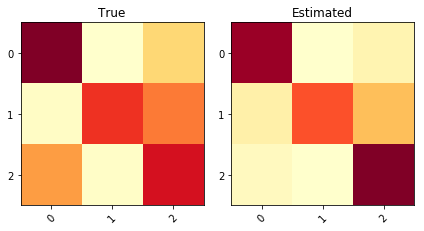

JS divergence: 0.1147	KL divergence: 0.3834


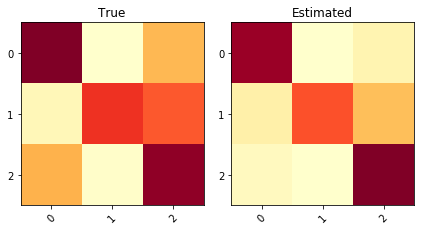

JS divergence: 0.1140	KL divergence: 0.3381


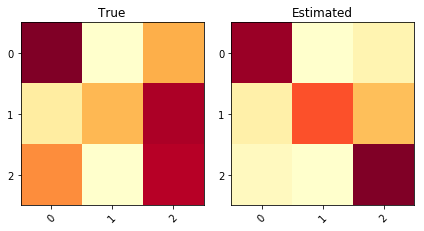

JS divergence: 0.1321	KL divergence: 0.2687


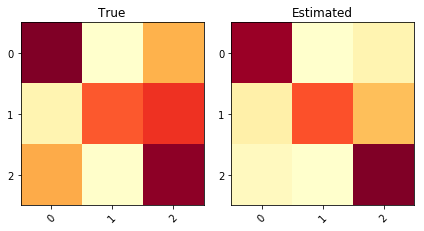

JS divergence: 0.1138	KL divergence: 0.3036


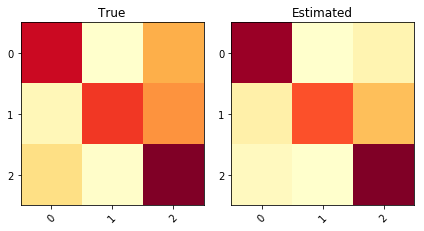

JS divergence: 0.1260	KL divergence: 0.3539
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS
====  ======  ==========  ============  =========  =========  ==========  ==========
   0  Global    0.822548      0.822548   0.376285   0.137079    0.376021    0.136797
====  ======  ==========  ============  =========  =========  ==========  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.808303      0.808303
====  ======  ==========  ============


In [23]:
#soft mv one
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train


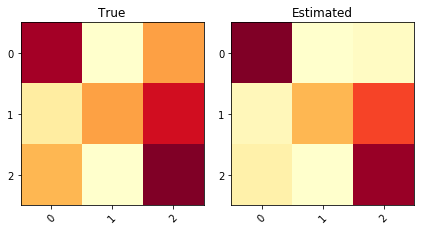

JS divergence: 0.0575	KL divergence: 0.1295


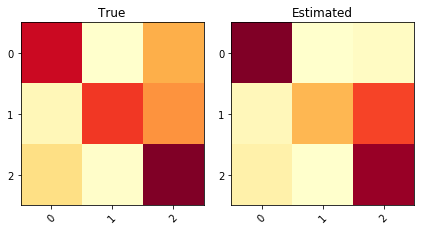

JS divergence: 0.0833	KL divergence: 0.3816


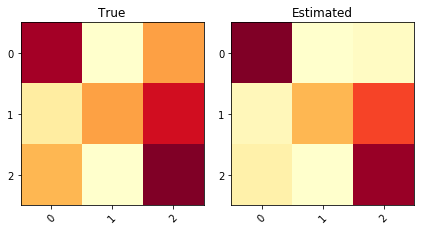

JS divergence: 0.0575	KL divergence: 0.1295


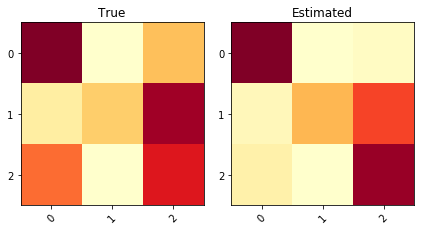

JS divergence: 0.0659	KL divergence: 0.1495


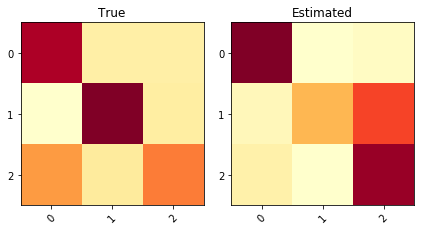

JS divergence: 0.2130	KL divergence: 1.3479


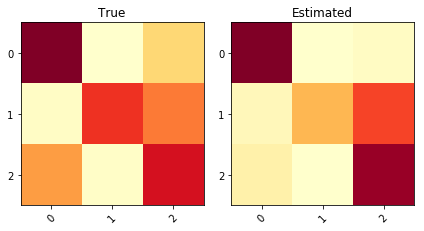

JS divergence: 0.0826	KL divergence: 0.5088


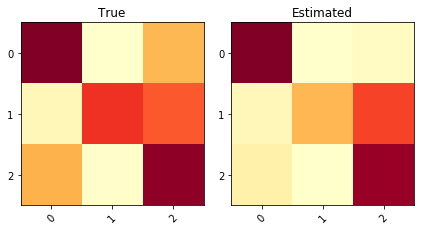

JS divergence: 0.0733	KL divergence: 0.3891


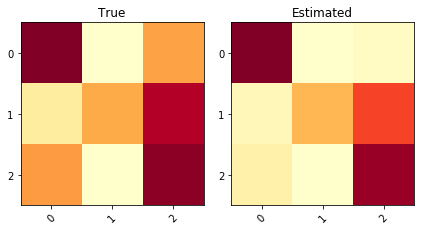

JS divergence: 0.0571	KL divergence: 0.1288


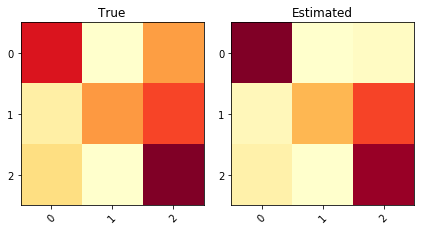

JS divergence: 0.0661	KL divergence: 0.1483


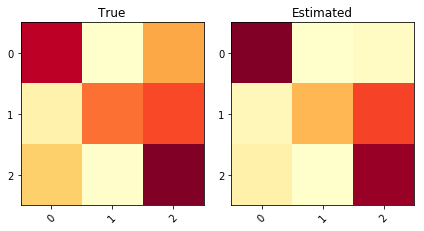

JS divergence: 0.0661	KL divergence: 0.2391


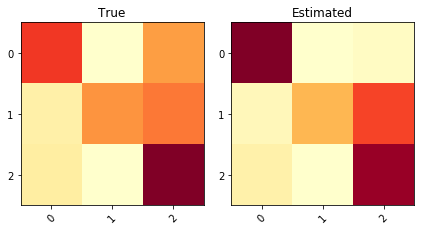

JS divergence: 0.0820	KL divergence: 0.1817


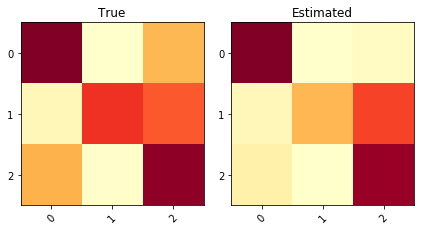

JS divergence: 0.0733	KL divergence: 0.3891


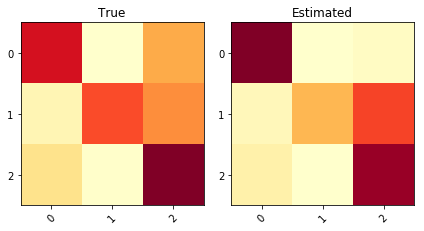

JS divergence: 0.0815	KL divergence: 0.3350


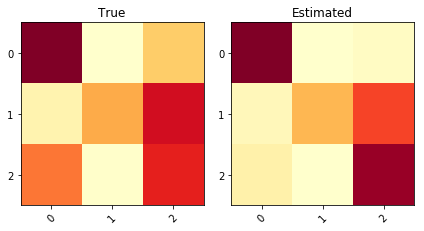

JS divergence: 0.0663	KL divergence: 0.2543


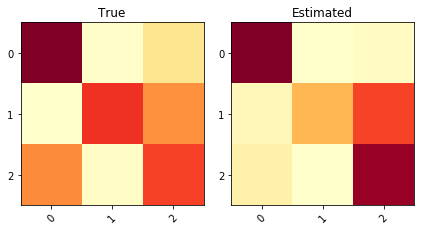

JS divergence: 0.0962	KL divergence: 0.6278
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS
====  ======  ==========  ============  =========  =========  ==========  ==========
   0  Global    0.736264      0.736264   0.402163  0.0894108    0.402483   0.0892522
====  ======  ==========  ============  =========  =========  ==========  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.735043      0.735043
====  ======  ==========  ============


In [25]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train


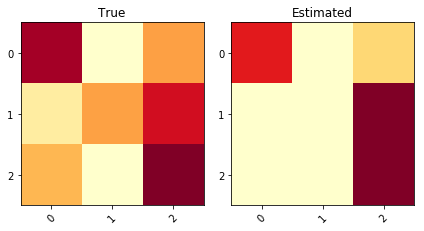

JS divergence: 0.1311	KL divergence: 3.1260


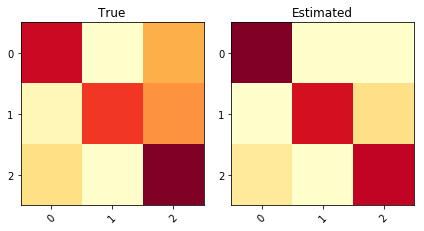

JS divergence: 0.0961	KL divergence: 2.0378


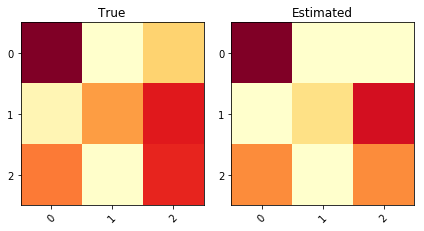

JS divergence: 0.0696	KL divergence: 1.4868


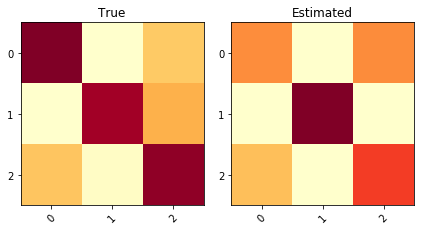

JS divergence: 0.0997	KL divergence: 2.0555


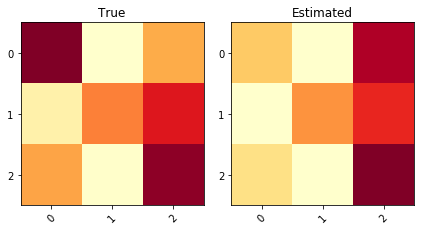

JS divergence: 0.0778	KL divergence: 0.6026


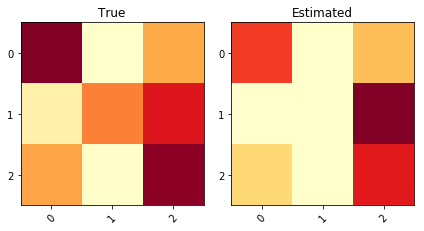

JS divergence: 0.0984	KL divergence: 2.2491


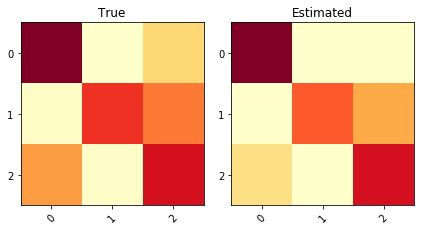

JS divergence: 0.0730	KL divergence: 1.5821


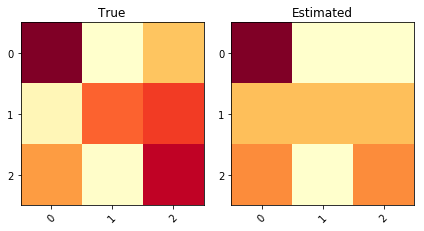

JS divergence: 0.0894	KL divergence: 0.8727


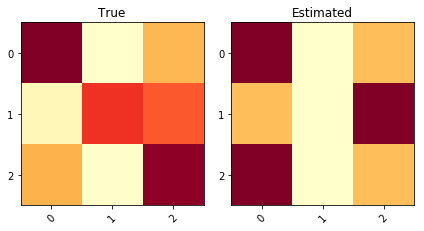

JS divergence: 0.1694	KL divergence: 2.8416


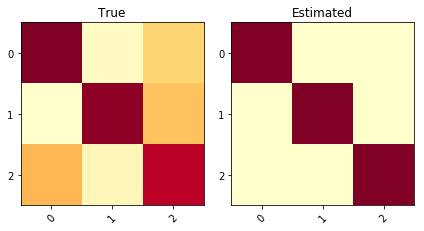

JS divergence: 0.1731	KL divergence: 3.3506


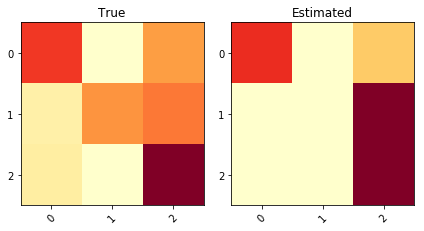

JS divergence: 0.1286	KL divergence: 2.9174


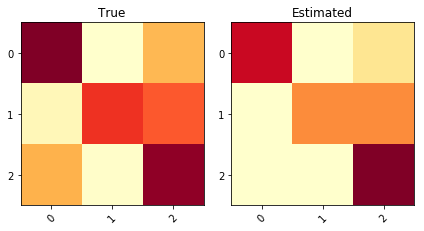

JS divergence: 0.0796	KL divergence: 1.8360


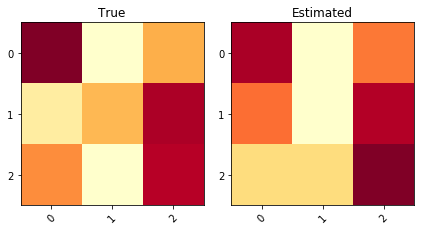

JS divergence: 0.1051	KL divergence: 1.3130


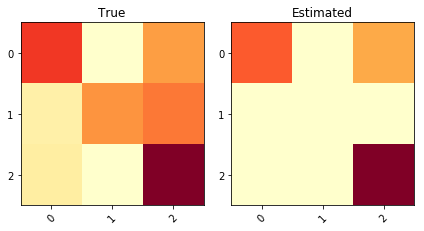

JS divergence: 0.0728	KL divergence: 0.5085


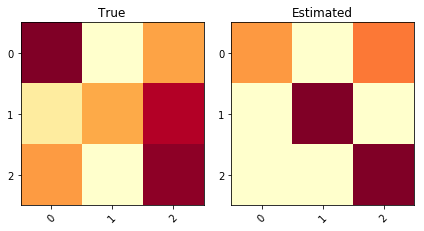

JS divergence: 0.2458	KL divergence: 5.1028
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS
====  ======  ==========  ============  =========  =========  ==========  ==========
   0  Global    0.920635      0.920635    2.41456   0.137457     2.19636    0.126011
====  ======  ==========  ============  =========  =========  ==========  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global     0.92674       0.92674
====  ======  ==========  ============


In [26]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


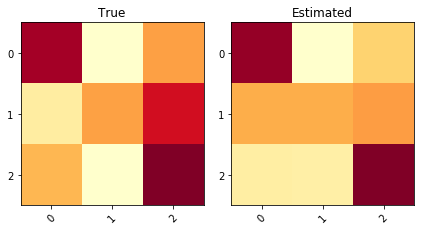

JS divergence: 0.0858	KL divergence: 0.1890


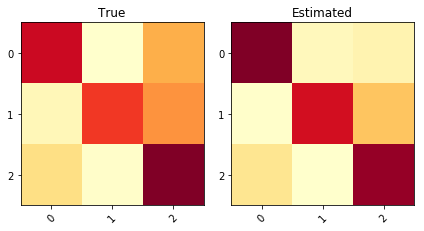

JS divergence: 0.0284	KL divergence: 0.0724


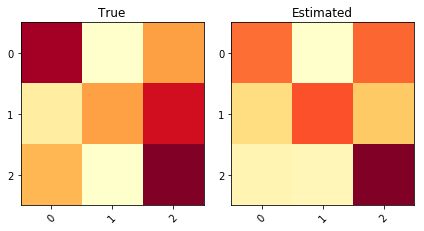

JS divergence: 0.0808	KL divergence: 0.1942


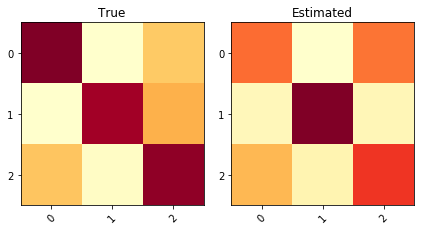

JS divergence: 0.0450	KL divergence: 0.1180


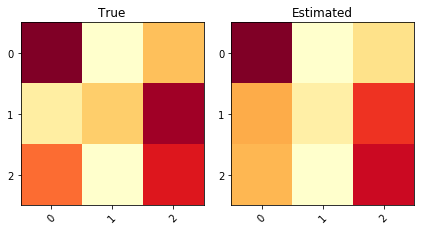

JS divergence: 0.0590	KL divergence: 0.1307


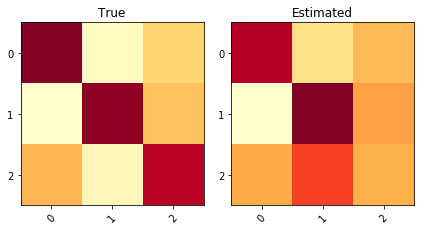

JS divergence: 0.0704	KL divergence: 0.1809


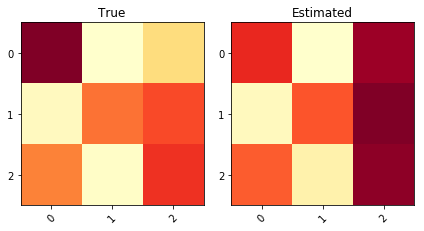

JS divergence: 0.0485	KL divergence: 0.1279


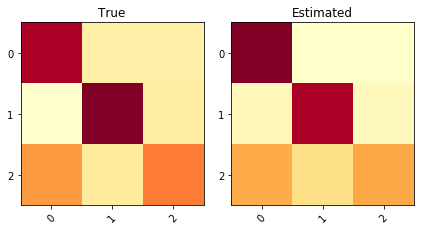

JS divergence: 0.0451	KL divergence: 0.1014


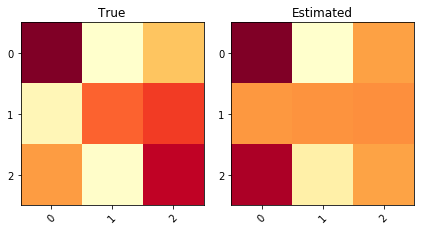

JS divergence: 0.0673	KL divergence: 0.1723


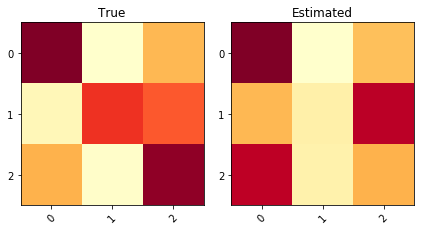

JS divergence: 0.0886	KL divergence: 0.2561


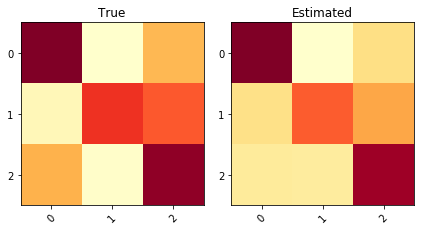

JS divergence: 0.0359	KL divergence: 0.0858


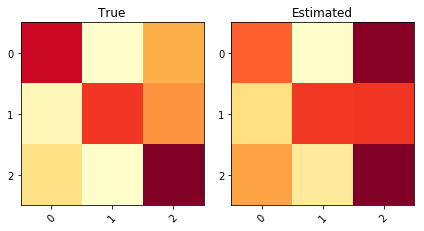

JS divergence: 0.0569	KL divergence: 0.1476


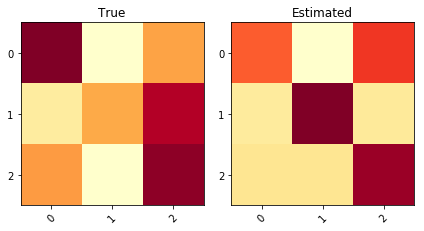

JS divergence: 0.1219	KL divergence: 0.3085


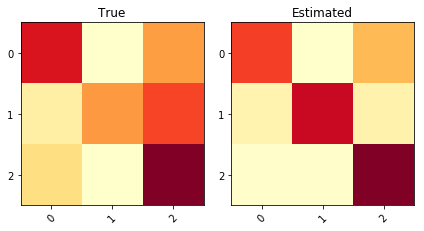

JS divergence: 0.0761	KL divergence: 0.1958


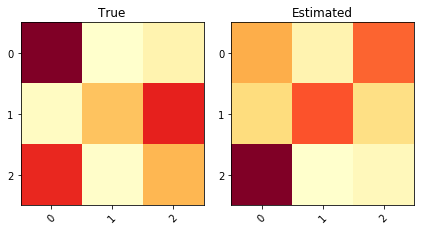

JS divergence: 0.1291	KL divergence: 0.3543
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
   0  Global     0.84534       0.84534   0.190983  0.0764432    0.181949   0.0727143     0.150384      0.148878
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
A result
 ====  ========================  ====================  =========================  =====================
  ..    Mean ACC imiting Annot    Mean cross-entropy    Wmean ACC imiting Annot    wMean cross entropy
====  ========================  ====================  =========================  =====================
   0                  0.677985              0.856763               

In [27]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train,data=Z_train_p)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours Global multiples runs***
Train


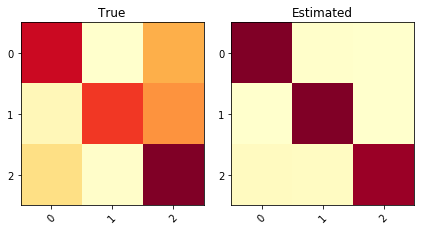

JS divergence: 0.1554	KL divergence: 0.9645


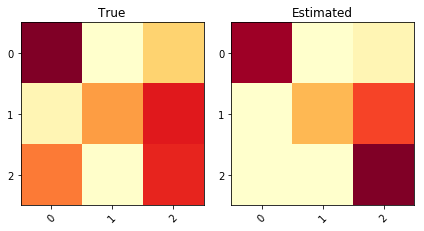

JS divergence: 0.0876	KL divergence: 0.4325


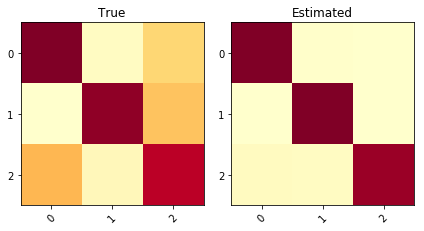

JS divergence: 0.1236	KL divergence: 0.6820


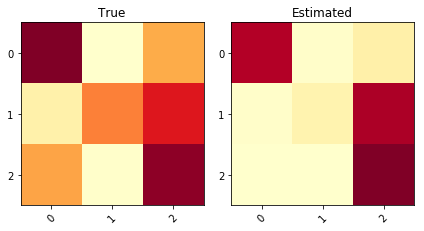

JS divergence: 0.1050	KL divergence: 0.5030


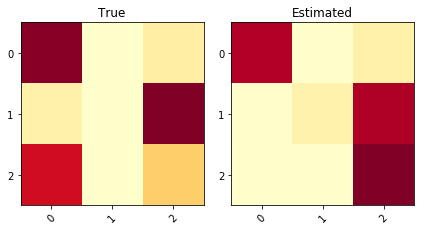

JS divergence: 0.1969	KL divergence: 1.1453


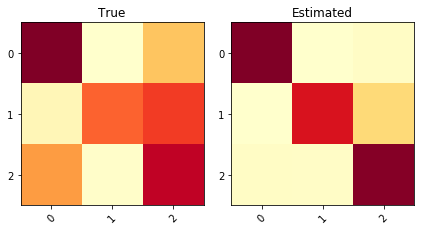

JS divergence: 0.1017	KL divergence: 0.4082


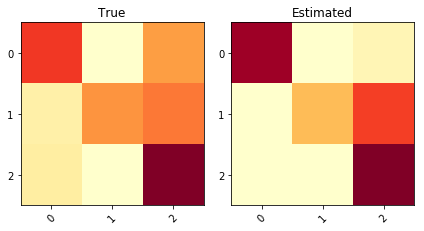

JS divergence: 0.0626	KL divergence: 0.2279


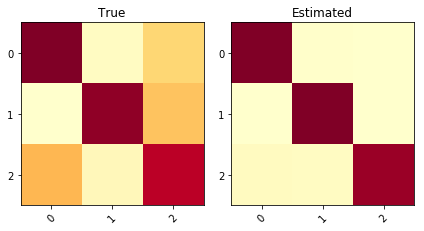

JS divergence: 0.1237	KL divergence: 0.6831


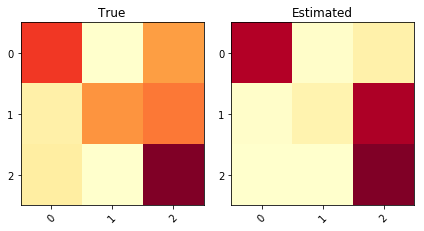

JS divergence: 0.0961	KL divergence: 0.3501


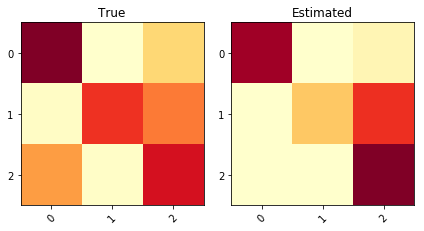

JS divergence: 0.0912	KL divergence: 0.4078


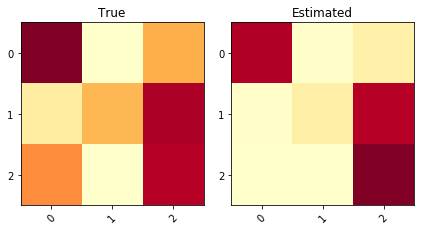

JS divergence: 0.0964	KL divergence: 0.5003


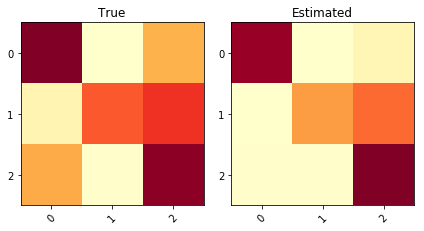

JS divergence: 0.0673	KL divergence: 0.2941


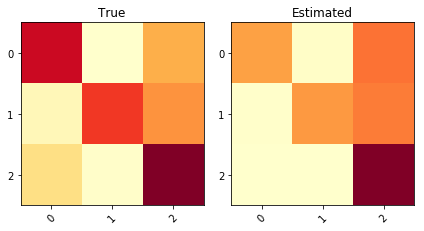

JS divergence: 0.0518	KL divergence: 0.2289


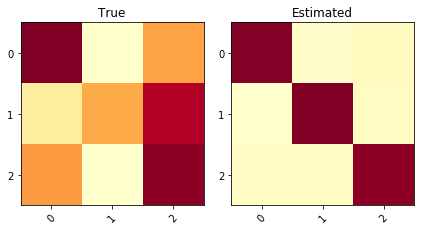

JS divergence: 0.2138	KL divergence: 0.9011


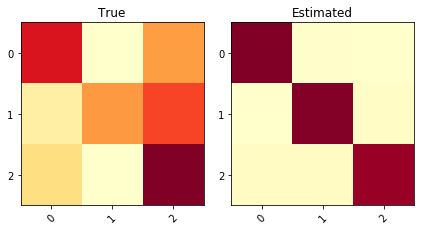

JS divergence: 0.1977	KL divergence: 0.9999
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
   0  Global    0.894587      0.894587   0.585882   0.124883    0.591474    0.125279     0.185192      0.183877
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
A result
 ====  ========================  ====================  =========================  =====================
  ..    Mean ACC imiting Annot    Mean cross-entropy    Wmean ACC imiting Annot    wMean cross entropy
====  ========================  ====================  =========================  =====================
   0                  0.666401              0.757745               

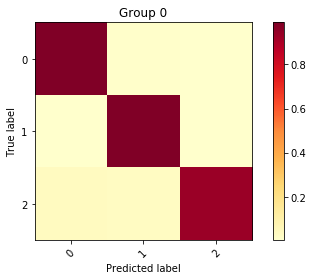

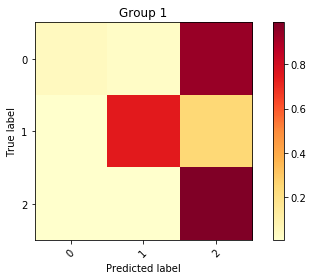

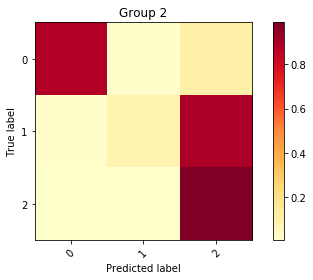

Inertia: 0.30906477997767395
A result
 ====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups      Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.508974    1017   0.141239     0.970559  0.0302601       0.978342   0.955838    0.89011       0.89011
   1         1  0.236059     472   0.316448     0.590981  1.1731          0.507368   0.386471    0.382173      0.382173
   2         2  0.254966     509   0.28075      0.653221  0.860866        0.592014   0.479831    0.638584      0.638584
====  ========  ========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ========

In [30]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
### uno de prueba.. maany annot (15k)

In [12]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))

ACC MV on train: 0.8262108262108262


*** Soft-Majority (Train with softMV) ***
Train


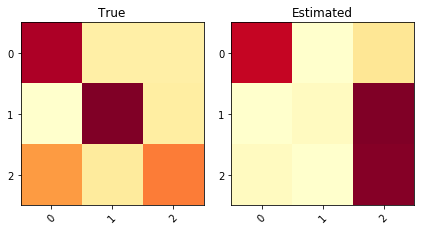

JS divergence: 0.2130	KL divergence: 1.3479


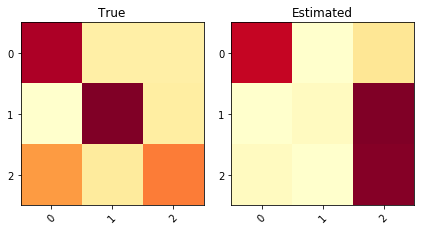

JS divergence: 0.2130	KL divergence: 1.3479


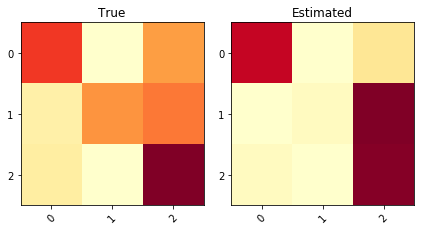

JS divergence: 0.0820	KL divergence: 0.1817


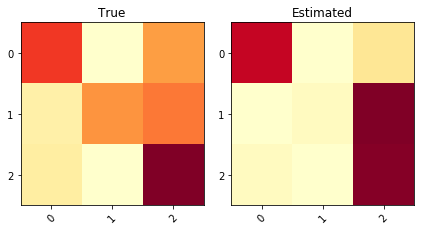

JS divergence: 0.0820	KL divergence: 0.1817


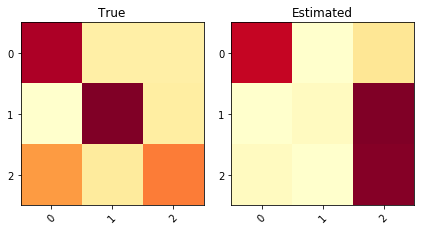

JS divergence: 0.2130	KL divergence: 1.3479


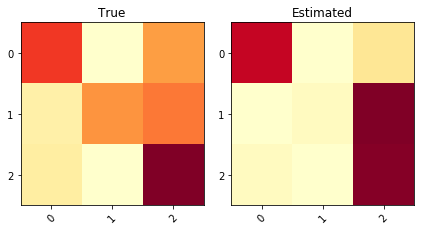

JS divergence: 0.0820	KL divergence: 0.1817


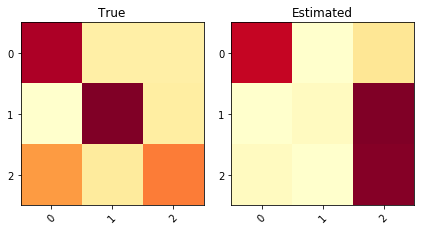

JS divergence: 0.2130	KL divergence: 1.3479


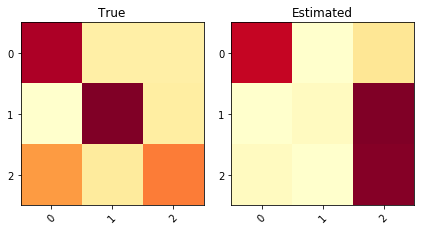

JS divergence: 0.2130	KL divergence: 1.3479


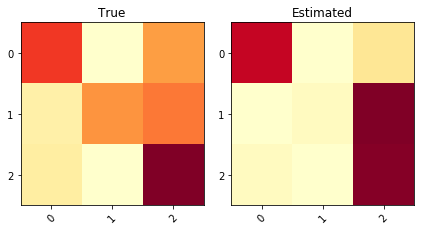

JS divergence: 0.0820	KL divergence: 0.1817


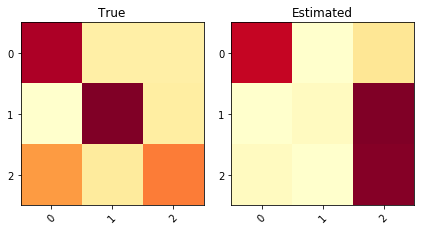

JS divergence: 0.2130	KL divergence: 1.3479


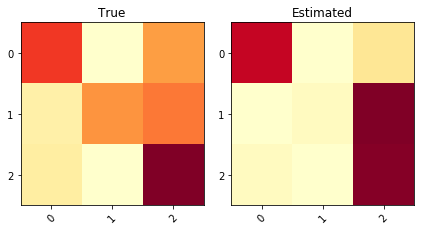

JS divergence: 0.0820	KL divergence: 0.1817


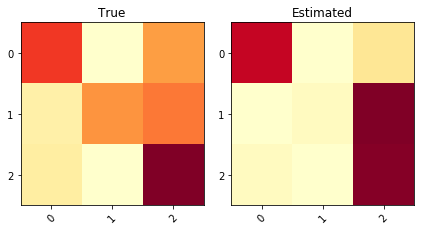

JS divergence: 0.0820	KL divergence: 0.1817


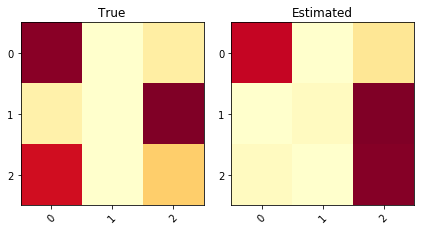

JS divergence: 0.1975	KL divergence: 0.4278


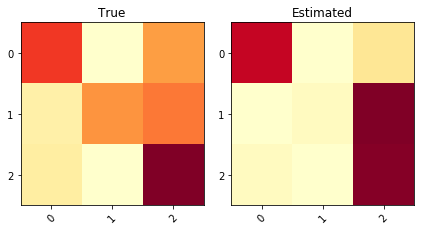

JS divergence: 0.0820	KL divergence: 0.1817


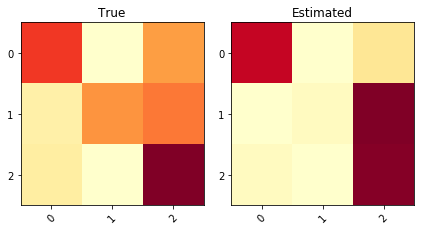

JS divergence: 0.0820	KL divergence: 0.1817
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS
====  ======  ==========  ============  =========  =========  ==========  ==========
   0  Global    0.610094      0.610094   0.522611   0.137686    0.522138    0.137534
====  ======  ==========  ============  =========  =========  ==========  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.642247      0.642247
====  ======  ==========  ============


In [18]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train


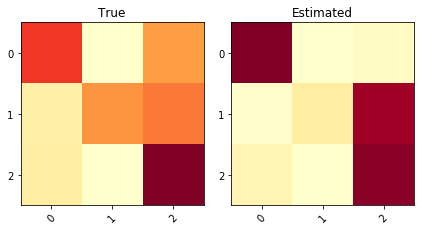

JS divergence: 0.2256	KL divergence: 0.4520


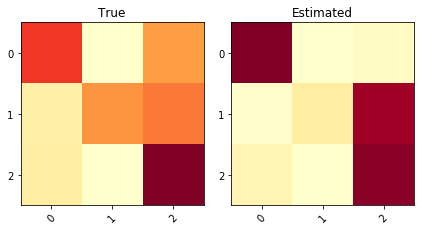

JS divergence: 0.2256	KL divergence: 0.4520


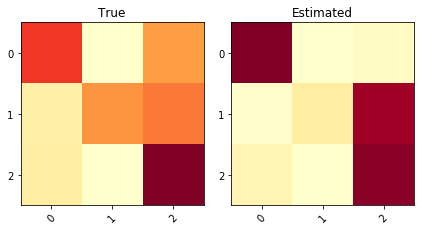

JS divergence: 0.2256	KL divergence: 0.4520


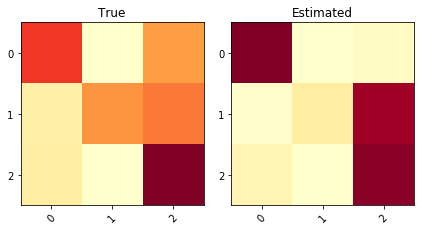

JS divergence: 0.2256	KL divergence: 0.4520


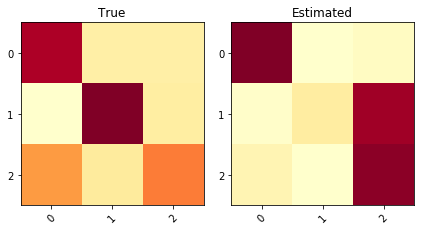

JS divergence: 0.2141	KL divergence: 0.4550


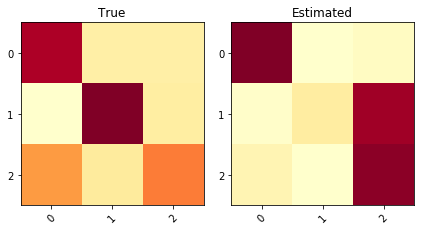

JS divergence: 0.2141	KL divergence: 0.4550


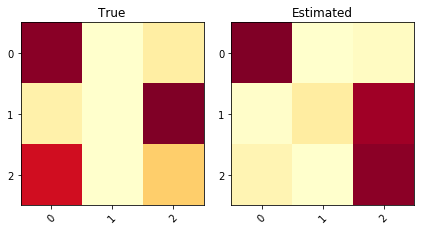

JS divergence: 0.3403	KL divergence: 0.6981


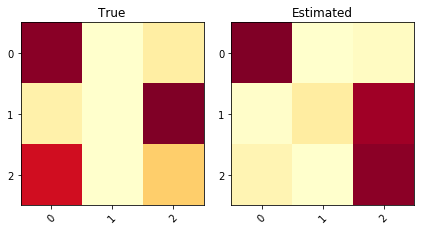

JS divergence: 0.3403	KL divergence: 0.6981


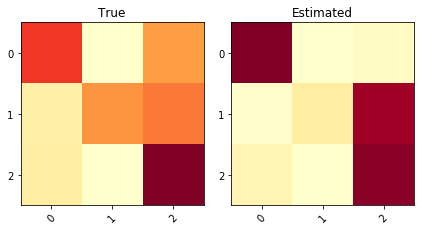

JS divergence: 0.2256	KL divergence: 0.4520


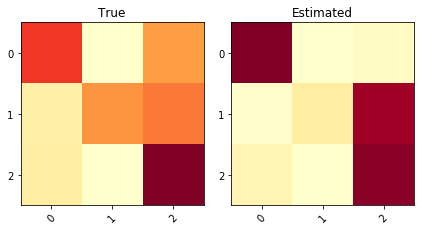

JS divergence: 0.2256	KL divergence: 0.4520


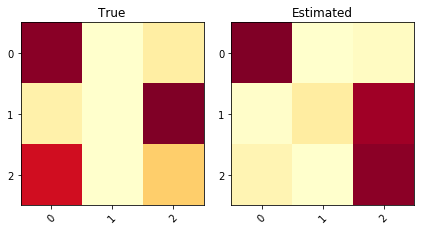

JS divergence: 0.3403	KL divergence: 0.6981


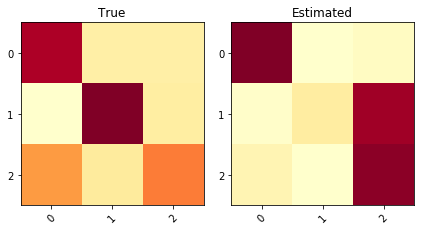

JS divergence: 0.2141	KL divergence: 0.4550


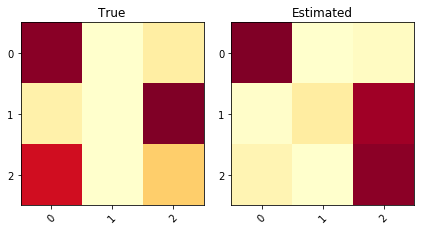

JS divergence: 0.3403	KL divergence: 0.6981


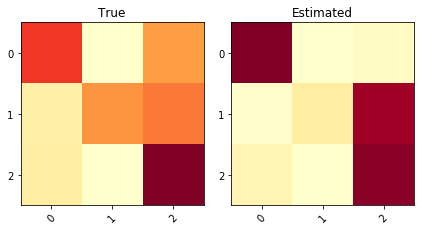

JS divergence: 0.2256	KL divergence: 0.4520


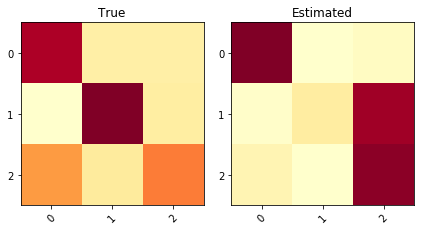

JS divergence: 0.2141	KL divergence: 0.4550
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS
====  ======  ==========  ============  =========  =========  ==========  ==========
   0  Global    0.667481      0.667481   0.501401   0.245403    0.501125    0.245277
====  ======  ==========  ============  =========  =========  ==========  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.678877      0.678877
====  ======  ==========  ============


In [20]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
prob_Yzt = np.tile(confusion_matrix(y_true=Z_train,y_pred=Z_train_pred), (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train


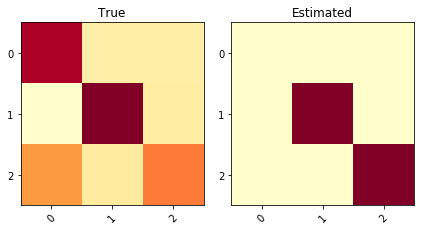

JS divergence: 0.2582	KL divergence: 3.1047


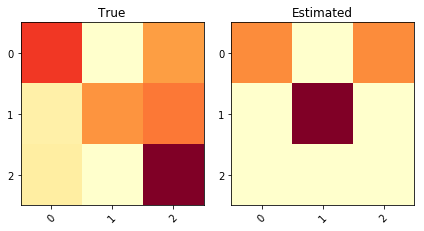

JS divergence: 1.2891	KL divergence: 3.0456


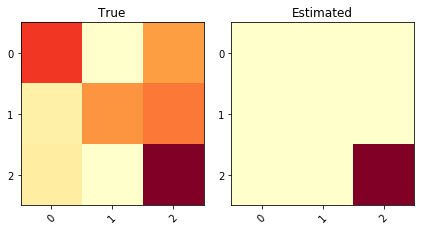

JS divergence: 1.1598	KL divergence: 0.6513


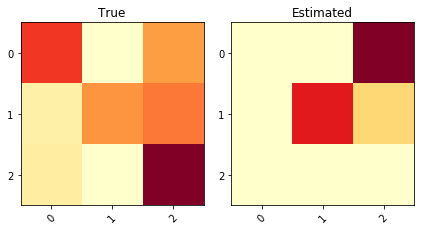

JS divergence: 1.3310	KL divergence: 3.7365


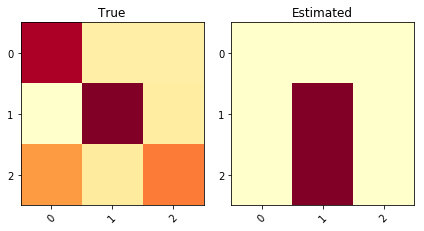

JS divergence: 0.3889	KL divergence: 5.0092


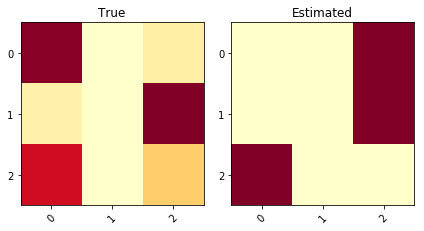

JS divergence: 0.3123	KL divergence: 6.2589


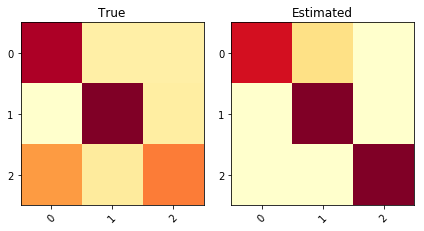

JS divergence: 0.1490	KL divergence: 3.3615


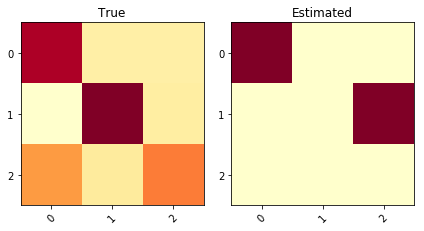

JS divergence: 0.3212	KL divergence: 5.5531


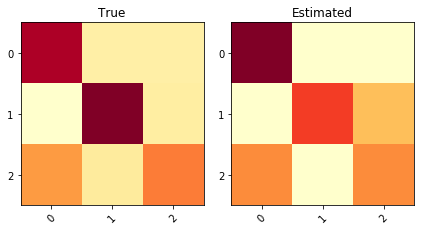

JS divergence: 0.0747	KL divergence: 1.3938


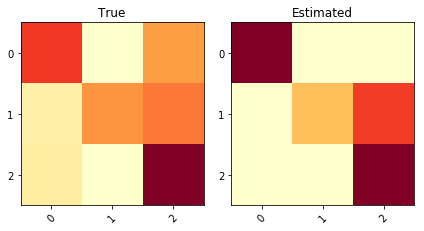

JS divergence: 0.1154	KL divergence: 2.7407


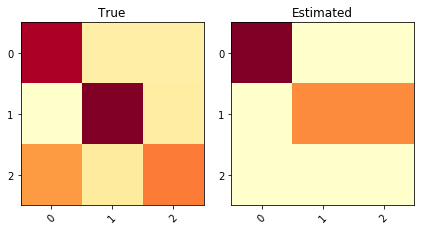

JS divergence: 0.1187	KL divergence: 0.9770


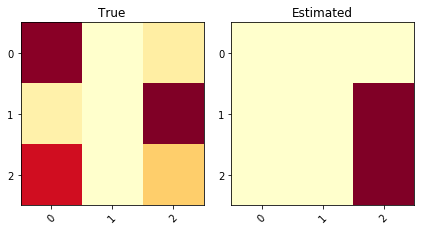

JS divergence: 1.3559	KL divergence: 4.4106


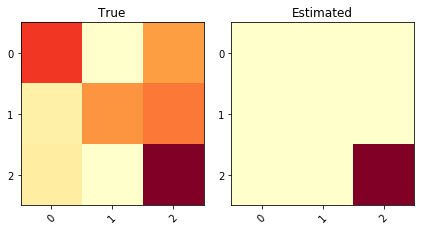

JS divergence: 1.1598	KL divergence: 0.6513


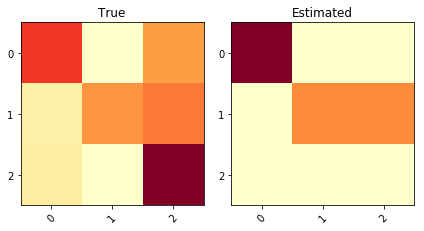

JS divergence: 1.2546	KL divergence: 2.5306


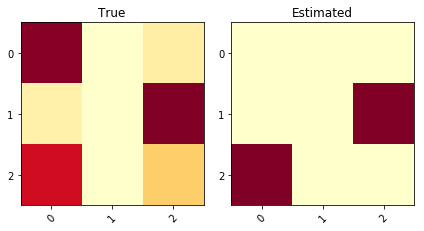

JS divergence: 1.2241	KL divergence: 1.8179
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS
====  ======  ==========  ============  =========  =========  ==========  ==========
   0  Global    0.925926      0.925926    3.12155   0.682768     3.10349    0.519642
====  ======  ==========  ============  =========  =========  ==========  ==========
Test
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  ============
   0  Global    0.942613      0.942613
====  ======  ==========  ============


In [22]:
evaluate = Evaluation_metrics(model_ds,'keras',Xstd_train.shape[0])
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf_M,conf_true=confe_matrix)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train


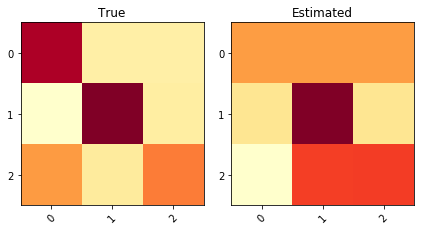

JS divergence: 0.1486	KL divergence: 0.3757


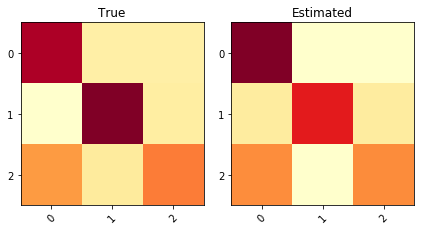

JS divergence: 0.0786	KL divergence: 0.1852


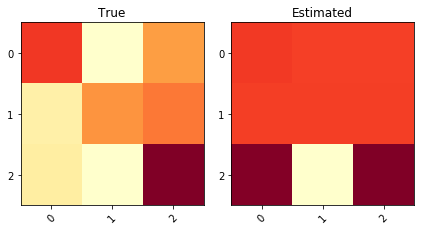

JS divergence: 0.1663	KL divergence: 0.3897


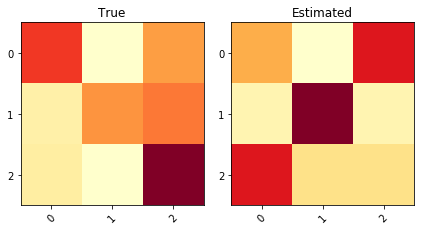

JS divergence: 0.1837	KL divergence: 0.4845


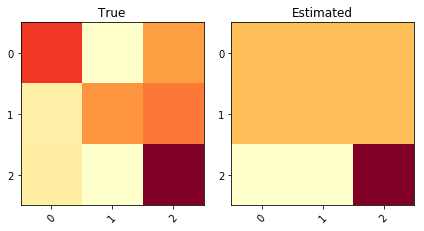

JS divergence: 0.1508	KL divergence: 0.3412


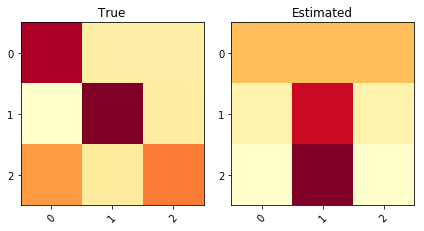

JS divergence: 0.1775	KL divergence: 0.4505


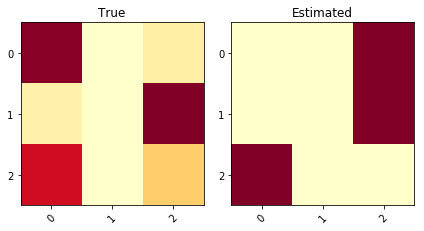

JS divergence: 0.2355	KL divergence: 0.5790


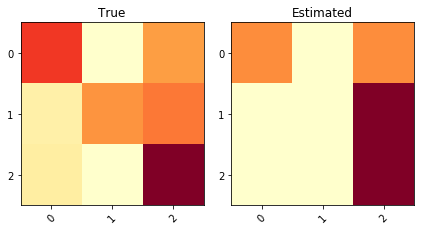

JS divergence: 0.0988	KL divergence: 0.2266


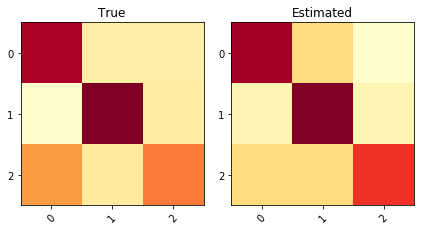

JS divergence: 0.0554	KL divergence: 0.1292


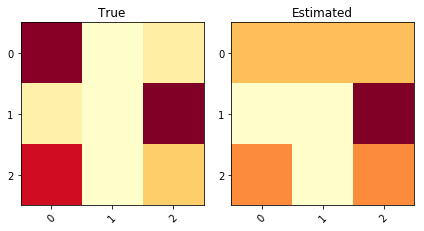

JS divergence: 0.1989	KL divergence: 0.4729


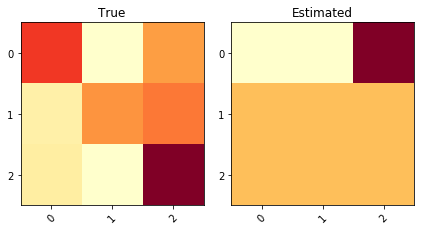

JS divergence: 0.1866	KL divergence: 0.4571


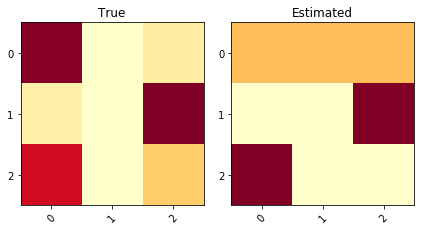

JS divergence: 0.2164	KL divergence: 0.5075


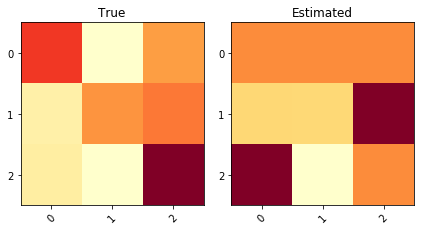

JS divergence: 0.1740	KL divergence: 0.4217


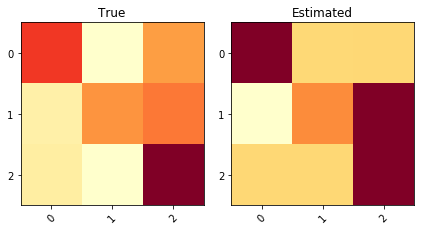

JS divergence: 0.1134	KL divergence: 0.2524


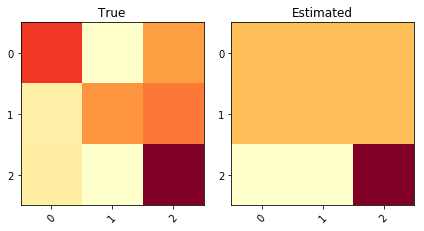

JS divergence: 0.1508	KL divergence: 0.3412
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
   0  Global    0.903948      0.903948   0.351377   0.146605     0.32628    0.136512     0.111502      0.126113
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
A result
 ====  ========================  ====================  =========================  =====================
  ..    Mean ACC imiting Annot    Mean cross-entropy    Wmean ACC imiting Annot    wMean cross entropy
====  ========================  ====================  =========================  =====================
   0                  0.833537              0.818638               

In [25]:
evaluate = Evaluation_metrics(raykarMC,'raykar')
print("*** Raykar model multiples runs***")

print("Train")
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(Xstd_train,data=Z_train_p)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours Global multiples runs***
Train


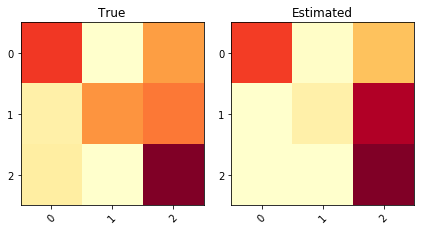

JS divergence: 0.0700	KL divergence: 0.2805


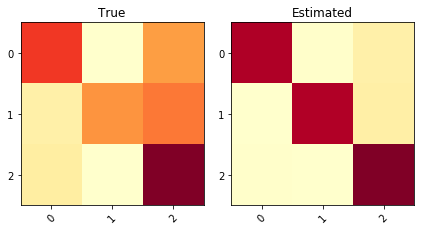

JS divergence: 0.1078	KL divergence: 0.4093


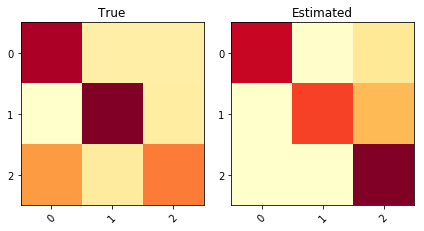

JS divergence: 0.1351	KL divergence: 0.7358


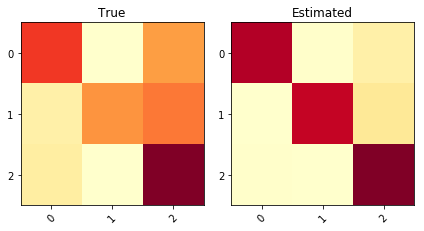

JS divergence: 0.0937	KL divergence: 0.3531


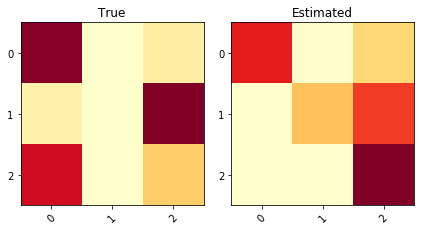

JS divergence: 0.2543	KL divergence: 1.3569


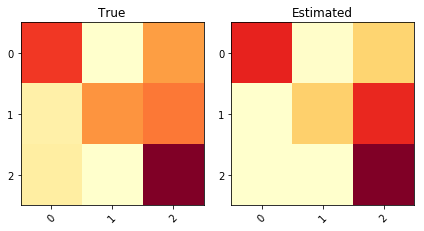

JS divergence: 0.0413	KL divergence: 0.1794


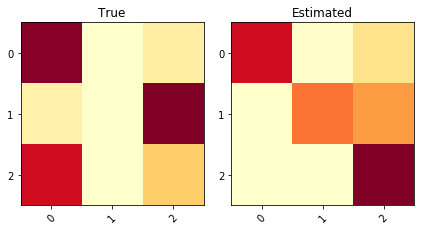

JS divergence: 0.2991	KL divergence: 1.4262


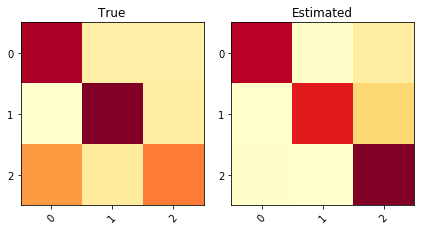

JS divergence: 0.1224	KL divergence: 0.7034


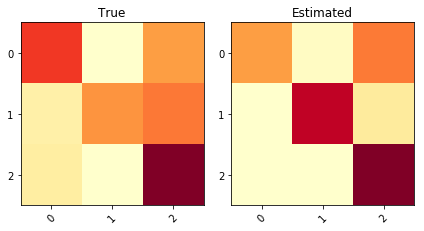

JS divergence: 0.0772	KL divergence: 0.2754


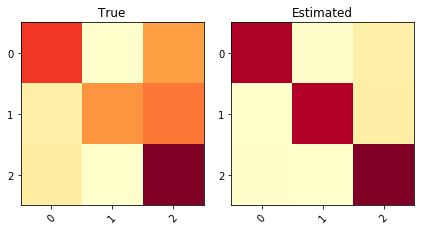

JS divergence: 0.1073	KL divergence: 0.4073


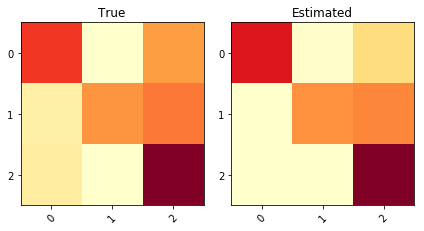

JS divergence: 0.0363	KL divergence: 0.1649


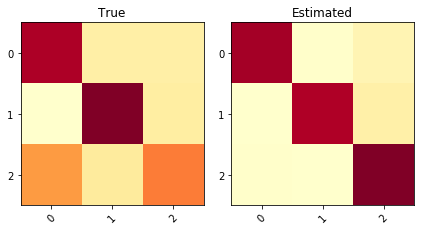

JS divergence: 0.1140	KL divergence: 0.6826


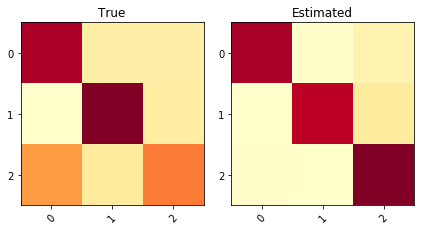

JS divergence: 0.1140	KL divergence: 0.6822


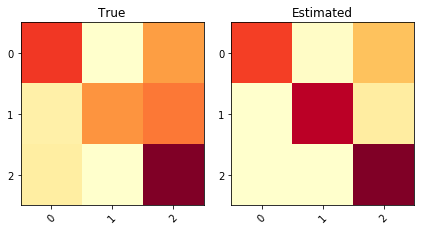

JS divergence: 0.0756	KL divergence: 0.2826


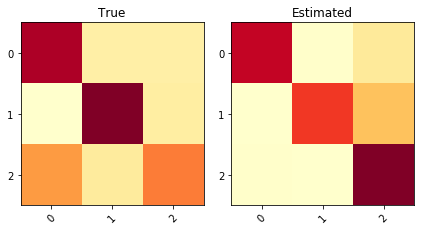

JS divergence: 0.1311	KL divergence: 0.7259
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
   0  Global    0.911274      0.911274   0.616631   0.129834    0.623919    0.130998     0.201472      0.206021
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
A result
 ====  ========================  ====================  =========================  =====================
  ..    Mean ACC imiting Annot    Mean cross-entropy    Wmean ACC imiting Annot    wMean cross entropy
====  ========================  ====================  =========================  =====================
   0                  0.741652              0.667054               

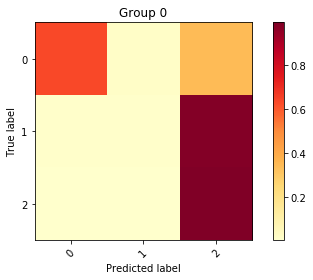

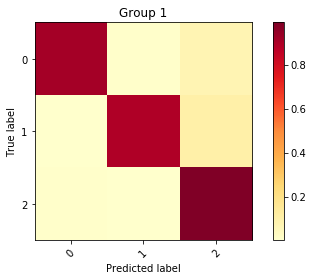

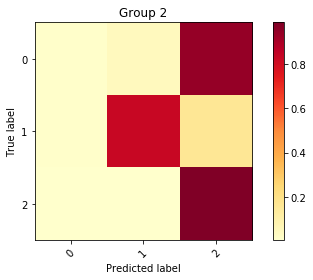

Inertia: 0.2876644699488059
A result
 ====  ========  =========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups       Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  =========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.237548     5836   0.281857     0.546375   1.78688        0.431714   0.319563    0.631258      0.631258
   1         1  0.67147     16496   0.235189     0.935055   0.068127       0.951526   0.902582    0.918193      0.918193
   2         2  0.0909825    2235   0.277777     0.60853    1.57901        0.492401   0.412796    0.518926      0.518926
====  ========  =========  ======  =========  ===========  =========  =============  =========  ==========  ============
A result
 ====  ======  ==========  ============
  ..            Accuracy    F1 (micro)
====  ======  ==========  =

In [28]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

## Variation $M$ = #Groups
---

In [6]:
path = "."

from code.generate_data import SinteticData

GenerateData = SinteticData(state=None)
#CONFUSION MATRIX CHOOSE
GenerateData.set_probas(asfile=True,file_matrix=path+'/synthetic/simple/matrix_simple_7groups.csv',file_groups =path+'/synthetic/simple/groups_simple_7groups.csv')
real_conf_matrix = GenerateData.conf_matrix.copy()

#ANNOTATOR DENSITY CHOOSE
Tmax = 100
T_data = 10

print("New Synthetic data is being generated...",flush=True,end='')
repeat=True
while(repeat):
    y_obs, groups_annot = GenerateData.sintetic_annotate_data(Z_train,Tmax,T_data,deterministic=False)
    if len(set(groups_annot[:,0])) == 7:
        repeat = False
print("Done! ")

if len(groups_annot.shape) ==1 or groups_annot.shape[1] ==  1: 
    groups_annot = keras.utils.to_categorical(groups_annot)  #only if it is hard clustering
confe_matrix = np.tensordot(groups_annot,real_conf_matrix, axes=[[1],[0]])
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones con este valor

print("Accuracy of MV on train: ",np.mean(GenerateData.yo_label == Z_train))

N,T = y_obs.shape
K = np.max(y_obs)+1 # asumiendo que estan ordenadas
print("Shape (data,annotators): ",(N,T))
print("Classes: ",K)

New Synthetic data is being generated...Done! 
Accuracy of MV on train:  0.7651607651607651
Shape (data,annotators):  (2457, 100)
Classes:  3


In [7]:
from code.MixtureofGroups import GroupMixtureOpt
from code.utils import *
from code.representation import *
r_obs = set_representation(y_obs,"repeat")
print("shape:",r_obs.shape)

shape: (2457, 3)


In [ ]:
from code.evaluation import Evaluation_metrics
import pickle

logL_Mchange = []
accTR_Mchange = []
accTE_Mchange = []
best_group_acc_Mchange = []
probas_Mchange = []
divergence1_Mchange = [] #JS weighted
divergence2_Mchange = [] #JS
probGt_Mchange = []
inertia_Mchange = [] 

for M_seted in range(1,15+1):
    for _ in range(10):
        gMixture_Global = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
        gMixture_Global.define_model("mlp",16,1,BatchN=False,drop=0.2)
        gMixture_Global.lambda_random = True #with lambda random --necessary
        logL_hists,i_r = gMixture_Global.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                       ,cluster=True)

        print("Model with %d trained"%(M_seted))
        logL_Mchange.append(logL_hists[i_r])
        probas_Mchange.append(gMixture_Global.get_alpha())

        #measure metrics..
        evaluate = Evaluation_metrics(gMixture_Global,'our1',plot=False) 
        aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=False)
        predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
        Z_train_pred = gMixture_Global.base_model.predict_classes(Xstd_train)
        results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs)

        accTR_Mchange.append(results1[0]["Accuracy"][0])
        divergence1_Mchange.append(results1[0]["Wmean JS"][0])
        divergence2_Mchange.append(results1[0]["Mean JS"][0])
        probGt_Mchange.append(prob_Gt)

        c_M = gMixture_Global.get_confusionM()
        y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
        Z_test_pred = gMixture_Global.base_model.predict_classes(Xstd_test)
        results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

        best_group_acc_Mchange.append(np.max(results2[0]["Accuracy"]))
        accTE_Mchange.append(results2[1]["Accuracy"][0])
        inertia_Mchange.append(evaluate.inertia)

        del gMixture_Global
        gc.collect()
        keras.backend.clear_session()
# cada 10 obtener promedio
T_models = 15
R = 10
logL_Mchange = [np.mean( [value[-1] for value in logL_Mchange[i*R:(i+1)*R] ] ) for i in range(T_models)]
accTR_Mchange = [np.mean(accTR_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
accTE_Mchange = [np.mean(accTE_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
best_group_acc_Mchange = [np.mean(best_group_acc_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
probas_Mchange = [np.mean(probas_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
divergence1_Mchange = [np.mean(divergence1_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)] #KL or JS
divergence2_Mchange = [np.mean(divergence2_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)] #KL or JS
probGt_Mchange = [np.mean(probGt_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
inertia_Mchange = [np.mean(inertia_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]

Needed params (units,deep,drop,BatchN?)
Doing clustering...Done!
Get init alphas in 0.002783 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.1686196]
Alphas:  (1,)
MV init:  (2457, 3)
Betas:  (1, 3, 3)
Q estimate:  (2457, 3, 1, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.61 sec)	logL: -25299.935	
Iter 2/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -24713.775	Tol1: 0.02317	Tol2: 0.11130	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24243.535	Tol1: 0.01903	Tol2: 0.08862	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23839.358	Tol1: 0.01667	Tol2: 0.08516	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23499.433	Tol1: 0.01426	Tol2: 0.09377	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23221.869	Tol1: 0.01181	Tol2: 0.09783	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22984.347	To

M step: done,  E step: done //  (in 0.08 sec)	logL: -25946.777	Tol1: 0.01627	Tol2: 0.06178	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25511.482	Tol1: 0.01678	Tol2: 0.06785	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25042.820	Tol1: 0.01837	Tol2: 0.07965	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -24562.010	Tol1: 0.01920	Tol2: 0.09169	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24095.061	Tol1: 0.01901	Tol2: 0.10034	Tol3: 0.00000	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23659.715	Tol1: 0.01807	Tol2: 0.10479	Tol3: 0.00000	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23296.219	Tol1: 0.01536	Tol2: 0.10311	Tol3: 0.00000	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23018.279	Tol1: 0.01193	Tol2: 0.09773	Tol3: 0.00000	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22818.503	Tol1: 0

M step: done,  E step: done //  (in 0.08 sec)	logL: -22477.072	Tol1: 0.00361	Tol2: 0.06503	Tol3: 0.00000	
Iter 17/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22411.129	Tol1: 0.00293	Tol2: 0.05784	Tol3: 0.00000	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22348.202	Tol1: 0.00281	Tol2: 0.05065	Tol3: 0.00000	
Iter 19/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22294.281	Tol1: 0.00241	Tol2: 0.04667	Tol3: 0.00000	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22247.341	Tol1: 0.00211	Tol2: 0.04390	Tol3: 0.00000	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22202.789	Tol1: 0.00200	Tol2: 0.04653	Tol3: 0.00000	
Iter 22/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22165.998	Tol1: 0.00166	Tol2: 0.04718	Tol3: 0.00000	
Iter 23/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22132.559	Tol1: 0.00151	Tol2: 0.04671	Tol3: 0.00000	
Iter 24/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22108.193	T

M step: done,  E step: done //  (in 0.09 sec)	logL: -22190.535	Tol1: 0.00178	Tol2: 0.03270	Tol3: 0.00000	
Iter 22/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22155.336	Tol1: 0.00159	Tol2: 0.03058	Tol3: 0.00000	
Iter 23/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22122.441	Tol1: 0.00148	Tol2: 0.03072	Tol3: 0.00000	
Iter 24/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22092.731	Tol1: 0.00134	Tol2: 0.03232	Tol3: 0.00000	
Iter 25/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22068.779	Tol1: 0.00108	Tol2: 0.02728	Tol3: 0.00000	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.77155715]
Alphas:  (1,)
MV init:  (2457, 3)
Betas:  (1, 3, 3)
Q estimate:  (2457, 3, 1, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -27348.474	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26791.811	Tol1: 0.02035	Tol2: 0.10141	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.09 sec)	logL: -23660.026	Tol1: 0.01241	Tol2: 0.09292	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -23414.677	Tol1: 0.01037	Tol2: 0.09371	Tol3: 0.00000	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23209.378	Tol1: 0.00877	Tol2: 0.09404	Tol3: 0.00000	
Iter 9/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -23032.638	Tol1: 0.00762	Tol2: 0.09212	Tol3: 0.00000	
Iter 10/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22864.369	Tol1: 0.00731	Tol2: 0.09114	Tol3: 0.00000	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22706.407	Tol1: 0.00691	Tol2: 0.08897	Tol3: 0.00000	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22569.196	Tol1: 0.00604	Tol2: 0.08883	Tol3: 0.00000	
Iter 13/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22447.369	Tol1: 0.00540	Tol2: 0.08226	Tol3: 0.00000	
Iter 14/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22336.162	Tol1

M step: done,  E step: done //  (in 0.09 sec)	logL: -25200.443	Tol1: 0.01649	Tol2: 0.08619	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24727.329	Tol1: 0.01877	Tol2: 0.09790	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24249.062	Tol1: 0.01934	Tol2: 0.10829	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23779.144	Tol1: 0.01938	Tol2: 0.11536	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23368.087	Tol1: 0.01729	Tol2: 0.11869	Tol3: 0.00000	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23034.816	Tol1: 0.01426	Tol2: 0.11764	Tol3: 0.00000	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22784.882	Tol1: 0.01085	Tol2: 0.11313	Tol3: 0.00000	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22599.622	Tol1: 0.00813	Tol2: 0.10620	Tol3: 0.00000	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22454.489	Tol1: 0

M step: done,  E step: done //  (in 0.63 sec)	logL: -27200.289	
Iter 2/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -26207.466	Tol1: 0.03650	Tol2: 0.15853	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -25457.757	Tol1: 0.02861	Tol2: 0.10466	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24858.821	Tol1: 0.02353	Tol2: 0.09930	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24351.667	Tol1: 0.02040	Tol2: 0.09795	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23920.682	Tol1: 0.01770	Tol2: 0.09558	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23557.812	Tol1: 0.01517	Tol2: 0.09627	Tol3: 0.00000	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23256.932	Tol1: 0.01277	Tol2: 0.10069	Tol3: 0.00000	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23011.760	Tol1: 0.01054	Tol2: 0.09698	Tol3: 0.00000	
Iter 10/

M step: done,  E step: done //  (in 0.08 sec)	logL: -21974.607	Tol1: 0.00060	Tol2: 0.02819	Tol3: 0.00000	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.01953092]
Alphas:  (1,)
MV init:  (2457, 3)
Betas:  (1, 3, 3)
Q estimate:  (2457, 3, 1, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -30026.967	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -28661.822	Tol1: 0.04546	Tol2: 0.26217	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -27595.787	Tol1: 0.03719	Tol2: 0.17563	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -26735.974	Tol1: 0.03116	Tol2: 0.12805	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26044.527	Tol1: 0.02586	Tol2: 0.10107	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25469.873	Tol1: 0.02206	Tol2: 0.07741	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0

/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Needed params (units,deep,drop,BatchN?)
Doing clustering...Done!
Get init alphas in 0.002949 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.4810617]
Alphas:  (1,)
MV init:  (2457, 3)
Betas:  (1, 3, 3)
Q estimate:  (2457, 3, 1, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.65 sec)	logL: -25754.324	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25220.612	Tol1: 0.02072	Tol2: 0.07083	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24755.027	Tol1: 0.01846	Tol2: 0.08072	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24293.542	Tol1: 0.01864	Tol2: 0.09390	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23851.284	Tol1: 0.01820	Tol2: 0.10380	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -23451.045	Tol1: 0.01678	Tol2: 0.11047	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -23096.086	To

M step: done,  E step: done //  (in 0.15 sec)	logL: -22086.990	Tol1: 0.00198	Tol2: 0.05014	Tol3: 0.00000	
Iter 19/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22050.201	Tol1: 0.00167	Tol2: 0.04146	Tol3: 0.00000	
Iter 20/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22014.460	Tol1: 0.00162	Tol2: 0.03391	Tol3: 0.00000	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21983.783	Tol1: 0.00139	Tol2: 0.02770	Tol3: 0.00000	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.13535084]
Alphas:  (1,)
MV init:  (2457, 3)
Betas:  (1, 3, 3)
Q estimate:  (2457, 3, 1, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -24411.058	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23840.215	Tol1: 0.02338	Tol2: 0.12351	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23458.641	Tol1: 0.01601	Tol2: 0.09214	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (i

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7485504]
Alphas:  (1,)
MV init:  (2457, 3)
Betas:  (1, 3, 3)
Q estimate:  (2457, 3, 1, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.64 sec)	logL: -25471.716	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24887.256	Tol1: 0.02295	Tol2: 0.10115	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24357.386	Tol1: 0.02129	Tol2: 0.10897	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -23849.884	Tol1: 0.02084	Tol2: 0.11788	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23406.007	Tol1: 0.01861	Tol2: 0.12200	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23042.220	Tol1: 0.01554	Tol2: 0.12178	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22762.150	Tol1: 0.01215	Tol2: 0.11777	Tol3: 0.00000	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22560.311	Tol1: 0

M step: done,  E step: done //  (in 0.08 sec)	logL: -22415.149	Tol1: 0.00280	Tol2: 0.07610	Tol3: 0.00000	
Iter 16/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22359.521	Tol1: 0.00248	Tol2: 0.06443	Tol3: 0.00000	
Iter 17/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22309.721	Tol1: 0.00223	Tol2: 0.05646	Tol3: 0.00000	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22268.656	Tol1: 0.00184	Tol2: 0.04969	Tol3: 0.00000	
Iter 19/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -22230.458	Tol1: 0.00172	Tol2: 0.04076	Tol3: 0.00000	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22192.515	Tol1: 0.00171	Tol2: 0.03457	Tol3: 0.00000	
Iter 21/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22157.127	Tol1: 0.00159	Tol2: 0.03189	Tol3: 0.00000	
Iter 22/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22126.993	Tol1: 0.00136	Tol2: 0.02650	Tol3: 0.00000	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... 

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7701399]
Alphas:  (1,)
MV init:  (2457, 3)
Betas:  (1, 3, 3)
Q estimate:  (2457, 3, 1, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.79 sec)	logL: -26872.448	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26431.663	Tol1: 0.01640	Tol2: 0.04694	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -26067.105	Tol1: 0.01379	Tol2: 0.04095	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25669.950	Tol1: 0.01524	Tol2: 0.05759	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25223.556	Tol1: 0.01739	Tol2: 0.07273	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24730.120	Tol1: 0.01956	Tol2: 0.08621	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24230.685	Tol1: 0.02020	Tol2: 0.09741	Tol3: 0.00000	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23749.409	Tol1: 0

M step: done,  E step: done //  (in 0.09 sec)	logL: -23371.720	Tol1: 0.01365	Tol2: 0.10607	Tol3: 0.00000	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23093.065	Tol1: 0.01192	Tol2: 0.10831	Tol3: 0.00000	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22866.921	Tol1: 0.00979	Tol2: 0.10775	Tol3: 0.00000	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22688.992	Tol1: 0.00778	Tol2: 0.10284	Tol3: 0.00000	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22551.371	Tol1: 0.00607	Tol2: 0.09100	Tol3: 0.00000	
Iter 12/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22440.197	Tol1: 0.00493	Tol2: 0.08566	Tol3: 0.00000	
Iter 13/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22356.226	Tol1: 0.00374	Tol2: 0.07969	Tol3: 0.00000	
Iter 14/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22288.272	Tol1: 0.00304	Tol2: 0.07042	Tol3: 0.00000	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22228.449	Tol

M step: done,  E step: done //  (in 0.08 sec)	logL: -22322.318	Tol1: 0.00604	Tol2: 0.09769	Tol3: 0.00000	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22217.825	Tol1: 0.00468	Tol2: 0.09215	Tol3: 0.00000	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22135.211	Tol1: 0.00372	Tol2: 0.08544	Tol3: 0.00000	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22072.445	Tol1: 0.00284	Tol2: 0.07829	Tol3: 0.00000	
Iter 20/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -22020.829	Tol1: 0.00234	Tol2: 0.07133	Tol3: 0.00000	
Iter 21/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21984.897	Tol1: 0.00163	Tol2: 0.06349	Tol3: 0.00000	
Iter 22/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -21954.527	Tol1: 0.00138	Tol2: 0.05776	Tol3: 0.00000	
Iter 23/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21932.574	Tol1: 0.00100	Tol2: 0.05167	Tol3: 0.00000	
Iter 24/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21913.778	T

M step: done,  E step: done //  (in 0.08 sec)	logL: -21909.505	Tol1: 0.00071	Tol2: 0.04269	Tol3: 0.00000	
Iter 24/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21895.495	Tol1: 0.00064	Tol2: 0.04076	Tol3: 0.00000	
Iter 25/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21880.218	Tol1: 0.00070	Tol2: 0.04002	Tol3: 0.00000	
Iter 26/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21864.129	Tol1: 0.00074	Tol2: 0.03802	Tol3: 0.00000	
Iter 27/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21850.264	Tol1: 0.00063	Tol2: 0.03576	Tol3: 0.00000	
Iter 28/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21840.098	Tol1: 0.00047	Tol2: 0.03408	Tol3: 0.00000	
Iter 29/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21834.951	Tol1: 0.00024	Tol2: 0.03223	Tol3: 0.00000	
Iter 30/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21828.208	Tol1: 0.00031	Tol2: 0.03579	Tol3: 0.00000	
Iter 31/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21821.440	T

M step: done,  E step: done //  (in 0.12 sec)	logL: -22305.841	Tol1: 0.00469	Tol2: 0.07704	Tol3: 0.00000	
Iter 18/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22225.999	Tol1: 0.00358	Tol2: 0.07098	Tol3: 0.00000	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22149.567	Tol1: 0.00344	Tol2: 0.06049	Tol3: 0.00000	
Iter 20/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22092.596	Tol1: 0.00257	Tol2: 0.05353	Tol3: 0.00000	
Iter 21/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22047.769	Tol1: 0.00203	Tol2: 0.04649	Tol3: 0.00000	
Iter 22/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22006.686	Tol1: 0.00186	Tol2: 0.03684	Tol3: 0.00000	
Iter 23/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21976.154	Tol1: 0.00139	Tol2: 0.03740	Tol3: 0.00000	
Iter 24/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -21949.562	Tol1: 0.00121	Tol2: 0.04061	Tol3: 0.00000	
Iter 25/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21927.167	T

M step: done,  E step: done //  (in 0.09 sec)	logL: -25565.070	Tol1: 0.02185	Tol2: 0.06677	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25007.470	Tol1: 0.02181	Tol2: 0.06391	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24502.941	Tol1: 0.02018	Tol2: 0.06787	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24065.307	Tol1: 0.01786	Tol2: 0.06994	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23699.018	Tol1: 0.01522	Tol2: 0.07504	Tol3: 0.00000	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23407.902	Tol1: 0.01228	Tol2: 0.07744	Tol3: 0.00000	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23173.763	Tol1: 0.01000	Tol2: 0.07714	Tol3: 0.00000	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22991.825	Tol1: 0.00785	Tol2: 0.07389	Tol3: 0.00000	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22842.870	Tol1: 0

M step: done,  E step: done //  (in 0.10 sec)	logL: -21989.422	Tol1: 0.00103	Tol2: 0.03118	Tol3: 0.00000	
Iter 26/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21971.022	Tol1: 0.00084	Tol2: 0.03080	Tol3: 0.00000	
Iter 27/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21954.918	Tol1: 0.00073	Tol2: 0.02867	Tol3: 0.00000	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.33021307]
Alphas:  (1,)
MV init:  (2457, 3)
Betas:  (1, 3, 3)
Q estimate:  (2457, 3, 1, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.61 sec)	logL: -26869.916	
Iter 2/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -26056.029	Tol1: 0.03029	Tol2: 0.12495	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -25459.236	Tol1: 0.02290	Tol2: 0.10251	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24967.467	Tol1: 0.01932	Tol2: 0.09280	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in

M step: done,  E step: done //  (in 0.08 sec)	logL: -25497.766	Tol1: 0.01309	Tol2: 0.06867	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25147.921	Tol1: 0.01372	Tol2: 0.07500	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24814.964	Tol1: 0.01324	Tol2: 0.07952	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24506.885	Tol1: 0.01242	Tol2: 0.08130	Tol3: 0.00000	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24225.910	Tol1: 0.01147	Tol2: 0.08126	Tol3: 0.00000	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23991.963	Tol1: 0.00966	Tol2: 0.08041	Tol3: 0.00000	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23791.056	Tol1: 0.00837	Tol2: 0.08016	Tol3: 0.00000	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23605.619	Tol1: 0.00779	Tol2: 0.08080	Tol3: 0.00000	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23428.145	Tol1: 

M step: done,  E step: done //  (in 0.10 sec)	logL: -25730.503	Tol1: 0.01760	Tol2: 0.05816	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -25316.093	Tol1: 0.01611	Tol2: 0.07132	Tol3: 0.00000	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24937.984	Tol1: 0.01494	Tol2: 0.08573	Tol3: 0.00000	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24594.979	Tol1: 0.01375	Tol2: 0.09466	Tol3: 0.00000	
Iter 10/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24266.424	Tol1: 0.01336	Tol2: 0.10119	Tol3: 0.00000	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23958.266	Tol1: 0.01270	Tol2: 0.10626	Tol3: 0.00000	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23664.619	Tol1: 0.01226	Tol2: 0.10580	Tol3: 0.00000	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23389.819	Tol1: 0.01161	Tol2: 0.10447	Tol3: 0.00000	
Iter 14/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23135.231	Tol1

M step: done,  E step: done //  (in 0.09 sec)	logL: -22724.502	Tol1: 0.00439	Tol2: 0.07691	Tol3: 0.00000	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22635.786	Tol1: 0.00390	Tol2: 0.06985	Tol3: 0.00000	
Iter 14/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22558.078	Tol1: 0.00343	Tol2: 0.06304	Tol3: 0.00000	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22494.500	Tol1: 0.00282	Tol2: 0.05695	Tol3: 0.00000	
Iter 16/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22432.568	Tol1: 0.00275	Tol2: 0.05405	Tol3: 0.00000	
Iter 17/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22380.093	Tol1: 0.00234	Tol2: 0.04789	Tol3: 0.00000	
Iter 18/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22329.205	Tol1: 0.00227	Tol2: 0.04346	Tol3: 0.00000	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22279.784	Tol1: 0.00221	Tol2: 0.04151	Tol3: 0.00000	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22234.593	T

M step: done,  E step: done //  (in 0.08 sec)	logL: -25433.467	Tol1: 0.01224	Tol2: 0.07506	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25095.238	Tol1: 0.01330	Tol2: 0.08448	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24741.984	Tol1: 0.01408	Tol2: 0.09233	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24379.481	Tol1: 0.01465	Tol2: 0.10029	Tol3: 0.00000	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24016.549	Tol1: 0.01489	Tol2: 0.10563	Tol3: 0.00000	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23671.962	Tol1: 0.01435	Tol2: 0.10672	Tol3: 0.00000	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23364.074	Tol1: 0.01301	Tol2: 0.10771	Tol3: 0.00000	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23106.498	Tol1: 0.01102	Tol2: 0.10312	Tol3: 0.00000	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22898.099	Tol1: 

M step: done,  E step: done //  (in 0.09 sec)	logL: -25871.131	Tol1: 0.01349	Tol2: 0.05309	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -25459.794	Tol1: 0.01590	Tol2: 0.06830	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24985.976	Tol1: 0.01861	Tol2: 0.08242	Tol3: 0.00000	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24472.134	Tol1: 0.02057	Tol2: 0.09431	Tol3: 0.00000	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23956.565	Tol1: 0.02107	Tol2: 0.10458	Tol3: 0.00000	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23493.342	Tol1: 0.01934	Tol2: 0.11053	Tol3: 0.00000	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23103.794	Tol1: 0.01658	Tol2: 0.11078	Tol3: 0.00000	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22804.326	Tol1: 0.01296	Tol2: 0.10905	Tol3: 0.00000	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22584.848	Tol1:

M step: done,  E step: done //  (in 0.09 sec)	logL: -23418.188	Tol1: 0.01702	Tol2: 0.08257	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -23093.300	Tol1: 0.01387	Tol2: 0.08729	Tol3: 0.00000	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22835.769	Tol1: 0.01115	Tol2: 0.08911	Tol3: 0.00000	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22639.536	Tol1: 0.00859	Tol2: 0.09036	Tol3: 0.00000	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22491.673	Tol1: 0.00653	Tol2: 0.08804	Tol3: 0.00000	
Iter 11/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22381.439	Tol1: 0.00490	Tol2: 0.08296	Tol3: 0.00000	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22297.057	Tol1: 0.00377	Tol2: 0.07942	Tol3: 0.00000	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22230.336	Tol1: 0.00299	Tol2: 0.07423	Tol3: 0.00000	
Iter 14/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22177.935	Tol1

M step: done,  E step: done //  (in 0.08 sec)	logL: -24967.686	Tol1: 0.01086	Tol2: 0.07126	Tol3: 0.00000	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24716.189	Tol1: 0.01007	Tol2: 0.07030	Tol3: 0.00000	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24478.895	Tol1: 0.00960	Tol2: 0.07274	Tol3: 0.00000	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24267.106	Tol1: 0.00865	Tol2: 0.07596	Tol3: 0.00000	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24040.136	Tol1: 0.00935	Tol2: 0.07618	Tol3: 0.00000	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23831.995	Tol1: 0.00866	Tol2: 0.07873	Tol3: 0.00000	
Iter 14/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23641.258	Tol1: 0.00800	Tol2: 0.07956	Tol3: 0.00000	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23469.157	Tol1: 0.00728	Tol2: 0.07466	Tol3: 0.00000	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23303.254	To

M step: done,  E step: done //  (in 0.08 sec)	logL: -22108.388	Tol1: 0.00212	Tol2: 0.03657	Tol3: 0.00000	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22069.448	Tol1: 0.00176	Tol2: 0.02873	Tol3: 0.00000	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.14845258]
Alphas:  (1,)
MV init:  (2457, 3)
Betas:  (1, 3, 3)
Q estimate:  (2457, 3, 1, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -24692.057	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23944.808	Tol1: 0.03026	Tol2: 0.09676	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23433.342	Tol1: 0.02136	Tol2: 0.09387	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23058.610	Tol1: 0.01599	Tol2: 0.09712	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22783.477	Tol1: 0.01193	Tol2: 0.09470	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 

M step: done,  E step: done //  (in 0.09 sec)	logL: -26304.635	Tol1: 0.01457	Tol2: 0.03609	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25947.030	Tol1: 0.01359	Tol2: 0.03095	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -25601.212	Tol1: 0.01333	Tol2: 0.04611	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -25238.887	Tol1: 0.01415	Tol2: 0.06114	Tol3: 0.00000	
Iter 8/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -24845.521	Tol1: 0.01559	Tol2: 0.07458	Tol3: 0.00000	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24428.104	Tol1: 0.01680	Tol2: 0.08694	Tol3: 0.00000	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23996.454	Tol1: 0.01767	Tol2: 0.09752	Tol3: 0.00000	
Iter 11/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23568.040	Tol1: 0.01785	Tol2: 0.10551	Tol3: 0.00000	
Iter 12/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23185.956	Tol1: 

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.93107474]
Alphas:  (1,)
MV init:  (2457, 3)
Betas:  (1, 3, 3)
Q estimate:  (2457, 3, 1, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.75 sec)	logL: -26619.122	
Iter 2/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -26224.409	Tol1: 0.01483	Tol2: 0.06421	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -25866.353	Tol1: 0.01365	Tol2: 0.06324	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -25427.478	Tol1: 0.01697	Tol2: 0.07792	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -24917.419	Tol1: 0.02006	Tol2: 0.09255	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -24370.573	Tol1: 0.02195	Tol2: 0.10530	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23839.870	Tol1: 0.02178	Tol2: 0.11379	Tol3: 0.00000	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23372.641	Tol1: 

M step: done,  E step: done //  (in 0.13 sec)	logL: -25343.822	Tol1: 0.02701	Tol2: 0.06027	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24756.944	Tol1: 0.02316	Tol2: 0.07013	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24277.200	Tol1: 0.01938	Tol2: 0.07894	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23872.341	Tol1: 0.01668	Tol2: 0.08359	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23545.769	Tol1: 0.01368	Tol2: 0.08996	Tol3: 0.00000	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23291.995	Tol1: 0.01078	Tol2: 0.09252	Tol3: 0.00000	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23091.019	Tol1: 0.00863	Tol2: 0.09049	Tol3: 0.00000	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22932.640	Tol1: 0.00686	Tol2: 0.08742	Tol3: 0.00000	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22804.062	Tol1: 0

M step: done,  E step: done //  (in 0.09 sec)	logL: -25219.800	Tol1: 0.01529	Tol2: 0.06066	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24861.270	Tol1: 0.01422	Tol2: 0.06927	Tol3: 0.00000	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24546.995	Tol1: 0.01264	Tol2: 0.07529	Tol3: 0.00000	
Iter 9/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -24257.452	Tol1: 0.01180	Tol2: 0.07820	Tol3: 0.00000	
Iter 10/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23986.118	Tol1: 0.01119	Tol2: 0.07898	Tol3: 0.00000	
Iter 11/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23751.152	Tol1: 0.00980	Tol2: 0.07927	Tol3: 0.00000	
Iter 12/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23521.240	Tol1: 0.00968	Tol2: 0.07556	Tol3: 0.00000	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23317.211	Tol1: 0.00867	Tol2: 0.07180	Tol3: 0.00000	
Iter 14/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23145.929	Tol1

M step: done,  E step: done //  (in 0.09 sec)	logL: -22056.434	Tol1: 0.00265	Tol2: 0.07036	Tol3: 0.00000	
Iter 19/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22010.893	Tol1: 0.00206	Tol2: 0.06167	Tol3: 0.00000	
Iter 20/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21976.207	Tol1: 0.00158	Tol2: 0.05366	Tol3: 0.00000	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21944.968	Tol1: 0.00142	Tol2: 0.04631	Tol3: 0.00000	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21919.596	Tol1: 0.00116	Tol2: 0.03876	Tol3: 0.00000	
Iter 23/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21899.683	Tol1: 0.00091	Tol2: 0.03171	Tol3: 0.00000	
Iter 24/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21884.144	Tol1: 0.00071	Tol2: 0.02486	Tol3: 0.00000	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.65396833]
Alphas:  (1,)
MV init:  (2457, 3)
Betas:  (1, 3, 3)
Q estimate:  (2457, 3, 1, 3)

M step: done,  E step: done //  (in 0.08 sec)	logL: -22132.384	Tol1: 0.00254	Tol2: 0.03078	Tol3: 0.00000	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22086.369	Tol1: 0.00208	Tol2: 0.02203	Tol3: 0.00000	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.22583763]
Alphas:  (1,)
MV init:  (2457, 3)
Betas:  (1, 3, 3)
Q estimate:  (2457, 3, 1, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -27383.231	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25756.928	Tol1: 0.05939	Tol2: 0.29855	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24976.382	Tol1: 0.03030	Tol2: 0.12510	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24426.199	Tol1: 0.02203	Tol2: 0.08348	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23986.377	Tol1: 0.01801	Tol2: 0.08483	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 

M step: done,  E step: done //  (in 0.09 sec)	logL: -22045.795	Tol1: 0.00113	Tol2: 0.03418	Tol3: 0.00000	
Iter 23/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22023.522	Tol1: 0.00101	Tol2: 0.02991	Tol3: 0.00000	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.68397486]
Alphas:  (1,)
MV init:  (2457, 3)
Betas:  (1, 3, 3)
Q estimate:  (2457, 3, 1, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -27276.470	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26757.914	Tol1: 0.01901	Tol2: 0.05658	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26373.055	Tol1: 0.01438	Tol2: 0.03360	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25989.733	Tol1: 0.01453	Tol2: 0.04162	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25588.901	Tol1: 0.01542	Tol2: 0.05432	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 

M step: done,  E step: done //  (in 0.09 sec)	logL: -23085.810	Tol1: 0.00262	Tol2: 0.03570	Tol3: 0.00000	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23030.542	Tol1: 0.00239	Tol2: 0.02869	Tol3: 0.00000	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.31857005]
Alphas:  (1,)
MV init:  (2457, 3)
Betas:  (1, 3, 3)
Q estimate:  (2457, 3, 1, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -24581.920	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23991.620	Tol1: 0.02401	Tol2: 0.11271	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23521.104	Tol1: 0.01961	Tol2: 0.10731	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23133.894	Tol1: 0.01646	Tol2: 0.11128	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22828.163	Tol1: 0.01322	Tol2: 0.11231	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 

M step: done,  E step: done //  (in 0.09 sec)	logL: -24456.282	Tol1: 0.02304	Tol2: 0.07901	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23992.034	Tol1: 0.01898	Tol2: 0.08659	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23621.062	Tol1: 0.01546	Tol2: 0.09107	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23330.489	Tol1: 0.01230	Tol2: 0.09199	Tol3: 0.00000	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23098.439	Tol1: 0.00995	Tol2: 0.08981	Tol3: 0.00000	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22914.496	Tol1: 0.00796	Tol2: 0.08793	Tol3: 0.00000	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22769.198	Tol1: 0.00634	Tol2: 0.08557	Tol3: 0.00000	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22644.458	Tol1: 0.00548	Tol2: 0.08063	Tol3: 0.00000	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22542.789	Tol1: 

M step: done,  E step: done //  (in 0.08 sec)	logL: -21976.081	Tol1: 0.00114	Tol2: 0.02472	Tol3: 0.00000	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.81697875]
Alphas:  (1,)
MV init:  (2457, 3)
Betas:  (1, 3, 3)
Q estimate:  (2457, 3, 1, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.69 sec)	logL: -26132.562	
Iter 2/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -25654.744	Tol1: 0.01828	Tol2: 0.07082	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25223.559	Tol1: 0.01681	Tol2: 0.07937	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24754.004	Tol1: 0.01862	Tol2: 0.09266	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -24256.858	Tol1: 0.02008	Tol2: 0.10372	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -23765.672	Tol1: 0.02025	Tol2: 0.11286	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0

M step: done,  E step: done //  (in 0.09 sec)	logL: -23051.194	Tol1: 0.01448	Tol2: 0.10746	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22789.867	Tol1: 0.01134	Tol2: 0.10374	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22595.902	Tol1: 0.00851	Tol2: 0.09945	Tol3: 0.00000	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22448.392	Tol1: 0.00653	Tol2: 0.09417	Tol3: 0.00000	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22338.835	Tol1: 0.00488	Tol2: 0.08699	Tol3: 0.00000	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22255.340	Tol1: 0.00374	Tol2: 0.08133	Tol3: 0.00000	
Iter 11/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22183.431	Tol1: 0.00323	Tol2: 0.07145	Tol3: 0.00000	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22129.803	Tol1: 0.00242	Tol2: 0.06256	Tol3: 0.00000	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22085.067	Tol1:

M step: done,  E step: done //  (in 0.09 sec)	logL: -26394.223	Tol1: 0.02395	Tol2: 0.09012	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25905.881	Tol1: 0.01850	Tol2: 0.06702	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25439.236	Tol1: 0.01801	Tol2: 0.06117	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24982.199	Tol1: 0.01797	Tol2: 0.07251	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24546.493	Tol1: 0.01744	Tol2: 0.08426	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24131.599	Tol1: 0.01690	Tol2: 0.09224	Tol3: 0.00000	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23757.080	Tol1: 0.01552	Tol2: 0.10233	Tol3: 0.00000	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23436.248	Tol1: 0.01350	Tol2: 0.10942	Tol3: 0.00000	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23159.900	Tol1: 0.

M step: done,  E step: done //  (in 0.09 sec)	logL: -22069.048	Tol1: 0.00207	Tol2: 0.04275	Tol3: 0.00000	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22031.285	Tol1: 0.00171	Tol2: 0.03542	Tol3: 0.00000	
Iter 20/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21997.908	Tol1: 0.00151	Tol2: 0.02794	Tol3: 0.00000	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.27564815]
Alphas:  (1,)
MV init:  (2457, 3)
Betas:  (1, 3, 3)
Q estimate:  (2457, 3, 1, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.61 sec)	logL: -27322.910	
Iter 2/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -26524.123	Tol1: 0.02924	Tol2: 0.10330	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -25883.645	Tol1: 0.02415	Tol2: 0.06968	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -25291.353	Tol1: 0.02288	Tol2: 0.06031	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in

M step: done,  E step: done //  (in 0.09 sec)	logL: -21960.233	Tol1: 0.00090	Tol2: 0.03499	Tol3: 0.00000	
Iter 21/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21942.874	Tol1: 0.00079	Tol2: 0.03021	Tol3: 0.00000	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21925.333	Tol1: 0.00080	Tol2: 0.02801	Tol3: 0.00000	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6519958]
Alphas:  (1,)
MV init:  (2457, 3)
Betas:  (1, 3, 3)
Q estimate:  (2457, 3, 1, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.68 sec)	logL: -27139.024	
Iter 2/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -26368.480	Tol1: 0.02839	Tol2: 0.13711	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25907.815	Tol1: 0.01747	Tol2: 0.04054	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25415.584	Tol1: 0.01900	Tol2: 0.06304	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 

M step: done,  E step: done //  (in 0.08 sec)	logL: -22162.382	Tol1: 0.00362	Tol2: 0.05650	Tol3: 0.00000	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22097.173	Tol1: 0.00294	Tol2: 0.04949	Tol3: 0.00000	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22046.894	Tol1: 0.00228	Tol2: 0.04372	Tol3: 0.00000	
Iter 23/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22005.447	Tol1: 0.00188	Tol2: 0.03757	Tol3: 0.00000	
Iter 24/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21972.459	Tol1: 0.00150	Tol2: 0.03456	Tol3: 0.00000	
Iter 25/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21942.875	Tol1: 0.00135	Tol2: 0.03546	Tol3: 0.00000	
Iter 26/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21918.529	Tol1: 0.00111	Tol2: 0.03188	Tol3: 0.00000	
Iter 27/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21900.239	Tol1: 0.00083	Tol2: 0.03102	Tol3: 0.00000	
Iter 28/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21887.060	T

M step: done,  E step: done //  (in 0.08 sec)	logL: -22191.970	Tol1: 0.00273	Tol2: 0.05959	Tol3: 0.00000	
Iter 17/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22133.108	Tol1: 0.00265	Tol2: 0.05176	Tol3: 0.00000	
Iter 18/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22086.230	Tol1: 0.00212	Tol2: 0.04650	Tol3: 0.00000	
Iter 19/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22045.682	Tol1: 0.00184	Tol2: 0.03718	Tol3: 0.00000	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22006.811	Tol1: 0.00176	Tol2: 0.03686	Tol3: 0.00000	
Iter 21/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21972.741	Tol1: 0.00155	Tol2: 0.04053	Tol3: 0.00000	
Iter 22/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21945.197	Tol1: 0.00125	Tol2: 0.03921	Tol3: 0.00000	
Iter 23/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21920.398	Tol1: 0.00113	Tol2: 0.03826	Tol3: 0.00000	
Iter 24/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21898.137	T

M step: done,  E step: done //  (in 0.58 sec)	logL: -28722.512	
Iter 2/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -27745.937	Tol1: 0.03400	Tol2: 0.15483	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -27116.999	Tol1: 0.02267	Tol2: 0.10469	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26623.782	Tol1: 0.01819	Tol2: 0.08444	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26214.721	Tol1: 0.01536	Tol2: 0.07805	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -25846.926	Tol1: 0.01403	Tol2: 0.07436	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -25499.430	Tol1: 0.01344	Tol2: 0.07221	Tol3: 0.00000	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25164.327	Tol1: 0.01314	Tol2: 0.07204	Tol3: 0.00000	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24848.511	Tol1: 0.01255	Tol2: 0.08175	Tol3: 0.00000	
Iter 10/

M step: done,  E step: done //  (in 0.08 sec)	logL: -22127.323	Tol1: 0.00177	Tol2: 0.04950	Tol3: 0.00000	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22095.387	Tol1: 0.00144	Tol2: 0.04142	Tol3: 0.00000	
Iter 23/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22065.808	Tol1: 0.00134	Tol2: 0.03734	Tol3: 0.00000	
Iter 24/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22042.939	Tol1: 0.00104	Tol2: 0.03126	Tol3: 0.00000	
Iter 25/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22018.913	Tol1: 0.00109	Tol2: 0.02550	Tol3: 0.00000	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.09856852]
Alphas:  (1,)
MV init:  (2457, 3)
Betas:  (1, 3, 3)
Q estimate:  (2457, 3, 1, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -23843.385	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23306.040	Tol1: 0.02254	Tol2: 0.14584	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.08 sec)	logL: -22978.985	Tol1: 0.00698	Tol2: 0.09046	Tol3: 0.00000	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22820.599	Tol1: 0.00689	Tol2: 0.08856	Tol3: 0.00000	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22667.214	Tol1: 0.00672	Tol2: 0.09074	Tol3: 0.00000	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22535.366	Tol1: 0.00582	Tol2: 0.08273	Tol3: 0.00000	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22415.479	Tol1: 0.00532	Tol2: 0.07443	Tol3: 0.00000	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22318.187	Tol1: 0.00434	Tol2: 0.06311	Tol3: 0.00000	
Iter 23/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22237.541	Tol1: 0.00361	Tol2: 0.05187	Tol3: 0.00000	
Iter 24/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22171.854	Tol1: 0.00295	Tol2: 0.04050	Tol3: 0.00000	
Iter 25/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22116.358	T

M step: done,  E step: done //  (in 0.09 sec)	logL: -22980.110	Tol1: 0.00621	Tol2: 0.06526	Tol3: 0.00000	
Iter 11/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22869.658	Tol1: 0.00481	Tol2: 0.05942	Tol3: 0.00000	
Iter 12/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22765.718	Tol1: 0.00454	Tol2: 0.05257	Tol3: 0.00000	
Iter 13/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -22671.093	Tol1: 0.00416	Tol2: 0.04549	Tol3: 0.00000	
Iter 14/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22589.357	Tol1: 0.00361	Tol2: 0.04022	Tol3: 0.00000	
Iter 15/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -22520.248	Tol1: 0.00306	Tol2: 0.03326	Tol3: 0.00000	
Iter 16/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22463.777	Tol1: 0.00251	Tol2: 0.02657	Tol3: 0.00000	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9484134]
Alphas:  (1,)
MV init:  (2457, 3)
Betas:  (1, 3, 3)
Q estimate:  (2457, 3, 1, 3)


M step: done,  E step: done //  (in 0.08 sec)	logL: -21969.228	Tol1: 0.00075	Tol2: 0.03509	Tol3: 0.00000	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21951.421	Tol1: 0.00081	Tol2: 0.02987	Tol3: 0.00000	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.77445]
Alphas:  (1,)
MV init:  (2457, 3)
Betas:  (1, 3, 3)
Q estimate:  (2457, 3, 1, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.62 sec)	logL: -26732.007	
Iter 2/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -26272.914	Tol1: 0.01717	Tol2: 0.08225	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -25883.085	Tol1: 0.01484	Tol2: 0.07063	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -25491.024	Tol1: 0.01515	Tol2: 0.07262	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25104.671	Tol1: 0.01516	Tol2: 0.07496	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.0

M step: done,  E step: done //  (in 0.09 sec)	logL: -24532.189	Tol1: 0.02781	Tol2: 0.09296	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23947.768	Tol1: 0.02382	Tol2: 0.08922	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23470.143	Tol1: 0.01994	Tol2: 0.09993	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23097.892	Tol1: 0.01586	Tol2: 0.10494	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22813.806	Tol1: 0.01230	Tol2: 0.10395	Tol3: 0.00000	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22608.824	Tol1: 0.00898	Tol2: 0.10052	Tol3: 0.00000	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22452.518	Tol1: 0.00691	Tol2: 0.09613	Tol3: 0.00000	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22336.555	Tol1: 0.00516	Tol2: 0.09080	Tol3: 0.00000	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22249.083	Tol1: 0

M step: done,  E step: done //  (in 0.09 sec)	logL: -22332.701	Tol1: 0.00462	Tol2: 0.09136	Tol3: 0.00000	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22249.508	Tol1: 0.00373	Tol2: 0.08481	Tol3: 0.00000	
Iter 14/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22184.718	Tol1: 0.00291	Tol2: 0.07758	Tol3: 0.00000	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22138.780	Tol1: 0.00207	Tol2: 0.06818	Tol3: 0.00000	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22098.417	Tol1: 0.00182	Tol2: 0.06126	Tol3: 0.00000	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22063.309	Tol1: 0.00159	Tol2: 0.05124	Tol3: 0.00000	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22036.095	Tol1: 0.00123	Tol2: 0.04239	Tol3: 0.00000	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22011.356	Tol1: 0.00112	Tol2: 0.03595	Tol3: 0.00000	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21988.798	T

M step: done,  E step: done //  (in 0.08 sec)	logL: -22568.161	Tol1: 0.00609	Tol2: 0.08049	Tol3: 0.00000	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22459.542	Tol1: 0.00481	Tol2: 0.07516	Tol3: 0.00000	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22369.580	Tol1: 0.00401	Tol2: 0.07059	Tol3: 0.00000	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22297.740	Tol1: 0.00321	Tol2: 0.06582	Tol3: 0.00000	
Iter 21/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -22234.650	Tol1: 0.00283	Tol2: 0.06284	Tol3: 0.00000	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22178.808	Tol1: 0.00251	Tol2: 0.06036	Tol3: 0.00000	
Iter 23/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22130.987	Tol1: 0.00216	Tol2: 0.05660	Tol3: 0.00000	
Iter 24/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22096.299	Tol1: 0.00157	Tol2: 0.05013	Tol3: 0.00000	
Iter 25/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22054.112	T

M step: done,  E step: done //  (in 0.08 sec)	logL: -22491.654	Tol1: 0.00652	Tol2: 0.09144	Tol3: 0.00000	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22372.958	Tol1: 0.00528	Tol2: 0.08765	Tol3: 0.00000	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22274.393	Tol1: 0.00441	Tol2: 0.08431	Tol3: 0.00000	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22198.668	Tol1: 0.00340	Tol2: 0.07895	Tol3: 0.00000	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22140.900	Tol1: 0.00260	Tol2: 0.07175	Tol3: 0.00000	
Iter 20/50
M step: done,  E step: done //  (in 0.30 sec)	logL: -22092.884	Tol1: 0.00217	Tol2: 0.06732	Tol3: 0.00000	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22051.775	Tol1: 0.00186	Tol2: 0.06050	Tol3: 0.00000	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22017.808	Tol1: 0.00154	Tol2: 0.05459	Tol3: 0.00000	
Iter 23/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21990.536	T

M step: done,  E step: done //  (in 0.08 sec)	logL: -21836.202	Tol1: 0.00058	Tol2: 0.03970	Tol3: 0.00000	
Iter 33/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21825.201	Tol1: 0.00050	Tol2: 0.03663	Tol3: 0.00000	
Iter 34/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21814.762	Tol1: 0.00048	Tol2: 0.03302	Tol3: 0.00000	
Iter 35/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21806.079	Tol1: 0.00040	Tol2: 0.02794	Tol3: 0.00000	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.43453002]
Alphas:  (1,)
MV init:  (2457, 3)
Betas:  (1, 3, 3)
Q estimate:  (2457, 3, 1, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -26361.019	
Iter 2/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -25777.806	Tol1: 0.02212	Tol2: 0.08027	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -25307.499	Tol1: 0.01824	Tol2: 0.06317	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (i

M step: done,  E step: done //  (in 0.10 sec)	logL: -27278.891	Tol1: 0.02102	Tol2: 0.09388	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26970.950	Tol1: 0.01129	Tol2: 0.03633	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26707.711	Tol1: 0.00976	Tol2: 0.01846	Tol3: 0.00000	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.695608]
Alphas:  (1,)
MV init:  (2457, 3)
Betas:  (1, 3, 3)
Q estimate:  (2457, 3, 1, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.66 sec)	logL: -28915.487	
Iter 2/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -28088.634	Tol1: 0.02860	Tol2: 0.13880	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -27639.082	Tol1: 0.01600	Tol2: 0.08433	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -27317.466	Tol1: 0.01164	Tol2: 0.06555	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.1

M step: done,  E step: done //  (in 0.13 sec)	logL: -25121.915	Tol1: 0.02047	Tol2: 0.10216	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -24650.102	Tol1: 0.01878	Tol2: 0.11179	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24174.904	Tol1: 0.01928	Tol2: 0.11277	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23726.528	Tol1: 0.01855	Tol2: 0.11532	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23338.731	Tol1: 0.01634	Tol2: 0.11565	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23022.237	Tol1: 0.01356	Tol2: 0.11318	Tol3: 0.00000	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22772.332	Tol1: 0.01085	Tol2: 0.10874	Tol3: 0.00000	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22574.451	Tol1: 0.00869	Tol2: 0.10312	Tol3: 0.00000	
Iter 10/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22426.956	Tol1: 0.

M step: done,  E step: done //  (in 0.12 sec)	logL: -24671.321	Tol1: 0.01606	Tol2: 0.07419	Tol3: 0.00000	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24271.337	Tol1: 0.01621	Tol2: 0.08591	Tol3: 0.00000	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23905.076	Tol1: 0.01509	Tol2: 0.09435	Tol3: 0.00000	
Iter 10/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23565.424	Tol1: 0.01421	Tol2: 0.09721	Tol3: 0.00000	
Iter 11/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23269.097	Tol1: 0.01257	Tol2: 0.09768	Tol3: 0.00000	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23021.850	Tol1: 0.01063	Tol2: 0.09883	Tol3: 0.00000	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22819.387	Tol1: 0.00879	Tol2: 0.09762	Tol3: 0.00000	
Iter 14/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22651.864	Tol1: 0.00734	Tol2: 0.09608	Tol3: 0.00000	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22524.363	Tol

M step: done,  E step: done //  (in 0.09 sec)	logL: -22102.562	Tol1: 0.00158	Tol2: 0.04601	Tol3: 0.00000	
Iter 18/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22072.341	Tol1: 0.00137	Tol2: 0.04073	Tol3: 0.00000	
Iter 19/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22046.932	Tol1: 0.00115	Tol2: 0.03578	Tol3: 0.00000	
Iter 20/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22022.527	Tol1: 0.00111	Tol2: 0.02715	Tol3: 0.00000	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6944034]
Alphas:  (1,)
MV init:  (2457, 3)
Betas:  (1, 3, 3)
Q estimate:  (2457, 3, 1, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.65 sec)	logL: -26375.802	
Iter 2/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -25766.621	Tol1: 0.02310	Tol2: 0.09821	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -25263.279	Tol1: 0.01953	Tol2: 0.07290	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in

M step: done,  E step: done //  (in 0.08 sec)	logL: -21914.834	Tol1: 0.00078	Tol2: 0.03789	Tol3: 0.00000	
Iter 30/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21900.527	Tol1: 0.00065	Tol2: 0.03616	Tol3: 0.00000	
Iter 31/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21885.641	Tol1: 0.00068	Tol2: 0.03888	Tol3: 0.00000	
Iter 32/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21873.134	Tol1: 0.00057	Tol2: 0.04014	Tol3: 0.00000	
Iter 33/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21860.953	Tol1: 0.00056	Tol2: 0.03552	Tol3: 0.00000	
Iter 34/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21849.522	Tol1: 0.00052	Tol2: 0.03643	Tol3: 0.00000	
Iter 35/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21839.232	Tol1: 0.00047	Tol2: 0.03661	Tol3: 0.00000	
Iter 36/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21829.544	Tol1: 0.00044	Tol2: 0.03265	Tol3: 0.00000	
Iter 37/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21819.238	T

M step: done,  E step: done //  (in 0.09 sec)	logL: -24408.292	Tol1: 0.02030	Tol2: 0.10717	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -23909.827	Tol1: 0.02042	Tol2: 0.11638	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23447.909	Tol1: 0.01932	Tol2: 0.12150	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23056.608	Tol1: 0.01669	Tol2: 0.12210	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22758.948	Tol1: 0.01291	Tol2: 0.11721	Tol3: 0.00000	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22536.371	Tol1: 0.00978	Tol2: 0.10978	Tol3: 0.00000	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22379.736	Tol1: 0.00695	Tol2: 0.10050	Tol3: 0.00000	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22270.714	Tol1: 0.00487	Tol2: 0.09269	Tol3: 0.00000	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22190.444	Tol1: 0

M step: done,  E step: done //  (in 0.08 sec)	logL: -22663.199	Tol1: 0.00664	Tol2: 0.07795	Tol3: 0.00000	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22539.675	Tol1: 0.00545	Tol2: 0.07640	Tol3: 0.00000	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22432.706	Tol1: 0.00475	Tol2: 0.06990	Tol3: 0.00000	
Iter 14/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22343.971	Tol1: 0.00396	Tol2: 0.06360	Tol3: 0.00000	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22269.246	Tol1: 0.00334	Tol2: 0.05560	Tol3: 0.00000	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22206.301	Tol1: 0.00283	Tol2: 0.04898	Tol3: 0.00000	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22154.755	Tol1: 0.00232	Tol2: 0.04189	Tol3: 0.00000	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22108.713	Tol1: 0.00208	Tol2: 0.03503	Tol3: 0.00000	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22072.924	T

M step: done,  E step: done //  (in 0.08 sec)	logL: -22105.106	Tol1: 0.00204	Tol2: 0.04663	Tol3: 0.00000	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22064.659	Tol1: 0.00183	Tol2: 0.03995	Tol3: 0.00000	
Iter 19/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22028.612	Tol1: 0.00163	Tol2: 0.03180	Tol3: 0.00000	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21998.611	Tol1: 0.00136	Tol2: 0.02481	Tol3: 0.00000	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.71736485]
Alphas:  (1,)
MV init:  (2457, 3)
Betas:  (1, 3, 3)
Q estimate:  (2457, 3, 1, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.61 sec)	logL: -26612.758	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26003.754	Tol1: 0.02288	Tol2: 0.11241	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -25577.696	Tol1: 0.01638	Tol2: 0.06612	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (i

M step: done,  E step: done //  (in 0.08 sec)	logL: -22152.914	Tol1: 0.00235	Tol2: 0.04979	Tol3: 0.00000	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22106.686	Tol1: 0.00209	Tol2: 0.04371	Tol3: 0.00000	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22071.967	Tol1: 0.00157	Tol2: 0.03914	Tol3: 0.00000	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22037.730	Tol1: 0.00155	Tol2: 0.03411	Tol3: 0.00000	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22007.114	Tol1: 0.00139	Tol2: 0.02674	Tol3: 0.00000	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.54795974]
Alphas:  (1,)
MV init:  (2457, 3)
Betas:  (1, 3, 3)
Q estimate:  (2457, 3, 1, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -25689.616	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25009.429	Tol1: 0.02648	Tol2: 0.12311	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (

M step: done,  E step: done //  (in 0.08 sec)	logL: -21967.654	Tol1: 0.00162	Tol2: 0.04451	Tol3: 0.00000	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21940.588	Tol1: 0.00123	Tol2: 0.03920	Tol3: 0.00000	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21915.267	Tol1: 0.00115	Tol2: 0.03193	Tol3: 0.00000	
Iter 23/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21892.416	Tol1: 0.00104	Tol2: 0.02729	Tol3: 0.00000	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.8217914]
Alphas:  (1,)
MV init:  (2457, 3)
Betas:  (1, 3, 3)
Q estimate:  (2457, 3, 1, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.62 sec)	logL: -27922.515	
Iter 2/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -27426.308	Tol1: 0.01777	Tol2: 0.13121	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -27178.772	Tol1: 0.00903	Tol2: 0.03781	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in

M step: done,  E step: done //  (in 0.08 sec)	logL: -23179.763	Tol1: 0.01200	Tol2: 0.10346	Tol3: 0.00000	
Iter 14/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22957.052	Tol1: 0.00961	Tol2: 0.09903	Tol3: 0.00000	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22778.551	Tol1: 0.00778	Tol2: 0.09734	Tol3: 0.00000	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22636.740	Tol1: 0.00623	Tol2: 0.09409	Tol3: 0.00000	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22523.566	Tol1: 0.00500	Tol2: 0.08686	Tol3: 0.00000	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22436.332	Tol1: 0.00387	Tol2: 0.08045	Tol3: 0.00000	
Iter 19/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22367.648	Tol1: 0.00306	Tol2: 0.06830	Tol3: 0.00000	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22304.819	Tol1: 0.00281	Tol2: 0.05967	Tol3: 0.00000	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22252.267	T

M step: done,  E step: done //  (in 0.09 sec)	logL: -22175.106	Tol1: 0.00219	Tol2: 0.04228	Tol3: 0.00000	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22131.535	Tol1: 0.00196	Tol2: 0.03609	Tol3: 0.00000	
Iter 22/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22094.633	Tol1: 0.00167	Tol2: 0.03349	Tol3: 0.00000	
Iter 23/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22058.113	Tol1: 0.00165	Tol2: 0.03231	Tol3: 0.00000	
Iter 24/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22027.045	Tol1: 0.00141	Tol2: 0.02879	Tol3: 0.00000	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.3903286]
Alphas:  (1,)
MV init:  (2457, 3)
Betas:  (1, 3, 3)
Q estimate:  (2457, 3, 1, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.67 sec)	logL: -25687.255	
Iter 2/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -25051.988	Tol1: 0.02473	Tol2: 0.11415	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (i

M step: done,  E step: done //  (in 0.08 sec)	logL: -22065.852	Tol1: 0.00152	Tol2: 0.04421	Tol3: 0.00000	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22033.944	Tol1: 0.00145	Tol2: 0.03704	Tol3: 0.00000	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22008.820	Tol1: 0.00114	Tol2: 0.02972	Tol3: 0.00000	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7272905]
Alphas:  (1,)
MV init:  (2457, 3)
Betas:  (1, 3, 3)
Q estimate:  (2457, 3, 1, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -27412.526	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26879.994	Tol1: 0.01943	Tol2: 0.06291	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26482.015	Tol1: 0.01481	Tol2: 0.02983	Tol3: 0.00000	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7484572]
Alphas:  (1,)
MV init:  (2457, 3)
Betas:  (1, 3, 3)

M step: done,  E step: done //  (in 0.58 sec)	logL: -27144.537	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26830.110	Tol1: 0.01158	Tol2: 0.05248	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26600.549	Tol1: 0.00856	Tol2: 0.03880	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26337.944	Tol1: 0.00987	Tol2: 0.04723	Tol3: 0.00000	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26014.598	Tol1: 0.01228	Tol2: 0.05768	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25620.552	Tol1: 0.01515	Tol2: 0.07326	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25154.567	Tol1: 0.01819	Tol2: 0.08791	Tol3: 0.00000	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24647.189	Tol1: 0.02017	Tol2: 0.10102	Tol3: 0.00000	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24138.009	Tol1: 0.02066	Tol2: 0.11037	Tol3: 0.00000	
Iter 10/

M step: done,  E step: done //  (in 0.09 sec)	logL: -25587.936	Tol1: 0.01459	Tol2: 0.06202	Tol3: 0.00000	
Iter 6/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -25192.019	Tol1: 0.01547	Tol2: 0.06937	Tol3: 0.00000	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24798.518	Tol1: 0.01562	Tol2: 0.07651	Tol3: 0.00000	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24416.328	Tol1: 0.01541	Tol2: 0.08341	Tol3: 0.00000	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24061.943	Tol1: 0.01451	Tol2: 0.08970	Tol3: 0.00000	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23729.188	Tol1: 0.01383	Tol2: 0.09348	Tol3: 0.00000	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23429.153	Tol1: 0.01264	Tol2: 0.09641	Tol3: 0.00000	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23166.394	Tol1: 0.01122	Tol2: 0.09781	Tol3: 0.00000	
Iter 13/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22944.836	Tol1:

M step: done,  E step: done //  (in 0.09 sec)	logL: -22179.229	Tol1: 0.00277	Tol2: 0.04222	Tol3: 0.00000	
Iter 24/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22128.268	Tol1: 0.00230	Tol2: 0.04223	Tol3: 0.00000	
Iter 25/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22083.644	Tol1: 0.00202	Tol2: 0.03578	Tol3: 0.00000	
Iter 26/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22049.126	Tol1: 0.00156	Tol2: 0.02808	Tol3: 0.00000	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.48209167]
Alphas:  (1,)
MV init:  (2457, 3)
Betas:  (1, 3, 3)
Q estimate:  (2457, 3, 1, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.63 sec)	logL: -27222.722	
Iter 2/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -26290.669	Tol1: 0.03424	Tol2: 0.18302	Tol3: 0.00000	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25779.050	Tol1: 0.01946	Tol2: 0.05887	Tol3: 0.00000	
Iter 4/50
M step: done,  E step: done //  (i

M step: done,  E step: done //  (in 0.09 sec)	logL: -22462.152	Tol1: 0.00436	Tol2: 0.06514	Tol3: 0.00000	
Iter 14/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22381.328	Tol1: 0.00360	Tol2: 0.05711	Tol3: 0.00000	
Iter 15/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22313.551	Tol1: 0.00303	Tol2: 0.05228	Tol3: 0.00000	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22259.086	Tol1: 0.00244	Tol2: 0.04287	Tol3: 0.00000	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22214.528	Tol1: 0.00200	Tol2: 0.04148	Tol3: 0.00000	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22177.242	Tol1: 0.00168	Tol2: 0.03405	Tol3: 0.00000	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22140.420	Tol1: 0.00166	Tol2: 0.02697	Tol3: 0.00000	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.43590042]
Alphas:  (1,)
MV init:  (2457, 3)
Betas:  (1, 3, 3)
Q estimate:  (2457, 3, 1, 3)

M step: done,  E step: done //  (in 0.08 sec)	logL: -22158.354	Tol1: 0.00293	Tol2: 0.07304	Tol3: 0.02149	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22105.095	Tol1: 0.00240	Tol2: 0.06246	Tol3: 0.01997	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22063.639	Tol1: 0.00188	Tol2: 0.05695	Tol3: 0.01854	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22025.433	Tol1: 0.00173	Tol2: 0.04847	Tol3: 0.01617	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21995.490	Tol1: 0.00136	Tol2: 0.04172	Tol3: 0.01505	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21967.668	Tol1: 0.00126	Tol2: 0.03762	Tol3: 0.01361	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21946.583	Tol1: 0.00096	Tol2: 0.03535	Tol3: 0.01286	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21927.041	Tol1: 0.00089	Tol2: 0.03127	Tol3: 0.01107	
Iter 22/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21910.591	T

M step: done,  E step: done //  (in 0.09 sec)	logL: -26564.295	Tol1: 0.03561	Tol2: 0.27237	Tol3: 0.02900	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25824.969	Tol1: 0.02783	Tol2: 0.10645	Tol3: 0.01503	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25225.712	Tol1: 0.02320	Tol2: 0.07587	Tol3: 0.00645	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24684.666	Tol1: 0.02145	Tol2: 0.08188	Tol3: 0.00855	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24231.003	Tol1: 0.01838	Tol2: 0.08823	Tol3: 0.01332	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23850.207	Tol1: 0.01572	Tol2: 0.09301	Tol3: 0.01829	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23544.452	Tol1: 0.01282	Tol2: 0.09179	Tol3: 0.02011	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23297.344	Tol1: 0.01050	Tol2: 0.08706	Tol3: 0.02071	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23104.324	Tol1: 0.

M step: done,  E step: done //  (in 0.08 sec)	logL: -22204.840	Tol1: 0.00153	Tol2: 0.03125	Tol3: 0.01210	
Iter 22/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22173.175	Tol1: 0.00143	Tol2: 0.03171	Tol3: 0.01153	
Iter 23/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22145.503	Tol1: 0.00125	Tol2: 0.02781	Tol3: 0.01013	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.73991835 0.69229084]
Alphas:  (2,)
MV init:  (2457, 3)
Betas:  (2, 3, 3)
Q estimate:  (2457, 3, 2, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.60 sec)	logL: -27619.992	
Iter 2/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -27060.610	Tol1: 0.02025	Tol2: 0.26017	Tol3: 0.01887	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26720.005	Tol1: 0.01259	Tol2: 0.13082	Tol3: 0.00963	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26456.973	Tol1: 0.00984	Tol2: 0.08546	Tol3: 0.00784	
Iter 5/50
M step: done,  E step: d

M step: done,  E step: done //  (in 0.08 sec)	logL: -22842.576	Tol1: 0.00705	Tol2: 0.09509	Tol3: 0.02354	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22712.716	Tol1: 0.00568	Tol2: 0.08466	Tol3: 0.02194	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22605.271	Tol1: 0.00473	Tol2: 0.07834	Tol3: 0.02208	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22520.495	Tol1: 0.00375	Tol2: 0.06853	Tol3: 0.02001	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22449.792	Tol1: 0.00314	Tol2: 0.06322	Tol3: 0.02029	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22388.616	Tol1: 0.00273	Tol2: 0.05756	Tol3: 0.02035	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22339.722	Tol1: 0.00218	Tol2: 0.05237	Tol3: 0.01935	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22295.463	Tol1: 0.00198	Tol2: 0.04509	Tol3: 0.01781	
Iter 23/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22259.143	T

M step: done,  E step: done //  (in 0.08 sec)	logL: -22614.166	Tol1: 0.00466	Tol2: 0.07912	Tol3: 0.00559	
Iter 22/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22527.444	Tol1: 0.00383	Tol2: 0.07216	Tol3: 0.00480	
Iter 23/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22452.127	Tol1: 0.00334	Tol2: 0.06546	Tol3: 0.00402	
Iter 24/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22382.914	Tol1: 0.00308	Tol2: 0.06063	Tol3: 0.00409	
Iter 25/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22326.327	Tol1: 0.00253	Tol2: 0.05610	Tol3: 0.00492	
Iter 26/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22275.565	Tol1: 0.00227	Tol2: 0.04862	Tol3: 0.00375	
Iter 27/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22231.794	Tol1: 0.00196	Tol2: 0.04508	Tol3: 0.00351	
Iter 28/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22192.352	Tol1: 0.00177	Tol2: 0.04047	Tol3: 0.00331	
Iter 29/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22157.031	T

M step: done,  E step: done //  (in 0.12 sec)	logL: -25693.479	Tol1: 0.03400	Tol2: 0.26789	Tol3: 0.03368	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25012.399	Tol1: 0.02651	Tol2: 0.13631	Tol3: 0.02244	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24426.260	Tol1: 0.02343	Tol2: 0.11378	Tol3: 0.01633	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23926.681	Tol1: 0.02045	Tol2: 0.11111	Tol3: 0.01770	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23510.739	Tol1: 0.01738	Tol2: 0.11152	Tol3: 0.02093	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23178.987	Tol1: 0.01411	Tol2: 0.10996	Tol3: 0.02337	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22916.968	Tol1: 0.01130	Tol2: 0.10486	Tol3: 0.02455	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22714.836	Tol1: 0.00882	Tol2: 0.09680	Tol3: 0.02444	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22560.155	Tol1: 0.

M step: done,  E step: done //  (in 0.08 sec)	logL: -22099.688	Tol1: 0.00179	Tol2: 0.03155	Tol3: 0.00277	
Iter 21/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22065.125	Tol1: 0.00156	Tol2: 0.03024	Tol3: 0.00239	
Iter 22/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -22032.561	Tol1: 0.00148	Tol2: 0.03310	Tol3: 0.00310	
Iter 23/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22003.969	Tol1: 0.00130	Tol2: 0.03149	Tol3: 0.00300	
Iter 24/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21980.369	Tol1: 0.00107	Tol2: 0.03228	Tol3: 0.00347	
Iter 25/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21962.176	Tol1: 0.00083	Tol2: 0.03112	Tol3: 0.00307	
Iter 26/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21945.020	Tol1: 0.00078	Tol2: 0.03091	Tol3: 0.00232	
Iter 27/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21929.297	Tol1: 0.00072	Tol2: 0.03144	Tol3: 0.00224	
Iter 28/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21914.784	T

M step: done,  E step: done //  (in 0.10 sec)	logL: -22480.591	Tol1: 0.00414	Tol2: 0.06517	Tol3: 0.01229	
Iter 15/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22399.868	Tol1: 0.00359	Tol2: 0.05840	Tol3: 0.01166	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22331.803	Tol1: 0.00304	Tol2: 0.05460	Tol3: 0.01161	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22274.864	Tol1: 0.00255	Tol2: 0.04747	Tol3: 0.01129	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22225.049	Tol1: 0.00224	Tol2: 0.04108	Tol3: 0.01123	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22179.987	Tol1: 0.00203	Tol2: 0.03381	Tol3: 0.01074	
Iter 20/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22143.945	Tol1: 0.00162	Tol2: 0.03160	Tol3: 0.00989	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22112.868	Tol1: 0.00140	Tol2: 0.02847	Tol3: 0.01015	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  25

M step: done,  E step: done //  (in 0.09 sec)	logL: -25471.480	Tol1: 0.02482	Tol2: 0.25124	Tol3: 0.03840	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24967.501	Tol1: 0.01979	Tol2: 0.12251	Tol3: 0.02123	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24513.698	Tol1: 0.01818	Tol2: 0.09483	Tol3: 0.01288	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24108.441	Tol1: 0.01653	Tol2: 0.09026	Tol3: 0.01340	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23750.984	Tol1: 0.01483	Tol2: 0.08896	Tol3: 0.01574	
Iter 7/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -23438.609	Tol1: 0.01315	Tol2: 0.08837	Tol3: 0.01907	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23189.210	Tol1: 0.01064	Tol2: 0.08688	Tol3: 0.02162	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22977.943	Tol1: 0.00911	Tol2: 0.08141	Tol3: 0.02081	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22805.286	Tol1: 0.

M step: done,  E step: done //  (in 0.08 sec)	logL: -22622.075	Tol1: 0.00423	Tol2: 0.07696	Tol3: 0.01622	
Iter 14/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22533.050	Tol1: 0.00394	Tol2: 0.07169	Tol3: 0.01814	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22448.590	Tol1: 0.00375	Tol2: 0.06540	Tol3: 0.01914	
Iter 16/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22368.473	Tol1: 0.00357	Tol2: 0.05855	Tol3: 0.01917	
Iter 17/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22297.618	Tol1: 0.00317	Tol2: 0.05157	Tol3: 0.02006	
Iter 18/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22229.790	Tol1: 0.00304	Tol2: 0.04888	Tol3: 0.02009	
Iter 19/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -22170.546	Tol1: 0.00267	Tol2: 0.04500	Tol3: 0.02030	
Iter 20/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22118.752	Tol1: 0.00234	Tol2: 0.04529	Tol3: 0.02033	
Iter 21/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22073.004	T

M step: done,  E step: done //  (in 0.09 sec)	logL: -25849.956	Tol1: 0.01881	Tol2: 0.16332	Tol3: 0.00021	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25460.021	Tol1: 0.01508	Tol2: 0.10462	Tol3: 0.00749	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25102.951	Tol1: 0.01402	Tol2: 0.10242	Tol3: 0.01201	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24769.402	Tol1: 0.01329	Tol2: 0.10661	Tol3: 0.01397	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24438.413	Tol1: 0.01336	Tol2: 0.10891	Tol3: 0.01400	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24115.339	Tol1: 0.01322	Tol2: 0.11230	Tol3: 0.01372	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23801.371	Tol1: 0.01302	Tol2: 0.11214	Tol3: 0.01260	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23496.150	Tol1: 0.01282	Tol2: 0.11074	Tol3: 0.01156	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23215.652	Tol1: 0

M step: done,  E step: done //  (in 0.10 sec)	logL: -25472.605	Tol1: 0.03687	Tol2: 0.31896	Tol3: 0.02672	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24799.640	Tol1: 0.02642	Tol2: 0.16693	Tol3: 0.01693	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24287.257	Tol1: 0.02066	Tol2: 0.11927	Tol3: 0.01121	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23876.722	Tol1: 0.01690	Tol2: 0.10447	Tol3: 0.01159	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23549.650	Tol1: 0.01370	Tol2: 0.09660	Tol3: 0.01382	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23276.282	Tol1: 0.01161	Tol2: 0.09144	Tol3: 0.01541	
Iter 8/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -23052.142	Tol1: 0.00963	Tol2: 0.08675	Tol3: 0.01721	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22875.824	Tol1: 0.00765	Tol2: 0.08195	Tol3: 0.01873	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22727.051	Tol1: 0.

M step: done,  E step: done //  (in 0.08 sec)	logL: -21884.141	Tol1: 0.00081	Tol2: 0.03063	Tol3: 0.01307	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21869.085	Tol1: 0.00069	Tol2: 0.02478	Tol3: 0.01058	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7239126 0.9176061]
Alphas:  (2,)
MV init:  (2457, 3)
Betas:  (2, 3, 3)
Q estimate:  (2457, 3, 2, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -27368.220	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26996.386	Tol1: 0.01359	Tol2: 0.19257	Tol3: 0.03246	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26761.459	Tol1: 0.00870	Tol2: 0.09570	Tol3: 0.00175	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26518.676	Tol1: 0.00907	Tol2: 0.07314	Tol3: 0.00020	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26248.558	Tol1: 0.01019	Tol2: 0.06930	Tol3: 0.00026	
Iter 6/50
M step: done,  E step: done

M step: done,  E step: done //  (in 0.09 sec)	logL: -22529.802	Tol1: 0.00413	Tol2: 0.06598	Tol3: 0.01891	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22448.869	Tol1: 0.00359	Tol2: 0.06361	Tol3: 0.01940	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22376.246	Tol1: 0.00324	Tol2: 0.06091	Tol3: 0.01802	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22310.890	Tol1: 0.00292	Tol2: 0.05614	Tol3: 0.01774	
Iter 18/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22256.170	Tol1: 0.00245	Tol2: 0.04447	Tol3: 0.01668	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22204.645	Tol1: 0.00232	Tol2: 0.03872	Tol3: 0.01576	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22157.605	Tol1: 0.00212	Tol2: 0.03357	Tol3: 0.01271	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22118.889	Tol1: 0.00175	Tol2: 0.03736	Tol3: 0.01407	
Iter 22/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22085.774	T

M step: done,  E step: done //  (in 0.10 sec)	logL: -21830.708	Tol1: 0.00053	Tol2: 0.03458	Tol3: 0.00708	
Iter 29/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21818.869	Tol1: 0.00054	Tol2: 0.03363	Tol3: 0.00682	
Iter 30/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -21810.027	Tol1: 0.00041	Tol2: 0.03202	Tol3: 0.00629	
Iter 31/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21803.888	Tol1: 0.00028	Tol2: 0.03151	Tol3: 0.00629	
Iter 32/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21793.914	Tol1: 0.00046	Tol2: 0.03197	Tol3: 0.00606	
Iter 33/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21787.203	Tol1: 0.00031	Tol2: 0.02793	Tol3: 0.00517	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.8616083  0.66574067]
Alphas:  (2,)
MV init:  (2457, 3)
Betas:  (2, 3, 3)
Q estimate:  (2457, 3, 2, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.63 sec)	logL: -27811.707	
Iter 2/50
M step: done,  E step

M step: done,  E step: done //  (in 0.08 sec)	logL: -26335.159	Tol1: 0.01966	Tol2: 0.22393	Tol3: 0.05368	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26016.783	Tol1: 0.01209	Tol2: 0.13498	Tol3: 0.00793	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25713.533	Tol1: 0.01166	Tol2: 0.10490	Tol3: 0.00034	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25415.165	Tol1: 0.01160	Tol2: 0.09700	Tol3: 0.00210	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25111.008	Tol1: 0.01197	Tol2: 0.09536	Tol3: 0.00391	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24805.639	Tol1: 0.01216	Tol2: 0.09743	Tol3: 0.00637	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24499.480	Tol1: 0.01234	Tol2: 0.09995	Tol3: 0.00821	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24192.323	Tol1: 0.01254	Tol2: 0.10275	Tol3: 0.01034	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23879.849	Tol1: 0.

M step: done,  E step: done //  (in 0.08 sec)	logL: -22204.312	Tol1: 0.00267	Tol2: 0.05291	Tol3: 0.01945	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22157.302	Tol1: 0.00212	Tol2: 0.04867	Tol3: 0.01756	
Iter 18/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22112.606	Tol1: 0.00202	Tol2: 0.04359	Tol3: 0.01573	
Iter 19/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22074.607	Tol1: 0.00172	Tol2: 0.04039	Tol3: 0.01554	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22044.387	Tol1: 0.00137	Tol2: 0.03795	Tol3: 0.01540	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22015.996	Tol1: 0.00129	Tol2: 0.03634	Tol3: 0.01484	
Iter 22/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21993.752	Tol1: 0.00101	Tol2: 0.03411	Tol3: 0.01351	
Iter 23/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21974.630	Tol1: 0.00087	Tol2: 0.03449	Tol3: 0.01237	
Iter 24/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21953.386	T

M step: done,  E step: done //  (in 0.12 sec)	logL: -27722.005	Tol1: 0.02098	Tol2: 0.17471	Tol3: 0.00881	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -27302.287	Tol1: 0.01514	Tol2: 0.11856	Tol3: 0.00261	
Iter 5/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -26980.694	Tol1: 0.01178	Tol2: 0.08518	Tol3: 0.00165	
Iter 6/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -26708.732	Tol1: 0.01008	Tol2: 0.07128	Tol3: 0.00198	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26447.567	Tol1: 0.00978	Tol2: 0.06388	Tol3: 0.00250	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26187.697	Tol1: 0.00983	Tol2: 0.05964	Tol3: 0.00263	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25922.405	Tol1: 0.01013	Tol2: 0.05991	Tol3: 0.00301	
Iter 10/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25639.789	Tol1: 0.01090	Tol2: 0.06543	Tol3: 0.00305	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25338.974	Tol1: 0

M step: done,  E step: done //  (in 0.70 sec)	logL: -24936.902	
Iter 2/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -24429.286	Tol1: 0.02036	Tol2: 0.23845	Tol3: 0.01219	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24029.842	Tol1: 0.01635	Tol2: 0.15433	Tol3: 0.01895	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23705.611	Tol1: 0.01349	Tol2: 0.12684	Tol3: 0.02074	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23459.423	Tol1: 0.01039	Tol2: 0.11254	Tol3: 0.02144	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23256.283	Tol1: 0.00866	Tol2: 0.10271	Tol3: 0.02168	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23100.632	Tol1: 0.00669	Tol2: 0.10041	Tol3: 0.02175	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22973.031	Tol1: 0.00552	Tol2: 0.09280	Tol3: 0.02038	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22857.894	Tol1: 0.00501	Tol2: 0.08531	Tol3: 0.01888	
Iter 10/

M step: done,  E step: done //  (in 0.10 sec)	logL: -26997.925	Tol1: 0.02403	Tol2: 0.25171	Tol3: 0.02223	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26527.492	Tol1: 0.01742	Tol2: 0.12694	Tol3: 0.01041	
Iter 4/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -26114.421	Tol1: 0.01557	Tol2: 0.09130	Tol3: 0.01011	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25718.682	Tol1: 0.01515	Tol2: 0.08303	Tol3: 0.00680	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25328.242	Tol1: 0.01518	Tol2: 0.08270	Tol3: 0.00335	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24936.374	Tol1: 0.01547	Tol2: 0.08336	Tol3: 0.00011	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24571.458	Tol1: 0.01463	Tol2: 0.08634	Tol3: 0.00301	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24215.039	Tol1: 0.01451	Tol2: 0.08586	Tol3: 0.00560	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23876.046	Tol1: 0.

M step: done,  E step: done //  (in 0.09 sec)	logL: -24081.747	Tol1: 0.01832	Tol2: 0.15229	Tol3: 0.01338	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23670.611	Tol1: 0.01707	Tol2: 0.14123	Tol3: 0.01610	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23305.260	Tol1: 0.01543	Tol2: 0.13250	Tol3: 0.01749	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23016.179	Tol1: 0.01240	Tol2: 0.12559	Tol3: 0.01866	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22783.570	Tol1: 0.01011	Tol2: 0.11842	Tol3: 0.01910	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22607.586	Tol1: 0.00772	Tol2: 0.10820	Tol3: 0.01769	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22476.939	Tol1: 0.00578	Tol2: 0.09762	Tol3: 0.01661	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22370.940	Tol1: 0.00472	Tol2: 0.08724	Tol3: 0.01645	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22286.458	Tol1: 

M step: done,  E step: done //  (in 0.09 sec)	logL: -22127.684	Tol1: 0.00227	Tol2: 0.04323	Tol3: 0.00399	
Iter 26/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22087.231	Tol1: 0.00183	Tol2: 0.04229	Tol3: 0.00350	
Iter 27/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22052.588	Tol1: 0.00157	Tol2: 0.04131	Tol3: 0.00283	
Iter 28/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22022.073	Tol1: 0.00138	Tol2: 0.04199	Tol3: 0.00306	
Iter 29/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21991.768	Tol1: 0.00138	Tol2: 0.04077	Tol3: 0.00244	
Iter 30/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21967.424	Tol1: 0.00111	Tol2: 0.03849	Tol3: 0.00263	
Iter 31/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -21947.116	Tol1: 0.00092	Tol2: 0.03567	Tol3: 0.00244	
Iter 32/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -21931.474	Tol1: 0.00071	Tol2: 0.03474	Tol3: 0.00315	
Iter 33/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21916.361	T

M step: done,  E step: done //  (in 0.09 sec)	logL: -21813.010	Tol1: 0.00051	Tol2: 0.03288	Tol3: 0.00318	
Iter 35/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21803.295	Tol1: 0.00045	Tol2: 0.03057	Tol3: 0.00344	
Iter 36/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21794.515	Tol1: 0.00040	Tol2: 0.03070	Tol3: 0.00346	
Iter 37/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -21787.642	Tol1: 0.00032	Tol2: 0.02823	Tol3: 0.00321	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.31774256 0.98322946]
Alphas:  (2,)
MV init:  (2457, 3)
Betas:  (2, 3, 3)
Q estimate:  (2457, 3, 2, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -26867.880	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26387.519	Tol1: 0.01788	Tol2: 0.19584	Tol3: 0.04567	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26030.737	Tol1: 0.01352	Tol2: 0.13316	Tol3: 0.00998	
Iter 4/50
M step: done,  E step: 

M step: done,  E step: done //  (in 0.11 sec)	logL: -22200.565	Tol1: 0.00180	Tol2: 0.03414	Tol3: 0.01373	
Iter 20/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22165.779	Tol1: 0.00157	Tol2: 0.03106	Tol3: 0.01229	
Iter 21/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22136.206	Tol1: 0.00133	Tol2: 0.02838	Tol3: 0.01151	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.792264   0.49146268]
Alphas:  (2,)
MV init:  (2457, 3)
Betas:  (2, 3, 3)
Q estimate:  (2457, 3, 2, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.60 sec)	logL: -25808.345	
Iter 2/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -25321.331	Tol1: 0.01887	Tol2: 0.21195	Tol3: 0.00341	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24905.678	Tol1: 0.01642	Tol2: 0.14423	Tol3: 0.00993	
Iter 4/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -24495.411	Tol1: 0.01647	Tol2: 0.12634	Tol3: 0.01605	
Iter 5/50
M step: done,  E step: d

M step: done,  E step: done //  (in 0.58 sec)	logL: -26859.203	
Iter 2/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -26204.436	Tol1: 0.02438	Tol2: 0.22751	Tol3: 0.00333	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25666.342	Tol1: 0.02053	Tol2: 0.12410	Tol3: 0.00757	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25178.673	Tol1: 0.01900	Tol2: 0.09365	Tol3: 0.00859	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24740.281	Tol1: 0.01741	Tol2: 0.09516	Tol3: 0.01172	
Iter 6/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -24324.423	Tol1: 0.01681	Tol2: 0.09972	Tol3: 0.01500	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23946.356	Tol1: 0.01554	Tol2: 0.10522	Tol3: 0.01970	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23616.234	Tol1: 0.01379	Tol2: 0.10616	Tol3: 0.02131	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23327.550	Tol1: 0.01222	Tol2: 0.10640	Tol3: 0.02265	
Iter 10/

M step: done,  E step: done //  (in 0.09 sec)	logL: -23621.210	Tol1: 0.01127	Tol2: 0.10893	Tol3: 0.01578	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23371.300	Tol1: 0.01058	Tol2: 0.10844	Tol3: 0.01763	
Iter 10/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -23149.586	Tol1: 0.00949	Tol2: 0.10724	Tol3: 0.01961	
Iter 11/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22960.340	Tol1: 0.00817	Tol2: 0.10416	Tol3: 0.02131	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22789.103	Tol1: 0.00746	Tol2: 0.09818	Tol3: 0.02242	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22643.981	Tol1: 0.00637	Tol2: 0.08983	Tol3: 0.02385	
Iter 14/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22513.069	Tol1: 0.00578	Tol2: 0.07808	Tol3: 0.02364	
Iter 15/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -22410.506	Tol1: 0.00456	Tol2: 0.06779	Tol3: 0.02435	
Iter 16/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22323.535	To

M step: done,  E step: done //  (in 0.09 sec)	logL: -22064.160	Tol1: 0.00257	Tol2: 0.06373	Tol3: 0.02146	
Iter 18/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22012.314	Tol1: 0.00235	Tol2: 0.05481	Tol3: 0.01994	
Iter 19/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -21975.191	Tol1: 0.00169	Tol2: 0.04796	Tol3: 0.02011	
Iter 20/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -21940.949	Tol1: 0.00156	Tol2: 0.04126	Tol3: 0.01870	
Iter 21/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -21915.663	Tol1: 0.00115	Tol2: 0.03833	Tol3: 0.01740	
Iter 22/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -21892.193	Tol1: 0.00107	Tol2: 0.03686	Tol3: 0.01671	
Iter 23/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21873.389	Tol1: 0.00086	Tol2: 0.03298	Tol3: 0.01427	
Iter 24/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21853.358	Tol1: 0.00092	Tol2: 0.03258	Tol3: 0.01434	
Iter 25/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21838.952	T

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.14096445 0.72432613]
Alphas:  (2,)
MV init:  (2457, 3)
Betas:  (2, 3, 3)
Q estimate:  (2457, 3, 2, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -26930.480	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26343.458	Tol1: 0.02180	Tol2: 0.23759	Tol3: 0.00503	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25902.305	Tol1: 0.01675	Tol2: 0.11701	Tol3: 0.00305	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25460.804	Tol1: 0.01704	Tol2: 0.09654	Tol3: 0.00407	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25028.542	Tol1: 0.01698	Tol2: 0.09645	Tol3: 0.00179	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24611.846	Tol1: 0.01665	Tol2: 0.10057	Tol3: 0.00112	
Iter 7/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -24231.566	Tol1: 0.01545	Tol2: 0.10444	Tol3: 0.00513	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23891

M step: done,  E step: done //  (in 0.09 sec)	logL: -22601.491	Tol1: 0.00544	Tol2: 0.09333	Tol3: 0.02207	
Iter 10/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22495.135	Tol1: 0.00471	Tol2: 0.08382	Tol3: 0.02145	
Iter 11/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22406.497	Tol1: 0.00394	Tol2: 0.07359	Tol3: 0.01966	
Iter 12/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22337.534	Tol1: 0.00308	Tol2: 0.06311	Tol3: 0.01805	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22279.878	Tol1: 0.00258	Tol2: 0.05339	Tol3: 0.01662	
Iter 14/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22226.058	Tol1: 0.00242	Tol2: 0.04874	Tol3: 0.01681	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22182.190	Tol1: 0.00197	Tol2: 0.04407	Tol3: 0.01615	
Iter 16/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22142.216	Tol1: 0.00180	Tol2: 0.04066	Tol3: 0.01410	
Iter 17/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22105.653	T

M step: done,  E step: done //  (in 0.09 sec)	logL: -25703.398	Tol1: 0.02697	Tol2: 0.13937	Tol3: 0.01124	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25127.554	Tol1: 0.02240	Tol2: 0.09711	Tol3: 0.00964	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24636.522	Tol1: 0.01954	Tol2: 0.08389	Tol3: 0.01157	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24214.956	Tol1: 0.01711	Tol2: 0.08455	Tol3: 0.01539	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23841.877	Tol1: 0.01541	Tol2: 0.08724	Tol3: 0.01743	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23531.023	Tol1: 0.01304	Tol2: 0.09081	Tol3: 0.01960	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23266.097	Tol1: 0.01126	Tol2: 0.08996	Tol3: 0.01948	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23056.674	Tol1: 0.00900	Tol2: 0.08996	Tol3: 0.02059	
Iter 11/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22885.854	Tol1: 0

M step: done,  E step: done //  (in 0.09 sec)	logL: -22058.910	Tol1: 0.00140	Tol2: 0.02951	Tol3: 0.01120	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7361589  0.52330583]
Alphas:  (2,)
MV init:  (2457, 3)
Betas:  (2, 3, 3)
Q estimate:  (2457, 3, 2, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -26938.358	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26269.841	Tol1: 0.02482	Tol2: 0.23311	Tol3: 0.04908	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25816.107	Tol1: 0.01727	Tol2: 0.11878	Tol3: 0.00957	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25367.955	Tol1: 0.01736	Tol2: 0.10224	Tol3: 0.00064	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24897.606	Tol1: 0.01854	Tol2: 0.10430	Tol3: 0.00624	
Iter 6/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -24404.081	Tol1: 0.01982	Tol2: 0.11191	Tol3: 0.01120	
Iter 7/50
M step: done,  E step: don

M step: done,  E step: done //  (in 0.10 sec)	logL: -22369.168	Tol1: 0.00294	Tol2: 0.07277	Tol3: 0.02131	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22315.489	Tol1: 0.00240	Tol2: 0.06865	Tol3: 0.02209	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22266.904	Tol1: 0.00218	Tol2: 0.05739	Tol3: 0.02085	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22220.183	Tol1: 0.00210	Tol2: 0.05067	Tol3: 0.01961	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22177.364	Tol1: 0.00193	Tol2: 0.04477	Tol3: 0.01684	
Iter 23/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22137.293	Tol1: 0.00181	Tol2: 0.04115	Tol3: 0.01869	
Iter 24/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22102.774	Tol1: 0.00156	Tol2: 0.03584	Tol3: 0.01747	
Iter 25/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22072.685	Tol1: 0.00136	Tol2: 0.03439	Tol3: 0.01724	
Iter 26/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22045.155	T

M step: done,  E step: done //  (in 0.08 sec)	logL: -23142.721	Tol1: 0.00763	Tol2: 0.06652	Tol3: 0.01209	
Iter 14/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22990.289	Tol1: 0.00659	Tol2: 0.06032	Tol3: 0.01201	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22856.692	Tol1: 0.00581	Tol2: 0.05448	Tol3: 0.01205	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22744.619	Tol1: 0.00490	Tol2: 0.04836	Tol3: 0.01137	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22649.680	Tol1: 0.00417	Tol2: 0.04246	Tol3: 0.01061	
Iter 18/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22565.943	Tol1: 0.00370	Tol2: 0.03740	Tol3: 0.01013	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22491.106	Tol1: 0.00332	Tol2: 0.03467	Tol3: 0.00948	
Iter 20/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22429.609	Tol1: 0.00273	Tol2: 0.03175	Tol3: 0.00856	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22376.750	T

M step: done,  E step: done //  (in 0.13 sec)	logL: -22073.123	Tol1: 0.00151	Tol2: 0.03398	Tol3: 0.01343	
Iter 26/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22043.637	Tol1: 0.00134	Tol2: 0.03619	Tol3: 0.01358	
Iter 27/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22017.851	Tol1: 0.00117	Tol2: 0.03301	Tol3: 0.01189	
Iter 28/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -21995.680	Tol1: 0.00101	Tol2: 0.02851	Tol3: 0.00986	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.0623543 0.7323324]
Alphas:  (2,)
MV init:  (2457, 3)
Betas:  (2, 3, 3)
Q estimate:  (2457, 3, 2, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -28837.255	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -27895.876	Tol1: 0.03264	Tol2: 0.34266	Tol3: 0.02283	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -27312.458	Tol1: 0.02091	Tol2: 0.17475	Tol3: 0.00218	
Iter 4/50
M step: done,  E step: do

M step: done,  E step: done //  (in 0.08 sec)	logL: -22967.488	Tol1: 0.00125	Tol2: 0.03474	Tol3: 0.00027	
Iter 17/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22946.053	Tol1: 0.00093	Tol2: 0.02662	Tol3: 0.00029	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6229003  0.84527963]
Alphas:  (2,)
MV init:  (2457, 3)
Betas:  (2, 3, 3)
Q estimate:  (2457, 3, 2, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.62 sec)	logL: -27112.708	
Iter 2/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -26702.850	Tol1: 0.01512	Tol2: 0.19298	Tol3: 0.05100	
Iter 3/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -26439.387	Tol1: 0.00987	Tol2: 0.11057	Tol3: 0.00644	
Iter 4/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -26141.163	Tol1: 0.01128	Tol2: 0.09194	Tol3: 0.00247	
Iter 5/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -25798.201	Tol1: 0.01312	Tol2: 0.08888	Tol3: 0.00062	
Iter 6/50
M step: done,  E step: do

M step: done,  E step: done //  (in 0.10 sec)	logL: -22363.441	Tol1: 0.00599	Tol2: 0.09649	Tol3: 0.02636	
Iter 17/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22257.702	Tol1: 0.00473	Tol2: 0.08943	Tol3: 0.02515	
Iter 18/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22178.131	Tol1: 0.00357	Tol2: 0.08312	Tol3: 0.02359	
Iter 19/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22117.859	Tol1: 0.00272	Tol2: 0.07430	Tol3: 0.02152	
Iter 20/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22069.954	Tol1: 0.00217	Tol2: 0.06420	Tol3: 0.01826	
Iter 21/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22029.242	Tol1: 0.00184	Tol2: 0.05989	Tol3: 0.01684	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21995.925	Tol1: 0.00151	Tol2: 0.05552	Tol3: 0.01619	
Iter 23/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21969.313	Tol1: 0.00121	Tol2: 0.05026	Tol3: 0.01489	
Iter 24/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21943.955	T

M step: done,  E step: done //  (in 0.08 sec)	logL: -25682.461	Tol1: 0.02791	Tol2: 0.29938	Tol3: 0.02803	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25121.992	Tol1: 0.02182	Tol2: 0.17659	Tol3: 0.01205	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24658.175	Tol1: 0.01846	Tol2: 0.14140	Tol3: 0.00445	
Iter 5/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -24278.864	Tol1: 0.01538	Tol2: 0.12706	Tol3: 0.00148	
Iter 6/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -23975.190	Tol1: 0.01251	Tol2: 0.11766	Tol3: 0.00135	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23732.173	Tol1: 0.01014	Tol2: 0.10864	Tol3: 0.00153	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23535.571	Tol1: 0.00828	Tol2: 0.10202	Tol3: 0.00379	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23371.205	Tol1: 0.00698	Tol2: 0.09502	Tol3: 0.00506	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23231.797	Tol1: 0.

M step: done,  E step: done //  (in 0.08 sec)	logL: -22417.939	Tol1: 0.00257	Tol2: 0.05349	Tol3: 0.01413	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22363.677	Tol1: 0.00242	Tol2: 0.04630	Tol3: 0.01319	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22316.292	Tol1: 0.00212	Tol2: 0.04079	Tol3: 0.01444	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22270.637	Tol1: 0.00205	Tol2: 0.03550	Tol3: 0.01433	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22227.716	Tol1: 0.00193	Tol2: 0.03191	Tol3: 0.01441	
Iter 21/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -22187.121	Tol1: 0.00183	Tol2: 0.02867	Tol3: 0.01305	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9488116 0.7201394]
Alphas:  (2,)
MV init:  (2457, 3)
Betas:  (2, 3, 3)
Q estimate:  (2457, 3, 2, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.80 sec)	logL: -27155.072	
Iter 2/50
M step: done,  E step: 

M step: done,  E step: done //  (in 0.09 sec)	logL: -25998.326	Tol1: 0.01188	Tol2: 0.10236	Tol3: 0.00520	
Iter 7/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -25710.875	Tol1: 0.01106	Tol2: 0.09637	Tol3: 0.00317	
Iter 8/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -25437.317	Tol1: 0.01064	Tol2: 0.09299	Tol3: 0.00185	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25176.261	Tol1: 0.01026	Tol2: 0.09074	Tol3: 0.00068	
Iter 10/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24911.897	Tol1: 0.01050	Tol2: 0.08844	Tol3: 0.00045	
Iter 11/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24647.816	Tol1: 0.01060	Tol2: 0.08549	Tol3: 0.00127	
Iter 12/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24387.236	Tol1: 0.01057	Tol2: 0.08080	Tol3: 0.00207	
Iter 13/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24132.798	Tol1: 0.01043	Tol2: 0.07404	Tol3: 0.00314	
Iter 14/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23874.939	Tol1

M step: done,  E step: done //  (in 0.08 sec)	logL: -22180.407	Tol1: 0.00208	Tol2: 0.06127	Tol3: 0.01264	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22141.309	Tol1: 0.00176	Tol2: 0.04976	Tol3: 0.01120	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22104.126	Tol1: 0.00168	Tol2: 0.04043	Tol3: 0.00992	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22075.491	Tol1: 0.00130	Tol2: 0.03920	Tol3: 0.01136	
Iter 23/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22049.653	Tol1: 0.00117	Tol2: 0.03578	Tol3: 0.01044	
Iter 24/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22024.611	Tol1: 0.00114	Tol2: 0.03168	Tol3: 0.01029	
Iter 25/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21998.240	Tol1: 0.00120	Tol2: 0.02909	Tol3: 0.00956	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6395878  0.40839455]
Alphas:  (2,)
MV init:  (2457, 3)
Betas:  (2, 3, 3)
Q estimate:  (245

M step: done,  E step: done //  (in 0.08 sec)	logL: -22014.170	Tol1: 0.00161	Tol2: 0.04969	Tol3: 0.01715	
Iter 40/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21984.531	Tol1: 0.00135	Tol2: 0.04060	Tol3: 0.01502	
Iter 41/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21956.618	Tol1: 0.00127	Tol2: 0.03397	Tol3: 0.01217	
Iter 42/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21934.275	Tol1: 0.00102	Tol2: 0.02841	Tol3: 0.01203	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9566158 0.7857782]
Alphas:  (2,)
MV init:  (2457, 3)
Betas:  (2, 3, 3)
Q estimate:  (2457, 3, 2, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.66 sec)	logL: -26943.041	
Iter 2/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -26516.569	Tol1: 0.01583	Tol2: 0.19578	Tol3: 0.00311	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26173.355	Tol1: 0.01294	Tol2: 0.11037	Tol3: 0.00286	
Iter 4/50
M step: done,  E step: do

M step: done,  E step: done //  (in 0.08 sec)	logL: -22245.796	Tol1: 0.00341	Tol2: 0.05667	Tol3: 0.00476	
Iter 15/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22180.753	Tol1: 0.00292	Tol2: 0.05224	Tol3: 0.00446	
Iter 16/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22127.434	Tol1: 0.00240	Tol2: 0.04552	Tol3: 0.00289	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22073.986	Tol1: 0.00242	Tol2: 0.03961	Tol3: 0.00138	
Iter 18/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22031.925	Tol1: 0.00191	Tol2: 0.04028	Tol3: 0.00143	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21995.091	Tol1: 0.00167	Tol2: 0.04089	Tol3: 0.00136	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21965.846	Tol1: 0.00133	Tol2: 0.03926	Tol3: 0.00140	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21942.652	Tol1: 0.00106	Tol2: 0.03776	Tol3: 0.00189	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21921.493	T

M step: done,  E step: done //  (in 0.08 sec)	logL: -21902.751	Tol1: 0.00082	Tol2: 0.03618	Tol3: 0.00437	
Iter 27/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21892.217	Tol1: 0.00048	Tol2: 0.03624	Tol3: 0.00461	
Iter 28/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21876.508	Tol1: 0.00072	Tol2: 0.03187	Tol3: 0.00284	
Iter 29/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21865.548	Tol1: 0.00050	Tol2: 0.03443	Tol3: 0.00428	
Iter 30/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21854.991	Tol1: 0.00048	Tol2: 0.03138	Tol3: 0.00322	
Iter 31/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21844.444	Tol1: 0.00048	Tol2: 0.03386	Tol3: 0.00387	
Iter 32/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21834.554	Tol1: 0.00045	Tol2: 0.03232	Tol3: 0.00370	
Iter 33/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21826.569	Tol1: 0.00037	Tol2: 0.03295	Tol3: 0.00382	
Iter 34/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21818.266	T

M step: done,  E step: done //  (in 0.08 sec)	logL: -22325.385	Tol1: 0.00326	Tol2: 0.06907	Tol3: 0.01992	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22260.779	Tol1: 0.00289	Tol2: 0.06097	Tol3: 0.01812	
Iter 18/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22200.899	Tol1: 0.00269	Tol2: 0.05387	Tol3: 0.01762	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22152.167	Tol1: 0.00220	Tol2: 0.04717	Tol3: 0.01619	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22106.838	Tol1: 0.00205	Tol2: 0.04160	Tol3: 0.01422	
Iter 21/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -22068.160	Tol1: 0.00175	Tol2: 0.03770	Tol3: 0.01417	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22038.842	Tol1: 0.00133	Tol2: 0.03667	Tol3: 0.01349	
Iter 23/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22010.934	Tol1: 0.00127	Tol2: 0.03224	Tol3: 0.01148	
Iter 24/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21984.993	T

M step: done,  E step: done //  (in 0.10 sec)	logL: -26019.177	Tol1: 0.04117	Tol2: 0.46255	Tol3: 0.07234	
Iter 3/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -25237.584	Tol1: 0.03004	Tol2: 0.24130	Tol3: 0.05619	
Iter 4/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -24630.978	Tol1: 0.02404	Tol2: 0.16039	Tol3: 0.04603	
Iter 5/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -24146.084	Tol1: 0.01969	Tol2: 0.13480	Tol3: 0.04057	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23742.744	Tol1: 0.01670	Tol2: 0.11740	Tol3: 0.03607	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23417.597	Tol1: 0.01369	Tol2: 0.10770	Tol3: 0.03426	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23154.005	Tol1: 0.01126	Tol2: 0.09788	Tol3: 0.03215	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22949.569	Tol1: 0.00883	Tol2: 0.08967	Tol3: 0.03126	
Iter 10/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22788.100	Tol1: 0.

M step: done,  E step: done //  (in 0.08 sec)	logL: -22102.077	Tol1: 0.00139	Tol2: 0.03514	Tol3: 0.01462	
Iter 25/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22074.129	Tol1: 0.00126	Tol2: 0.03288	Tol3: 0.01421	
Iter 26/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22048.464	Tol1: 0.00116	Tol2: 0.03024	Tol3: 0.01306	
Iter 27/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22024.748	Tol1: 0.00108	Tol2: 0.02874	Tol3: 0.01277	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.04809498 0.6974281 ]
Alphas:  (2,)
MV init:  (2457, 3)
Betas:  (2, 3, 3)
Q estimate:  (2457, 3, 2, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.61 sec)	logL: -26527.535	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26018.765	Tol1: 0.01918	Tol2: 0.18917	Tol3: 0.00080	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25575.796	Tol1: 0.01702	Tol2: 0.10631	Tol3: 0.00086	
Iter 4/50
M step: done,  E step: 

M step: done,  E step: done //  (in 0.08 sec)	logL: -21775.174	Tol1: 0.00038	Tol2: 0.03020	Tol3: 0.00415	
Iter 37/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21765.995	Tol1: 0.00042	Tol2: 0.02835	Tol3: 0.00464	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.75647676 0.5811656 ]
Alphas:  (2,)
MV init:  (2457, 3)
Betas:  (2, 3, 3)
Q estimate:  (2457, 3, 2, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.64 sec)	logL: -26230.926	
Iter 2/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -25731.326	Tol1: 0.01905	Tol2: 0.23974	Tol3: 0.00968	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25305.286	Tol1: 0.01656	Tol2: 0.14634	Tol3: 0.00213	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24870.503	Tol1: 0.01718	Tol2: 0.12555	Tol3: 0.00466	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24439.729	Tol1: 0.01732	Tol2: 0.12216	Tol3: 0.00776	
Iter 6/50
M step: done,  E step: do

M step: done,  E step: done //  (in 0.08 sec)	logL: -22648.576	Tol1: 0.00435	Tol2: 0.05719	Tol3: 0.00812	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22558.824	Tol1: 0.00396	Tol2: 0.05102	Tol3: 0.00813	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22475.329	Tol1: 0.00370	Tol2: 0.04402	Tol3: 0.00871	
Iter 18/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22402.361	Tol1: 0.00325	Tol2: 0.04394	Tol3: 0.00842	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22334.338	Tol1: 0.00304	Tol2: 0.04302	Tol3: 0.00900	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22278.769	Tol1: 0.00249	Tol2: 0.04167	Tol3: 0.00864	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22229.871	Tol1: 0.00219	Tol2: 0.04288	Tol3: 0.00891	
Iter 22/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22185.043	Tol1: 0.00202	Tol2: 0.04079	Tol3: 0.00840	
Iter 23/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22146.667	T

M step: done,  E step: done //  (in 0.08 sec)	logL: -22290.225	Tol1: 0.00233	Tol2: 0.04019	Tol3: 0.01473	
Iter 18/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22244.436	Tol1: 0.00205	Tol2: 0.03052	Tol3: 0.01350	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22194.721	Tol1: 0.00223	Tol2: 0.02856	Tol3: 0.01212	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5544066 0.9963257]
Alphas:  (2,)
MV init:  (2457, 3)
Betas:  (2, 3, 3)
Q estimate:  (2457, 3, 2, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.63 sec)	logL: -27901.590	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -27307.467	Tol1: 0.02129	Tol2: 0.24654	Tol3: 0.04469	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26956.081	Tol1: 0.01287	Tol2: 0.14866	Tol3: 0.00217	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26608.039	Tol1: 0.01291	Tol2: 0.11922	Tol3: 0.00298	
Iter 5/50
M step: done,  E step: don

M step: done,  E step: done //  (in 0.08 sec)	logL: -21972.664	Tol1: 0.00122	Tol2: 0.02658	Tol3: 0.01091	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.46979496 0.73061836]
Alphas:  (2,)
MV init:  (2457, 3)
Betas:  (2, 3, 3)
Q estimate:  (2457, 3, 2, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.64 sec)	logL: -26513.845	
Iter 2/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -26061.995	Tol1: 0.01704	Tol2: 0.21096	Tol3: 0.01732	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25685.855	Tol1: 0.01443	Tol2: 0.13851	Tol3: 0.00727	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25314.785	Tol1: 0.01445	Tol2: 0.11291	Tol3: 0.00537	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24957.134	Tol1: 0.01413	Tol2: 0.10258	Tol3: 0.00278	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24612.099	Tol1: 0.01383	Tol2: 0.09751	Tol3: 0.00087	
Iter 7/50
M step: done,  E step: don

M step: done,  E step: done //  (in 0.09 sec)	logL: -21814.547	Tol1: 0.00063	Tol2: 0.02914	Tol3: 0.00200	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7062609  0.43428966]
Alphas:  (2,)
MV init:  (2457, 3)
Betas:  (2, 3, 3)
Q estimate:  (2457, 3, 2, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.67 sec)	logL: -26250.029	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25657.611	Tol1: 0.02257	Tol2: 0.22517	Tol3: 0.01004	
Iter 3/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -25188.423	Tol1: 0.01829	Tol2: 0.14237	Tol3: 0.01377	
Iter 4/50
M step: done,  E step: done //  (in 0.22 sec)	logL: -24722.813	Tol1: 0.01849	Tol2: 0.12578	Tol3: 0.01621	
Iter 5/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -24237.610	Tol1: 0.01963	Tol2: 0.12258	Tol3: 0.01973	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23799.959	Tol1: 0.01806	Tol2: 0.12301	Tol3: 0.02382	
Iter 7/50
M step: done,  E step: don

M step: done,  E step: done //  (in 0.10 sec)	logL: -23228.457	Tol1: 0.00242	Tol2: 0.05460	Tol3: 0.00684	
Iter 17/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -23183.933	Tol1: 0.00192	Tol2: 0.04487	Tol3: 0.00618	
Iter 18/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -23144.169	Tol1: 0.00172	Tol2: 0.03989	Tol3: 0.00496	
Iter 19/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23113.913	Tol1: 0.00131	Tol2: 0.03252	Tol3: 0.00447	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23082.767	Tol1: 0.00135	Tol2: 0.02690	Tol3: 0.00361	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [4.8312441e-01 2.4757814e-04]
Alphas:  (2,)
MV init:  (2457, 3)
Betas:  (2, 3, 3)
Q estimate:  (2457, 3, 2, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.60 sec)	logL: -29953.432	
Iter 2/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -28429.447	Tol1: 0.05088	Tol2: 0.75752	Tol3: 0.05488	
Iter 3/50
M step: done,  E

M step: done,  E step: done //  (in 0.09 sec)	logL: -24582.023	Tol1: 0.01688	Tol2: 0.10375	Tol3: 0.01411	
Iter 9/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -24176.047	Tol1: 0.01652	Tol2: 0.10820	Tol3: 0.01511	
Iter 10/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23817.098	Tol1: 0.01485	Tol2: 0.11091	Tol3: 0.01633	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23503.404	Tol1: 0.01317	Tol2: 0.11085	Tol3: 0.01720	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23247.753	Tol1: 0.01088	Tol2: 0.10805	Tol3: 0.01735	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23040.598	Tol1: 0.00891	Tol2: 0.10647	Tol3: 0.01921	
Iter 14/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22866.756	Tol1: 0.00755	Tol2: 0.10043	Tol3: 0.01877	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22726.142	Tol1: 0.00615	Tol2: 0.09459	Tol3: 0.01854	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22609.911	To

M step: done,  E step: done //  (in 0.08 sec)	logL: -22049.631	Tol1: 0.00098	Tol2: 0.03081	Tol3: 0.00929	
Iter 25/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22026.646	Tol1: 0.00104	Tol2: 0.02778	Tol3: 0.00825	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5677633  0.25917017]
Alphas:  (2,)
MV init:  (2457, 3)
Betas:  (2, 3, 3)
Q estimate:  (2457, 3, 2, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -27868.879	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26778.619	Tol1: 0.03912	Tol2: 0.29436	Tol3: 0.00728	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26055.439	Tol1: 0.02701	Tol2: 0.11976	Tol3: 0.00206	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25456.814	Tol1: 0.02298	Tol2: 0.07821	Tol3: 0.00367	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24916.366	Tol1: 0.02123	Tol2: 0.08389	Tol3: 0.00783	
Iter 6/50
M step: done,  E step: do

M step: done,  E step: done //  (in 0.09 sec)	logL: -22240.759	Tol1: 0.00173	Tol2: 0.03370	Tol3: 0.01251	
Iter 22/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22208.648	Tol1: 0.00144	Tol2: 0.03297	Tol3: 0.01276	
Iter 23/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22177.503	Tol1: 0.00140	Tol2: 0.02675	Tol3: 0.01029	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.37524772 0.10978816]
Alphas:  (2,)
MV init:  (2457, 3)
Betas:  (2, 3, 3)
Q estimate:  (2457, 3, 2, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.63 sec)	logL: -25604.504	
Iter 2/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -24947.481	Tol1: 0.02566	Tol2: 0.31832	Tol3: 0.04400	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24455.987	Tol1: 0.01970	Tol2: 0.17504	Tol3: 0.03383	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24044.670	Tol1: 0.01682	Tol2: 0.13310	Tol3: 0.02772	
Iter 5/50
M step: done,  E step: d

M step: done,  E step: done //  (in 0.08 sec)	logL: -22112.518	Tol1: 0.00194	Tol2: 0.04096	Tol3: 0.01668	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22072.754	Tol1: 0.00180	Tol2: 0.03903	Tol3: 0.01560	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22037.758	Tol1: 0.00159	Tol2: 0.03664	Tol3: 0.01502	
Iter 22/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22007.044	Tol1: 0.00139	Tol2: 0.03310	Tol3: 0.01419	
Iter 23/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21978.618	Tol1: 0.00129	Tol2: 0.03215	Tol3: 0.01389	
Iter 24/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21952.691	Tol1: 0.00118	Tol2: 0.02848	Tol3: 0.01277	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.34809184 0.7430577 ]
Alphas:  (2,)
MV init:  (2457, 3)
Betas:  (2, 3, 3)
Q estimate:  (2457, 3, 2, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.62 sec)	logL: -26150.739	
Iter 2/50
M step: done,  E step

M step: done,  E step: done //  (in 0.09 sec)	logL: -26107.456	Tol1: 0.01776	Tol2: 0.04713	Tol3: 0.00150	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25640.399	Tol1: 0.01789	Tol2: 0.05496	Tol3: 0.00322	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25177.011	Tol1: 0.01807	Tol2: 0.06942	Tol3: 0.00669	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24721.516	Tol1: 0.01809	Tol2: 0.08087	Tol3: 0.01008	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24284.411	Tol1: 0.01768	Tol2: 0.08944	Tol3: 0.01373	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23888.442	Tol1: 0.01631	Tol2: 0.09438	Tol3: 0.01670	
Iter 11/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -23551.221	Tol1: 0.01412	Tol2: 0.09731	Tol3: 0.02072	
Iter 12/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23277.063	Tol1: 0.01164	Tol2: 0.09502	Tol3: 0.02148	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23053.399	Tol1:

M step: done,  E step: done //  (in 0.08 sec)	logL: -22030.617	Tol1: 0.00129	Tol2: 0.03398	Tol3: 0.01606	
Iter 23/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22004.370	Tol1: 0.00119	Tol2: 0.02991	Tol3: 0.01360	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5688573 0.6312599]
Alphas:  (2,)
MV init:  (2457, 3)
Betas:  (2, 3, 3)
Q estimate:  (2457, 3, 2, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -26553.831	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25909.349	Tol1: 0.02427	Tol2: 0.27569	Tol3: 0.00645	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25432.782	Tol1: 0.01839	Tol2: 0.15279	Tol3: 0.01066	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24984.481	Tol1: 0.01763	Tol2: 0.12656	Tol3: 0.00829	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24566.405	Tol1: 0.01673	Tol2: 0.11434	Tol3: 0.00534	
Iter 6/50
M step: done,  E step: done

M step: done,  E step: done //  (in 0.59 sec)	logL: -27668.220	
Iter 2/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -26792.250	Tol1: 0.03166	Tol2: 0.31846	Tol3: 0.02748	
Iter 3/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -26267.144	Tol1: 0.01960	Tol2: 0.14765	Tol3: 0.00795	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25796.743	Tol1: 0.01791	Tol2: 0.10174	Tol3: 0.00069	
Iter 5/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -25341.454	Tol1: 0.01765	Tol2: 0.09342	Tol3: 0.00019	
Iter 6/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -24912.723	Tol1: 0.01692	Tol2: 0.09588	Tol3: 0.00113	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24509.842	Tol1: 0.01617	Tol2: 0.09623	Tol3: 0.00134	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24157.758	Tol1: 0.01436	Tol2: 0.09859	Tol3: 0.00259	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23865.384	Tol1: 0.01210	Tol2: 0.09918	Tol3: 0.00504	
Iter 10/

M step: done,  E step: done //  (in 0.08 sec)	logL: -24101.766	Tol1: 0.01610	Tol2: 0.10784	Tol3: 0.01180	
Iter 8/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -23775.710	Tol1: 0.01353	Tol2: 0.10530	Tol3: 0.01403	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23513.794	Tol1: 0.01102	Tol2: 0.09983	Tol3: 0.01473	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23291.887	Tol1: 0.00944	Tol2: 0.09371	Tol3: 0.01525	
Iter 11/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23117.195	Tol1: 0.00750	Tol2: 0.08651	Tol3: 0.01593	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22967.686	Tol1: 0.00647	Tol2: 0.07948	Tol3: 0.01619	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22840.242	Tol1: 0.00555	Tol2: 0.07233	Tol3: 0.01633	
Iter 14/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22726.224	Tol1: 0.00499	Tol2: 0.06593	Tol3: 0.01693	
Iter 15/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22623.028	Tol

M step: done,  E step: done //  (in 0.08 sec)	logL: -22742.954	Tol1: 0.00623	Tol2: 0.09738	Tol3: 0.01882	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22626.200	Tol1: 0.00513	Tol2: 0.08679	Tol3: 0.01691	
Iter 14/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22525.354	Tol1: 0.00446	Tol2: 0.07730	Tol3: 0.01663	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22443.700	Tol1: 0.00362	Tol2: 0.06986	Tol3: 0.01548	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22375.440	Tol1: 0.00304	Tol2: 0.06022	Tol3: 0.01438	
Iter 17/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22320.284	Tol1: 0.00247	Tol2: 0.05413	Tol3: 0.01426	
Iter 18/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -22272.600	Tol1: 0.00214	Tol2: 0.04910	Tol3: 0.01231	
Iter 19/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22227.471	Tol1: 0.00203	Tol2: 0.04623	Tol3: 0.01216	
Iter 20/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22193.272	T

M step: done,  E step: done //  (in 0.08 sec)	logL: -24279.948	Tol1: 0.01739	Tol2: 0.13011	Tol3: 0.01319	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23871.939	Tol1: 0.01680	Tol2: 0.12863	Tol3: 0.01716	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23512.419	Tol1: 0.01506	Tol2: 0.12652	Tol3: 0.02026	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23213.389	Tol1: 0.01272	Tol2: 0.12397	Tol3: 0.02326	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22975.243	Tol1: 0.01026	Tol2: 0.11747	Tol3: 0.02383	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22780.151	Tol1: 0.00849	Tol2: 0.11058	Tol3: 0.02456	
Iter 11/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -22625.930	Tol1: 0.00677	Tol2: 0.10172	Tol3: 0.02462	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22499.761	Tol1: 0.00558	Tol2: 0.09355	Tol3: 0.02535	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22401.918	Tol1:

M step: done,  E step: done //  (in 0.09 sec)	logL: -22183.851	Tol1: 0.00185	Tol2: 0.03394	Tol3: 0.01080	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22146.448	Tol1: 0.00169	Tol2: 0.03309	Tol3: 0.00821	
Iter 19/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22115.292	Tol1: 0.00141	Tol2: 0.03417	Tol3: 0.00959	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22088.059	Tol1: 0.00123	Tol2: 0.02983	Tol3: 0.00688	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.67382085 0.0024385 ]
Alphas:  (2,)
MV init:  (2457, 3)
Betas:  (2, 3, 3)
Q estimate:  (2457, 3, 2, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -28248.204	
Iter 2/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -27040.873	Tol1: 0.04274	Tol2: 0.57909	Tol3: 0.07750	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26182.220	Tol1: 0.03175	Tol2: 0.29962	Tol3: 0.06089	
Iter 4/50
M step: done,  E step: 

M step: done,  E step: done //  (in 0.09 sec)	logL: -22428.318	Tol1: 0.00401	Tol2: 0.03918	Tol3: 0.02003	
Iter 15/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22350.066	Tol1: 0.00349	Tol2: 0.03499	Tol3: 0.02042	
Iter 16/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22282.881	Tol1: 0.00301	Tol2: 0.03227	Tol3: 0.02004	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22222.541	Tol1: 0.00271	Tol2: 0.02753	Tol3: 0.01728	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.27766585 0.49372545]
Alphas:  (2,)
MV init:  (2457, 3)
Betas:  (2, 3, 3)
Q estimate:  (2457, 3, 2, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -27680.354	
Iter 2/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -26826.484	Tol1: 0.03085	Tol2: 0.30818	Tol3: 0.03243	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26352.700	Tol1: 0.01766	Tol2: 0.12879	Tol3: 0.01121	
Iter 4/50
M step: done,  E step: 

M step: done,  E step: done //  (in 0.09 sec)	logL: -25752.620	Tol1: 0.01785	Tol2: 0.10053	Tol3: 0.00549	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25337.011	Tol1: 0.01614	Tol2: 0.09255	Tol3: 0.00566	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24957.911	Tol1: 0.01496	Tol2: 0.08794	Tol3: 0.00623	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24613.690	Tol1: 0.01379	Tol2: 0.08593	Tol3: 0.00555	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24287.365	Tol1: 0.01326	Tol2: 0.08415	Tol3: 0.00502	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23992.569	Tol1: 0.01214	Tol2: 0.08806	Tol3: 0.00600	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23737.204	Tol1: 0.01064	Tol2: 0.09295	Tol3: 0.00622	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23523.672	Tol1: 0.00900	Tol2: 0.09651	Tol3: 0.00571	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23356.250	Tol1:

M step: done,  E step: done //  (in 0.57 sec)	logL: -27070.572	
Iter 2/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -26421.701	Tol1: 0.02397	Tol2: 0.23688	Tol3: 0.00562	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25915.452	Tol1: 0.01916	Tol2: 0.12081	Tol3: 0.00777	
Iter 4/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -25444.752	Tol1: 0.01816	Tol2: 0.09803	Tol3: 0.00931	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25007.384	Tol1: 0.01719	Tol2: 0.09929	Tol3: 0.01290	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24609.123	Tol1: 0.01593	Tol2: 0.10314	Tol3: 0.01542	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24248.358	Tol1: 0.01466	Tol2: 0.10586	Tol3: 0.01727	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23933.203	Tol1: 0.01300	Tol2: 0.10877	Tol3: 0.01946	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23656.675	Tol1: 0.01155	Tol2: 0.10784	Tol3: 0.01999	
Iter 10/

M step: done,  E step: done //  (in 0.08 sec)	logL: -22455.490	Tol1: 0.00363	Tol2: 0.04142	Tol3: 0.01779	
Iter 27/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22379.503	Tol1: 0.00338	Tol2: 0.04314	Tol3: 0.01866	
Iter 28/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22310.317	Tol1: 0.00309	Tol2: 0.04037	Tol3: 0.01925	
Iter 29/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22246.608	Tol1: 0.00286	Tol2: 0.04376	Tol3: 0.02007	
Iter 30/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22189.775	Tol1: 0.00255	Tol2: 0.03930	Tol3: 0.01993	
Iter 31/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22138.966	Tol1: 0.00229	Tol2: 0.03622	Tol3: 0.01969	
Iter 32/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22094.786	Tol1: 0.00200	Tol2: 0.03449	Tol3: 0.01832	
Iter 33/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22056.125	Tol1: 0.00175	Tol2: 0.03468	Tol3: 0.01754	
Iter 34/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -22023.715	T

M step: done,  E step: done //  (in 0.09 sec)	logL: -21923.996	Tol1: 0.00121	Tol2: 0.05333	Tol3: 0.00496	
Iter 34/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21901.266	Tol1: 0.00104	Tol2: 0.05110	Tol3: 0.00474	
Iter 35/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21881.424	Tol1: 0.00091	Tol2: 0.04634	Tol3: 0.00451	
Iter 36/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21862.471	Tol1: 0.00087	Tol2: 0.04427	Tol3: 0.00457	
Iter 37/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -21846.260	Tol1: 0.00074	Tol2: 0.03987	Tol3: 0.00378	
Iter 38/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21830.519	Tol1: 0.00072	Tol2: 0.03756	Tol3: 0.00310	
Iter 39/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21819.344	Tol1: 0.00051	Tol2: 0.03534	Tol3: 0.00322	
Iter 40/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21809.890	Tol1: 0.00043	Tol2: 0.03303	Tol3: 0.00352	
Iter 41/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21799.364	T

M step: done,  E step: done //  (in 0.15 sec)	logL: -25603.045	Tol1: 0.01659	Tol2: 0.07735	Tol3: 0.00219	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25164.512	Tol1: 0.01713	Tol2: 0.08263	Tol3: 0.00327	
Iter 7/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24738.249	Tol1: 0.01694	Tol2: 0.08769	Tol3: 0.00290	
Iter 8/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -24356.332	Tol1: 0.01544	Tol2: 0.09226	Tol3: 0.00138	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24023.150	Tol1: 0.01368	Tol2: 0.09458	Tol3: 0.00111	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23735.555	Tol1: 0.01197	Tol2: 0.09460	Tol3: 0.00339	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23496.013	Tol1: 0.01009	Tol2: 0.09330	Tol3: 0.00590	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23297.106	Tol1: 0.00847	Tol2: 0.09043	Tol3: 0.00848	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23119.404	Tol1:

M step: done,  E step: done //  (in 0.08 sec)	logL: -22900.703	Tol1: 0.00255	Tol2: 0.05084	Tol3: 0.00502	
Iter 16/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22841.868	Tol1: 0.00257	Tol2: 0.05096	Tol3: 0.00581	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22774.493	Tol1: 0.00295	Tol2: 0.05117	Tol3: 0.00585	
Iter 18/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22705.416	Tol1: 0.00303	Tol2: 0.05669	Tol3: 0.00679	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22634.754	Tol1: 0.00311	Tol2: 0.06161	Tol3: 0.00725	
Iter 20/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22565.449	Tol1: 0.00306	Tol2: 0.06518	Tol3: 0.00793	
Iter 21/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22490.467	Tol1: 0.00332	Tol2: 0.06627	Tol3: 0.00728	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22412.844	Tol1: 0.00345	Tol2: 0.06861	Tol3: 0.00703	
Iter 23/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -22337.485	T

M step: done,  E step: done //  (in 0.08 sec)	logL: -23025.300	Tol1: 0.01234	Tol2: 0.09935	Tol3: 0.00948	
Iter 10/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22792.602	Tol1: 0.01011	Tol2: 0.08982	Tol3: 0.00991	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22611.003	Tol1: 0.00797	Tol2: 0.08355	Tol3: 0.01006	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22461.588	Tol1: 0.00661	Tol2: 0.07655	Tol3: 0.00901	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22348.419	Tol1: 0.00504	Tol2: 0.06705	Tol3: 0.00820	
Iter 14/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22259.065	Tol1: 0.00400	Tol2: 0.05856	Tol3: 0.00801	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22189.546	Tol1: 0.00312	Tol2: 0.04787	Tol3: 0.00666	
Iter 16/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22128.744	Tol1: 0.00274	Tol2: 0.04188	Tol3: 0.00527	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22084.714	T

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5678524  0.95197475]
Alphas:  (2,)
MV init:  (2457, 3)
Betas:  (2, 3, 3)
Q estimate:  (2457, 3, 2, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -28076.675	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -27524.018	Tol1: 0.01968	Tol2: 0.23997	Tol3: 0.00260	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -27207.199	Tol1: 0.01151	Tol2: 0.13593	Tol3: 0.01109	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26970.529	Tol1: 0.00870	Tol2: 0.09673	Tol3: 0.00969	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26766.113	Tol1: 0.00758	Tol2: 0.07492	Tol3: 0.00819	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26570.350	Tol1: 0.00731	Tol2: 0.06178	Tol3: 0.00637	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26361.217	Tol1: 0.00787	Tol2: 0.05697	Tol3: 0.00508	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26134

M step: done,  E step: done //  (in 0.08 sec)	logL: -22070.844	Tol1: 0.00270	Tol2: 0.06140	Tol3: 0.01779	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22022.187	Tol1: 0.00220	Tol2: 0.05566	Tol3: 0.01495	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21979.621	Tol1: 0.00193	Tol2: 0.05158	Tol3: 0.01406	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21947.787	Tol1: 0.00145	Tol2: 0.04921	Tol3: 0.01483	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21919.846	Tol1: 0.00127	Tol2: 0.04392	Tol3: 0.01315	
Iter 22/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -21897.100	Tol1: 0.00104	Tol2: 0.03969	Tol3: 0.01176	
Iter 23/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21876.679	Tol1: 0.00093	Tol2: 0.03525	Tol3: 0.00955	
Iter 24/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21859.963	Tol1: 0.00076	Tol2: 0.03303	Tol3: 0.00937	
Iter 25/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21845.618	T

M step: done,  E step: done //  (in 0.09 sec)	logL: -22852.649	Tol1: 0.00664	Tol2: 0.10077	Tol3: 0.02118	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22718.316	Tol1: 0.00588	Tol2: 0.09473	Tol3: 0.02215	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22608.032	Tol1: 0.00485	Tol2: 0.09183	Tol3: 0.02326	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22501.496	Tol1: 0.00471	Tol2: 0.08196	Tol3: 0.02303	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22407.431	Tol1: 0.00418	Tol2: 0.07380	Tol3: 0.02294	
Iter 14/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22324.266	Tol1: 0.00371	Tol2: 0.06629	Tol3: 0.02345	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22259.577	Tol1: 0.00290	Tol2: 0.05891	Tol3: 0.02229	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22199.955	Tol1: 0.00268	Tol2: 0.05116	Tol3: 0.02091	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22148.190	T

M step: done,  E step: done //  (in 0.08 sec)	logL: -23338.335	Tol1: 0.00791	Tol2: 0.09315	Tol3: 0.01155	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23185.570	Tol1: 0.00655	Tol2: 0.08752	Tol3: 0.01280	
Iter 14/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23054.928	Tol1: 0.00563	Tol2: 0.08191	Tol3: 0.01403	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22942.083	Tol1: 0.00489	Tol2: 0.07555	Tol3: 0.01527	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22839.089	Tol1: 0.00449	Tol2: 0.06815	Tol3: 0.01430	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22743.111	Tol1: 0.00420	Tol2: 0.06484	Tol3: 0.01521	
Iter 18/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22651.805	Tol1: 0.00401	Tol2: 0.06054	Tol3: 0.01613	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22566.171	Tol1: 0.00378	Tol2: 0.05685	Tol3: 0.01776	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22490.301	T

M step: done,  E step: done //  (in 0.09 sec)	logL: -23220.804	Tol1: 0.00771	Tol2: 0.08577	Tol3: 0.00325	
Iter 16/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23061.519	Tol1: 0.00686	Tol2: 0.07973	Tol3: 0.00419	
Iter 17/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22927.620	Tol1: 0.00581	Tol2: 0.07503	Tol3: 0.00375	
Iter 18/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22809.871	Tol1: 0.00514	Tol2: 0.06877	Tol3: 0.00359	
Iter 19/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22711.051	Tol1: 0.00433	Tol2: 0.06220	Tol3: 0.00371	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22618.577	Tol1: 0.00407	Tol2: 0.05295	Tol3: 0.00291	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22539.853	Tol1: 0.00348	Tol2: 0.04549	Tol3: 0.00317	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22468.986	Tol1: 0.00314	Tol2: 0.03984	Tol3: 0.00312	
Iter 23/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22404.925	T

M step: done,  E step: done //  (in 0.08 sec)	logL: -21852.402	Tol1: 0.00064	Tol2: 0.02832	Tol3: 0.00250	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.2556259  0.14499526]
Alphas:  (2,)
MV init:  (2457, 3)
Betas:  (2, 3, 3)
Q estimate:  (2457, 3, 2, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -27678.310	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26431.476	Tol1: 0.04505	Tol2: 0.48305	Tol3: 0.08938	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25745.589	Tol1: 0.02595	Tol2: 0.18906	Tol3: 0.05240	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25193.622	Tol1: 0.02144	Tol2: 0.10793	Tol3: 0.03205	
Iter 5/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -24704.427	Tol1: 0.01942	Tol2: 0.09212	Tol3: 0.02626	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24262.913	Tol1: 0.01787	Tol2: 0.09418	Tol3: 0.02569	
Iter 7/50
M step: done,  E step: don

M step: done,  E step: done //  (in 0.08 sec)	logL: -22510.316	Tol1: 0.00403	Tol2: 0.04152	Tol3: 0.02189	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22428.526	Tol1: 0.00363	Tol2: 0.03866	Tol3: 0.02121	
Iter 23/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22354.236	Tol1: 0.00331	Tol2: 0.03699	Tol3: 0.02055	
Iter 24/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22290.093	Tol1: 0.00287	Tol2: 0.03594	Tol3: 0.01921	
Iter 25/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22236.198	Tol1: 0.00242	Tol2: 0.03515	Tol3: 0.01829	
Iter 26/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22183.532	Tol1: 0.00237	Tol2: 0.03394	Tol3: 0.01778	
Iter 27/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22140.430	Tol1: 0.00194	Tol2: 0.03495	Tol3: 0.01701	
Iter 28/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22104.682	Tol1: 0.00161	Tol2: 0.03296	Tol3: 0.01619	
Iter 29/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22075.191	T

M step: done,  E step: done //  (in 0.08 sec)	logL: -24346.303	Tol1: 0.01294	Tol2: 0.09588	Tol3: 0.00743	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24067.347	Tol1: 0.01146	Tol2: 0.09322	Tol3: 0.00982	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23815.968	Tol1: 0.01044	Tol2: 0.09137	Tol3: 0.01269	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23586.416	Tol1: 0.00964	Tol2: 0.08828	Tol3: 0.01494	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23389.201	Tol1: 0.00836	Tol2: 0.08321	Tol3: 0.01491	
Iter 11/50
M step: done,  E step: done //  (in 0.21 sec)	logL: -23219.585	Tol1: 0.00725	Tol2: 0.08501	Tol3: 0.01833	
Iter 12/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -23068.726	Tol1: 0.00650	Tol2: 0.08077	Tol3: 0.01827	
Iter 13/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22936.630	Tol1: 0.00573	Tol2: 0.07650	Tol3: 0.01853	
Iter 14/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22817.739	Tol1

M step: done,  E step: done //  (in 0.11 sec)	logL: -21946.632	Tol1: 0.00077	Tol2: 0.03112	Tol3: 0.01052	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21931.237	Tol1: 0.00070	Tol2: 0.03026	Tol3: 0.00784	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21915.988	Tol1: 0.00070	Tol2: 0.02968	Tol3: 0.00758	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.62790424 0.8381627 ]
Alphas:  (2,)
MV init:  (2457, 3)
Betas:  (2, 3, 3)
Q estimate:  (2457, 3, 2, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -26765.094	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26116.641	Tol1: 0.02423	Tol2: 0.27142	Tol3: 0.00069	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25641.474	Tol1: 0.01819	Tol2: 0.16794	Tol3: 0.00302	
Iter 4/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -25213.496	Tol1: 0.01669	Tol2: 0.13095	Tol3: 0.00014	
Iter 5/50
M step: done,  E step: d

M step: done,  E step: done //  (in 0.08 sec)	logL: -25539.977	Tol1: 0.02614	Tol2: 0.21578	Tol3: 0.04919	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24986.556	Tol1: 0.02167	Tol2: 0.12279	Tol3: 0.04193	
Iter 5/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -24493.452	Tol1: 0.01973	Tol2: 0.08630	Tol3: 0.04114	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24050.665	Tol1: 0.01808	Tol2: 0.07682	Tol3: 0.04104	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23667.226	Tol1: 0.01594	Tol2: 0.07392	Tol3: 0.04063	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23342.804	Tol1: 0.01371	Tol2: 0.07345	Tol3: 0.03802	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23069.100	Tol1: 0.01173	Tol2: 0.07240	Tol3: 0.03470	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22849.940	Tol1: 0.00950	Tol2: 0.07172	Tol3: 0.03055	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22674.259	Tol1: 0

M step: done,  E step: done //  (in 0.14 sec)	logL: -25340.419	Tol1: 0.01439	Tol2: 0.14427	Tol3: 0.01731	
Iter 4/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -24954.281	Tol1: 0.01524	Tol2: 0.11624	Tol3: 0.02101	
Iter 5/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -24572.068	Tol1: 0.01532	Tol2: 0.10392	Tol3: 0.02421	
Iter 6/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24195.525	Tol1: 0.01532	Tol2: 0.09648	Tol3: 0.02617	
Iter 7/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -23862.140	Tol1: 0.01378	Tol2: 0.09338	Tol3: 0.02575	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23576.283	Tol1: 0.01198	Tol2: 0.09218	Tol3: 0.02478	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23336.570	Tol1: 0.01017	Tol2: 0.09110	Tol3: 0.02290	
Iter 10/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23123.738	Tol1: 0.00912	Tol2: 0.09004	Tol3: 0.02087	
Iter 11/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22944.141	Tol1: 0

M step: done,  E step: done //  (in 0.08 sec)	logL: -22030.646	Tol1: 0.00157	Tol2: 0.03270	Tol3: 0.00289	
Iter 25/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22002.560	Tol1: 0.00127	Tol2: 0.03431	Tol3: 0.00343	
Iter 26/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21976.436	Tol1: 0.00119	Tol2: 0.03013	Tol3: 0.00282	
Iter 27/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21953.328	Tol1: 0.00105	Tol2: 0.02913	Tol3: 0.00378	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.80564725 0.6273469  0.27375463]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.60 sec)	logL: -28220.759	
Iter 2/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -27625.139	Tol1: 0.02111	Tol2: 0.32508	Tol3: 0.02232	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -27157.070	Tol1: 0.01694	Tol2: 0.16289	Tol3: 0.01383	
Iter 4/50
M step: done

M step: done,  E step: done //  (in 0.09 sec)	logL: -24252.826	Tol1: 0.01399	Tol2: 0.07758	Tol3: 0.01107	
Iter 8/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -23949.485	Tol1: 0.01251	Tol2: 0.07559	Tol3: 0.01168	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23680.072	Tol1: 0.01125	Tol2: 0.07679	Tol3: 0.01033	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23449.330	Tol1: 0.00974	Tol2: 0.07633	Tol3: 0.00780	
Iter 11/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -23247.366	Tol1: 0.00861	Tol2: 0.07567	Tol3: 0.00668	
Iter 12/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -23067.459	Tol1: 0.00774	Tol2: 0.07420	Tol3: 0.00470	
Iter 13/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22903.979	Tol1: 0.00709	Tol2: 0.07129	Tol3: 0.00415	
Iter 14/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22756.397	Tol1: 0.00644	Tol2: 0.06691	Tol3: 0.00224	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22614.681	Tol

M step: done,  E step: done //  (in 0.08 sec)	logL: -22213.931	Tol1: 0.00314	Tol2: 0.04594	Tol3: 0.00278	
Iter 19/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22155.405	Tol1: 0.00263	Tol2: 0.03868	Tol3: 0.00209	
Iter 20/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22114.187	Tol1: 0.00186	Tol2: 0.03309	Tol3: 0.00057	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22074.279	Tol1: 0.00180	Tol2: 0.03034	Tol3: 0.00128	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22045.766	Tol1: 0.00129	Tol2: 0.03060	Tol3: 0.00278	
Iter 23/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22019.138	Tol1: 0.00121	Tol2: 0.02837	Tol3: 0.00270	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.27205625 0.66810006 0.9427813 ]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -26644.868	
Iter 2/50
M step: do

M step: done,  E step: done //  (in 0.08 sec)	logL: -22162.285	Tol1: 0.00285	Tol2: 0.04008	Tol3: 0.00316	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22109.647	Tol1: 0.00238	Tol2: 0.03693	Tol3: 0.00276	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22066.846	Tol1: 0.00194	Tol2: 0.03397	Tol3: 0.00547	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22027.695	Tol1: 0.00177	Tol2: 0.03052	Tol3: 0.00520	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21995.991	Tol1: 0.00144	Tol2: 0.02858	Tol3: 0.00471	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.18580891 0.75601023 0.8512713 ]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -27072.234	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26400.661	Tol1: 0.02481	Tol2: 0.32429	Tol3: 0.03666	
Iter 3/50
M step: don

M step: done,  E step: done //  (in 0.10 sec)	logL: -24034.444	Tol1: 0.00726	Tol2: 0.06632	Tol3: 0.01716	
Iter 17/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23885.406	Tol1: 0.00620	Tol2: 0.05890	Tol3: 0.01515	
Iter 18/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23766.763	Tol1: 0.00497	Tol2: 0.05107	Tol3: 0.01222	
Iter 19/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23668.194	Tol1: 0.00415	Tol2: 0.04507	Tol3: 0.01059	
Iter 20/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23583.712	Tol1: 0.00357	Tol2: 0.04026	Tol3: 0.01073	
Iter 21/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23513.357	Tol1: 0.00298	Tol2: 0.03696	Tol3: 0.00983	
Iter 22/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23447.602	Tol1: 0.00280	Tol2: 0.03447	Tol3: 0.00866	
Iter 23/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23394.586	Tol1: 0.00226	Tol2: 0.03271	Tol3: 0.00772	
Iter 24/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23344.633	T

M step: done,  E step: done //  (in 0.57 sec)	logL: -26343.037	
Iter 2/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -25635.247	Tol1: 0.02687	Tol2: 0.34124	Tol3: 0.04711	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25078.220	Tol1: 0.02173	Tol2: 0.16697	Tol3: 0.02949	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24551.149	Tol1: 0.02102	Tol2: 0.13163	Tol3: 0.02849	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24076.920	Tol1: 0.01932	Tol2: 0.11932	Tol3: 0.03178	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23657.418	Tol1: 0.01742	Tol2: 0.11376	Tol3: 0.03373	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23300.332	Tol1: 0.01509	Tol2: 0.11036	Tol3: 0.03469	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23007.193	Tol1: 0.01258	Tol2: 0.10568	Tol3: 0.03398	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22771.230	Tol1: 0.01026	Tol2: 0.09970	Tol3: 0.03225	
Iter 10/

M step: done,  E step: done //  (in 0.67 sec)	logL: -26207.588	
Iter 2/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -25506.479	Tol1: 0.02675	Tol2: 0.29094	Tol3: 0.02360	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25023.632	Tol1: 0.01893	Tol2: 0.15604	Tol3: 0.03231	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24650.088	Tol1: 0.01493	Tol2: 0.11277	Tol3: 0.03016	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24342.234	Tol1: 0.01249	Tol2: 0.08934	Tol3: 0.02550	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24091.910	Tol1: 0.01028	Tol2: 0.07655	Tol3: 0.02115	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23882.160	Tol1: 0.00871	Tol2: 0.06936	Tol3: 0.01954	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23707.535	Tol1: 0.00731	Tol2: 0.06345	Tol3: 0.01685	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23562.818	Tol1: 0.00610	Tol2: 0.05942	Tol3: 0.01451	
Iter 10/

M step: done,  E step: done //  (in 0.10 sec)	logL: -23610.343	Tol1: 0.01087	Tol2: 0.08095	Tol3: 0.02578	
Iter 12/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -23374.056	Tol1: 0.01001	Tol2: 0.08182	Tol3: 0.02727	
Iter 13/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -23160.768	Tol1: 0.00912	Tol2: 0.08126	Tol3: 0.02754	
Iter 14/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22967.831	Tol1: 0.00833	Tol2: 0.07902	Tol3: 0.02625	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22783.006	Tol1: 0.00805	Tol2: 0.07591	Tol3: 0.02658	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22628.198	Tol1: 0.00679	Tol2: 0.07207	Tol3: 0.02523	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22492.116	Tol1: 0.00601	Tol2: 0.06662	Tol3: 0.02303	
Iter 18/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22373.375	Tol1: 0.00528	Tol2: 0.06082	Tol3: 0.01989	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22272.792	T

M step: done,  E step: done //  (in 0.08 sec)	logL: -22201.345	Tol1: 0.00241	Tol2: 0.03719	Tol3: 0.00619	
Iter 23/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22151.189	Tol1: 0.00226	Tol2: 0.03422	Tol3: 0.00608	
Iter 24/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22108.700	Tol1: 0.00192	Tol2: 0.02998	Tol3: 0.00434	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.4872109  0.66407466 0.39425224]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -26391.907	
Iter 2/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -25850.797	Tol1: 0.02050	Tol2: 0.31016	Tol3: 0.04300	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25440.913	Tol1: 0.01586	Tol2: 0.14496	Tol3: 0.01657	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25033.400	Tol1: 0.01602	Tol2: 0.11453	Tol3: 0.01642	
Iter 5/50
M step: done,

M step: done,  E step: done //  (in 0.08 sec)	logL: -22323.621	Tol1: 0.00309	Tol2: 0.04703	Tol3: 0.00781	
Iter 19/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22265.429	Tol1: 0.00261	Tol2: 0.04160	Tol3: 0.00807	
Iter 20/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22212.400	Tol1: 0.00238	Tol2: 0.03651	Tol3: 0.00602	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22171.366	Tol1: 0.00185	Tol2: 0.03289	Tol3: 0.00621	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22133.764	Tol1: 0.00170	Tol2: 0.02992	Tol3: 0.00550	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5714014  0.09096612 0.01233476]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -26324.815	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25766.129	Tol1: 0.02122	Tol2: 0.29940	Tol3: 0.02078	
Iter 3/50
M step: don

M step: done,  E step: done //  (in 0.08 sec)	logL: -22311.623	Tol1: 0.00452	Tol2: 0.06344	Tol3: 0.00595	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22234.176	Tol1: 0.00347	Tol2: 0.05509	Tol3: 0.00360	
Iter 20/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22170.217	Tol1: 0.00288	Tol2: 0.05226	Tol3: 0.00468	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22118.844	Tol1: 0.00232	Tol2: 0.04471	Tol3: 0.00220	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22079.048	Tol1: 0.00180	Tol2: 0.03759	Tol3: 0.00301	
Iter 23/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22042.214	Tol1: 0.00167	Tol2: 0.03283	Tol3: 0.00383	
Iter 24/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22014.284	Tol1: 0.00127	Tol2: 0.02676	Tol3: 0.00285	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.4608542  0.5783876  0.25763538]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q esti

M step: done,  E step: done //  (in 0.08 sec)	logL: -21905.805	Tol1: 0.00100	Tol2: 0.02883	Tol3: 0.01035	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.05785378 0.8012762  0.29082665]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -24118.076	
Iter 2/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -23620.659	Tol1: 0.02062	Tol2: 0.34020	Tol3: 0.04745	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23253.035	Tol1: 0.01556	Tol2: 0.16173	Tol3: 0.03337	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22956.304	Tol1: 0.01276	Tol2: 0.12332	Tol3: 0.02958	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22729.609	Tol1: 0.00988	Tol2: 0.10790	Tol3: 0.02579	
Iter 6/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22548.607	Tol1: 0.00796	Tol2: 0.09648	Tol3: 0.02077	
Iter 7/50
M step: done,  

M step: done,  E step: done //  (in 0.09 sec)	logL: -26864.927	Tol1: 0.01794	Tol2: 0.10801	Tol3: 0.02580	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26400.509	Tol1: 0.01729	Tol2: 0.09032	Tol3: 0.02517	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25935.351	Tol1: 0.01762	Tol2: 0.08643	Tol3: 0.02803	
Iter 7/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -25467.400	Tol1: 0.01804	Tol2: 0.08841	Tol3: 0.03082	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25014.404	Tol1: 0.01779	Tol2: 0.09038	Tol3: 0.03156	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24605.439	Tol1: 0.01635	Tol2: 0.09158	Tol3: 0.03186	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24253.200	Tol1: 0.01432	Tol2: 0.08888	Tol3: 0.03007	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23961.049	Tol1: 0.01205	Tol2: 0.08328	Tol3: 0.02692	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23739.606	Tol1: 

M step: done,  E step: done //  (in 0.09 sec)	logL: -25690.285	Tol1: 0.02702	Tol2: 0.11166	Tol3: 0.04302	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25100.804	Tol1: 0.02295	Tol2: 0.06382	Tol3: 0.03619	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24591.256	Tol1: 0.02030	Tol2: 0.05541	Tol3: 0.03191	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24149.992	Tol1: 0.01794	Tol2: 0.05647	Tol3: 0.03472	
Iter 8/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -23774.849	Tol1: 0.01553	Tol2: 0.06089	Tol3: 0.03693	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23444.517	Tol1: 0.01389	Tol2: 0.06332	Tol3: 0.03757	
Iter 10/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -23163.379	Tol1: 0.01199	Tol2: 0.06434	Tol3: 0.03627	
Iter 11/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22935.051	Tol1: 0.00986	Tol2: 0.06408	Tol3: 0.03407	
Iter 12/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22750.501	Tol1: 

M step: done,  E step: done //  (in 0.08 sec)	logL: -21904.318	Tol1: 0.00097	Tol2: 0.03825	Tol3: 0.00303	
Iter 23/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21882.006	Tol1: 0.00102	Tol2: 0.03846	Tol3: 0.00332	
Iter 24/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21866.338	Tol1: 0.00072	Tol2: 0.03746	Tol3: 0.00288	
Iter 25/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21846.283	Tol1: 0.00092	Tol2: 0.03637	Tol3: 0.00294	
Iter 26/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21831.019	Tol1: 0.00070	Tol2: 0.03535	Tol3: 0.00235	
Iter 27/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21818.052	Tol1: 0.00059	Tol2: 0.03371	Tol3: 0.00259	
Iter 28/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21803.810	Tol1: 0.00065	Tol2: 0.03095	Tol3: 0.00264	
Iter 29/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21795.451	Tol1: 0.00038	Tol2: 0.02894	Tol3: 0.00240	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... 

M step: done,  E step: done //  (in 0.09 sec)	logL: -22186.430	Tol1: 0.00432	Tol2: 0.07309	Tol3: 0.02112	
Iter 15/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22120.684	Tol1: 0.00296	Tol2: 0.06743	Tol3: 0.01577	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22074.147	Tol1: 0.00210	Tol2: 0.06221	Tol3: 0.01330	
Iter 17/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22035.479	Tol1: 0.00175	Tol2: 0.05589	Tol3: 0.01241	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22003.631	Tol1: 0.00145	Tol2: 0.05166	Tol3: 0.00944	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21977.906	Tol1: 0.00117	Tol2: 0.04842	Tol3: 0.00729	
Iter 20/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21957.978	Tol1: 0.00091	Tol2: 0.04265	Tol3: 0.00738	
Iter 21/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21941.668	Tol1: 0.00074	Tol2: 0.03708	Tol3: 0.00652	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21926.274	T

M step: done,  E step: done //  (in 0.09 sec)	logL: -24699.197	Tol1: 0.01594	Tol2: 0.11088	Tol3: 0.02281	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24302.247	Tol1: 0.01607	Tol2: 0.10684	Tol3: 0.02835	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23928.997	Tol1: 0.01536	Tol2: 0.10632	Tol3: 0.03359	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23596.307	Tol1: 0.01390	Tol2: 0.10561	Tol3: 0.03713	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23290.092	Tol1: 0.01298	Tol2: 0.10377	Tol3: 0.03801	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23033.111	Tol1: 0.01103	Tol2: 0.10042	Tol3: 0.03764	
Iter 11/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22810.309	Tol1: 0.00967	Tol2: 0.09432	Tol3: 0.03545	
Iter 12/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22630.651	Tol1: 0.00788	Tol2: 0.08769	Tol3: 0.03206	
Iter 13/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22482.504	Tol1:

M step: done,  E step: done //  (in 0.09 sec)	logL: -22194.570	Tol1: 0.00416	Tol2: 0.06598	Tol3: 0.01632	
Iter 17/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22114.580	Tol1: 0.00360	Tol2: 0.06371	Tol3: 0.01753	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22048.052	Tol1: 0.00301	Tol2: 0.06105	Tol3: 0.01834	
Iter 19/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21996.588	Tol1: 0.00233	Tol2: 0.05552	Tol3: 0.01716	
Iter 20/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -21954.095	Tol1: 0.00193	Tol2: 0.05024	Tol3: 0.01583	
Iter 21/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21917.540	Tol1: 0.00167	Tol2: 0.04629	Tol3: 0.01647	
Iter 22/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21886.574	Tol1: 0.00141	Tol2: 0.03971	Tol3: 0.01342	
Iter 23/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21865.159	Tol1: 0.00098	Tol2: 0.03426	Tol3: 0.00999	
Iter 24/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -21846.503	T

M step: done,  E step: done //  (in 0.12 sec)	logL: -22100.753	Tol1: 0.00352	Tol2: 0.05952	Tol3: 0.01675	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22046.489	Tol1: 0.00246	Tol2: 0.05289	Tol3: 0.01265	
Iter 20/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22003.470	Tol1: 0.00195	Tol2: 0.04562	Tol3: 0.00974	
Iter 21/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -21970.550	Tol1: 0.00150	Tol2: 0.04037	Tol3: 0.00794	
Iter 22/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -21941.718	Tol1: 0.00131	Tol2: 0.03858	Tol3: 0.00558	
Iter 23/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21921.554	Tol1: 0.00092	Tol2: 0.03637	Tol3: 0.00327	
Iter 24/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21905.601	Tol1: 0.00073	Tol2: 0.03450	Tol3: 0.00253	
Iter 25/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -21887.719	Tol1: 0.00082	Tol2: 0.03348	Tol3: 0.00273	
Iter 26/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21876.513	T

M step: done,  E step: done //  (in 0.08 sec)	logL: -22779.554	Tol1: 0.00137	Tol2: 0.04594	Tol3: 0.00398	
Iter 26/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22742.437	Tol1: 0.00163	Tol2: 0.04886	Tol3: 0.00424	
Iter 27/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22701.833	Tol1: 0.00179	Tol2: 0.05108	Tol3: 0.00332	
Iter 28/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22658.437	Tol1: 0.00191	Tol2: 0.05233	Tol3: 0.00260	
Iter 29/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22616.664	Tol1: 0.00184	Tol2: 0.05420	Tol3: 0.00272	
Iter 30/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22570.888	Tol1: 0.00202	Tol2: 0.05548	Tol3: 0.00228	
Iter 31/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22520.541	Tol1: 0.00223	Tol2: 0.05481	Tol3: 0.00235	
Iter 32/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22469.347	Tol1: 0.00227	Tol2: 0.05492	Tol3: 0.00247	
Iter 33/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22419.612	T

M step: done,  E step: done //  (in 0.09 sec)	logL: -23026.702	Tol1: 0.01284	Tol2: 0.09618	Tol3: 0.02870	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22774.123	Tol1: 0.01097	Tol2: 0.09041	Tol3: 0.02548	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22580.480	Tol1: 0.00850	Tol2: 0.08256	Tol3: 0.02238	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22432.272	Tol1: 0.00656	Tol2: 0.07572	Tol3: 0.01844	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22322.793	Tol1: 0.00488	Tol2: 0.07140	Tol3: 0.01609	
Iter 14/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22236.615	Tol1: 0.00386	Tol2: 0.06612	Tol3: 0.01333	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22171.116	Tol1: 0.00295	Tol2: 0.06054	Tol3: 0.01203	
Iter 16/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22117.833	Tol1: 0.00240	Tol2: 0.05481	Tol3: 0.00852	
Iter 17/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22073.127	T

M step: done,  E step: done //  (in 0.08 sec)	logL: -22043.942	Tol1: 0.00156	Tol2: 0.04467	Tol3: 0.01141	
Iter 27/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22014.023	Tol1: 0.00136	Tol2: 0.03943	Tol3: 0.01040	
Iter 28/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21988.773	Tol1: 0.00115	Tol2: 0.03573	Tol3: 0.00891	
Iter 29/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21964.988	Tol1: 0.00108	Tol2: 0.03190	Tol3: 0.00828	
Iter 30/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21943.487	Tol1: 0.00098	Tol2: 0.02930	Tol3: 0.00806	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.8793949 0.7604061 0.9762886]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.66 sec)	logL: -26899.160	
Iter 2/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -26408.715	Tol1: 0.01823	Tol2: 0.27592	Tol3: 0.02639	
Iter 3/50
M step: done, 

M step: done,  E step: done //  (in 0.08 sec)	logL: -23150.265	Tol1: 0.00983	Tol2: 0.08131	Tol3: 0.01590	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22949.507	Tol1: 0.00867	Tol2: 0.07769	Tol3: 0.01493	
Iter 16/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22770.520	Tol1: 0.00780	Tol2: 0.07234	Tol3: 0.01243	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22616.468	Tol1: 0.00677	Tol2: 0.06661	Tol3: 0.01169	
Iter 18/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -22492.484	Tol1: 0.00548	Tol2: 0.05996	Tol3: 0.00882	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22383.499	Tol1: 0.00485	Tol2: 0.05247	Tol3: 0.00910	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22292.916	Tol1: 0.00405	Tol2: 0.04670	Tol3: 0.00875	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22217.782	Tol1: 0.00337	Tol2: 0.04090	Tol3: 0.00588	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22153.484	T

M step: done,  E step: done //  (in 0.08 sec)	logL: -22434.571	Tol1: 0.00452	Tol2: 0.06925	Tol3: 0.01888	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22344.001	Tol1: 0.00404	Tol2: 0.06771	Tol3: 0.02011	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22262.628	Tol1: 0.00364	Tol2: 0.06665	Tol3: 0.02113	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22189.880	Tol1: 0.00327	Tol2: 0.06155	Tol3: 0.01985	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22126.722	Tol1: 0.00285	Tol2: 0.05598	Tol3: 0.01901	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22073.317	Tol1: 0.00241	Tol2: 0.04972	Tol3: 0.01757	
Iter 23/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22029.316	Tol1: 0.00199	Tol2: 0.04469	Tol3: 0.01591	
Iter 24/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21992.030	Tol1: 0.00169	Tol2: 0.04131	Tol3: 0.01601	
Iter 25/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21963.663	T

M step: done,  E step: done //  (in 0.63 sec)	logL: -27638.280	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -27027.115	Tol1: 0.02211	Tol2: 0.31088	Tol3: 0.02517	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26656.385	Tol1: 0.01372	Tol2: 0.13618	Tol3: 0.00058	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26322.557	Tol1: 0.01252	Tol2: 0.09515	Tol3: 0.00549	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25993.061	Tol1: 0.01252	Tol2: 0.07754	Tol3: 0.00455	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25646.808	Tol1: 0.01332	Tol2: 0.06915	Tol3: 0.00729	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25273.243	Tol1: 0.01457	Tol2: 0.06801	Tol3: 0.01033	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24885.242	Tol1: 0.01535	Tol2: 0.07188	Tol3: 0.01339	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24476.848	Tol1: 0.01641	Tol2: 0.07897	Tol3: 0.01895	
Iter 10/

M step: done,  E step: done //  (in 0.65 sec)	logL: -25919.393	
Iter 2/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -25289.695	Tol1: 0.02429	Tol2: 0.37769	Tol3: 0.05048	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24838.528	Tol1: 0.01784	Tol2: 0.16306	Tol3: 0.02304	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24421.964	Tol1: 0.01677	Tol2: 0.12972	Tol3: 0.02261	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24041.097	Tol1: 0.01560	Tol2: 0.11710	Tol3: 0.02497	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23712.426	Tol1: 0.01367	Tol2: 0.11017	Tol3: 0.02598	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23431.414	Tol1: 0.01185	Tol2: 0.10496	Tol3: 0.02638	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23198.716	Tol1: 0.00993	Tol2: 0.09979	Tol3: 0.02447	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23012.938	Tol1: 0.00801	Tol2: 0.09731	Tol3: 0.02420	
Iter 10/

M step: done,  E step: done //  (in 0.08 sec)	logL: -22468.060	Tol1: 0.00435	Tol2: 0.06208	Tol3: 0.01340	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22380.897	Tol1: 0.00388	Tol2: 0.05628	Tol3: 0.01093	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22304.465	Tol1: 0.00342	Tol2: 0.05128	Tol3: 0.01176	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22235.557	Tol1: 0.00309	Tol2: 0.04820	Tol3: 0.01138	
Iter 23/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22173.730	Tol1: 0.00278	Tol2: 0.04431	Tol3: 0.01042	
Iter 24/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22122.930	Tol1: 0.00229	Tol2: 0.04022	Tol3: 0.00790	
Iter 25/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22077.931	Tol1: 0.00203	Tol2: 0.03859	Tol3: 0.00801	
Iter 26/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22043.357	Tol1: 0.00157	Tol2: 0.03556	Tol3: 0.00647	
Iter 27/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22014.655	T

M step: done,  E step: done //  (in 0.68 sec)	logL: -26505.553	
Iter 2/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -25974.584	Tol1: 0.02003	Tol2: 0.28989	Tol3: 0.04316	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25525.712	Tol1: 0.01728	Tol2: 0.14897	Tol3: 0.03371	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25083.048	Tol1: 0.01734	Tol2: 0.11333	Tol3: 0.03247	
Iter 5/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -24666.402	Tol1: 0.01661	Tol2: 0.09683	Tol3: 0.03218	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24276.517	Tol1: 0.01581	Tol2: 0.08864	Tol3: 0.03144	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23902.497	Tol1: 0.01541	Tol2: 0.08283	Tol3: 0.02926	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23569.755	Tol1: 0.01392	Tol2: 0.07726	Tol3: 0.02550	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23268.578	Tol1: 0.01278	Tol2: 0.07409	Tol3: 0.02095	
Iter 10/

M step: done,  E step: done //  (in 0.09 sec)	logL: -22314.688	Tol1: 0.00297	Tol2: 0.03381	Tol3: 0.01500	
Iter 24/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22264.434	Tol1: 0.00225	Tol2: 0.03156	Tol3: 0.01228	
Iter 25/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22215.884	Tol1: 0.00218	Tol2: 0.02939	Tol3: 0.01045	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.12364898 0.15225068 0.4930687 ]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -28646.676	
Iter 2/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -27209.946	Tol1: 0.05015	Tol2: 0.53043	Tol3: 0.07702	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26435.146	Tol1: 0.02847	Tol2: 0.21125	Tol3: 0.05048	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25942.124	Tol1: 0.01865	Tol2: 0.10882	Tol3: 0.02809	
Iter 5/50
M step: done,

M step: done,  E step: done //  (in 0.08 sec)	logL: -22726.187	Tol1: 0.00644	Tol2: 0.07246	Tol3: 0.02375	
Iter 14/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22602.335	Tol1: 0.00545	Tol2: 0.06417	Tol3: 0.01970	
Iter 15/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22498.026	Tol1: 0.00461	Tol2: 0.05622	Tol3: 0.01842	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22410.267	Tol1: 0.00390	Tol2: 0.04808	Tol3: 0.01511	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22334.489	Tol1: 0.00338	Tol2: 0.04073	Tol3: 0.01121	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22271.423	Tol1: 0.00282	Tol2: 0.03568	Tol3: 0.01091	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22211.301	Tol1: 0.00270	Tol2: 0.03116	Tol3: 0.01027	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22160.702	Tol1: 0.00228	Tol2: 0.02718	Tol3: 0.01131	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... 

M step: done,  E step: done //  (in 0.08 sec)	logL: -23323.034	Tol1: 0.00475	Tol2: 0.04311	Tol3: 0.01607	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23231.031	Tol1: 0.00394	Tol2: 0.03961	Tol3: 0.01359	
Iter 20/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -23160.074	Tol1: 0.00305	Tol2: 0.03687	Tol3: 0.01146	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23099.874	Tol1: 0.00260	Tol2: 0.03527	Tol3: 0.00966	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23051.014	Tol1: 0.00212	Tol2: 0.03530	Tol3: 0.00794	
Iter 23/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22999.590	Tol1: 0.00223	Tol2: 0.03569	Tol3: 0.00674	
Iter 24/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22952.495	Tol1: 0.00205	Tol2: 0.03812	Tol3: 0.00640	
Iter 25/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22904.558	Tol1: 0.00209	Tol2: 0.04007	Tol3: 0.00626	
Iter 26/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22854.850	T

M step: done,  E step: done //  (in 0.10 sec)	logL: -22609.454	Tol1: 0.00478	Tol2: 0.06049	Tol3: 0.00259	
Iter 20/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22508.609	Tol1: 0.00446	Tol2: 0.05904	Tol3: 0.00207	
Iter 21/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22420.435	Tol1: 0.00392	Tol2: 0.05674	Tol3: 0.00412	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22342.952	Tol1: 0.00346	Tol2: 0.05435	Tol3: 0.00609	
Iter 23/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22272.106	Tol1: 0.00317	Tol2: 0.05423	Tol3: 0.00724	
Iter 24/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22202.461	Tol1: 0.00313	Tol2: 0.05310	Tol3: 0.00811	
Iter 25/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22144.545	Tol1: 0.00261	Tol2: 0.05420	Tol3: 0.00856	
Iter 26/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22095.127	Tol1: 0.00223	Tol2: 0.04931	Tol3: 0.00927	
Iter 27/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22047.685	T

M step: done,  E step: done //  (in 0.09 sec)	logL: -22545.580	Tol1: 0.00556	Tol2: 0.06413	Tol3: 0.00696	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22424.766	Tol1: 0.00536	Tol2: 0.06580	Tol3: 0.00436	
Iter 20/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22308.507	Tol1: 0.00518	Tol2: 0.06818	Tol3: 0.00493	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22205.881	Tol1: 0.00460	Tol2: 0.06761	Tol3: 0.00393	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22117.841	Tol1: 0.00396	Tol2: 0.06341	Tol3: 0.00132	
Iter 23/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22046.699	Tol1: 0.00322	Tol2: 0.05885	Tol3: 0.00091	
Iter 24/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21990.510	Tol1: 0.00255	Tol2: 0.05389	Tol3: 0.00139	
Iter 25/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21945.001	Tol1: 0.00207	Tol2: 0.05051	Tol3: 0.00153	
Iter 26/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21916.337	T

M step: done,  E step: done //  (in 0.59 sec)	logL: -27036.785	
Iter 2/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -26231.540	Tol1: 0.02978	Tol2: 0.28126	Tol3: 0.01191	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25612.139	Tol1: 0.02361	Tol2: 0.14313	Tol3: 0.01857	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25045.823	Tol1: 0.02211	Tol2: 0.11215	Tol3: 0.02266	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24547.038	Tol1: 0.01991	Tol2: 0.10034	Tol3: 0.02723	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24117.975	Tol1: 0.01748	Tol2: 0.09441	Tol3: 0.03059	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23765.992	Tol1: 0.01459	Tol2: 0.09083	Tol3: 0.03233	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23464.278	Tol1: 0.01270	Tol2: 0.08665	Tol3: 0.03313	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23211.995	Tol1: 0.01075	Tol2: 0.08422	Tol3: 0.03309	
Iter 10/

M step: done,  E step: done //  (in 0.08 sec)	logL: -22005.941	Tol1: 0.00142	Tol2: 0.03430	Tol3: 0.00714	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21978.170	Tol1: 0.00126	Tol2: 0.03011	Tol3: 0.00680	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21956.704	Tol1: 0.00098	Tol2: 0.02810	Tol3: 0.00597	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.16529268 0.63982433 0.4746518 ]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.71 sec)	logL: -29882.503	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -28822.587	Tol1: 0.03547	Tol2: 0.45590	Tol3: 0.07059	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -28134.460	Tol1: 0.02387	Tol2: 0.21887	Tol3: 0.04784	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -27591.688	Tol1: 0.01929	Tol2: 0.14298	Tol3: 0.03602	
Iter 5/50
M step: done,

M step: done,  E step: done //  (in 0.09 sec)	logL: -27118.820	Tol1: 0.01134	Tol2: 0.09559	Tol3: 0.01705	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26837.773	Tol1: 0.01036	Tol2: 0.07594	Tol3: 0.01307	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26571.292	Tol1: 0.00993	Tol2: 0.06179	Tol3: 0.00890	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26303.763	Tol1: 0.01007	Tol2: 0.05585	Tol3: 0.00533	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26019.248	Tol1: 0.01082	Tol2: 0.05400	Tol3: 0.00195	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25709.657	Tol1: 0.01190	Tol2: 0.05804	Tol3: 0.00135	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25363.549	Tol1: 0.01346	Tol2: 0.06524	Tol3: 0.00592	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24990.931	Tol1: 0.01469	Tol2: 0.07462	Tol3: 0.01058	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24605.471	Tol1:

M step: done,  E step: done //  (in 0.09 sec)	logL: -23828.009	Tol1: 0.01778	Tol2: 0.15705	Tol3: 0.02296	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23443.801	Tol1: 0.01612	Tol2: 0.12772	Tol3: 0.02187	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23117.410	Tol1: 0.01392	Tol2: 0.11473	Tol3: 0.01815	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22856.192	Tol1: 0.01130	Tol2: 0.10549	Tol3: 0.01600	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22649.617	Tol1: 0.00904	Tol2: 0.09795	Tol3: 0.01456	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22481.200	Tol1: 0.00744	Tol2: 0.09049	Tol3: 0.01253	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22352.712	Tol1: 0.00572	Tol2: 0.08017	Tol3: 0.00853	
Iter 10/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22253.697	Tol1: 0.00443	Tol2: 0.07357	Tol3: 0.00753	
Iter 11/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22173.681	Tol1: 0

M step: done,  E step: done //  (in 0.63 sec)	logL: -28212.468	
Iter 2/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -27281.770	Tol1: 0.03299	Tol2: 0.48544	Tol3: 0.03939	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26746.020	Tol1: 0.01964	Tol2: 0.18389	Tol3: 0.02160	
Iter 4/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -26324.952	Tol1: 0.01574	Tol2: 0.10459	Tol3: 0.01466	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25949.179	Tol1: 0.01427	Tol2: 0.07683	Tol3: 0.01160	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25601.663	Tol1: 0.01339	Tol2: 0.06313	Tol3: 0.01057	
Iter 7/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -25275.375	Tol1: 0.01274	Tol2: 0.06148	Tol3: 0.01246	
Iter 8/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -24957.416	Tol1: 0.01258	Tol2: 0.06267	Tol3: 0.01255	
Iter 9/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -24647.143	Tol1: 0.01243	Tol2: 0.06550	Tol3: 0.01101	
Iter 10/

M step: done,  E step: done //  (in 0.09 sec)	logL: -21973.957	Tol1: 0.00105	Tol2: 0.02656	Tol3: 0.00247	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.18351969 0.04929161 0.8493365 ]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -25845.031	
Iter 2/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -24989.503	Tol1: 0.03310	Tol2: 0.37186	Tol3: 0.08437	
Iter 3/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -24419.267	Tol1: 0.02282	Tol2: 0.18105	Tol3: 0.05706	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23951.937	Tol1: 0.01914	Tol2: 0.12218	Tol3: 0.04170	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23546.648	Tol1: 0.01692	Tol2: 0.10665	Tol3: 0.03632	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23203.964	Tol1: 0.01455	Tol2: 0.09862	Tol3: 0.03437	
Iter 7/50
M step: done,  

M step: done,  E step: done //  (in 0.09 sec)	logL: -21991.965	Tol1: 0.00136	Tol2: 0.03410	Tol3: 0.00518	
Iter 19/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21966.181	Tol1: 0.00117	Tol2: 0.03449	Tol3: 0.00575	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21943.397	Tol1: 0.00104	Tol2: 0.03429	Tol3: 0.00587	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21923.670	Tol1: 0.00090	Tol2: 0.03363	Tol3: 0.00546	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21908.892	Tol1: 0.00067	Tol2: 0.03305	Tol3: 0.00400	
Iter 23/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21896.184	Tol1: 0.00058	Tol2: 0.03207	Tol3: 0.00378	
Iter 24/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21883.493	Tol1: 0.00058	Tol2: 0.03024	Tol3: 0.00574	
Iter 25/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21874.260	Tol1: 0.00042	Tol2: 0.02924	Tol3: 0.00454	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... 

M step: done,  E step: done //  (in 0.08 sec)	logL: -22937.653	Tol1: 0.00491	Tol2: 0.06240	Tol3: 0.01493	
Iter 15/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22832.467	Tol1: 0.00459	Tol2: 0.06078	Tol3: 0.01351	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22734.195	Tol1: 0.00430	Tol2: 0.06131	Tol3: 0.01381	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22642.531	Tol1: 0.00403	Tol2: 0.05937	Tol3: 0.01305	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22555.377	Tol1: 0.00385	Tol2: 0.05815	Tol3: 0.01293	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22477.832	Tol1: 0.00344	Tol2: 0.05501	Tol3: 0.01147	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22408.019	Tol1: 0.00311	Tol2: 0.05000	Tol3: 0.01226	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22340.743	Tol1: 0.00300	Tol2: 0.04826	Tol3: 0.01293	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22269.978	T

M step: done,  E step: done //  (in 0.08 sec)	logL: -23360.873	Tol1: 0.00838	Tol2: 0.08067	Tol3: 0.02563	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23197.654	Tol1: 0.00699	Tol2: 0.07755	Tol3: 0.02491	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23055.152	Tol1: 0.00614	Tol2: 0.07357	Tol3: 0.02326	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22930.351	Tol1: 0.00541	Tol2: 0.06714	Tol3: 0.02018	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22815.939	Tol1: 0.00499	Tol2: 0.06032	Tol3: 0.01754	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22714.955	Tol1: 0.00443	Tol2: 0.05419	Tol3: 0.01546	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22627.953	Tol1: 0.00383	Tol2: 0.04751	Tol3: 0.01336	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22552.180	Tol1: 0.00335	Tol2: 0.04164	Tol3: 0.01252	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22489.185	T

M step: done,  E step: done //  (in 0.09 sec)	logL: -23127.381	Tol1: 0.00485	Tol2: 0.06029	Tol3: 0.00821	
Iter 14/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23012.917	Tol1: 0.00495	Tol2: 0.05895	Tol3: 0.00800	
Iter 15/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22897.740	Tol1: 0.00500	Tol2: 0.06081	Tol3: 0.00947	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22783.949	Tol1: 0.00497	Tol2: 0.06150	Tol3: 0.00988	
Iter 17/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22672.667	Tol1: 0.00488	Tol2: 0.06049	Tol3: 0.00795	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22563.420	Tol1: 0.00482	Tol2: 0.05854	Tol3: 0.00998	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22465.861	Tol1: 0.00432	Tol2: 0.05492	Tol3: 0.00921	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22373.860	Tol1: 0.00410	Tol2: 0.05174	Tol3: 0.01036	
Iter 21/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22290.371	T

M step: done,  E step: done //  (in 0.08 sec)	logL: -27241.456	Tol1: 0.02397	Tol2: 0.23373	Tol3: 0.05519	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26744.088	Tol1: 0.01826	Tol2: 0.18862	Tol3: 0.03853	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26350.228	Tol1: 0.01473	Tol2: 0.15847	Tol3: 0.03135	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26008.047	Tol1: 0.01299	Tol2: 0.13839	Tol3: 0.02793	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25687.581	Tol1: 0.01232	Tol2: 0.12451	Tol3: 0.02876	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25372.447	Tol1: 0.01227	Tol2: 0.11417	Tol3: 0.02818	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25057.765	Tol1: 0.01240	Tol2: 0.10563	Tol3: 0.02595	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24744.789	Tol1: 0.01249	Tol2: 0.09950	Tol3: 0.02262	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24435.319	Tol1: 

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.93919206 0.27092004 0.07065986]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -25652.585	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25250.245	Tol1: 0.01568	Tol2: 0.24512	Tol3: 0.03063	
Iter 3/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -24834.433	Tol1: 0.01647	Tol2: 0.14305	Tol3: 0.02228	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24403.835	Tol1: 0.01734	Tol2: 0.11880	Tol3: 0.02412	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23968.388	Tol1: 0.01784	Tol2: 0.10802	Tol3: 0.02606	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23567.418	Tol1: 0.01673	Tol2: 0.10044	Tol3: 0.02585	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23204.281	Tol1: 0.01541	Tol2: 0.09651	Tol3: 0.02378	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	l

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.02694344 0.5585252  0.7477728 ]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.67 sec)	logL: -28361.397	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -27111.656	Tol1: 0.04406	Tol2: 0.57741	Tol3: 0.06113	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26362.563	Tol1: 0.02763	Tol2: 0.23714	Tol3: 0.03506	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25770.093	Tol1: 0.02247	Tol2: 0.12312	Tol3: 0.02773	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25244.402	Tol1: 0.02040	Tol2: 0.08119	Tol3: 0.02867	
Iter 6/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -24765.179	Tol1: 0.01898	Tol2: 0.06940	Tol3: 0.03242	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24324.803	Tol1: 0.01778	Tol2: 0.06640	Tol3: 0.03593	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	l

M step: done,  E step: done //  (in 0.29 sec)	logL: -22180.974	Tol1: 0.00344	Tol2: 0.06071	Tol3: 0.01406	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22118.663	Tol1: 0.00281	Tol2: 0.05810	Tol3: 0.01533	
Iter 21/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -22069.302	Tol1: 0.00223	Tol2: 0.05148	Tol3: 0.01247	
Iter 22/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22026.128	Tol1: 0.00196	Tol2: 0.04421	Tol3: 0.00965	
Iter 23/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21995.215	Tol1: 0.00140	Tol2: 0.04148	Tol3: 0.01002	
Iter 24/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -21967.445	Tol1: 0.00126	Tol2: 0.03782	Tol3: 0.01160	
Iter 25/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -21944.801	Tol1: 0.00103	Tol2: 0.03192	Tol3: 0.00973	
Iter 26/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -21922.700	Tol1: 0.00101	Tol2: 0.02904	Tol3: 0.00746	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... 

M step: done,  E step: done //  (in 0.62 sec)	logL: -27323.064	
Iter 2/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -26601.554	Tol1: 0.02641	Tol2: 0.29197	Tol3: 0.03098	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26066.577	Tol1: 0.02011	Tol2: 0.13221	Tol3: 0.01574	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25581.378	Tol1: 0.01861	Tol2: 0.09074	Tol3: 0.00993	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25127.597	Tol1: 0.01774	Tol2: 0.08308	Tol3: 0.01418	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24703.488	Tol1: 0.01688	Tol2: 0.08089	Tol3: 0.01699	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24311.090	Tol1: 0.01588	Tol2: 0.08306	Tol3: 0.01981	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23959.833	Tol1: 0.01445	Tol2: 0.08517	Tol3: 0.02034	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23663.920	Tol1: 0.01235	Tol2: 0.08479	Tol3: 0.01947	
Iter 10/

M step: done,  E step: done //  (in 0.08 sec)	logL: -27134.586	Tol1: 0.01375	Tol2: 0.14237	Tol3: 0.01707	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26815.384	Tol1: 0.01176	Tol2: 0.09422	Tol3: 0.01561	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26515.434	Tol1: 0.01119	Tol2: 0.07058	Tol3: 0.01082	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26202.098	Tol1: 0.01182	Tol2: 0.06093	Tol3: 0.00652	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25870.257	Tol1: 0.01266	Tol2: 0.06003	Tol3: 0.00241	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25512.784	Tol1: 0.01382	Tol2: 0.06580	Tol3: 0.00325	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25118.298	Tol1: 0.01546	Tol2: 0.07623	Tol3: 0.00696	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24709.569	Tol1: 0.01627	Tol2: 0.08386	Tol3: 0.01073	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24300.664	Tol1: 0

M step: done,  E step: done //  (in 0.63 sec)	logL: -28775.077	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -28011.043	Tol1: 0.02655	Tol2: 0.39169	Tol3: 0.06599	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -27512.131	Tol1: 0.01781	Tol2: 0.19343	Tol3: 0.04782	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -27123.323	Tol1: 0.01413	Tol2: 0.13364	Tol3: 0.03836	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26798.810	Tol1: 0.01196	Tol2: 0.10212	Tol3: 0.02991	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26516.306	Tol1: 0.01054	Tol2: 0.08047	Tol3: 0.02201	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26254.289	Tol1: 0.00988	Tol2: 0.06350	Tol3: 0.01677	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25995.422	Tol1: 0.00986	Tol2: 0.05363	Tol3: 0.01184	
Iter 9/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -25725.662	Tol1: 0.01038	Tol2: 0.05197	Tol3: 0.00862	
Iter 10/

M step: done,  E step: done //  (in 0.09 sec)	logL: -22343.673	Tol1: 0.00440	Tol2: 0.06873	Tol3: 0.01564	
Iter 22/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22263.555	Tol1: 0.00359	Tol2: 0.06342	Tol3: 0.01218	
Iter 23/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22193.969	Tol1: 0.00313	Tol2: 0.05753	Tol3: 0.01251	
Iter 24/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22136.832	Tol1: 0.00257	Tol2: 0.05061	Tol3: 0.01065	
Iter 25/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22084.206	Tol1: 0.00238	Tol2: 0.04506	Tol3: 0.00826	
Iter 26/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22043.475	Tol1: 0.00184	Tol2: 0.04039	Tol3: 0.00709	
Iter 27/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22004.886	Tol1: 0.00175	Tol2: 0.03529	Tol3: 0.00685	
Iter 28/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21978.663	Tol1: 0.00119	Tol2: 0.03233	Tol3: 0.00613	
Iter 29/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21955.154	T

M step: done,  E step: done //  (in 0.12 sec)	logL: -22822.952	Tol1: 0.01200	Tol2: 0.09482	Tol3: 0.02924	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22608.818	Tol1: 0.00938	Tol2: 0.09036	Tol3: 0.02875	
Iter 10/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22443.940	Tol1: 0.00729	Tol2: 0.08357	Tol3: 0.02599	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22312.493	Tol1: 0.00586	Tol2: 0.08003	Tol3: 0.02456	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22214.647	Tol1: 0.00439	Tol2: 0.07624	Tol3: 0.02202	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22141.151	Tol1: 0.00331	Tol2: 0.07027	Tol3: 0.01891	
Iter 14/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22084.898	Tol1: 0.00254	Tol2: 0.06334	Tol3: 0.01678	
Iter 15/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22038.343	Tol1: 0.00211	Tol2: 0.05562	Tol3: 0.01306	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22000.202	To

M step: done,  E step: done //  (in 0.08 sec)	logL: -22787.715	Tol1: 0.01046	Tol2: 0.09182	Tol3: 0.02864	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22596.971	Tol1: 0.00837	Tol2: 0.08664	Tol3: 0.02552	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22448.645	Tol1: 0.00656	Tol2: 0.08350	Tol3: 0.02325	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22335.619	Tol1: 0.00503	Tol2: 0.07922	Tol3: 0.01899	
Iter 14/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22237.537	Tol1: 0.00439	Tol2: 0.07147	Tol3: 0.01867	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22164.380	Tol1: 0.00329	Tol2: 0.06427	Tol3: 0.01511	
Iter 16/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22111.137	Tol1: 0.00240	Tol2: 0.05568	Tol3: 0.01444	
Iter 17/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -22067.350	Tol1: 0.00198	Tol2: 0.04736	Tol3: 0.01135	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22032.149	T

M step: done,  E step: done //  (in 0.14 sec)	logL: -26079.788	Tol1: 0.04545	Tol2: 0.48172	Tol3: 0.08922	
Iter 3/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -25541.008	Tol1: 0.02066	Tol2: 0.18000	Tol3: 0.02963	
Iter 4/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -25094.082	Tol1: 0.01750	Tol2: 0.13149	Tol3: 0.02430	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24694.734	Tol1: 0.01591	Tol2: 0.11220	Tol3: 0.02486	
Iter 6/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -24331.969	Tol1: 0.01469	Tol2: 0.10197	Tol3: 0.02569	
Iter 7/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -24016.707	Tol1: 0.01296	Tol2: 0.09809	Tol3: 0.02702	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23739.020	Tol1: 0.01156	Tol2: 0.09648	Tol3: 0.02708	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23492.617	Tol1: 0.01038	Tol2: 0.09332	Tol3: 0.02699	
Iter 10/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -23273.133	Tol1: 0.

M step: done,  E step: done //  (in 0.08 sec)	logL: -22500.386	Tol1: 0.00356	Tol2: 0.04415	Tol3: 0.00637	
Iter 20/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22431.276	Tol1: 0.00307	Tol2: 0.03677	Tol3: 0.00448	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22369.100	Tol1: 0.00277	Tol2: 0.03253	Tol3: 0.00439	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22322.740	Tol1: 0.00207	Tol2: 0.02759	Tol3: 0.00306	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.54103863 0.9455045  0.8946041 ]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -27239.125	
Iter 2/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -26670.561	Tol1: 0.02087	Tol2: 0.29472	Tol3: 0.01917	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26310.719	Tol1: 0.01349	Tol2: 0.14036	Tol3: 0.00663	
Iter 4/50
M step: done

M step: done,  E step: done //  (in 0.08 sec)	logL: -22288.144	Tol1: 0.00426	Tol2: 0.06242	Tol3: 0.01027	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22217.334	Tol1: 0.00318	Tol2: 0.05316	Tol3: 0.00750	
Iter 18/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22154.103	Tol1: 0.00285	Tol2: 0.04437	Tol3: 0.00685	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22104.505	Tol1: 0.00224	Tol2: 0.03774	Tol3: 0.00603	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22067.215	Tol1: 0.00169	Tol2: 0.03179	Tol3: 0.00716	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22035.907	Tol1: 0.00142	Tol2: 0.02707	Tol3: 0.00641	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.4858419  0.42715892 0.52164704]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.65 sec)	logL: -26324.427	
Iter 2/50
M step: do

M step: done,  E step: done //  (in 0.08 sec)	logL: -21969.527	Tol1: 0.00117	Tol2: 0.03076	Tol3: 0.00623	
Iter 25/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21946.918	Tol1: 0.00103	Tol2: 0.03018	Tol3: 0.00534	
Iter 26/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21927.468	Tol1: 0.00089	Tol2: 0.03015	Tol3: 0.00496	
Iter 27/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21912.827	Tol1: 0.00067	Tol2: 0.02983	Tol3: 0.00559	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.3696488  0.22885165 0.85999006]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -28712.483	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -27592.147	Tol1: 0.03902	Tol2: 0.43958	Tol3: 0.03001	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -27021.361	Tol1: 0.02069	Tol2: 0.18549	Tol3: 0.02963	
Iter 4/50
M step: done

M step: done,  E step: done //  (in 0.08 sec)	logL: -22482.959	Tol1: 0.00601	Tol2: 0.07454	Tol3: 0.02657	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22368.899	Tol1: 0.00507	Tol2: 0.06836	Tol3: 0.01983	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22280.224	Tol1: 0.00396	Tol2: 0.06002	Tol3: 0.01592	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22207.521	Tol1: 0.00326	Tol2: 0.05114	Tol3: 0.01221	
Iter 18/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22150.491	Tol1: 0.00257	Tol2: 0.04398	Tol3: 0.01088	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22098.778	Tol1: 0.00233	Tol2: 0.03762	Tol3: 0.00732	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22056.726	Tol1: 0.00190	Tol2: 0.03589	Tol3: 0.00639	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22025.420	Tol1: 0.00142	Tol2: 0.03378	Tol3: 0.00281	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22002.938	T

M step: done,  E step: done //  (in 0.08 sec)	logL: -22693.808	Tol1: 0.00473	Tol2: 0.05853	Tol3: 0.00730	
Iter 14/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -22603.759	Tol1: 0.00397	Tol2: 0.05258	Tol3: 0.00768	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22521.554	Tol1: 0.00364	Tol2: 0.04725	Tol3: 0.00639	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22452.520	Tol1: 0.00307	Tol2: 0.04110	Tol3: 0.00632	
Iter 17/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22393.652	Tol1: 0.00262	Tol2: 0.03555	Tol3: 0.00538	
Iter 18/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -22340.336	Tol1: 0.00238	Tol2: 0.03029	Tol3: 0.00411	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22288.479	Tol1: 0.00232	Tol2: 0.02707	Tol3: 0.00240	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.65707225 0.47308788 0.9304269 ]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q esti

M step: done,  E step: done //  (in 0.09 sec)	logL: -22572.928	Tol1: 0.00547	Tol2: 0.06527	Tol3: 0.00909	
Iter 17/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22470.835	Tol1: 0.00452	Tol2: 0.06009	Tol3: 0.00668	
Iter 18/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22391.248	Tol1: 0.00354	Tol2: 0.05361	Tol3: 0.00537	
Iter 19/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22319.185	Tol1: 0.00322	Tol2: 0.04602	Tol3: 0.00554	
Iter 20/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22259.796	Tol1: 0.00266	Tol2: 0.04012	Tol3: 0.00449	
Iter 21/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22205.655	Tol1: 0.00243	Tol2: 0.03513	Tol3: 0.00348	
Iter 22/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22162.725	Tol1: 0.00193	Tol2: 0.03064	Tol3: 0.00222	
Iter 23/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22125.772	Tol1: 0.00167	Tol2: 0.02540	Tol3: 0.00374	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... 

M step: done,  E step: done //  (in 0.08 sec)	logL: -23649.954	Tol1: 0.00906	Tol2: 0.07254	Tol3: 0.01443	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23458.291	Tol1: 0.00810	Tol2: 0.06588	Tol3: 0.01232	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23277.567	Tol1: 0.00770	Tol2: 0.05838	Tol3: 0.01269	
Iter 18/50
M step: done,  E step: done //  (in 0.17 sec)	logL: -23109.046	Tol1: 0.00724	Tol2: 0.05090	Tol3: 0.01229	
Iter 19/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -22955.206	Tol1: 0.00666	Tol2: 0.04424	Tol3: 0.01043	
Iter 20/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22819.276	Tol1: 0.00592	Tol2: 0.03857	Tol3: 0.00854	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22698.906	Tol1: 0.00527	Tol2: 0.03564	Tol3: 0.00827	
Iter 22/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22592.365	Tol1: 0.00469	Tol2: 0.03206	Tol3: 0.00686	
Iter 23/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22495.398	T

M step: done,  E step: done //  (in 0.08 sec)	logL: -22724.153	Tol1: 0.00612	Tol2: 0.06857	Tol3: 0.00236	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22602.791	Tol1: 0.00534	Tol2: 0.05961	Tol3: 0.00424	
Iter 11/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -22502.751	Tol1: 0.00443	Tol2: 0.05008	Tol3: 0.00634	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22414.217	Tol1: 0.00393	Tol2: 0.04085	Tol3: 0.00593	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22342.466	Tol1: 0.00320	Tol2: 0.03398	Tol3: 0.00557	
Iter 14/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22276.115	Tol1: 0.00297	Tol2: 0.02931	Tol3: 0.00530	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.07213181 0.02367391 0.1015543 ]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.57 sec)	logL: -28788.474	
Iter 2/50
M step: do

M step: done,  E step: done //  (in 0.08 sec)	logL: -22717.751	Tol1: 0.00846	Tol2: 0.08247	Tol3: 0.01937	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22569.270	Tol1: 0.00654	Tol2: 0.07705	Tol3: 0.01461	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22440.013	Tol1: 0.00573	Tol2: 0.07323	Tol3: 0.01219	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22337.853	Tol1: 0.00455	Tol2: 0.06635	Tol3: 0.00984	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22255.533	Tol1: 0.00369	Tol2: 0.05778	Tol3: 0.00716	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22189.045	Tol1: 0.00299	Tol2: 0.05022	Tol3: 0.00606	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22134.758	Tol1: 0.00245	Tol2: 0.04517	Tol3: 0.00625	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22091.322	Tol1: 0.00196	Tol2: 0.03768	Tol3: 0.00452	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22055.982	T

M step: done,  E step: done //  (in 0.08 sec)	logL: -22781.917	Tol1: 0.01078	Tol2: 0.08885	Tol3: 0.01816	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22591.717	Tol1: 0.00835	Tol2: 0.08505	Tol3: 0.01634	
Iter 14/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22437.357	Tol1: 0.00683	Tol2: 0.07983	Tol3: 0.01600	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22319.899	Tol1: 0.00523	Tol2: 0.07354	Tol3: 0.01367	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22227.901	Tol1: 0.00412	Tol2: 0.06796	Tol3: 0.01225	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22156.713	Tol1: 0.00320	Tol2: 0.06169	Tol3: 0.01066	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22101.295	Tol1: 0.00250	Tol2: 0.05342	Tol3: 0.00763	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22059.491	Tol1: 0.00189	Tol2: 0.04839	Tol3: 0.00692	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22027.074	T

M step: done,  E step: done //  (in 0.08 sec)	logL: -22688.217	Tol1: 0.00662	Tol2: 0.07905	Tol3: 0.01270	
Iter 14/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22559.785	Tol1: 0.00566	Tol2: 0.07355	Tol3: 0.01039	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22456.538	Tol1: 0.00458	Tol2: 0.06685	Tol3: 0.00845	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22365.527	Tol1: 0.00405	Tol2: 0.05830	Tol3: 0.00483	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22294.241	Tol1: 0.00319	Tol2: 0.05096	Tol3: 0.00263	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22236.815	Tol1: 0.00258	Tol2: 0.04393	Tol3: 0.00238	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22188.699	Tol1: 0.00216	Tol2: 0.03572	Tol3: 0.00107	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22149.556	Tol1: 0.00176	Tol2: 0.03040	Tol3: 0.00207	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22112.615	T

M step: done,  E step: done //  (in 0.08 sec)	logL: -22364.552	Tol1: 0.00470	Tol2: 0.07758	Tol3: 0.02520	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22274.597	Tol1: 0.00402	Tol2: 0.07007	Tol3: 0.02214	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22208.770	Tol1: 0.00296	Tol2: 0.06351	Tol3: 0.01831	
Iter 14/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22148.010	Tol1: 0.00274	Tol2: 0.05721	Tol3: 0.01735	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22102.324	Tol1: 0.00206	Tol2: 0.05129	Tol3: 0.01448	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22062.759	Tol1: 0.00179	Tol2: 0.04676	Tol3: 0.01473	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22026.812	Tol1: 0.00163	Tol2: 0.04119	Tol3: 0.00935	
Iter 18/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -21997.381	Tol1: 0.00134	Tol2: 0.03633	Tol3: 0.01058	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21970.996	T

M step: done,  E step: done //  (in 0.09 sec)	logL: -25470.773	Tol1: 0.01525	Tol2: 0.09007	Tol3: 0.01801	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25079.812	Tol1: 0.01535	Tol2: 0.08005	Tol3: 0.01857	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24714.831	Tol1: 0.01455	Tol2: 0.07372	Tol3: 0.01853	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24378.708	Tol1: 0.01360	Tol2: 0.06821	Tol3: 0.01640	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24084.065	Tol1: 0.01209	Tol2: 0.06498	Tol3: 0.01401	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23850.256	Tol1: 0.00971	Tol2: 0.06096	Tol3: 0.01028	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23663.019	Tol1: 0.00785	Tol2: 0.05839	Tol3: 0.00715	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23525.130	Tol1: 0.00583	Tol2: 0.05417	Tol3: 0.00596	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23416.453	Tol1:

M step: done,  E step: done //  (in 0.08 sec)	logL: -21824.988	Tol1: 0.00077	Tol2: 0.03374	Tol3: 0.00932	
Iter 27/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21810.031	Tol1: 0.00069	Tol2: 0.03060	Tol3: 0.00759	
Iter 28/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21799.139	Tol1: 0.00050	Tol2: 0.02771	Tol3: 0.00592	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.19953077 0.3830077  0.33738884]
Alphas:  (3,)
MV init:  (2457, 3)
Betas:  (3, 3, 3)
Q estimate:  (2457, 3, 3, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.61 sec)	logL: -26062.957	
Iter 2/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -25387.588	Tol1: 0.02591	Tol2: 0.31682	Tol3: 0.03755	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24876.067	Tol1: 0.02015	Tol2: 0.13877	Tol3: 0.01614	
Iter 4/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -24430.755	Tol1: 0.01790	Tol2: 0.10744	Tol3: 0.00670	
Iter 5/50
M step: done,

M step: done,  E step: done //  (in 0.08 sec)	logL: -22364.096	Tol1: 0.00343	Tol2: 0.04979	Tol3: 0.00032	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22291.600	Tol1: 0.00324	Tol2: 0.05277	Tol3: 0.00190	
Iter 23/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22230.203	Tol1: 0.00275	Tol2: 0.05326	Tol3: 0.00216	
Iter 24/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22174.279	Tol1: 0.00252	Tol2: 0.04768	Tol3: 0.00103	
Iter 25/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22126.643	Tol1: 0.00215	Tol2: 0.04627	Tol3: 0.00136	
Iter 26/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22083.549	Tol1: 0.00195	Tol2: 0.04561	Tol3: 0.00159	
Iter 27/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22044.317	Tol1: 0.00178	Tol2: 0.04326	Tol3: 0.00192	
Iter 28/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22008.283	Tol1: 0.00163	Tol2: 0.04076	Tol3: 0.00086	
Iter 29/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21980.142	T

M step: done,  E step: done //  (in 0.09 sec)	logL: -25805.542	Tol1: 0.01086	Tol2: 0.07952	Tol3: 0.00630	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25504.241	Tol1: 0.01168	Tol2: 0.07506	Tol3: 0.01003	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25184.305	Tol1: 0.01254	Tol2: 0.07648	Tol3: 0.01406	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24834.690	Tol1: 0.01388	Tol2: 0.07878	Tol3: 0.01769	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24456.595	Tol1: 0.01522	Tol2: 0.08305	Tol3: 0.02266	
Iter 10/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -24071.563	Tol1: 0.01574	Tol2: 0.08527	Tol3: 0.02632	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23690.404	Tol1: 0.01583	Tol2: 0.08649	Tol3: 0.02874	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23339.660	Tol1: 0.01481	Tol2: 0.08638	Tol3: 0.03102	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23044.243	Tol1:

M step: done,  E step: done //  (in 0.63 sec)	logL: -27570.658	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26890.528	Tol1: 0.02467	Tol2: 0.28982	Tol3: 0.06684	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26465.458	Tol1: 0.01581	Tol2: 0.13451	Tol3: 0.01349	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26050.634	Tol1: 0.01567	Tol2: 0.10088	Tol3: 0.00084	
Iter 5/50
M step: done,  E step: done //  (in 0.28 sec)	logL: -25625.764	Tol1: 0.01631	Tol2: 0.08891	Tol3: 0.00932	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25206.670	Tol1: 0.01635	Tol2: 0.08676	Tol3: 0.01468	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24802.164	Tol1: 0.01605	Tol2: 0.08837	Tol3: 0.01892	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24431.006	Tol1: 0.01496	Tol2: 0.08687	Tol3: 0.02183	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24104.763	Tol1: 0.01335	Tol2: 0.08421	Tol3: 0.02477	
Iter 10/

M step: done,  E step: done //  (in 0.08 sec)	logL: -22326.117	Tol1: 0.00336	Tol2: 0.05140	Tol3: 0.01302	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22263.090	Tol1: 0.00282	Tol2: 0.04675	Tol3: 0.01225	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22203.596	Tol1: 0.00267	Tol2: 0.04082	Tol3: 0.01253	
Iter 19/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22153.753	Tol1: 0.00224	Tol2: 0.03777	Tol3: 0.01131	
Iter 20/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22112.241	Tol1: 0.00187	Tol2: 0.03536	Tol3: 0.01023	
Iter 21/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22075.425	Tol1: 0.00166	Tol2: 0.03404	Tol3: 0.01026	
Iter 22/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22043.888	Tol1: 0.00143	Tol2: 0.03237	Tol3: 0.00942	
Iter 23/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22015.387	Tol1: 0.00129	Tol2: 0.03199	Tol3: 0.01009	
Iter 24/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21988.881	T

M step: done,  E step: done //  (in 0.12 sec)	logL: -23660.578	Tol1: 0.01223	Tol2: 0.08060	Tol3: 0.01772	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23400.940	Tol1: 0.01097	Tol2: 0.07810	Tol3: 0.01811	
Iter 14/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23166.275	Tol1: 0.01003	Tol2: 0.07489	Tol3: 0.01673	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22958.043	Tol1: 0.00899	Tol2: 0.06912	Tol3: 0.01577	
Iter 16/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22781.815	Tol1: 0.00768	Tol2: 0.06274	Tol3: 0.01527	
Iter 17/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22626.747	Tol1: 0.00681	Tol2: 0.05606	Tol3: 0.01245	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22485.524	Tol1: 0.00624	Tol2: 0.04966	Tol3: 0.01058	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22376.046	Tol1: 0.00487	Tol2: 0.04482	Tol3: 0.00782	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22281.980	T

M step: done,  E step: done //  (in 0.08 sec)	logL: -28920.540	Tol1: 0.06762	Tol2: 0.64303	Tol3: 0.19490	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -28077.524	Tol1: 0.02915	Tol2: 0.22608	Tol3: 0.07873	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -27587.999	Tol1: 0.01743	Tol2: 0.14988	Tol3: 0.03081	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -27225.914	Tol1: 0.01312	Tol2: 0.11490	Tol3: 0.02190	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26914.409	Tol1: 0.01144	Tol2: 0.09174	Tol3: 0.01686	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26637.237	Tol1: 0.01030	Tol2: 0.07534	Tol3: 0.01222	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26366.973	Tol1: 0.01015	Tol2: 0.06510	Tol3: 0.00821	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26123.630	Tol1: 0.00923	Tol2: 0.06108	Tol3: 0.00473	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25884.082	Tol1: 0.

M step: done,  E step: done //  (in 0.08 sec)	logL: -22887.718	Tol1: 0.00859	Tol2: 0.07812	Tol3: 0.01604	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22716.029	Tol1: 0.00750	Tol2: 0.07311	Tol3: 0.01403	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22577.571	Tol1: 0.00610	Tol2: 0.07099	Tol3: 0.01328	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22465.694	Tol1: 0.00496	Tol2: 0.06752	Tol3: 0.01199	
Iter 22/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22376.567	Tol1: 0.00397	Tol2: 0.06237	Tol3: 0.01069	
Iter 23/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22302.333	Tol1: 0.00332	Tol2: 0.05519	Tol3: 0.01000	
Iter 24/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22238.227	Tol1: 0.00287	Tol2: 0.04836	Tol3: 0.00836	
Iter 25/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22184.233	Tol1: 0.00243	Tol2: 0.04274	Tol3: 0.00751	
Iter 26/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22139.914	T

M step: done,  E step: done //  (in 0.08 sec)	logL: -22867.074	Tol1: 0.00553	Tol2: 0.06705	Tol3: 0.01485	
Iter 14/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22755.211	Tol1: 0.00489	Tol2: 0.06094	Tol3: 0.01348	
Iter 15/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22655.159	Tol1: 0.00440	Tol2: 0.05531	Tol3: 0.01269	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22567.635	Tol1: 0.00386	Tol2: 0.05092	Tol3: 0.01141	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22490.888	Tol1: 0.00340	Tol2: 0.04474	Tol3: 0.01147	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22424.840	Tol1: 0.00294	Tol2: 0.04019	Tol3: 0.01058	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22362.968	Tol1: 0.00276	Tol2: 0.03641	Tol3: 0.01105	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22311.386	Tol1: 0.00231	Tol2: 0.03387	Tol3: 0.01022	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22269.376	T

M step: done,  E step: done //  (in 0.09 sec)	logL: -25627.225	Tol1: 0.01421	Tol2: 0.05350	Tol3: 0.01201	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25256.835	Tol1: 0.01445	Tol2: 0.06487	Tol3: 0.01800	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24875.518	Tol1: 0.01510	Tol2: 0.07346	Tol3: 0.02095	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24486.014	Tol1: 0.01566	Tol2: 0.08242	Tol3: 0.02530	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24098.363	Tol1: 0.01583	Tol2: 0.08776	Tol3: 0.02696	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23736.680	Tol1: 0.01501	Tol2: 0.09119	Tol3: 0.02786	
Iter 14/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23408.511	Tol1: 0.01383	Tol2: 0.09183	Tol3: 0.02839	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23134.657	Tol1: 0.01170	Tol2: 0.08880	Tol3: 0.02684	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22905.405	To

Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.5331061  0.36016914 0.12998913 0.72232014]
Alphas:  (4,)
MV init:  (2457, 3)
Betas:  (4, 3, 3)
Q estimate:  (2457, 3, 4, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -27159.221	
Iter 2/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -26431.927	Tol1: 0.02678	Tol2: 0.32566	Tol3: 0.02635	
Iter 3/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -25863.011	Tol1: 0.02152	Tol2: 0.16677	Tol3: 0.02637	
Iter 4/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -25349.267	Tol1: 0.01986	Tol2: 0.11630	Tol3: 0.02384	
Iter 5/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -24881.510	Tol1: 0.01845	Tol2: 0.10276	Tol3: 0.02642	
Iter 6/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -24442.325	Tol1: 0.01765	Tol2: 0.09812	Tol3: 0.02976	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24038.653	Tol1: 0.01652	Tol2: 0.09604	Tol3: 0.03324	
Iter 8/50
M step: done,

M step: done,  E step: done //  (in 0.08 sec)	logL: -22553.180	Tol1: 0.00433	Tol2: 0.06248	Tol3: 0.00327	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22466.621	Tol1: 0.00384	Tol2: 0.05895	Tol3: 0.00414	
Iter 20/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22384.816	Tol1: 0.00364	Tol2: 0.05516	Tol3: 0.00427	
Iter 21/50
M step: done,  E step: done //  (in 0.29 sec)	logL: -22310.548	Tol1: 0.00332	Tol2: 0.05189	Tol3: 0.00407	
Iter 22/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22248.831	Tol1: 0.00277	Tol2: 0.05075	Tol3: 0.00360	
Iter 23/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22182.593	Tol1: 0.00298	Tol2: 0.04829	Tol3: 0.00314	
Iter 24/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22126.469	Tol1: 0.00253	Tol2: 0.04403	Tol3: 0.00358	
Iter 25/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22081.412	Tol1: 0.00204	Tol2: 0.04169	Tol3: 0.00296	
Iter 26/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22038.903	T

M step: done,  E step: done //  (in 0.08 sec)	logL: -23447.599	Tol1: 0.00689	Tol2: 0.06225	Tol3: 0.01802	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23297.547	Tol1: 0.00640	Tol2: 0.05625	Tol3: 0.01641	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23160.259	Tol1: 0.00589	Tol2: 0.05120	Tol3: 0.01702	
Iter 14/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23036.176	Tol1: 0.00536	Tol2: 0.04750	Tol3: 0.01693	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22920.937	Tol1: 0.00500	Tol2: 0.04788	Tol3: 0.01501	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22805.195	Tol1: 0.00505	Tol2: 0.04656	Tol3: 0.01448	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22695.677	Tol1: 0.00480	Tol2: 0.04920	Tol3: 0.01423	
Iter 18/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22583.561	Tol1: 0.00494	Tol2: 0.05104	Tol3: 0.01328	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22467.575	T

M step: done,  E step: done //  (in 0.08 sec)	logL: -22276.378	Tol1: 0.00380	Tol2: 0.04417	Tol3: 0.01138	
Iter 23/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22207.341	Tol1: 0.00310	Tol2: 0.04063	Tol3: 0.01130	
Iter 24/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22144.314	Tol1: 0.00284	Tol2: 0.03754	Tol3: 0.01033	
Iter 25/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22095.356	Tol1: 0.00221	Tol2: 0.03552	Tol3: 0.01045	
Iter 26/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22051.309	Tol1: 0.00199	Tol2: 0.03321	Tol3: 0.01033	
Iter 27/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22017.216	Tol1: 0.00155	Tol2: 0.03154	Tol3: 0.00972	
Iter 28/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21988.030	Tol1: 0.00133	Tol2: 0.03081	Tol3: 0.00981	
Iter 29/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21962.234	Tol1: 0.00117	Tol2: 0.03025	Tol3: 0.00963	
Iter 30/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21941.628	T

M step: done,  E step: done //  (in 0.08 sec)	logL: -22229.528	Tol1: 0.00244	Tol2: 0.03842	Tol3: 0.01208	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22185.308	Tol1: 0.00199	Tol2: 0.03395	Tol3: 0.00947	
Iter 17/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22145.970	Tol1: 0.00177	Tol2: 0.03081	Tol3: 0.00993	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22109.292	Tol1: 0.00166	Tol2: 0.02911	Tol3: 0.00862	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.33292845 0.19734138 0.25710267 0.28536797]
Alphas:  (4,)
MV init:  (2457, 3)
Betas:  (4, 3, 3)
Q estimate:  (2457, 3, 4, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -25405.225	
Iter 2/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -24755.994	Tol1: 0.02556	Tol2: 0.29505	Tol3: 0.02946	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24226.169	Tol1: 0.02140	Tol2: 0.15895	Tol3: 0.02299	
Iter 4/50
M

M step: done,  E step: done //  (in 0.08 sec)	logL: -23662.108	Tol1: 0.01493	Tol2: 0.09506	Tol3: 0.02913	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23372.304	Tol1: 0.01225	Tol2: 0.09074	Tol3: 0.02828	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23131.855	Tol1: 0.01029	Tol2: 0.08661	Tol3: 0.02651	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22948.102	Tol1: 0.00794	Tol2: 0.08226	Tol3: 0.02507	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22794.031	Tol1: 0.00671	Tol2: 0.07756	Tol3: 0.02279	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22661.792	Tol1: 0.00580	Tol2: 0.07272	Tol3: 0.02131	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22553.647	Tol1: 0.00477	Tol2: 0.06761	Tol3: 0.02029	
Iter 14/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22454.313	Tol1: 0.00440	Tol2: 0.06226	Tol3: 0.01806	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22365.433	Tol

M step: done,  E step: done //  (in 0.09 sec)	logL: -25874.183	Tol1: 0.01403	Tol2: 0.07511	Tol3: 0.00620	
Iter 6/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -25529.678	Tol1: 0.01331	Tol2: 0.06930	Tol3: 0.00457	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25200.844	Tol1: 0.01288	Tol2: 0.06896	Tol3: 0.00496	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24893.406	Tol1: 0.01220	Tol2: 0.07048	Tol3: 0.00705	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24595.309	Tol1: 0.01197	Tol2: 0.07222	Tol3: 0.00828	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24314.890	Tol1: 0.01140	Tol2: 0.07323	Tol3: 0.00916	
Iter 11/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24044.101	Tol1: 0.01114	Tol2: 0.07193	Tol3: 0.00993	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23793.274	Tol1: 0.01043	Tol2: 0.06917	Tol3: 0.01051	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23564.149	Tol1:

M step: done,  E step: done //  (in 0.08 sec)	logL: -22159.086	Tol1: 0.00267	Tol2: 0.04523	Tol3: 0.01075	
Iter 18/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22108.447	Tol1: 0.00229	Tol2: 0.03989	Tol3: 0.00946	
Iter 19/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22065.030	Tol1: 0.00196	Tol2: 0.03631	Tol3: 0.00913	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22029.577	Tol1: 0.00161	Tol2: 0.03255	Tol3: 0.00829	
Iter 21/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22001.703	Tol1: 0.00127	Tol2: 0.02996	Tol3: 0.00781	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.36646298 0.47403175 0.7024143  0.6390882 ]
Alphas:  (4,)
MV init:  (2457, 3)
Betas:  (4, 3, 3)
Q estimate:  (2457, 3, 4, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -25763.566	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25216.527	Tol1: 0.02123	Tol2: 0.29334	Tol3: 0.02600	
Iter 3/50


M step: done,  E step: done //  (in 0.08 sec)	logL: -22047.744	Tol1: 0.00198	Tol2: 0.03662	Tol3: 0.00734	
Iter 20/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22011.920	Tol1: 0.00162	Tol2: 0.03385	Tol3: 0.00836	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21988.997	Tol1: 0.00104	Tol2: 0.03032	Tol3: 0.00707	
Iter 22/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21964.364	Tol1: 0.00112	Tol2: 0.02863	Tol3: 0.00680	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.07405964 0.9418482  0.90096486 0.41729587]
Alphas:  (4,)
MV init:  (2457, 3)
Betas:  (4, 3, 3)
Q estimate:  (2457, 3, 4, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -26668.485	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25962.553	Tol1: 0.02647	Tol2: 0.36095	Tol3: 0.07931	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25570.325	Tol1: 0.01511	Tol2: 0.17381	Tol3: 0.02896	
Iter 4/50
M

M step: done,  E step: done //  (in 0.09 sec)	logL: -22109.621	Tol1: 0.00140	Tol2: 0.03203	Tol3: 0.01145	
Iter 34/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22079.955	Tol1: 0.00134	Tol2: 0.03296	Tol3: 0.01126	
Iter 35/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22052.558	Tol1: 0.00124	Tol2: 0.03027	Tol3: 0.01038	
Iter 36/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22028.907	Tol1: 0.00107	Tol2: 0.02787	Tol3: 0.00908	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.50536084 0.08366733 0.2684513  0.5120033 ]
Alphas:  (4,)
MV init:  (2457, 3)
Betas:  (4, 3, 3)
Q estimate:  (2457, 3, 4, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -26997.577	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26132.330	Tol1: 0.03205	Tol2: 0.41615	Tol3: 0.05034	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25620.839	Tol1: 0.01957	Tol2: 0.17833	Tol3: 0.02776	
Iter 4/50
M

M step: done,  E step: done //  (in 0.08 sec)	logL: -24077.130	Tol1: 0.00966	Tol2: 0.07572	Tol3: 0.01545	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23854.932	Tol1: 0.00923	Tol2: 0.07331	Tol3: 0.01772	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23650.149	Tol1: 0.00858	Tol2: 0.07205	Tol3: 0.01854	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23467.907	Tol1: 0.00771	Tol2: 0.07174	Tol3: 0.01791	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23297.654	Tol1: 0.00725	Tol2: 0.06672	Tol3: 0.01779	
Iter 14/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23134.088	Tol1: 0.00702	Tol2: 0.06234	Tol3: 0.01703	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22983.687	Tol1: 0.00650	Tol2: 0.05989	Tol3: 0.01617	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22843.188	Tol1: 0.00611	Tol2: 0.05754	Tol3: 0.01482	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22700.051	T

M step: done,  E step: done //  (in 0.10 sec)	logL: -27402.065	Tol1: 0.02724	Tol2: 0.32409	Tol3: 0.03608	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26800.277	Tol1: 0.02196	Tol2: 0.14843	Tol3: 0.01679	
Iter 4/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -26238.308	Tol1: 0.02097	Tol2: 0.09392	Tol3: 0.00789	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25698.828	Tol1: 0.02056	Tol2: 0.07086	Tol3: 0.00907	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25173.307	Tol1: 0.02045	Tol2: 0.06563	Tol3: 0.01260	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24677.943	Tol1: 0.01968	Tol2: 0.07097	Tol3: 0.01546	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24231.750	Tol1: 0.01808	Tol2: 0.07659	Tol3: 0.01781	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23842.210	Tol1: 0.01608	Tol2: 0.07915	Tol3: 0.01875	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23520.190	Tol1: 0.

M step: done,  E step: done //  (in 0.09 sec)	logL: -22187.063	Tol1: 0.00261	Tol2: 0.03774	Tol3: 0.01516	
Iter 23/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22141.075	Tol1: 0.00207	Tol2: 0.03395	Tol3: 0.01448	
Iter 24/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22099.624	Tol1: 0.00187	Tol2: 0.03241	Tol3: 0.01460	
Iter 25/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22062.715	Tol1: 0.00167	Tol2: 0.02950	Tol3: 0.01240	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.428196   0.19009517 0.06850243 0.01407643]
Alphas:  (4,)
MV init:  (2457, 3)
Betas:  (4, 3, 3)
Q estimate:  (2457, 3, 4, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.59 sec)	logL: -29092.109	
Iter 2/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -27702.538	Tol1: 0.04776	Tol2: 0.59624	Tol3: 0.08294	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26926.844	Tol1: 0.02800	Tol2: 0.23616	Tol3: 0.04292	
Iter 4/50
M

M step: done,  E step: done //  (in 0.10 sec)	logL: -21983.674	Tol1: 0.00183	Tol2: 0.04411	Tol3: 0.00861	
Iter 18/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21949.375	Tol1: 0.00156	Tol2: 0.04062	Tol3: 0.00657	
Iter 19/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21921.126	Tol1: 0.00129	Tol2: 0.04044	Tol3: 0.00591	
Iter 20/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21897.304	Tol1: 0.00109	Tol2: 0.03853	Tol3: 0.00543	
Iter 21/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -21877.414	Tol1: 0.00091	Tol2: 0.03892	Tol3: 0.00540	
Iter 22/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21864.221	Tol1: 0.00060	Tol2: 0.03654	Tol3: 0.00391	
Iter 23/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21847.411	Tol1: 0.00077	Tol2: 0.03483	Tol3: 0.00515	
Iter 24/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -21831.404	Tol1: 0.00073	Tol2: 0.03298	Tol3: 0.00308	
Iter 25/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21817.678	T

M step: done,  E step: done //  (in 0.21 sec)	logL: -24819.890	Tol1: 0.01499	Tol2: 0.13028	Tol3: 0.02222	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24452.265	Tol1: 0.01481	Tol2: 0.11708	Tol3: 0.02300	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24088.161	Tol1: 0.01489	Tol2: 0.10994	Tol3: 0.02430	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23734.189	Tol1: 0.01469	Tol2: 0.10496	Tol3: 0.02591	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23401.440	Tol1: 0.01402	Tol2: 0.09975	Tol3: 0.02618	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23093.052	Tol1: 0.01318	Tol2: 0.09461	Tol3: 0.02619	
Iter 10/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22830.247	Tol1: 0.01138	Tol2: 0.08905	Tol3: 0.02571	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22608.378	Tol1: 0.00972	Tol2: 0.08471	Tol3: 0.02354	
Iter 12/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22432.089	Tol1: 

M step: done,  E step: done //  (in 0.08 sec)	logL: -22102.030	Tol1: 0.00160	Tol2: 0.03105	Tol3: 0.00875	
Iter 19/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22072.223	Tol1: 0.00135	Tol2: 0.02943	Tol3: 0.00887	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.10601916 0.4967732  0.35738793 0.33758956]
Alphas:  (4,)
MV init:  (2457, 3)
Betas:  (4, 3, 3)
Q estimate:  (2457, 3, 4, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.78 sec)	logL: -29109.043	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -27874.835	Tol1: 0.04240	Tol2: 0.46301	Tol3: 0.08294	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -27319.078	Tol1: 0.01994	Tol2: 0.17703	Tol3: 0.02681	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26879.644	Tol1: 0.01609	Tol2: 0.10511	Tol3: 0.01101	
Iter 5/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -26472.376	Tol1: 0.01515	Tol2: 0.07649	Tol3: 0.00710	
Iter 6/50
M s

M step: done,  E step: done //  (in 0.08 sec)	logL: -24185.942	Tol1: 0.01664	Tol2: 0.08694	Tol3: 0.02096	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23807.037	Tol1: 0.01567	Tol2: 0.08685	Tol3: 0.02314	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23480.964	Tol1: 0.01370	Tol2: 0.08531	Tol3: 0.02487	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23209.255	Tol1: 0.01157	Tol2: 0.08299	Tol3: 0.02597	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22982.767	Tol1: 0.00976	Tol2: 0.07891	Tol3: 0.02599	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22798.374	Tol1: 0.00802	Tol2: 0.07580	Tol3: 0.02629	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22647.323	Tol1: 0.00663	Tol2: 0.07558	Tol3: 0.02522	
Iter 14/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22521.464	Tol1: 0.00556	Tol2: 0.07443	Tol3: 0.02463	
Iter 15/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22418.840	Tol

M step: done,  E step: done //  (in 0.08 sec)	logL: -21979.002	Tol1: 0.00140	Tol2: 0.03071	Tol3: 0.00636	
Iter 25/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21956.934	Tol1: 0.00100	Tol2: 0.02885	Tol3: 0.00592	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.02137893 0.5016714  0.8176615  0.4044895 ]
Alphas:  (4,)
MV init:  (2457, 3)
Betas:  (4, 3, 3)
Q estimate:  (2457, 3, 4, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -27338.891	
Iter 2/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -26832.218	Tol1: 0.01853	Tol2: 0.30971	Tol3: 0.02682	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26470.627	Tol1: 0.01348	Tol2: 0.13320	Tol3: 0.00409	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26135.018	Tol1: 0.01268	Tol2: 0.09236	Tol3: 0.00362	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25789.089	Tol1: 0.01324	Tol2: 0.07755	Tol3: 0.00317	
Iter 6/50
M s

M step: done,  E step: done //  (in 0.09 sec)	logL: -21979.400	Tol1: 0.00139	Tol2: 0.03069	Tol3: 0.00763	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21950.994	Tol1: 0.00129	Tol2: 0.02947	Tol3: 0.00730	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.32920638 0.14045453 0.1974598  0.823223  ]
Alphas:  (4,)
MV init:  (2457, 3)
Betas:  (4, 3, 3)
Q estimate:  (2457, 3, 4, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.55 sec)	logL: -28831.197	
Iter 2/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -27588.811	Tol1: 0.04309	Tol2: 0.42513	Tol3: 0.06075	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26909.628	Tol1: 0.02462	Tol2: 0.16852	Tol3: 0.02950	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26382.076	Tol1: 0.01960	Tol2: 0.09944	Tol3: 0.01217	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25897.486	Tol1: 0.01837	Tol2: 0.08642	Tol3: 0.00901	
Iter 6/50
M s

M step: done,  E step: done //  (in 0.08 sec)	logL: -24858.232	Tol1: 0.01840	Tol2: 0.07166	Tol3: 0.01502	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24420.546	Tol1: 0.01761	Tol2: 0.07624	Tol3: 0.01938	
Iter 9/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -24021.930	Tol1: 0.01632	Tol2: 0.07910	Tol3: 0.02266	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23674.613	Tol1: 0.01446	Tol2: 0.07892	Tol3: 0.02359	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23377.625	Tol1: 0.01254	Tol2: 0.07706	Tol3: 0.02516	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23150.791	Tol1: 0.00970	Tol2: 0.07476	Tol3: 0.02599	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22961.418	Tol1: 0.00818	Tol2: 0.07103	Tol3: 0.02460	
Iter 14/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -22816.660	Tol1: 0.00630	Tol2: 0.06833	Tol3: 0.02327	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22700.496	Tol

M step: done,  E step: done //  (in 0.56 sec)	logL: -25487.493	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24897.644	Tol1: 0.02314	Tol2: 0.34449	Tol3: 0.04115	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24453.606	Tol1: 0.01783	Tol2: 0.18804	Tol3: 0.03225	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24071.528	Tol1: 0.01562	Tol2: 0.13826	Tol3: 0.02852	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23758.593	Tol1: 0.01300	Tol2: 0.11481	Tol3: 0.02795	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23483.612	Tol1: 0.01157	Tol2: 0.10152	Tol3: 0.02728	
Iter 7/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -23241.500	Tol1: 0.01031	Tol2: 0.09202	Tol3: 0.02573	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23038.021	Tol1: 0.00875	Tol2: 0.08470	Tol3: 0.02599	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22867.690	Tol1: 0.00739	Tol2: 0.07954	Tol3: 0.02400	
Iter 10/

M step: done,  E step: done //  (in 0.09 sec)	logL: -22629.747	Tol1: 0.00692	Tol2: 0.06968	Tol3: 0.01613	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22496.498	Tol1: 0.00589	Tol2: 0.06299	Tol3: 0.01501	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22389.230	Tol1: 0.00477	Tol2: 0.05609	Tol3: 0.01348	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22298.426	Tol1: 0.00406	Tol2: 0.04627	Tol3: 0.01399	
Iter 14/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22227.178	Tol1: 0.00320	Tol2: 0.04022	Tol3: 0.01284	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22168.116	Tol1: 0.00266	Tol2: 0.03564	Tol3: 0.01312	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22118.786	Tol1: 0.00223	Tol2: 0.03151	Tol3: 0.01065	
Iter 17/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -22079.267	Tol1: 0.00179	Tol2: 0.02990	Tol3: 0.01056	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... 

M step: done,  E step: done //  (in 0.14 sec)	logL: -24217.975	Tol1: 0.01439	Tol2: 0.08215	Tol3: 0.02130	
Iter 8/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -23906.679	Tol1: 0.01285	Tol2: 0.07932	Tol3: 0.02142	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23639.506	Tol1: 0.01118	Tol2: 0.07606	Tol3: 0.02171	
Iter 10/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23409.248	Tol1: 0.00974	Tol2: 0.07218	Tol3: 0.02040	
Iter 11/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -23212.284	Tol1: 0.00841	Tol2: 0.06855	Tol3: 0.02043	
Iter 12/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23043.650	Tol1: 0.00726	Tol2: 0.06563	Tol3: 0.01815	
Iter 13/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22889.385	Tol1: 0.00669	Tol2: 0.06279	Tol3: 0.01683	
Iter 14/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22749.772	Tol1: 0.00610	Tol2: 0.05977	Tol3: 0.01567	
Iter 15/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22629.350	Tol

M step: done,  E step: done //  (in 0.08 sec)	logL: -22078.090	Tol1: 0.00335	Tol2: 0.02979	Tol3: 0.00677	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.2508391  0.21511905 0.7319485  0.9120292 ]
Alphas:  (4,)
MV init:  (2457, 3)
Betas:  (4, 3, 3)
Q estimate:  (2457, 3, 4, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.61 sec)	logL: -26818.858	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26384.334	Tol1: 0.01620	Tol2: 0.31011	Tol3: 0.02805	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26013.447	Tol1: 0.01406	Tol2: 0.15408	Tol3: 0.01111	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25645.990	Tol1: 0.01413	Tol2: 0.11321	Tol3: 0.00725	
Iter 5/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -25286.278	Tol1: 0.01403	Tol2: 0.09245	Tol3: 0.00435	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24951.354	Tol1: 0.01325	Tol2: 0.08149	Tol3: 0.00534	
Iter 7/50
M st

M step: done,  E step: done //  (in 0.08 sec)	logL: -22453.387	Tol1: 0.00657	Tol2: 0.08152	Tol3: 0.01954	
Iter 19/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22351.196	Tol1: 0.00455	Tol2: 0.07519	Tol3: 0.01757	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22271.878	Tol1: 0.00355	Tol2: 0.06975	Tol3: 0.01686	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22210.891	Tol1: 0.00274	Tol2: 0.06544	Tol3: 0.01463	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22160.240	Tol1: 0.00228	Tol2: 0.05957	Tol3: 0.01408	
Iter 23/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22118.673	Tol1: 0.00188	Tol2: 0.05393	Tol3: 0.01296	
Iter 24/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22084.187	Tol1: 0.00156	Tol2: 0.04899	Tol3: 0.01198	
Iter 25/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22052.207	Tol1: 0.00145	Tol2: 0.04312	Tol3: 0.01113	
Iter 26/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22028.100	T

M step: done,  E step: done //  (in 0.63 sec)	logL: -28961.733	
Iter 2/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -27085.457	Tol1: 0.06478	Tol2: 0.56778	Tol3: 0.08204	
Iter 3/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -26521.416	Tol1: 0.02082	Tol2: 0.18680	Tol3: 0.02831	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26175.140	Tol1: 0.01306	Tol2: 0.10769	Tol3: 0.01195	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25847.475	Tol1: 0.01252	Tol2: 0.08325	Tol3: 0.01343	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25519.369	Tol1: 0.01269	Tol2: 0.07308	Tol3: 0.01495	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25182.490	Tol1: 0.01320	Tol2: 0.07039	Tol3: 0.01665	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24827.697	Tol1: 0.01409	Tol2: 0.07374	Tol3: 0.01756	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24477.343	Tol1: 0.01411	Tol2: 0.07930	Tol3: 0.01850	
Iter 10/

M step: done,  E step: done //  (in 0.08 sec)	logL: -23193.673	Tol1: 0.00173	Tol2: 0.03480	Tol3: 0.00613	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23159.717	Tol1: 0.00146	Tol2: 0.02993	Tol3: 0.00628	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.94790494 0.9774632  0.8213644  0.27426565]
Alphas:  (4,)
MV init:  (2457, 3)
Betas:  (4, 3, 3)
Q estimate:  (2457, 3, 4, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.56 sec)	logL: -26277.547	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25836.027	Tol1: 0.01680	Tol2: 0.29098	Tol3: 0.02068	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25459.081	Tol1: 0.01459	Tol2: 0.15356	Tol3: 0.01485	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25073.253	Tol1: 0.01515	Tol2: 0.12114	Tol3: 0.01621	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24677.480	Tol1: 0.01578	Tol2: 0.10774	Tol3: 0.01721	
Iter 6/50
M s

M step: done,  E step: done //  (in 0.08 sec)	logL: -22177.340	Tol1: 0.00189	Tol2: 0.03698	Tol3: 0.00974	
Iter 20/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22137.332	Tol1: 0.00180	Tol2: 0.03320	Tol3: 0.00915	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22100.877	Tol1: 0.00165	Tol2: 0.03022	Tol3: 0.00941	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22071.959	Tol1: 0.00131	Tol2: 0.02802	Tol3: 0.00819	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.58156556 0.72700745 0.9554167  0.34646145]
Alphas:  (4,)
MV init:  (2457, 3)
Betas:  (4, 3, 3)
Q estimate:  (2457, 3, 4, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -26603.854	
Iter 2/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -26254.745	Tol1: 0.01312	Tol2: 0.29997	Tol3: 0.01656	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25955.983	Tol1: 0.01138	Tol2: 0.15113	Tol3: 0.01156	
Iter 4/50
M

M step: done,  E step: done //  (in 0.09 sec)	logL: -23429.566	Tol1: 0.00831	Tol2: 0.07744	Tol3: 0.03103	
Iter 14/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23244.023	Tol1: 0.00792	Tol2: 0.07502	Tol3: 0.03062	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23065.319	Tol1: 0.00769	Tol2: 0.06964	Tol3: 0.03087	
Iter 16/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22905.737	Tol1: 0.00692	Tol2: 0.06389	Tol3: 0.02919	
Iter 17/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22765.454	Tol1: 0.00612	Tol2: 0.05758	Tol3: 0.02719	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22636.234	Tol1: 0.00568	Tol2: 0.05115	Tol3: 0.02418	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22522.084	Tol1: 0.00504	Tol2: 0.04558	Tol3: 0.02123	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22424.648	Tol1: 0.00433	Tol2: 0.04223	Tol3: 0.01766	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22339.407	T

M step: done,  E step: done //  (in 0.09 sec)	logL: -23606.871	Tol1: 0.01418	Tol2: 0.08542	Tol3: 0.03177	
Iter 9/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -23325.680	Tol1: 0.01191	Tol2: 0.08312	Tol3: 0.03303	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23084.895	Tol1: 0.01032	Tol2: 0.08079	Tol3: 0.03358	
Iter 11/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22882.625	Tol1: 0.00876	Tol2: 0.07991	Tol3: 0.03285	
Iter 12/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22719.480	Tol1: 0.00713	Tol2: 0.07715	Tol3: 0.03189	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22587.440	Tol1: 0.00581	Tol2: 0.07294	Tol3: 0.03046	
Iter 14/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22482.690	Tol1: 0.00464	Tol2: 0.06814	Tol3: 0.02794	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22395.202	Tol1: 0.00389	Tol2: 0.06185	Tol3: 0.02645	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22320.346	To

M step: done,  E step: done //  (in 0.13 sec)	logL: -26432.016	Tol1: 0.02649	Tol2: 0.18033	Tol3: 0.02964	
Iter 4/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -25811.106	Tol1: 0.02349	Tol2: 0.11788	Tol3: 0.01633	
Iter 5/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -25260.667	Tol1: 0.02133	Tol2: 0.09315	Tol3: 0.01426	
Iter 6/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -24772.098	Tol1: 0.01934	Tol2: 0.07977	Tol3: 0.01307	
Iter 7/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -24352.053	Tol1: 0.01696	Tol2: 0.07121	Tol3: 0.01337	
Iter 8/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -23985.068	Tol1: 0.01507	Tol2: 0.06649	Tol3: 0.01354	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23677.509	Tol1: 0.01282	Tol2: 0.06471	Tol3: 0.01226	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23407.646	Tol1: 0.01140	Tol2: 0.06340	Tol3: 0.01138	
Iter 11/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -23181.233	Tol1: 0

M step: done,  E step: done //  (in 0.08 sec)	logL: -26572.495	Tol1: 0.03013	Tol2: 0.35482	Tol3: 0.05241	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26057.286	Tol1: 0.01939	Tol2: 0.16083	Tol3: 0.02148	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25580.581	Tol1: 0.01829	Tol2: 0.11502	Tol3: 0.01681	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25115.932	Tol1: 0.01816	Tol2: 0.10305	Tol3: 0.01829	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24671.185	Tol1: 0.01771	Tol2: 0.09770	Tol3: 0.01979	
Iter 7/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -24256.125	Tol1: 0.01682	Tol2: 0.09679	Tol3: 0.02160	
Iter 8/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -23880.604	Tol1: 0.01548	Tol2: 0.09365	Tol3: 0.02281	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23549.319	Tol1: 0.01387	Tol2: 0.08983	Tol3: 0.02417	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23265.323	Tol1: 0.

M step: done,  E step: done //  (in 0.08 sec)	logL: -22019.368	Tol1: 0.00186	Tol2: 0.04512	Tol3: 0.00734	
Iter 19/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21983.484	Tol1: 0.00163	Tol2: 0.04216	Tol3: 0.00633	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21957.586	Tol1: 0.00118	Tol2: 0.03980	Tol3: 0.00527	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21932.137	Tol1: 0.00116	Tol2: 0.03860	Tol3: 0.00557	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21910.766	Tol1: 0.00097	Tol2: 0.03681	Tol3: 0.00464	
Iter 23/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21890.902	Tol1: 0.00091	Tol2: 0.03481	Tol3: 0.00354	
Iter 24/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21872.370	Tol1: 0.00085	Tol2: 0.03422	Tol3: 0.00299	
Iter 25/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21856.823	Tol1: 0.00071	Tol2: 0.03249	Tol3: 0.00289	
Iter 26/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -21842.641	T

M step: done,  E step: done //  (in 0.08 sec)	logL: -22660.514	Tol1: 0.00770	Tol2: 0.06927	Tol3: 0.01692	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22526.242	Tol1: 0.00593	Tol2: 0.06061	Tol3: 0.01478	
Iter 14/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22420.969	Tol1: 0.00467	Tol2: 0.05367	Tol3: 0.01089	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22331.523	Tol1: 0.00399	Tol2: 0.04741	Tol3: 0.00857	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22257.260	Tol1: 0.00333	Tol2: 0.04212	Tol3: 0.00735	
Iter 17/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -22197.318	Tol1: 0.00269	Tol2: 0.03754	Tol3: 0.00638	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22151.226	Tol1: 0.00208	Tol2: 0.03412	Tol3: 0.00728	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22112.443	Tol1: 0.00175	Tol2: 0.03168	Tol3: 0.00542	
Iter 20/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22070.422	T

M step: done,  E step: done //  (in 0.13 sec)	logL: -23495.820	Tol1: 0.01165	Tol2: 0.09662	Tol3: 0.02556	
Iter 10/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -23257.993	Tol1: 0.01012	Tol2: 0.09258	Tol3: 0.02421	
Iter 11/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -23050.736	Tol1: 0.00891	Tol2: 0.08783	Tol3: 0.02289	
Iter 12/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22879.056	Tol1: 0.00745	Tol2: 0.08221	Tol3: 0.02117	
Iter 13/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -22735.597	Tol1: 0.00627	Tol2: 0.07484	Tol3: 0.01814	
Iter 14/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22619.600	Tol1: 0.00510	Tol2: 0.06687	Tol3: 0.01508	
Iter 15/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22522.466	Tol1: 0.00429	Tol2: 0.05961	Tol3: 0.01372	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22439.769	Tol1: 0.00367	Tol2: 0.05230	Tol3: 0.01338	
Iter 17/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -22374.385	T

M step: done,  E step: done //  (in 0.09 sec)	logL: -22652.292	Tol1: 0.00962	Tol2: 0.09274	Tol3: 0.02770	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22484.366	Tol1: 0.00741	Tol2: 0.08587	Tol3: 0.02630	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22354.627	Tol1: 0.00577	Tol2: 0.07978	Tol3: 0.02485	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22263.366	Tol1: 0.00408	Tol2: 0.07512	Tol3: 0.02276	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22192.238	Tol1: 0.00319	Tol2: 0.06828	Tol3: 0.01994	
Iter 14/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22135.294	Tol1: 0.00257	Tol2: 0.06223	Tol3: 0.01710	
Iter 15/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22094.943	Tol1: 0.00182	Tol2: 0.05612	Tol3: 0.01461	
Iter 16/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22063.066	Tol1: 0.00144	Tol2: 0.04915	Tol3: 0.01372	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22031.663	T

M step: done,  E step: done //  (in 0.09 sec)	logL: -23080.601	Tol1: 0.01316	Tol2: 0.08249	Tol3: 0.02256	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22821.473	Tol1: 0.01123	Tol2: 0.07965	Tol3: 0.02325	
Iter 10/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22614.246	Tol1: 0.00908	Tol2: 0.07729	Tol3: 0.02384	
Iter 11/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22459.409	Tol1: 0.00685	Tol2: 0.07566	Tol3: 0.02099	
Iter 12/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22346.687	Tol1: 0.00502	Tol2: 0.07179	Tol3: 0.02024	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22260.680	Tol1: 0.00385	Tol2: 0.06763	Tol3: 0.01910	
Iter 14/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22191.431	Tol1: 0.00311	Tol2: 0.06352	Tol3: 0.01841	
Iter 15/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22133.381	Tol1: 0.00262	Tol2: 0.05909	Tol3: 0.01752	
Iter 16/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22085.918	To

M step: done,  E step: done //  (in 0.08 sec)	logL: -21952.320	Tol1: 0.00111	Tol2: 0.03044	Tol3: 0.00904	
Iter 27/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -21932.201	Tol1: 0.00092	Tol2: 0.03006	Tol3: 0.00810	
Iter 28/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21915.238	Tol1: 0.00077	Tol2: 0.02936	Tol3: 0.00921	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.9040951  0.61500263 0.07269361 0.09288961]
Alphas:  (4,)
MV init:  (2457, 3)
Betas:  (4, 3, 3)
Q estimate:  (2457, 3, 4, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -27261.769	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26468.786	Tol1: 0.02909	Tol2: 0.32116	Tol3: 0.03152	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25881.944	Tol1: 0.02217	Tol2: 0.13999	Tol3: 0.02286	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25363.615	Tol1: 0.02003	Tol2: 0.09941	Tol3: 0.01944	
Iter 5/50
M 

M step: done,  E step: done //  (in 0.08 sec)	logL: -23197.992	Tol1: 0.01076	Tol2: 0.09072	Tol3: 0.01820	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22989.093	Tol1: 0.00901	Tol2: 0.08566	Tol3: 0.01787	
Iter 12/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22825.647	Tol1: 0.00711	Tol2: 0.07741	Tol3: 0.01458	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22678.381	Tol1: 0.00645	Tol2: 0.06864	Tol3: 0.01263	
Iter 14/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22568.639	Tol1: 0.00484	Tol2: 0.06051	Tol3: 0.01161	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22469.586	Tol1: 0.00439	Tol2: 0.05203	Tol3: 0.00984	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22382.945	Tol1: 0.00386	Tol2: 0.04517	Tol3: 0.00937	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22309.367	Tol1: 0.00329	Tol2: 0.03919	Tol3: 0.00795	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22241.708	T

M step: done,  E step: done //  (in 0.08 sec)	logL: -22783.067	Tol1: 0.00650	Tol2: 0.07520	Tol3: 0.02249	
Iter 14/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22666.622	Tol1: 0.00511	Tol2: 0.06902	Tol3: 0.02188	
Iter 15/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22557.207	Tol1: 0.00483	Tol2: 0.06139	Tol3: 0.02102	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22469.794	Tol1: 0.00388	Tol2: 0.05525	Tol3: 0.01902	
Iter 17/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22395.774	Tol1: 0.00329	Tol2: 0.04874	Tol3: 0.01835	
Iter 18/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22329.522	Tol1: 0.00296	Tol2: 0.04380	Tol3: 0.01598	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22272.572	Tol1: 0.00255	Tol2: 0.03987	Tol3: 0.01554	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22227.573	Tol1: 0.00202	Tol2: 0.03650	Tol3: 0.01413	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22182.222	T

M step: done,  E step: done //  (in 0.10 sec)	logL: -25784.696	Tol1: 0.02582	Tol2: 0.34292	Tol3: 0.05686	
Iter 3/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -25278.529	Tol1: 0.01963	Tol2: 0.17241	Tol3: 0.02633	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24769.854	Tol1: 0.02012	Tol2: 0.13302	Tol3: 0.02488	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24270.022	Tol1: 0.02018	Tol2: 0.11691	Tol3: 0.02554	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23812.582	Tol1: 0.01885	Tol2: 0.10841	Tol3: 0.02557	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23414.492	Tol1: 0.01672	Tol2: 0.10236	Tol3: 0.02375	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23087.568	Tol1: 0.01396	Tol2: 0.09650	Tol3: 0.02283	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22829.451	Tol1: 0.01118	Tol2: 0.08987	Tol3: 0.02012	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22629.790	Tol1: 0.

M step: done,  E step: done //  (in 0.09 sec)	logL: -22168.902	Tol1: 0.00209	Tol2: 0.04053	Tol3: 0.00954	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22129.388	Tol1: 0.00178	Tol2: 0.03694	Tol3: 0.00932	
Iter 21/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22094.281	Tol1: 0.00159	Tol2: 0.03247	Tol3: 0.00898	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22065.041	Tol1: 0.00132	Tol2: 0.03000	Tol3: 0.00840	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6729491  0.329979   0.46140262 0.4018576 ]
Alphas:  (4,)
MV init:  (2457, 3)
Betas:  (4, 3, 3)
Q estimate:  (2457, 3, 4, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.62 sec)	logL: -27468.762	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26577.088	Tol1: 0.03246	Tol2: 0.39040	Tol3: 0.07898	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26132.622	Tol1: 0.01672	Tol2: 0.18098	Tol3: 0.02740	
Iter 4/50
M

M step: done,  E step: done //  (in 0.08 sec)	logL: -25410.476	Tol1: 0.02208	Tol2: 0.16622	Tol3: 0.03176	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24931.223	Tol1: 0.01886	Tol2: 0.12277	Tol3: 0.02187	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24500.312	Tol1: 0.01728	Tol2: 0.10545	Tol3: 0.02541	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24105.278	Tol1: 0.01612	Tol2: 0.09914	Tol3: 0.02864	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23738.712	Tol1: 0.01521	Tol2: 0.09558	Tol3: 0.03086	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23425.774	Tol1: 0.01318	Tol2: 0.09412	Tol3: 0.03259	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23160.380	Tol1: 0.01133	Tol2: 0.09136	Tol3: 0.03216	
Iter 10/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22938.030	Tol1: 0.00960	Tol2: 0.08804	Tol3: 0.03216	
Iter 11/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22754.546	Tol1: 0

M step: done,  E step: done //  (in 0.08 sec)	logL: -21897.971	Tol1: 0.00109	Tol2: 0.03167	Tol3: 0.00785	
Iter 28/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21880.313	Tol1: 0.00081	Tol2: 0.03078	Tol3: 0.00753	
Iter 29/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21867.471	Tol1: 0.00059	Tol2: 0.02993	Tol3: 0.00641	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7657119  0.7316224  0.09480911 0.9832917 ]
Alphas:  (4,)
MV init:  (2457, 3)
Betas:  (4, 3, 3)
Q estimate:  (2457, 3, 4, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -27118.577	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26355.041	Tol1: 0.02816	Tol2: 0.37127	Tol3: 0.03630	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25884.234	Tol1: 0.01786	Tol2: 0.15022	Tol3: 0.01675	
Iter 4/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -25445.529	Tol1: 0.01695	Tol2: 0.10283	Tol3: 0.01919	
Iter 5/50
M 

M step: done,  E step: done //  (in 0.08 sec)	logL: -22229.038	Tol1: 0.00187	Tol2: 0.03258	Tol3: 0.01002	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22189.812	Tol1: 0.00176	Tol2: 0.03190	Tol3: 0.01157	
Iter 19/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22151.891	Tol1: 0.00171	Tol2: 0.02794	Tol3: 0.00944	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.49658343 0.57942843 0.2780031  0.48843387]
Alphas:  (4,)
MV init:  (2457, 3)
Betas:  (4, 3, 3)
Q estimate:  (2457, 3, 4, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.61 sec)	logL: -25006.052	
Iter 2/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -24369.253	Tol1: 0.02547	Tol2: 0.36348	Tol3: 0.05218	
Iter 3/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -23918.090	Tol1: 0.01851	Tol2: 0.19030	Tol3: 0.03335	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23522.406	Tol1: 0.01654	Tol2: 0.14272	Tol3: 0.03032	
Iter 5/50
M 

M step: done,  E step: done //  (in 0.08 sec)	logL: -22139.935	Tol1: 0.00253	Tol2: 0.03961	Tol3: 0.00637	
Iter 19/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -22089.681	Tol1: 0.00227	Tol2: 0.03640	Tol3: 0.00691	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22047.278	Tol1: 0.00192	Tol2: 0.03424	Tol3: 0.00722	
Iter 21/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22014.094	Tol1: 0.00151	Tol2: 0.03367	Tol3: 0.00707	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21989.170	Tol1: 0.00113	Tol2: 0.03123	Tol3: 0.00479	
Iter 23/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21961.935	Tol1: 0.00124	Tol2: 0.03077	Tol3: 0.00302	
Iter 24/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21940.723	Tol1: 0.00097	Tol2: 0.02963	Tol3: 0.00426	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.18853472 0.27838266 0.9407786  0.30433938]
Alphas:  (4,)
MV init:  (2457, 3)
Betas:  (4, 3

M step: done,  E step: done //  (in 0.12 sec)	logL: -24967.174	Tol1: 0.01688	Tol2: 0.12089	Tol3: 0.00805	
Iter 5/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -24553.014	Tol1: 0.01659	Tol2: 0.10265	Tol3: 0.01271	
Iter 6/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -24169.404	Tol1: 0.01562	Tol2: 0.09483	Tol3: 0.01705	
Iter 7/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -23805.477	Tol1: 0.01506	Tol2: 0.09316	Tol3: 0.02065	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23481.136	Tol1: 0.01362	Tol2: 0.09376	Tol3: 0.02356	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23200.618	Tol1: 0.01195	Tol2: 0.09412	Tol3: 0.02534	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22957.751	Tol1: 0.01047	Tol2: 0.09188	Tol3: 0.02615	
Iter 11/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22759.408	Tol1: 0.00864	Tol2: 0.08704	Tol3: 0.02428	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22587.549	Tol1: 

M step: done,  E step: done //  (in 0.08 sec)	logL: -23268.184	Tol1: 0.01431	Tol2: 0.12065	Tol3: 0.02385	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22982.276	Tol1: 0.01229	Tol2: 0.11142	Tol3: 0.02266	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22750.834	Tol1: 0.01007	Tol2: 0.10348	Tol3: 0.02261	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22560.237	Tol1: 0.00838	Tol2: 0.09565	Tol3: 0.02144	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22418.253	Tol1: 0.00629	Tol2: 0.08702	Tol3: 0.01932	
Iter 11/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22311.560	Tol1: 0.00476	Tol2: 0.07798	Tol3: 0.01834	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22220.143	Tol1: 0.00410	Tol2: 0.06945	Tol3: 0.01661	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22147.246	Tol1: 0.00328	Tol2: 0.06131	Tol3: 0.01573	
Iter 14/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22090.699	Tol1

M step: done,  E step: done //  (in 0.15 sec)	logL: -23043.107	Tol1: 0.00873	Tol2: 0.07785	Tol3: 0.02869	
Iter 12/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22879.526	Tol1: 0.00710	Tol2: 0.07659	Tol3: 0.02595	
Iter 13/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22745.063	Tol1: 0.00588	Tol2: 0.07222	Tol3: 0.02343	
Iter 14/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -22637.384	Tol1: 0.00473	Tol2: 0.06658	Tol3: 0.02228	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22550.835	Tol1: 0.00382	Tol2: 0.06287	Tol3: 0.01850	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22475.752	Tol1: 0.00333	Tol2: 0.05556	Tol3: 0.01567	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22409.279	Tol1: 0.00296	Tol2: 0.05061	Tol3: 0.01458	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22349.025	Tol1: 0.00269	Tol2: 0.04243	Tol3: 0.01193	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22295.431	T

M step: done,  E step: done //  (in 0.09 sec)	logL: -21957.303	Tol1: 0.00129	Tol2: 0.03678	Tol3: 0.00906	
Iter 23/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21934.683	Tol1: 0.00103	Tol2: 0.03501	Tol3: 0.00809	
Iter 24/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21916.178	Tol1: 0.00084	Tol2: 0.03218	Tol3: 0.00837	
Iter 25/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21899.360	Tol1: 0.00077	Tol2: 0.03058	Tol3: 0.00786	
Iter 26/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21883.636	Tol1: 0.00072	Tol2: 0.02970	Tol3: 0.00716	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.6508444  0.16806214 0.68920314 0.37774783]
Alphas:  (4,)
MV init:  (2457, 3)
Betas:  (4, 3, 3)
Q estimate:  (2457, 3, 4, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -26759.858	
Iter 2/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -26259.071	Tol1: 0.01871	Tol2: 0.28374	Tol3: 0.01710	
Iter 3/50


M step: done,  E step: done //  (in 0.17 sec)	logL: -21995.817	Tol1: 0.00123	Tol2: 0.03246	Tol3: 0.00934	
Iter 41/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -21968.122	Tol1: 0.00126	Tol2: 0.03071	Tol3: 0.01006	
Iter 42/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -21947.650	Tol1: 0.00093	Tol2: 0.03037	Tol3: 0.00979	
Iter 43/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -21929.128	Tol1: 0.00084	Tol2: 0.02920	Tol3: 0.00806	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.815547   0.04282767 0.43964955 0.9385499 ]
Alphas:  (4,)
MV init:  (2457, 3)
Betas:  (4, 3, 3)
Q estimate:  (2457, 3, 4, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.60 sec)	logL: -26152.743	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25620.946	Tol1: 0.02033	Tol2: 0.34116	Tol3: 0.02804	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25167.051	Tol1: 0.01772	Tol2: 0.17034	Tol3: 0.02548	
Iter 4/50
M

M step: done,  E step: done //  (in 0.09 sec)	logL: -23060.857	Tol1: 0.00808	Tol2: 0.07167	Tol3: 0.01177	
Iter 10/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22900.909	Tol1: 0.00694	Tol2: 0.06803	Tol3: 0.01176	
Iter 11/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22764.776	Tol1: 0.00594	Tol2: 0.06254	Tol3: 0.01189	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22648.301	Tol1: 0.00512	Tol2: 0.05897	Tol3: 0.01141	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22541.455	Tol1: 0.00472	Tol2: 0.05696	Tol3: 0.01181	
Iter 14/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22449.828	Tol1: 0.00406	Tol2: 0.04865	Tol3: 0.01193	
Iter 15/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22369.927	Tol1: 0.00356	Tol2: 0.04393	Tol3: 0.01163	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22301.393	Tol1: 0.00306	Tol2: 0.03876	Tol3: 0.01095	
Iter 17/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22241.877	T

Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.03422941 0.44691756 0.20571366 0.94479626]
Alphas:  (4,)
MV init:  (2457, 3)
Betas:  (4, 3, 3)
Q estimate:  (2457, 3, 4, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.61 sec)	logL: -24615.249	
Iter 2/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -24036.302	Tol1: 0.02352	Tol2: 0.40315	Tol3: 0.08724	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23626.681	Tol1: 0.01704	Tol2: 0.19162	Tol3: 0.05382	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23291.220	Tol1: 0.01420	Tol2: 0.14299	Tol3: 0.04314	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23023.351	Tol1: 0.01150	Tol2: 0.12351	Tol3: 0.03878	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22807.107	Tol1: 0.00939	Tol2: 0.11196	Tol3: 0.03451	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22642.801	Tol1: 0.00720	Tol2: 0.10264	Tol3: 0.03157	
Iter 8/50
M step: done,

M step: done,  E step: done //  (in 0.08 sec)	logL: -21978.434	Tol1: 0.00168	Tol2: 0.04139	Tol3: 0.00665	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21943.346	Tol1: 0.00160	Tol2: 0.03859	Tol3: 0.00514	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21915.519	Tol1: 0.00127	Tol2: 0.03633	Tol3: 0.00597	
Iter 23/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21891.956	Tol1: 0.00108	Tol2: 0.03487	Tol3: 0.00490	
Iter 24/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21871.744	Tol1: 0.00092	Tol2: 0.03450	Tol3: 0.00422	
Iter 25/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21853.658	Tol1: 0.00083	Tol2: 0.03438	Tol3: 0.00406	
Iter 26/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21839.018	Tol1: 0.00067	Tol2: 0.02987	Tol3: 0.00313	
Finished training!
Multiples runs over Ours Global, Epochs to converge=  24.85
Model with 4 trained
Needed params (units,deep,drop,BatchN?)
Doing clustering...Done!
Get init alphas in 0.003081

M step: done,  E step: done //  (in 0.08 sec)	logL: -23356.876	Tol1: 0.00889	Tol2: 0.07450	Tol3: 0.01200	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23170.342	Tol1: 0.00799	Tol2: 0.06958	Tol3: 0.01169	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23008.043	Tol1: 0.00700	Tol2: 0.06264	Tol3: 0.01100	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22867.911	Tol1: 0.00609	Tol2: 0.05616	Tol3: 0.01129	
Iter 14/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22743.074	Tol1: 0.00546	Tol2: 0.04913	Tol3: 0.01083	
Iter 15/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22633.352	Tol1: 0.00482	Tol2: 0.04254	Tol3: 0.01038	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22537.817	Tol1: 0.00422	Tol2: 0.03849	Tol3: 0.01076	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22450.181	Tol1: 0.00389	Tol2: 0.03538	Tol3: 0.01059	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22375.491	T

M step: done,  E step: done //  (in 0.09 sec)	logL: -24122.454	Tol1: 0.01436	Tol2: 0.08953	Tol3: 0.01861	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23806.586	Tol1: 0.01309	Tol2: 0.08599	Tol3: 0.01959	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23519.049	Tol1: 0.01208	Tol2: 0.08459	Tol3: 0.01932	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23271.436	Tol1: 0.01053	Tol2: 0.08223	Tol3: 0.01848	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23058.937	Tol1: 0.00913	Tol2: 0.07826	Tol3: 0.01839	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22885.672	Tol1: 0.00751	Tol2: 0.07429	Tol3: 0.01819	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22735.194	Tol1: 0.00658	Tol2: 0.06810	Tol3: 0.01736	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22613.952	Tol1: 0.00533	Tol2: 0.06127	Tol3: 0.01626	
Iter 14/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22515.246	Tol1

M step: done,  E step: done //  (in 0.58 sec)	logL: -26752.371	
Iter 2/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -26174.415	Tol1: 0.02160	Tol2: 0.32619	Tol3: 0.03887	
Iter 3/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25745.149	Tol1: 0.01640	Tol2: 0.14991	Tol3: 0.01775	
Iter 4/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -25329.923	Tol1: 0.01613	Tol2: 0.10675	Tol3: 0.01890	
Iter 5/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -24912.504	Tol1: 0.01648	Tol2: 0.09566	Tol3: 0.02283	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24497.032	Tol1: 0.01668	Tol2: 0.09212	Tol3: 0.02476	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -24087.245	Tol1: 0.01673	Tol2: 0.09020	Tol3: 0.02582	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23713.205	Tol1: 0.01553	Tol2: 0.08897	Tol3: 0.02608	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23398.804	Tol1: 0.01326	Tol2: 0.08819	Tol3: 0.02712	
Iter 10/

Pre-train network on 0 epochs... Done!
Lambda by group:  [0.09016348 0.5528188  0.74997944 0.82841307]
Alphas:  (4,)
MV init:  (2457, 3)
Betas:  (4, 3, 3)
Q estimate:  (2457, 3, 4, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.64 sec)	logL: -27359.053	
Iter 2/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -26847.090	Tol1: 0.01871	Tol2: 0.30975	Tol3: 0.02310	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26463.969	Tol1: 0.01427	Tol2: 0.14263	Tol3: 0.01574	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26096.132	Tol1: 0.01390	Tol2: 0.09690	Tol3: 0.01118	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25726.380	Tol1: 0.01417	Tol2: 0.08050	Tol3: 0.00658	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25338.023	Tol1: 0.01510	Tol2: 0.07707	Tol3: 0.00603	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24938.953	Tol1: 0.01575	Tol2: 0.07684	Tol3: 0.00736	
Iter 8/50
M step: done,  E step: done //  (in 

M step: done,  E step: done //  (in 0.08 sec)	logL: -22061.572	Tol1: 0.00233	Tol2: 0.04459	Tol3: 0.00744	
Iter 15/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22016.445	Tol1: 0.00205	Tol2: 0.04042	Tol3: 0.00758	
Iter 16/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21979.236	Tol1: 0.00169	Tol2: 0.03809	Tol3: 0.00604	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21949.513	Tol1: 0.00135	Tol2: 0.03740	Tol3: 0.00507	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21922.566	Tol1: 0.00123	Tol2: 0.03685	Tol3: 0.00543	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21901.162	Tol1: 0.00098	Tol2: 0.03787	Tol3: 0.00493	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21882.305	Tol1: 0.00086	Tol2: 0.03708	Tol3: 0.00285	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21866.239	Tol1: 0.00073	Tol2: 0.03468	Tol3: 0.00438	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21847.185	T

Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.99993765 0.34806967 0.9757559  0.96452045]
Alphas:  (4,)
MV init:  (2457, 3)
Betas:  (4, 3, 3)
Q estimate:  (2457, 3, 4, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.58 sec)	logL: -26598.331	
Iter 2/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -26236.591	Tol1: 0.01360	Tol2: 0.27106	Tol3: 0.00597	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25906.113	Tol1: 0.01260	Tol2: 0.14633	Tol3: 0.01184	
Iter 4/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25530.174	Tol1: 0.01451	Tol2: 0.11585	Tol3: 0.01611	
Iter 5/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25100.817	Tol1: 0.01682	Tol2: 0.10582	Tol3: 0.01956	
Iter 6/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24646.132	Tol1: 0.01811	Tol2: 0.10243	Tol3: 0.02196	
Iter 7/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24184.599	Tol1: 0.01873	Tol2: 0.10193	Tol3: 0.02475	
Iter 8/50
M step: done,

M step: done,  E step: done //  (in 0.09 sec)	logL: -22084.369	Tol1: 0.00192	Tol2: 0.04451	Tol3: 0.01091	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22044.432	Tol1: 0.00181	Tol2: 0.04102	Tol3: 0.01078	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22010.452	Tol1: 0.00154	Tol2: 0.03825	Tol3: 0.00938	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21982.197	Tol1: 0.00128	Tol2: 0.03509	Tol3: 0.00858	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21958.617	Tol1: 0.00107	Tol2: 0.03366	Tol3: 0.00874	
Iter 23/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21937.761	Tol1: 0.00095	Tol2: 0.03178	Tol3: 0.00853	
Iter 24/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21918.089	Tol1: 0.00090	Tol2: 0.02997	Tol3: 0.00834	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.3051389  0.28147563 0.594695   0.52052206]
Alphas:  (4,)
MV init:  (2457, 3)
Betas:  (4, 3

M step: done,  E step: done //  (in 0.08 sec)	logL: -23794.723	Tol1: 0.00993	Tol2: 0.08303	Tol3: 0.02575	
Iter 12/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -23571.443	Tol1: 0.00938	Tol2: 0.08244	Tol3: 0.02641	
Iter 13/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23368.449	Tol1: 0.00861	Tol2: 0.08118	Tol3: 0.02636	
Iter 14/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -23184.573	Tol1: 0.00787	Tol2: 0.07921	Tol3: 0.02508	
Iter 15/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23011.896	Tol1: 0.00745	Tol2: 0.07609	Tol3: 0.02230	
Iter 16/50
M step: done,  E step: done //  (in 0.16 sec)	logL: -22856.299	Tol1: 0.00676	Tol2: 0.07186	Tol3: 0.02118	
Iter 17/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22725.351	Tol1: 0.00573	Tol2: 0.06628	Tol3: 0.01906	
Iter 18/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22599.950	Tol1: 0.00552	Tol2: 0.06003	Tol3: 0.01545	
Iter 19/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22491.376	T

M step: done,  E step: done //  (in 0.64 sec)	logL: -29127.358	
Iter 2/50
M step: done,  E step: done //  (in 0.12 sec)	logL: -27812.178	Tol1: 0.04515	Tol2: 0.46745	Tol3: 0.03448	
Iter 3/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -27063.158	Tol1: 0.02693	Tol2: 0.20203	Tol3: 0.00957	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26576.575	Tol1: 0.01798	Tol2: 0.13334	Tol3: 0.00821	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26192.202	Tol1: 0.01446	Tol2: 0.09722	Tol3: 0.01153	
Iter 6/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25851.880	Tol1: 0.01299	Tol2: 0.07197	Tol3: 0.01051	
Iter 7/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -25527.529	Tol1: 0.01255	Tol2: 0.06038	Tol3: 0.00806	
Iter 8/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -25209.910	Tol1: 0.01244	Tol2: 0.05567	Tol3: 0.00675	
Iter 9/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24899.780	Tol1: 0.01230	Tol2: 0.05773	Tol3: 0.00958	
Iter 10/

M step: done,  E step: done //  (in 0.09 sec)	logL: -23069.613	Tol1: 0.00463	Tol2: 0.04228	Tol3: 0.01034	
Iter 16/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22969.294	Tol1: 0.00435	Tol2: 0.04141	Tol3: 0.01023	
Iter 17/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -22868.542	Tol1: 0.00439	Tol2: 0.04211	Tol3: 0.01024	
Iter 18/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -22764.792	Tol1: 0.00454	Tol2: 0.04426	Tol3: 0.01011	
Iter 19/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22669.357	Tol1: 0.00419	Tol2: 0.04666	Tol3: 0.00883	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22568.936	Tol1: 0.00443	Tol2: 0.04957	Tol3: 0.00951	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22472.690	Tol1: 0.00426	Tol2: 0.05379	Tol3: 0.00928	
Iter 22/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22379.675	Tol1: 0.00414	Tol2: 0.05531	Tol3: 0.00868	
Iter 23/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22291.125	T

M step: done,  E step: done //  (in 0.08 sec)	logL: -22562.764	Tol1: 0.00595	Tol2: 0.06295	Tol3: 0.02362	
Iter 18/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22459.080	Tol1: 0.00460	Tol2: 0.05777	Tol3: 0.02028	
Iter 19/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22375.343	Tol1: 0.00373	Tol2: 0.05188	Tol3: 0.01896	
Iter 20/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -22306.037	Tol1: 0.00310	Tol2: 0.04553	Tol3: 0.01697	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22246.976	Tol1: 0.00265	Tol2: 0.04174	Tol3: 0.01332	
Iter 22/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22191.436	Tol1: 0.00250	Tol2: 0.03810	Tol3: 0.01283	
Iter 23/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22145.090	Tol1: 0.00209	Tol2: 0.03588	Tol3: 0.01165	
Iter 24/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22106.076	Tol1: 0.00176	Tol2: 0.03305	Tol3: 0.01056	
Iter 25/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22074.858	T

M step: done,  E step: done //  (in 0.11 sec)	logL: -21996.637	Tol1: 0.00118	Tol2: 0.03465	Tol3: 0.01108	
Iter 30/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21973.387	Tol1: 0.00106	Tol2: 0.03301	Tol3: 0.00996	
Iter 31/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21951.724	Tol1: 0.00099	Tol2: 0.03066	Tol3: 0.00759	
Iter 32/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21936.238	Tol1: 0.00071	Tol2: 0.02914	Tol3: 0.00624	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.7710983  0.1049767  0.50957304 0.4326617 ]
Alphas:  (4,)
MV init:  (2457, 3)
Betas:  (4, 3, 3)
Q estimate:  (2457, 3, 4, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.66 sec)	logL: -26793.504	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -26128.184	Tol1: 0.02483	Tol2: 0.34392	Tol3: 0.02118	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -25622.688	Tol1: 0.01935	Tol2: 0.17379	Tol3: 0.01294	
Iter 4/50
M

M step: done,  E step: done //  (in 0.10 sec)	logL: -27125.330	Tol1: 0.01811	Tol2: 0.14301	Tol3: 0.00943	
Iter 5/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -26677.205	Tol1: 0.01652	Tol2: 0.11551	Tol3: 0.00427	
Iter 6/50
M step: done,  E step: done //  (in 0.11 sec)	logL: -26254.181	Tol1: 0.01586	Tol2: 0.10085	Tol3: 0.00401	
Iter 7/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -25844.628	Tol1: 0.01560	Tol2: 0.09361	Tol3: 0.00506	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -25443.161	Tol1: 0.01553	Tol2: 0.08992	Tol3: 0.00671	
Iter 9/50
M step: done,  E step: done //  (in 0.13 sec)	logL: -25052.567	Tol1: 0.01535	Tol2: 0.08679	Tol3: 0.00771	
Iter 10/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24689.612	Tol1: 0.01449	Tol2: 0.08325	Tol3: 0.00825	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -24358.882	Tol1: 0.01340	Tol2: 0.07985	Tol3: 0.00913	
Iter 12/50
M step: done,  E step: done //  (in 0.26 sec)	logL: -24071.017	Tol1: 

M step: done,  E step: done //  (in 0.09 sec)	logL: -23908.613	Tol1: 0.01397	Tol2: 0.09495	Tol3: 0.02728	
Iter 8/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23592.154	Tol1: 0.01324	Tol2: 0.09115	Tol3: 0.02718	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23314.349	Tol1: 0.01178	Tol2: 0.08809	Tol3: 0.02697	
Iter 10/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23080.972	Tol1: 0.01001	Tol2: 0.08513	Tol3: 0.02667	
Iter 11/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22885.687	Tol1: 0.00846	Tol2: 0.08115	Tol3: 0.02527	
Iter 12/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22711.374	Tol1: 0.00762	Tol2: 0.07638	Tol3: 0.02378	
Iter 13/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22571.906	Tol1: 0.00614	Tol2: 0.07134	Tol3: 0.02109	
Iter 14/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22465.308	Tol1: 0.00472	Tol2: 0.06640	Tol3: 0.01883	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -22372.447	Tol

M step: done,  E step: done //  (in 0.09 sec)	logL: -21994.568	Tol1: 0.00099	Tol2: 0.03840	Tol3: 0.00873	
Iter 20/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21974.289	Tol1: 0.00092	Tol2: 0.03595	Tol3: 0.00718	
Iter 21/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21953.603	Tol1: 0.00094	Tol2: 0.03466	Tol3: 0.00723	
Iter 22/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21932.670	Tol1: 0.00095	Tol2: 0.03420	Tol3: 0.00617	
Iter 23/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21916.676	Tol1: 0.00073	Tol2: 0.03559	Tol3: 0.00610	
Iter 24/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21903.087	Tol1: 0.00062	Tol2: 0.03374	Tol3: 0.00485	
Iter 25/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21892.168	Tol1: 0.00050	Tol2: 0.03160	Tol3: 0.00518	
Iter 26/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21882.228	Tol1: 0.00045	Tol2: 0.03066	Tol3: 0.00415	
Iter 27/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21872.579	T

In [ ]:
#save it
aux = [logL_Mchange,accTR_Mchange,accTE_Mchange,best_group_acc_Mchange,probas_Mchange,divergence1_Mchange,divergence2_Mchange,probGt_Mchange,inertia_Mchange]

# Store data (serialize)
with open('exp_Mchange_7groups.pickle', 'wb') as handle:
    pickle.dump(aux, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
# Load data (deserialize)
import pickle
with open('exp_Mchange_mvclose.pickle', 'rb') as handle:
    aux = pickle.load(handle)
logL_Mchange,accTR_Mchange,accTE_Mchange,best_group_acc_Mchange,probas_Mchange,divergence1_Mchange,divergence2_Mchange,probGt_Mchange,inertia_Mchange = aux

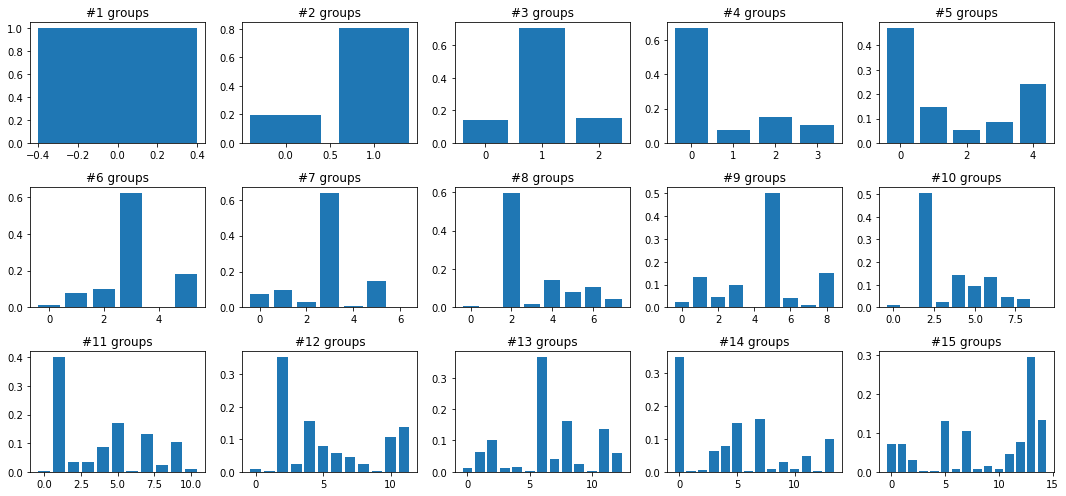

<Figure size 1080x360 with 0 Axes>

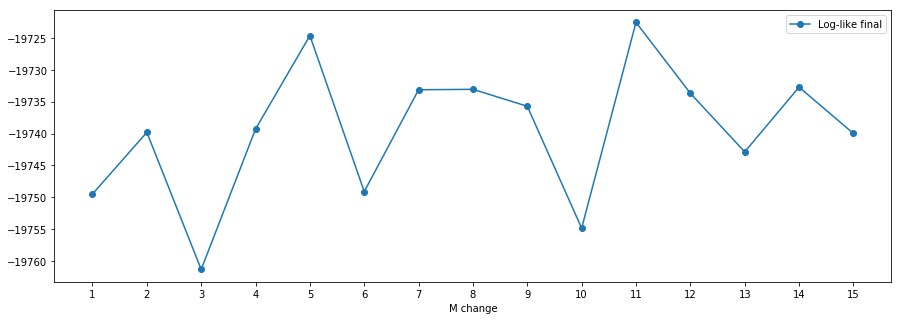

/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/ipykernel/__main__.py:44: RuntimeWarning: invalid value encountered in true_divide


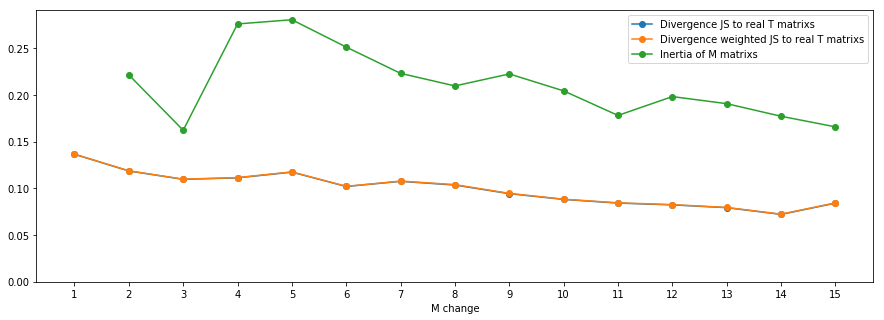

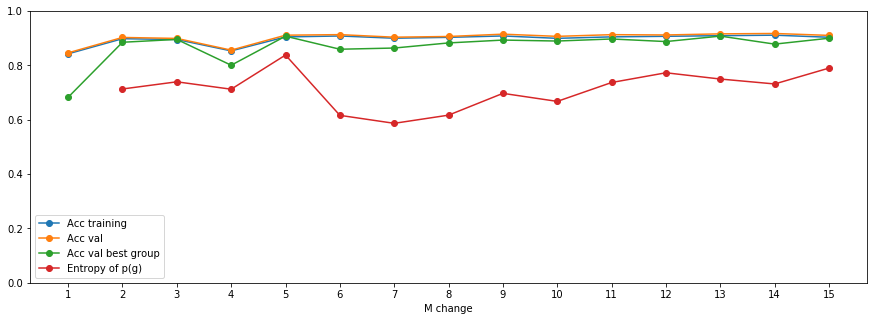

/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/ipykernel/__main__.py:63: RuntimeWarning: invalid value encountered in true_divide


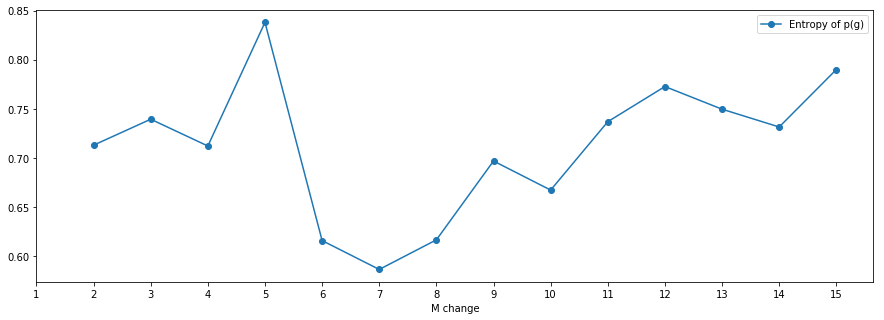

In [43]:
#version mv_Close
plot_Mchange(logL_Mchange,
         accTR_Mchange,
         accTE_Mchange,
         best_group_acc_Mchange,
         probas_Mchange,
         divergence1_Mchange,
             divergence2_Mchange,
         probGt_Mchange,
         inertia_Mchange)

Comentarios:
* Acc de modelos base es "casi" independiente del número de grupos a escoger
* Divergencia de matrices disminuye al aumentar los grupos (cada uno se hace especialista en disstitnas partes)
* Inertia igual disminuye (ya que se van reduciendo las posibilidades)
* log like ni idea 

In [28]:
#T if i know T
M_values = range(1,1+len(logL_Mchange))
print(T)
t = pd.DataFrame()
t["#Groups"] = M_values
t[">=1 annotator"] = [ np.sum(probas*T >= 1) for probas in probas_Mchange]
t[">=2 annotator"] = [ np.sum(probas*T >= 2) for probas in probas_Mchange] #si agrupa al menos tiene 2
t["Used on annotators"] = [ len(np.unique(prob_Gt.argmax(axis=1))) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.01"] = [ np.sum(prob_Gt.max(axis=0)>=0.01) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.05"] = [ np.sum(prob_Gt.max(axis=0)>=0.05) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t

24507


#Groups  >=1 annotator  >=2 annotator  Used on annotators  \
0         1              1              1                   1   
1         2              2              2                   2   
2         3              3              3                   3   
3         4              4              4                   3   
4         5              5              5                   4   
5         6              6              6                   3   
6         7              7              7                   3   
7         8              8              8                   4   
8         9              9              9                   4   
9        10             10             10                   5   
10       11             11             11                   5   
11       12             12             12                   6   
12       13             13             13                   7   
13       14             14             14                   5   
14       15             15             15                   7   

    Used on annotators limit >=0.01  Used on annotators limit >=0.05  
0                                 1                                1  
1                                 2                                2  
2                                 3                                3  
3                                 3                                3  
4                                 5                                5  
5                                 5                                5  
6                                 5                                5  
7                                 6                                5  
8                                 7                                7  
9                                 7                                7  
10                                8                                8  
11                                9                                9  
12                               10                               10  
13                                9                                8  
14                               12                               12

In [44]:
#what if we change M_set to the new one find-- nada extraordinario
M_seted = 5

In [45]:
gMixture_Global = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Global.define_model("mlp",16,1,BatchN=False,drop=0.2)
gMixture_Global.lambda_random = True #with lambda random --necessary
logL_hists,i_r = gMixture_Global.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL
                                   ,cluster=True)
Z_train_p = gMixture_Global.base_model.predict(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Global.base_model.predict(Xstd_test)
Z_test_pred = Z_test_p.argmax(axis=-1)

Needed params (units,deep,drop,BatchN?)
mv close is done
Doing clustering...Done!
Get init alphas in 0.005065 mins
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.24186128 0.1135568  0.46022108 0.87745076 0.01478573]
Alphas:  (5,)
MV init:  (2457, 3)
Betas:  (5, 3, 3)
Q estimate:  (2457, 3, 5, 3)
Iter 1/50
M step: done,  E step: done //  (in 0.78 sec)	logL: -24422.025	
Iter 2/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -23326.523	Tol1: 0.04486	Tol2: 0.42242	Tol3: 0.09669	
Iter 3/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22686.732	Tol1: 0.02743	Tol2: 0.18878	Tol3: 0.03537	
Iter 4/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22145.072	Tol1: 0.02388	Tol2: 0.14489	Tol3: 0.02633	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21670.373	Tol1: 0.02144	Tol2: 0.12732	Tol3: 0.02392	
Iter 6/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -21266.378	Tol1: 0.01864	Tol2: 0.11524	Tol3: 0.02260	
Iter 7/50
M s

M step: done,  E step: done //  (in 0.09 sec)	logL: -19834.245	Tol1: 0.00071	Tol2: 0.04152	Tol3: 0.00514	
Iter 25/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -19821.877	Tol1: 0.00062	Tol2: 0.04098	Tol3: 0.00408	
Iter 26/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -19812.969	Tol1: 0.00045	Tol2: 0.04071	Tol3: 0.00306	
Iter 27/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19802.386	Tol1: 0.00053	Tol2: 0.04076	Tol3: 0.00423	
Iter 28/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19795.989	Tol1: 0.00032	Tol2: 0.04055	Tol3: 0.00415	
Iter 29/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -19790.471	Tol1: 0.00028	Tol2: 0.03744	Tol3: 0.00343	
Iter 30/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -19783.566	Tol1: 0.00035	Tol2: 0.03407	Tol3: 0.00254	
Iter 31/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -19779.267	Tol1: 0.00022	Tol2: 0.03344	Tol3: 0.00318	
Iter 32/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -19775.085	T

M step: done,  E step: done //  (in 0.08 sec)	logL: -19893.758	Tol1: 0.00074	Tol2: 0.03734	Tol3: 0.00213	
Iter 28/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -19882.158	Tol1: 0.00058	Tol2: 0.03841	Tol3: 0.00293	
Iter 29/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -19872.267	Tol1: 0.00050	Tol2: 0.03725	Tol3: 0.00215	
Iter 30/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -19862.998	Tol1: 0.00047	Tol2: 0.03529	Tol3: 0.00170	
Iter 31/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -19855.829	Tol1: 0.00036	Tol2: 0.03399	Tol3: 0.00204	
Iter 32/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -19850.457	Tol1: 0.00027	Tol2: 0.03341	Tol3: 0.00183	
Iter 33/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -19842.694	Tol1: 0.00039	Tol2: 0.02980	Tol3: 0.00185	
Finished training!
Initializing new EM...
Pre-train network on 0 epochs... Done!
Lambda by group:  [0.8731074  0.25329182 0.8617572  0.6496402  0.97593236]
Alphas:  (5,)
MV init:  (2457, 3)
Be

M step: done,  E step: done //  (in 0.09 sec)	logL: -23209.844	Tol1: 0.01758	Tol2: 0.12445	Tol3: 0.02363	
Iter 5/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -22787.560	Tol1: 0.01819	Tol2: 0.11528	Tol3: 0.02346	
Iter 6/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -22346.573	Tol1: 0.01935	Tol2: 0.11266	Tol3: 0.02415	
Iter 7/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21916.867	Tol1: 0.01923	Tol2: 0.10912	Tol3: 0.02560	
Iter 8/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -21502.134	Tol1: 0.01892	Tol2: 0.10316	Tol3: 0.02610	
Iter 9/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -21133.920	Tol1: 0.01712	Tol2: 0.09382	Tol3: 0.02583	
Iter 10/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -20825.739	Tol1: 0.01458	Tol2: 0.08120	Tol3: 0.02496	
Iter 11/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -20575.649	Tol1: 0.01201	Tol2: 0.07042	Tol3: 0.02384	
Iter 12/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -20388.531	Tol1: 

M step: done,  E step: done //  (in 0.08 sec)	logL: -20112.515	Tol1: 0.00429	Tol2: 0.04966	Tol3: 0.01216	
Iter 15/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -20050.284	Tol1: 0.00309	Tol2: 0.04657	Tol3: 0.01011	
Iter 16/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -20001.519	Tol1: 0.00243	Tol2: 0.04576	Tol3: 0.00819	
Iter 17/50
M step: done,  E step: done //  (in 0.09 sec)	logL: -19965.822	Tol1: 0.00178	Tol2: 0.04671	Tol3: 0.00707	
Iter 18/50
M step: done,  E step: done //  (in 0.14 sec)	logL: -19940.946	Tol1: 0.00125	Tol2: 0.04668	Tol3: 0.00637	
Iter 19/50
M step: done,  E step: done //  (in 0.15 sec)	logL: -19918.699	Tol1: 0.00112	Tol2: 0.04463	Tol3: 0.00577	
Iter 20/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -19902.139	Tol1: 0.00083	Tol2: 0.04292	Tol3: 0.00554	
Iter 21/50
M step: done,  E step: done //  (in 0.08 sec)	logL: -19889.017	Tol1: 0.00066	Tol2: 0.04052	Tol3: 0.00570	
Iter 22/50
M step: done,  E step: done //  (in 0.10 sec)	logL: -19878.196	T

*** Ours Global multiples runs***
Train


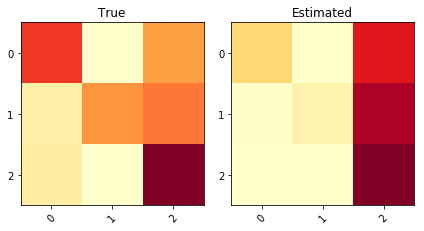

JS divergence: 0.0943	KL divergence: 0.3207


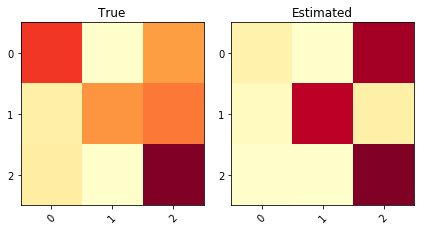

JS divergence: 0.1266	KL divergence: 0.4178


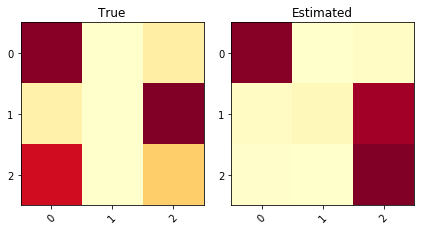

JS divergence: 0.1833	KL divergence: 0.9198


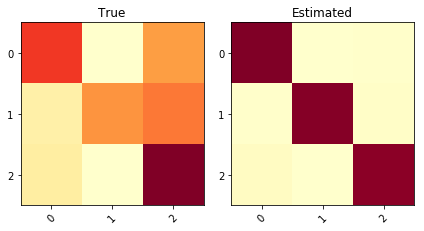

JS divergence: 0.1759	KL divergence: 0.9166


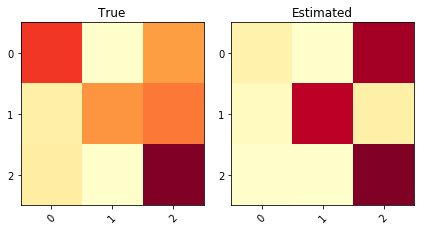

JS divergence: 0.1266	KL divergence: 0.4179


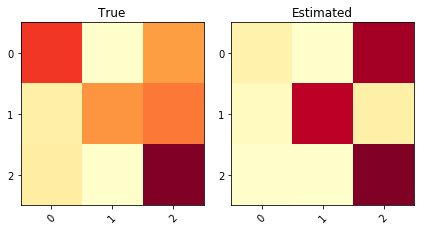

JS divergence: 0.1265	KL divergence: 0.4172


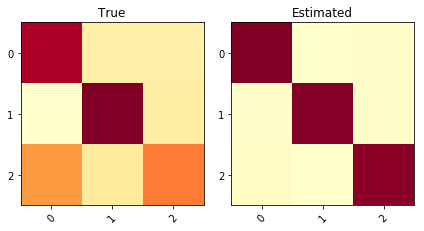

JS divergence: 0.1168	KL divergence: 0.5265


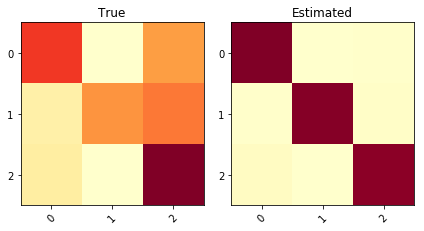

JS divergence: 0.1759	KL divergence: 0.9162


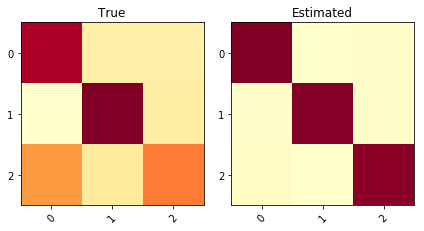

JS divergence: 0.1168	KL divergence: 0.5265


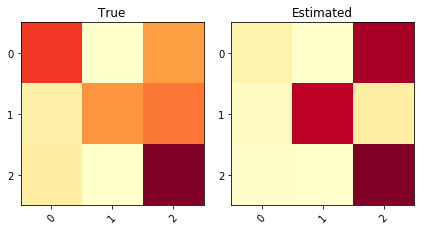

JS divergence: 0.1241	KL divergence: 0.4075


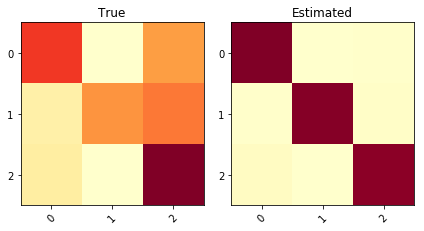

JS divergence: 0.1759	KL divergence: 0.9165


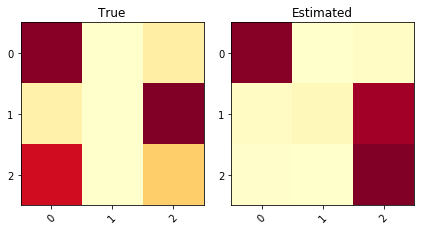

JS divergence: 0.1833	KL divergence: 0.9198


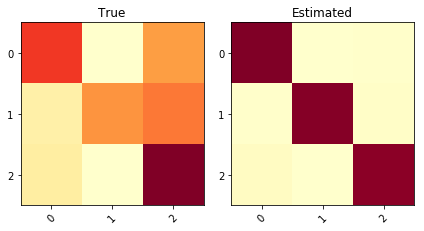

JS divergence: 0.1759	KL divergence: 0.9158


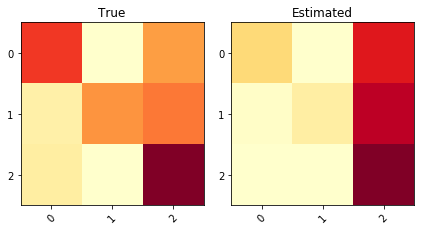

JS divergence: 0.0880	KL divergence: 0.2920


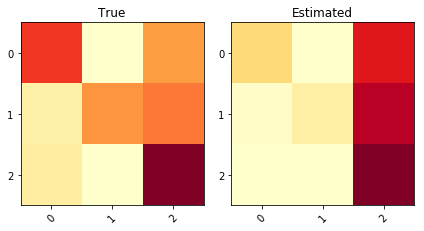

JS divergence: 0.0887	KL divergence: 0.2953
A result
 ====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
  ..            Accuracy    F1 (micro)    Mean KL    Mean JS    Wmean KL    Wmean JS    Mean RMSE    Wmean RMSE
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
   0  Global    0.909239      0.909239   0.552402   0.128975    0.554131    0.129208     0.192017        0.1922
====  ======  ==========  ============  =========  =========  ==========  ==========  ===========  ============
A result
 ====  ========================  ====================  =========================  =====================
  ..    Mean ACC imiting Annot    Mean cross-entropy    Wmean ACC imiting Annot    wMean cross entropy
====  ========================  ====================  =========================  =====================
   0                  0.644174              0.817832               

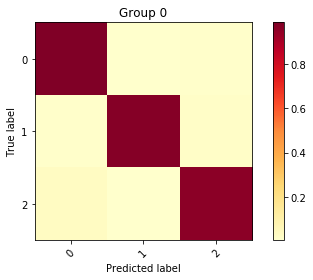

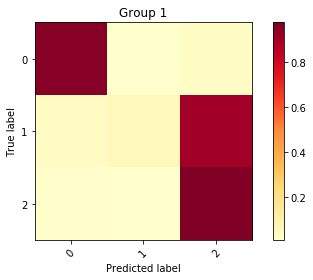

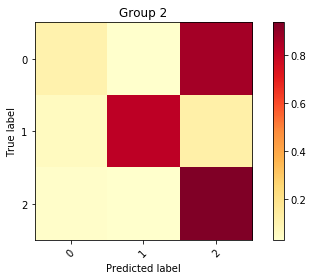

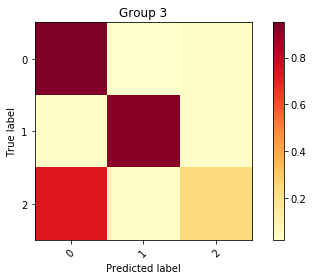

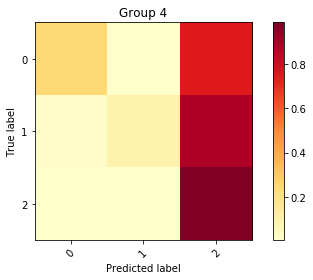

Inertia: 0.3107356759889428
A result
 ====  ========  =========  ======  =========  ===========  =========  =============  =========  ==========  ============
  ..    Groups       Prob    T(g)    Entropy    Diag Mean    KL to I    I sim %(JS)    Spammer    Accuracy    F1 (micro)
====  ========  =========  ======  =========  ===========  =========  =============  =========  ==========  ============
   0         0  0.467277       46   0.12871      0.974526  0.0258602       0.981426   0.961788    0.907204      0.907204
   1         1  0.152355       15   0.232975     0.66398   0.978967        0.579952   0.495971    0.634921      0.634921
   2         2  0.0562303       5   0.441543     0.621087  0.835643        0.578519   0.43163     0.582418      0.582418
   3         3  0.0781141       7   0.415323     0.702375  0.529783        0.695178   0.553562    0.637363      0.637363
   4         4  0.246023       24   0.361447     0.443201  1.25247         0.363211   0.164802    0.333333      0.3

In [46]:
from code.evaluation import Evaluation_metrics
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)